In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
import logging
from skimage.io import imread
from torchviz import make_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from torch.autograd import Variable
from torch.optim import *
from scipy.io import loadmat
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, ConcatDataset, DataLoader, SubsetRandomSampler
import torchio as tio
from torch.utils.tensorboard import SummaryWriter

import matplotlib.cm as cm
import matplotlib.animation as animation
#import plotly.graph_objects as go
#import plotly.io as pio
#pio.renderers.default = "notebook"
import math

from utils.dataset_utils import *
from utils.classifier_utils import *
from utils.neural_networks import *

logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s - %(message)s', datefmt="%Y-%m-%d %H:%M:%S")

In [26]:
info = {}
info["ext"] = "mat"
#info["ext"] = "nii"
dir_path = "../RSNA-BTC-Datasets/train_"+info["ext"]
test_dir_path = "../RSNA-BTC-Datasets/test_"+info["ext"]
ext_test_1_dir_path = "../RSNA-BTC-Datasets/brats18_"+info["ext"]
ext_test_0_dir_path = "../RSNA-BTC-Datasets/OpenNeuroDS000221_ss_"+info["ext"]
#info["mri_types"] = ["FLAIR", "T2w"]
#info["mri_types"] = ["FLAIR", "T1w"]
#info["mri_types"] = ["T1wCE", "T2w"]
#info["mri_types"] = ["FLAIR"]
#info["mri_types"] = ["T1wCE"]
#info["mri_types"] = ["T1w"]
info["mri_types"] = ["KLF"]

chosen_net  = "tun" #"eff" #"sim" #"vox" #"res" #"tun" #"vot" #"alt"
info["dims"] = 2 #2 #3
if chosen_net == "sim":
    if info["dims"] == 3:
        info["batch_size"] = 2 #8
    elif info["dims"] == 2:
        info["batch_size"] = 16
elif chosen_net == "eff":
    info["batch_size"] = 4
elif chosen_net == "vox":
    info["batch_size"] = 4
elif chosen_net == "res":
    info["batch_size"] = 1
elif chosen_net == "tun":
    info["batch_size"] = 2
elif chosen_net == "vot":
    info["batch_size"] = 16
info["is_depth_wise"] = True
info["is_transformed"] = False
if info["is_transformed"]:
    transform = get_transform(info["dims"])
else:
    transform = None
info["output_size"] = 1
info["is_multistep"] = True

info["is_adam"] = True
if info["is_adam"]:
    info["lr"] = 0.0005 #0.00005
else:
    info["lr"] = 0.001
info["momentum"] = 0.9
info["is_10_fold"] = False
if not info["is_10_fold"]:
    info["val_total_ratio"] = 0.1 #0.2
info["is_internal_dataset"] = True
if chosen_net == "vot":
    sel_slices = 16
    info["dims"] = 2
    info["batch_size"] = 1
    info["mri_types"] = ["KLF"]
elif chosen_net == "alt":
    #sel_slices = None
    sel_slices = 1
    info["dims"] = 2
    info["batch_size"] = 1
    info["mri_types"] = ["KLF", "FLAIR"]
else:
    sel_slices = None
size = len(info["mri_types"])

In [27]:
print(info)

{'ext': 'mat', 'mri_types': ['KLF'], 'dims': 2, 'batch_size': 2, 'is_depth_wise': True, 'is_transformed': False, 'output_size': 1, 'is_multistep': True, 'is_adam': True, 'lr': 0.0005, 'momentum': 0.9, 'is_10_fold': False, 'val_total_ratio': 0.1, 'is_internal_dataset': True}


In [28]:
#dataset_0_flair_t2w = Dataset(dir_path, "FLAIR", "T2w", list_classes=["0"], transform=transform, ext=ext)
if info["is_internal_dataset"]:
    dataset_0 = Dataset(dir_path, info["mri_types"], list_classes=["0"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

    logging.info("Train/Val datasets size: {}".format(len(dataset_0)))

    dataset_1 = Dataset(dir_path, info["mri_types"], list_classes=["1"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

    logging.info("Train/Val datasets size: {}".format(len(dataset_1)))
else:
    dataset_0 = Dataset(ext_test_0_dir_path, info["mri_types"], list_classes=["0"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

    logging.info("Train/Val datasets size: {}".format(len(dataset_0)))

    dataset_1 = Dataset(ext_test_1_dir_path, info["mri_types"], list_classes=["1"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

    logging.info("Train/Val datasets size: {}".format(len(dataset_1)))

#test_dataset = Dataset(test_dir_path, info["mri_types"], list_classes=["unknown"], transform=None, ext=info["ext"], dims=info["dims"])

#logging.info("Test dataset size: {}".format(len(test_dataset)))

#ext_test_dataset_1 = Dataset(ext_test_1_dir_path, info["mri_types"], list_classes=["1"], transform=None, ext=info["ext"], dims=info["dims"])

#logging.info("External Test 1 dataset size: {}".format(len(ext_test_dataset_1)))

#ext_test_dataset_0 = Dataset(ext_test_0_dir_path, info["mri_types"], list_classes=["0"], transform=None, ext=info["ext"], dims=info["dims"])

#logging.info("External Test 0 dataset size: {}".format(len(ext_test_dataset_0)))

2022-03-11 09:00:41 - Train/Val datasets size: 270
2022-03-11 09:00:41 - Train/Val datasets size: 303


In [29]:
#if size == 2:
#    print(dataset_0.__getitem__(0))
#    print(dataset_0.__getitem__(0)[2].shape)
#    print(test_dataset.__getitem__(0)[2].shape)
#else:
sub_dir_idx = 0
print(dataset_0.__getitem__(0)[0][sub_dir_idx])
print(dataset_0.__getitem__(0)[1][sub_dir_idx].shape)
#print(test_dataset.__getitem__(0)[1][sub_dir_idx].shape)

for i in range(len(dataset_0.__getitem__(0)[0])):
    if size != len(dataset_0.__getitem__(0)[0]):
        print("KLF scans are taken to retrieve top slice index by pixel count, but scans themselves won't be used")
        size = len(dataset_0.__getitem__(0)[0])
        print(f"Sub Dir: {info['mri_types'][i+1]}")
    else:
        print(f"Sub Dir: {info['mri_types'][i]}")
    print(dataset_0.__getitem__(0)[0][i])
    print(dataset_0.__getitem__(1)[0][i])
    print(dataset_1.__getitem__(0)[0][i])
    print(dataset_1.__getitem__(1)[0][i])

00009_KLF.mat
torch.Size([192, 192, 192])
Sub Dir: KLF
00009_KLF.mat
00017_KLF.mat
00000_KLF.mat
00002_KLF.mat


In [30]:
print(len(dataset_0.samples_dict[info['mri_types'][0]]))
print(len(dataset_1.samples_dict[info['mri_types'][0]]))

270
303


In [31]:
#dataset_0 = []
#for i in range(0,len(dataset_flair_t2w)):
#    if dataset_flair_t2w.__getitem__(i)[4] == 0:
#        dataset_0.append(dataset_flair_t2w.__getitem__(i))
#dataset_0_size = len(dataset_0)
#dataset_1 = []
#for i in range(0,len(dataset_flair_t2w)):
#    if dataset_flair_t2w.__getitem__(i)[4] == 1:
#        dataset_1.append(dataset_flair_t2w.__getitem__(i))
#dataset_1_size = len(dataset_1)

In [32]:
dataset_merged = Dataset().concat_datasets(dataset_0, dataset_1)
dataset_merged_no_tr = Dataset().concat_datasets(dataset_0, dataset_1, import_transform=False)

splits = get_splits(dataset_0, dataset_1, info["val_total_ratio"], info["is_10_fold"])

Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[89, 74, 153, 64, 296, 287, 286, 236, 126, 73, 20, 46, 160, 232, 181, 27, 173, 261, 37, 101, 166, 233, 184, 164, 206, 248, 253, 293, 76, 272, 238, 137, 106, 284, 44, 139, 247, 288, 156, 297, 252, 54, 234, 18, 205, 254, 182, 56, 71, 144, 249, 209, 290, 219, 158, 176, 33, 83, 136, 210, 118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 5

In [33]:
#test_dataset = Dataset().concat_datasets(test_dataset)
#test_dataset_size = len(test_dataset)
#test_dataset_indices = list(range(test_dataset_size))

#np.random.shuffle(test_dataset_indices)
#print("Internal Test Idx:")
#print(test_dataset_indices)

#g_cpu = torch.Generator()
#test_sampler = SubsetRandomSampler(test_dataset_indices, g_cpu)

In [34]:
#ext_test_dataset_merged = Dataset().concat_datasets(ext_test_dataset_0, ext_test_dataset_1, balance=False)
#ext_test_dataset_0_size = len(ext_test_dataset_0)
#ext_test_dataset_1_size = len(ext_test_dataset_1)
#ext_test_dataset_0_indices = list(range(ext_test_dataset_0_size))
#ext_test_dataset_1_indices = list(range(ext_test_dataset_0_size, ext_test_dataset_1_size+ext_test_dataset_0_size))

#np.random.shuffle(ext_test_dataset_0_indices)
#np.random.shuffle(ext_test_dataset_1_indices)
#print("External Test 0 Idx:")
#print(ext_test_dataset_0_indices)
#print("External Test 1 Idx:")
#print(ext_test_dataset_1_indices)

#ext_test_dataset_indices = ext_test_dataset_0_indices + ext_test_dataset_1_indices
#g_cpu = torch.Generator()
#ext_test_sampler = SubsetRandomSampler(ext_test_dataset_indices, g_cpu)

In [35]:
#train_loader = DataLoader(dataset=dataset_merged, batch_size=info["batch_size"], sampler=train_sampler, num_workers=2, worker_init_fn=np.random.seed(0))
#val_loader = DataLoader(dataset=dataset_merged_no_tr, batch_size=info["batch_size"], sampler=val_sampler, num_workers=2, worker_init_fn=np.random.seed(0))
#test_loader = DataLoader(dataset=test_dataset, batch_size=info["batch_size"], sampler=test_sampler, num_workers=2, worker_init_fn=np.random.seed(0))
#ext_test_loader = DataLoader(dataset=ext_test_dataset_merged, batch_size=info["batch_size"], sampler=ext_test_sampler, num_workers=2, worker_init_fn=np.random.seed(0))

if not info["is_10_fold"]:
    dataloader = get_all_split_loaders(dataset_merged, dataset_merged_no_tr, splits, info["batch_size"])
    dataloaders = dataloader
else:
    dataloaders = get_all_split_loaders(dataset_merged, dataset_merged_no_tr, splits, info["batch_size"])

logging.info("Train validation test splitted: {} {} {}".format(len(splits[0][0]),len(splits[0][1]),len(splits[0][2])))

2022-03-11 09:00:46 - Train validation test splitted: 486 60 60


In [36]:
if False:
    zeros = 0
    ones = 0
    for i in train_idx:
        if dataset_merged.__getitem__(i)[4] == 0:
            zeros += 1
            if zeros % 25 == 0:
                print("Zeros: " + str(zeros))
            #print(dataset_flair_t2w.__getitem__(i)[0], dataset_flair_t2w.__getitem__(i)[4])
        else:
            ones += 1
            if ones % 25 == 0:
                print("Ones: " + str(ones))
            #print(dataset_flair_t2w.__getitem__(i)[0], dataset_flair_t2w.__getitem__(i)[4])

    print("Total zeros: " + str(zeros))
    print("Total ones: " + str(ones))

    zeros = 0
    ones = 0
    for i in val_idx:
        if dataset_merged.__getitem__(i)[4] == 0:
            zeros += 1
            if zeros % 25 == 0:
                print("Zeros: " + str(zeros))
            #print(dataset_flair_t2w.__getitem__(i)[0], dataset_flair_t2w.__getitem__(i)[4])
        else:
            ones += 1
            if ones % 25 == 0:
                print("Ones: " + str(ones))
            #print(dataset_flair_t2w.__getitem__(i)[0], dataset_flair_t2w.__getitem__(i)[4])

    print("Total zeros: " + str(zeros))
    print("Total ones: " + str(ones))

In [37]:
# Model check
model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])
print(count_parameters(model))

14356929


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info("Using CUDA...")

2022-02-17 11:49:06 - Using CUDA...


RSNAAlternativeClassifierSingle2D(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): ReLU()
    )
    (1): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), groups=16, bias=False)
      (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): ReLU()
    )
    (4): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (5): Sequential(
      (0): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), groups=16, bias=False)
      (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): ReLU()
    )
    (6)

  0%|                                                   | 0/300 [00:00<?, ?it/s]

2022-02-17 11:49:11 - EPOCH: 1
2022-02-17 11:49:12 - Train Step 10/486, train_loss: 0.6800
2022-02-17 11:49:13 - Train Step 20/486, train_loss: 0.6889
2022-02-17 11:49:15 - Train Step 30/486, train_loss: 0.6923
2022-02-17 11:49:16 - Train Step 40/486, train_loss: 0.6883
2022-02-17 11:49:17 - Train Step 50/486, train_loss: 0.6943
2022-02-17 11:49:18 - Train Step 60/486, train_loss: 0.7013
2022-02-17 11:49:19 - Train Step 70/486, train_loss: 0.7005
2022-02-17 11:49:21 - Train Step 80/486, train_loss: 0.7004
2022-02-17 11:49:22 - Train Step 90/486, train_loss: 0.6979
2022-02-17 11:49:23 - Train Step 100/486, train_loss: 0.6946
2022-02-17 11:49:24 - Train Step 110/486, train_loss: 0.6947
2022-02-17 11:49:26 - Train Step 120/486, train_loss: 0.6963
2022-02-17 11:49:27 - Train Step 130/486, train_loss: 0.6964
2022-02-17 11:49:28 - Train Step 140/486, train_loss: 0.6954
2022-02-17 11:49:29 - Train Step 150/486, train_loss: 0.6942
2022-02-17 11:49:31 - Train Step 160/486, train_loss: 0.6943
20

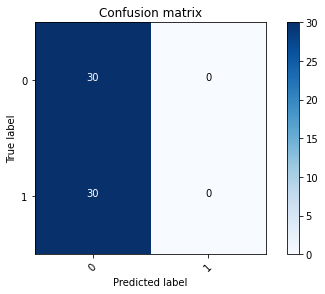

2022-02-17 11:50:20 - [Epoch Train: 1] loss: 0.6969, auc: 0.5044, acc: 0.5000, time: 61.00 s            
2022-02-17 11:50:20 - [Epoch Valid: 1] loss: 0.6935, auc: 0.6344, acc: 0.5000, time: 7.00 s
2022-02-17 11:50:20 - acc improved from 0.0000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e1-loss0.694-acc0.500-auc0.634.pth'


  0%|▏                                        | 1/300 [01:09<5:43:56, 69.02s/it]

2022-02-17 11:50:20 - EPOCH: 2
2022-02-17 11:50:21 - Train Step 10/486, train_loss: 0.7082
2022-02-17 11:50:23 - Train Step 20/486, train_loss: 0.7061
2022-02-17 11:50:24 - Train Step 30/486, train_loss: 0.7053
2022-02-17 11:50:25 - Train Step 40/486, train_loss: 0.7052
2022-02-17 11:50:26 - Train Step 50/486, train_loss: 0.7007
2022-02-17 11:50:28 - Train Step 60/486, train_loss: 0.6980
2022-02-17 11:50:29 - Train Step 70/486, train_loss: 0.6999
2022-02-17 11:50:30 - Train Step 80/486, train_loss: 0.6983
2022-02-17 11:50:31 - Train Step 90/486, train_loss: 0.6972
2022-02-17 11:50:33 - Train Step 100/486, train_loss: 0.6962
2022-02-17 11:50:34 - Train Step 110/486, train_loss: 0.6951
2022-02-17 11:50:35 - Train Step 120/486, train_loss: 0.6945
2022-02-17 11:50:36 - Train Step 130/486, train_loss: 0.6921
2022-02-17 11:50:38 - Train Step 140/486, train_loss: 0.6917
2022-02-17 11:50:39 - Train Step 150/486, train_loss: 0.6942
2022-02-17 11:50:40 - Train Step 160/486, train_loss: 0.6947
20

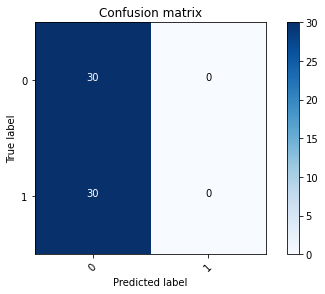

2022-02-17 11:51:31 - [Epoch Train: 2] loss: 0.6910, auc: 0.5547, acc: 0.5000, time: 62.00 s            
2022-02-17 11:51:31 - [Epoch Valid: 2] loss: 0.6896, auc: 0.5967, acc: 0.5000, time: 7.00 s
2022-02-17 11:51:31 - acc improved from 0.5000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e2-loss0.690-acc0.500-auc0.597.pth'


  1%|▎                                        | 2/300 [02:19<5:47:41, 70.01s/it]

2022-02-17 11:51:31 - EPOCH: 3
2022-02-17 11:51:32 - Train Step 10/486, train_loss: 0.6931
2022-02-17 11:51:33 - Train Step 20/486, train_loss: 0.6968
2022-02-17 11:51:34 - Train Step 30/486, train_loss: 0.6943
2022-02-17 11:51:36 - Train Step 40/486, train_loss: 0.6917
2022-02-17 11:51:37 - Train Step 50/486, train_loss: 0.6931
2022-02-17 11:51:38 - Train Step 60/486, train_loss: 0.6951
2022-02-17 11:51:40 - Train Step 70/486, train_loss: 0.6943
2022-02-17 11:51:41 - Train Step 80/486, train_loss: 0.6903
2022-02-17 11:51:42 - Train Step 90/486, train_loss: 0.6896
2022-02-17 11:51:43 - Train Step 100/486, train_loss: 0.6899
2022-02-17 11:51:45 - Train Step 110/486, train_loss: 0.6912
2022-02-17 11:51:46 - Train Step 120/486, train_loss: 0.6895
2022-02-17 11:51:48 - Train Step 130/486, train_loss: 0.6905
2022-02-17 11:51:49 - Train Step 140/486, train_loss: 0.6900
2022-02-17 11:51:51 - Train Step 150/486, train_loss: 0.6902
2022-02-17 11:51:52 - Train Step 160/486, train_loss: 0.6903
20

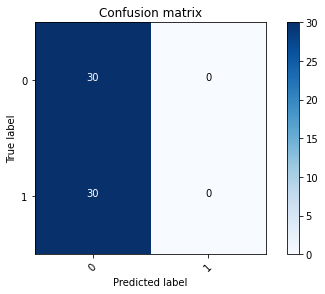

2022-02-17 11:52:41 - [Epoch Train: 3] loss: 0.6913, auc: 0.5589, acc: 0.5000, time: 62.00 s            
2022-02-17 11:52:41 - [Epoch Valid: 3] loss: 0.6847, auc: 0.6122, acc: 0.5000, time: 8.00 s
2022-02-17 11:52:41 - acc improved from 0.5000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e3-loss0.685-acc0.500-auc0.612.pth'


  1%|▍                                        | 3/300 [03:30<5:47:56, 70.29s/it]

2022-02-17 11:52:41 - EPOCH: 4
2022-02-17 11:52:43 - Train Step 10/486, train_loss: 0.6815
2022-02-17 11:52:44 - Train Step 20/486, train_loss: 0.6697
2022-02-17 11:52:45 - Train Step 30/486, train_loss: 0.6744
2022-02-17 11:52:47 - Train Step 40/486, train_loss: 0.6966
2022-02-17 11:52:48 - Train Step 50/486, train_loss: 0.7013
2022-02-17 11:52:49 - Train Step 60/486, train_loss: 0.6983
2022-02-17 11:52:50 - Train Step 70/486, train_loss: 0.6940
2022-02-17 11:52:52 - Train Step 80/486, train_loss: 0.6931
2022-02-17 11:52:53 - Train Step 90/486, train_loss: 0.6957
2022-02-17 11:52:54 - Train Step 100/486, train_loss: 0.6936
2022-02-17 11:52:56 - Train Step 110/486, train_loss: 0.6961
2022-02-17 11:52:57 - Train Step 120/486, train_loss: 0.6930
2022-02-17 11:52:58 - Train Step 130/486, train_loss: 0.6913
2022-02-17 11:52:59 - Train Step 140/486, train_loss: 0.6890
2022-02-17 11:53:01 - Train Step 150/486, train_loss: 0.6884
2022-02-17 11:53:02 - Train Step 160/486, train_loss: 0.6868
20

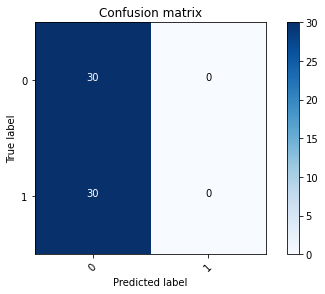

2022-02-17 11:53:51 - [Epoch Train: 4] loss: 0.6818, auc: 0.5961, acc: 0.5000, time: 62.00 s            
2022-02-17 11:53:51 - [Epoch Valid: 4] loss: 0.6779, auc: 0.6689, acc: 0.5000, time: 7.00 s
2022-02-17 11:53:51 - acc improved from 0.5000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e4-loss0.678-acc0.500-auc0.669.pth'


  1%|▌                                        | 4/300 [04:40<5:46:17, 70.20s/it]

2022-02-17 11:53:51 - EPOCH: 5
2022-02-17 11:53:53 - Train Step 10/486, train_loss: 0.7241
2022-02-17 11:53:54 - Train Step 20/486, train_loss: 0.7037
2022-02-17 11:53:55 - Train Step 30/486, train_loss: 0.6986
2022-02-17 11:53:56 - Train Step 40/486, train_loss: 0.6945
2022-02-17 11:53:58 - Train Step 50/486, train_loss: 0.6900
2022-02-17 11:53:59 - Train Step 60/486, train_loss: 0.6904
2022-02-17 11:54:00 - Train Step 70/486, train_loss: 0.6922
2022-02-17 11:54:02 - Train Step 80/486, train_loss: 0.6889
2022-02-17 11:54:03 - Train Step 90/486, train_loss: 0.6824
2022-02-17 11:54:04 - Train Step 100/486, train_loss: 0.6866
2022-02-17 11:54:05 - Train Step 110/486, train_loss: 0.6878
2022-02-17 11:54:07 - Train Step 120/486, train_loss: 0.6888
2022-02-17 11:54:08 - Train Step 130/486, train_loss: 0.6878
2022-02-17 11:54:09 - Train Step 140/486, train_loss: 0.6872
2022-02-17 11:54:11 - Train Step 150/486, train_loss: 0.6781
2022-02-17 11:54:12 - Train Step 160/486, train_loss: 0.6840
20

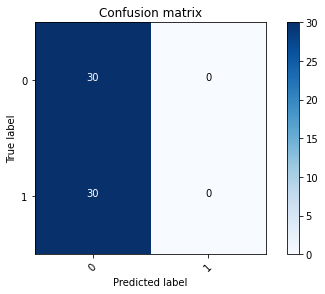

2022-02-17 11:55:02 - [Epoch Train: 5] loss: 0.6815, auc: 0.5942, acc: 0.5062, time: 62.00 s            
2022-02-17 11:55:02 - [Epoch Valid: 5] loss: 0.6756, auc: 0.6644, acc: 0.5000, time: 7.00 s
2022-02-17 11:55:02 - acc improved from 0.5000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e5-loss0.676-acc0.500-auc0.664.pth'


  2%|▋                                        | 5/300 [05:50<5:45:14, 70.22s/it]

2022-02-17 11:55:02 - EPOCH: 6
2022-02-17 11:55:03 - Train Step 10/486, train_loss: 0.6614
2022-02-17 11:55:04 - Train Step 20/486, train_loss: 0.6491
2022-02-17 11:55:06 - Train Step 30/486, train_loss: 0.6524
2022-02-17 11:55:07 - Train Step 40/486, train_loss: 0.6480
2022-02-17 11:55:08 - Train Step 50/486, train_loss: 0.6534
2022-02-17 11:55:09 - Train Step 60/486, train_loss: 0.6539
2022-02-17 11:55:11 - Train Step 70/486, train_loss: 0.6652
2022-02-17 11:55:12 - Train Step 80/486, train_loss: 0.6692
2022-02-17 11:55:13 - Train Step 90/486, train_loss: 0.6670
2022-02-17 11:55:15 - Train Step 100/486, train_loss: 0.6788
2022-02-17 11:55:16 - Train Step 110/486, train_loss: 0.6802
2022-02-17 11:55:17 - Train Step 120/486, train_loss: 0.6800
2022-02-17 11:55:18 - Train Step 130/486, train_loss: 0.6817
2022-02-17 11:55:20 - Train Step 140/486, train_loss: 0.6827
2022-02-17 11:55:21 - Train Step 150/486, train_loss: 0.6793
2022-02-17 11:55:22 - Train Step 160/486, train_loss: 0.6767
20

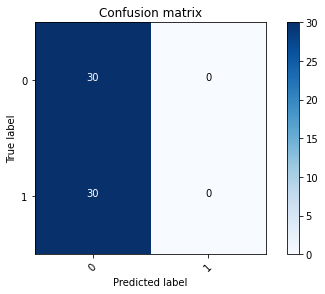

2022-02-17 11:56:12 - [Epoch Train: 6] loss: 0.6751, auc: 0.6271, acc: 0.5021, time: 62.00 s            
2022-02-17 11:56:12 - [Epoch Valid: 6] loss: 0.6643, auc: 0.6678, acc: 0.5000, time: 8.00 s
2022-02-17 11:56:12 - acc improved from 0.5000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e6-loss0.664-acc0.500-auc0.668.pth'


  2%|▊                                        | 6/300 [07:01<5:44:36, 70.33s/it]

2022-02-17 11:56:12 - EPOCH: 7
2022-02-17 11:56:13 - Train Step 10/486, train_loss: 0.6656
2022-02-17 11:56:15 - Train Step 20/486, train_loss: 0.6421
2022-02-17 11:56:16 - Train Step 30/486, train_loss: 0.6614
2022-02-17 11:56:17 - Train Step 40/486, train_loss: 0.6793
2022-02-17 11:56:19 - Train Step 50/486, train_loss: 0.6789
2022-02-17 11:56:20 - Train Step 60/486, train_loss: 0.6666
2022-02-17 11:56:21 - Train Step 70/486, train_loss: 0.6569
2022-02-17 11:56:22 - Train Step 80/486, train_loss: 0.6514
2022-02-17 11:56:24 - Train Step 90/486, train_loss: 0.6614
2022-02-17 11:56:25 - Train Step 100/486, train_loss: 0.6596
2022-02-17 11:56:26 - Train Step 110/486, train_loss: 0.6550
2022-02-17 11:56:27 - Train Step 120/486, train_loss: 0.6506
2022-02-17 11:56:29 - Train Step 130/486, train_loss: 0.6536
2022-02-17 11:56:30 - Train Step 140/486, train_loss: 0.6530
2022-02-17 11:56:31 - Train Step 150/486, train_loss: 0.6472
2022-02-17 11:56:32 - Train Step 160/486, train_loss: 0.6493
20

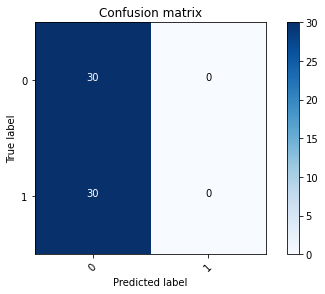

2022-02-17 11:57:23 - [Epoch Train: 7] loss: 0.6604, auc: 0.6583, acc: 0.5185, time: 63.00 s            
2022-02-17 11:57:23 - [Epoch Valid: 7] loss: 0.6464, auc: 0.7033, acc: 0.5000, time: 7.00 s
2022-02-17 11:57:23 - acc improved from 0.5000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e7-loss0.646-acc0.500-auc0.703.pth'


  2%|▉                                        | 7/300 [08:12<5:44:24, 70.53s/it]

2022-02-17 11:57:23 - EPOCH: 8
2022-02-17 11:57:24 - Train Step 10/486, train_loss: 0.6104
2022-02-17 11:57:26 - Train Step 20/486, train_loss: 0.5812
2022-02-17 11:57:27 - Train Step 30/486, train_loss: 0.5598
2022-02-17 11:57:28 - Train Step 40/486, train_loss: 0.5857
2022-02-17 11:57:30 - Train Step 50/486, train_loss: 0.5835
2022-02-17 11:57:31 - Train Step 60/486, train_loss: 0.5894
2022-02-17 11:57:32 - Train Step 70/486, train_loss: 0.5848
2022-02-17 11:57:33 - Train Step 80/486, train_loss: 0.5950
2022-02-17 11:57:35 - Train Step 90/486, train_loss: 0.6057
2022-02-17 11:57:36 - Train Step 100/486, train_loss: 0.6011
2022-02-17 11:57:37 - Train Step 110/486, train_loss: 0.5986
2022-02-17 11:57:38 - Train Step 120/486, train_loss: 0.5931
2022-02-17 11:57:40 - Train Step 130/486, train_loss: 0.5915
2022-02-17 11:57:41 - Train Step 140/486, train_loss: 0.5999
2022-02-17 11:57:42 - Train Step 150/486, train_loss: 0.5926
2022-02-17 11:57:43 - Train Step 160/486, train_loss: 0.5984
20

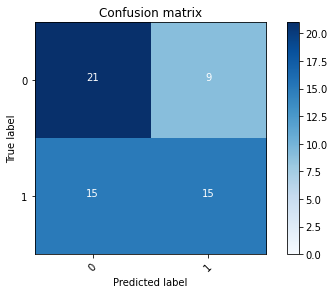

2022-02-17 11:58:35 - [Epoch Train: 8] loss: 0.6357, auc: 0.7017, acc: 0.5556, time: 63.00 s            
2022-02-17 11:58:35 - [Epoch Valid: 8] loss: 0.6692, auc: 0.6122, acc: 0.6000, time: 8.00 s
2022-02-17 11:58:35 - acc improved from 0.5000 to 0.6000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e8-loss0.669-acc0.600-auc0.612.pth'


  3%|█                                        | 8/300 [09:24<5:45:19, 70.96s/it]

2022-02-17 11:58:35 - EPOCH: 9
2022-02-17 11:58:36 - Train Step 10/486, train_loss: 0.5090
2022-02-17 11:58:38 - Train Step 20/486, train_loss: 0.5930
2022-02-17 11:58:39 - Train Step 30/486, train_loss: 0.5721
2022-02-17 11:58:40 - Train Step 40/486, train_loss: 0.5403
2022-02-17 11:58:42 - Train Step 50/486, train_loss: 0.5507
2022-02-17 11:58:43 - Train Step 60/486, train_loss: 0.5777
2022-02-17 11:58:44 - Train Step 70/486, train_loss: 0.5889
2022-02-17 11:58:46 - Train Step 80/486, train_loss: 0.5816
2022-02-17 11:58:47 - Train Step 90/486, train_loss: 0.5880
2022-02-17 11:58:48 - Train Step 100/486, train_loss: 0.5968
2022-02-17 11:58:49 - Train Step 110/486, train_loss: 0.5875
2022-02-17 11:58:51 - Train Step 120/486, train_loss: 0.5988
2022-02-17 11:58:52 - Train Step 130/486, train_loss: 0.6052
2022-02-17 11:58:53 - Train Step 140/486, train_loss: 0.6063
2022-02-17 11:58:55 - Train Step 150/486, train_loss: 0.6014
2022-02-17 11:58:56 - Train Step 160/486, train_loss: 0.6075
20

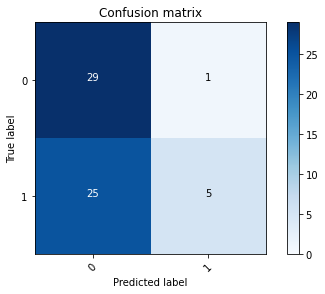

2022-02-17 11:59:45 - [Epoch Train: 9] loss: 0.6258, auc: 0.7054, acc: 0.5905, time: 62.00 s            
2022-02-17 11:59:45 - [Epoch Valid: 9] loss: 0.6397, auc: 0.6822, acc: 0.5667, time: 8.00 s


  3%|█▏                                       | 9/300 [10:34<5:43:10, 70.76s/it]

2022-02-17 11:59:45 - EPOCH: 10
2022-02-17 11:59:47 - Train Step 10/486, train_loss: 0.6564
2022-02-17 11:59:48 - Train Step 20/486, train_loss: 0.5591
2022-02-17 11:59:49 - Train Step 30/486, train_loss: 0.5519
2022-02-17 11:59:50 - Train Step 40/486, train_loss: 0.5345
2022-02-17 11:59:52 - Train Step 50/486, train_loss: 0.5725
2022-02-17 11:59:53 - Train Step 60/486, train_loss: 0.5827
2022-02-17 11:59:54 - Train Step 70/486, train_loss: 0.5833
2022-02-17 11:59:55 - Train Step 80/486, train_loss: 0.5773
2022-02-17 11:59:56 - Train Step 90/486, train_loss: 0.5598
2022-02-17 11:59:58 - Train Step 100/486, train_loss: 0.5728
2022-02-17 11:59:59 - Train Step 110/486, train_loss: 0.5693
2022-02-17 12:00:00 - Train Step 120/486, train_loss: 0.5683
2022-02-17 12:00:01 - Train Step 130/486, train_loss: 0.5712
2022-02-17 12:00:03 - Train Step 140/486, train_loss: 0.5687
2022-02-17 12:00:04 - Train Step 150/486, train_loss: 0.5746
2022-02-17 12:00:05 - Train Step 160/486, train_loss: 0.5730
2

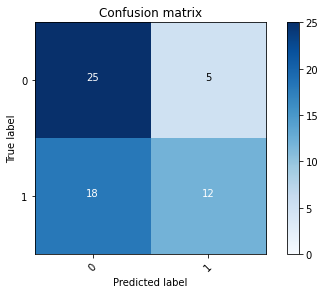

2022-02-17 12:00:54 - [Epoch Train: 10] loss: 0.5911, auc: 0.7578, acc: 0.6214, time: 60.00 s            
2022-02-17 12:00:54 - [Epoch Valid: 10] loss: 0.6341, auc: 0.6744, acc: 0.6167, time: 7.00 s
2022-02-17 12:00:54 - acc improved from 0.6000 to 0.6167. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e10-loss0.634-acc0.617-auc0.674.pth'


  3%|█▎                                      | 10/300 [11:43<5:38:58, 70.13s/it]

2022-02-17 12:00:54 - EPOCH: 11
2022-02-17 12:00:55 - Train Step 10/486, train_loss: 0.5794
2022-02-17 12:00:57 - Train Step 20/486, train_loss: 0.5018
2022-02-17 12:00:58 - Train Step 30/486, train_loss: 0.5134
2022-02-17 12:00:59 - Train Step 40/486, train_loss: 0.5461
2022-02-17 12:01:01 - Train Step 50/486, train_loss: 0.5520
2022-02-17 12:01:02 - Train Step 60/486, train_loss: 0.5380
2022-02-17 12:01:03 - Train Step 70/486, train_loss: 0.5196
2022-02-17 12:01:04 - Train Step 80/486, train_loss: 0.5309
2022-02-17 12:01:06 - Train Step 90/486, train_loss: 0.5364
2022-02-17 12:01:07 - Train Step 100/486, train_loss: 0.5491
2022-02-17 12:01:08 - Train Step 110/486, train_loss: 0.5556
2022-02-17 12:01:10 - Train Step 120/486, train_loss: 0.5476
2022-02-17 12:01:11 - Train Step 130/486, train_loss: 0.5405
2022-02-17 12:01:12 - Train Step 140/486, train_loss: 0.5464
2022-02-17 12:01:13 - Train Step 150/486, train_loss: 0.5623
2022-02-17 12:01:15 - Train Step 160/486, train_loss: 0.5528
2

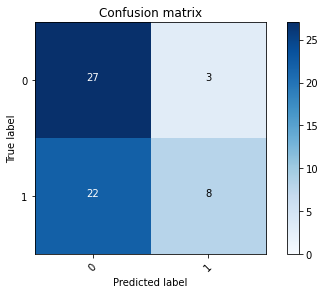

2022-02-17 12:02:04 - [Epoch Train: 11] loss: 0.5423, auc: 0.8134, acc: 0.6790, time: 62.00 s            
2022-02-17 12:02:04 - [Epoch Valid: 11] loss: 0.6528, auc: 0.6733, acc: 0.5833, time: 8.00 s


  4%|█▍                                      | 11/300 [12:53<5:37:50, 70.14s/it]

2022-02-17 12:02:04 - EPOCH: 12
2022-02-17 12:02:05 - Train Step 10/486, train_loss: 0.3826
2022-02-17 12:02:07 - Train Step 20/486, train_loss: 0.4964
2022-02-17 12:02:08 - Train Step 30/486, train_loss: 0.4513
2022-02-17 12:02:09 - Train Step 40/486, train_loss: 0.4870
2022-02-17 12:02:10 - Train Step 50/486, train_loss: 0.5823
2022-02-17 12:02:12 - Train Step 60/486, train_loss: 0.5602
2022-02-17 12:02:13 - Train Step 70/486, train_loss: 0.5784
2022-02-17 12:02:14 - Train Step 80/486, train_loss: 0.6148
2022-02-17 12:02:15 - Train Step 90/486, train_loss: 0.5912
2022-02-17 12:02:17 - Train Step 100/486, train_loss: 0.5654
2022-02-17 12:02:18 - Train Step 110/486, train_loss: 0.5482
2022-02-17 12:02:19 - Train Step 120/486, train_loss: 0.5480
2022-02-17 12:02:20 - Train Step 130/486, train_loss: 0.5539
2022-02-17 12:02:22 - Train Step 140/486, train_loss: 0.5401
2022-02-17 12:02:23 - Train Step 150/486, train_loss: 0.5396
2022-02-17 12:02:24 - Train Step 160/486, train_loss: 0.5395
2

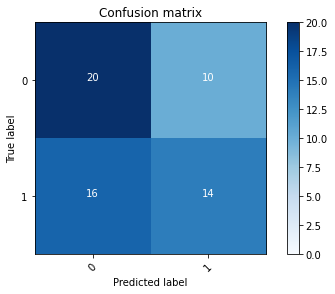

2022-02-17 12:03:13 - [Epoch Train: 12] loss: 0.5168, auc: 0.8400, acc: 0.6852, time: 61.00 s            
2022-02-17 12:03:13 - [Epoch Valid: 12] loss: 0.6821, auc: 0.6333, acc: 0.5667, time: 8.00 s


  4%|█▌                                      | 12/300 [14:02<5:35:21, 69.87s/it]

2022-02-17 12:03:13 - EPOCH: 13
2022-02-17 12:03:15 - Train Step 10/486, train_loss: 0.5000
2022-02-17 12:03:16 - Train Step 20/486, train_loss: 0.4305
2022-02-17 12:03:17 - Train Step 30/486, train_loss: 0.5324
2022-02-17 12:03:19 - Train Step 40/486, train_loss: 0.5338
2022-02-17 12:03:20 - Train Step 50/486, train_loss: 0.5528
2022-02-17 12:03:21 - Train Step 60/486, train_loss: 0.5367
2022-02-17 12:03:22 - Train Step 70/486, train_loss: 0.5035
2022-02-17 12:03:24 - Train Step 80/486, train_loss: 0.5087
2022-02-17 12:03:25 - Train Step 90/486, train_loss: 0.4968
2022-02-17 12:03:26 - Train Step 100/486, train_loss: 0.4973
2022-02-17 12:03:27 - Train Step 110/486, train_loss: 0.4970
2022-02-17 12:03:29 - Train Step 120/486, train_loss: 0.5063
2022-02-17 12:03:30 - Train Step 130/486, train_loss: 0.5019
2022-02-17 12:03:31 - Train Step 140/486, train_loss: 0.4928
2022-02-17 12:03:32 - Train Step 150/486, train_loss: 0.4898
2022-02-17 12:03:34 - Train Step 160/486, train_loss: 0.4803
2

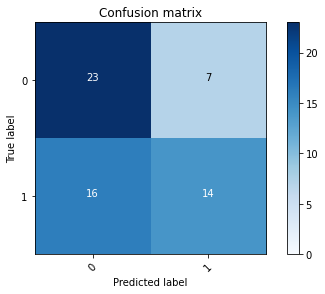

2022-02-17 12:04:23 - [Epoch Train: 13] loss: 0.4896, auc: 0.8556, acc: 0.7387, time: 61.00 s            
2022-02-17 12:04:23 - [Epoch Valid: 13] loss: 0.6712, auc: 0.6622, acc: 0.6167, time: 7.00 s
2022-02-17 12:04:23 - acc improved from 0.6167 to 0.6167. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e13-loss0.671-acc0.617-auc0.662.pth'


  4%|█▋                                      | 13/300 [15:12<5:34:23, 69.91s/it]

2022-02-17 12:04:23 - EPOCH: 14
2022-02-17 12:04:25 - Train Step 10/486, train_loss: 0.3868
2022-02-17 12:04:26 - Train Step 20/486, train_loss: 0.4805
2022-02-17 12:04:27 - Train Step 30/486, train_loss: 0.5319
2022-02-17 12:04:29 - Train Step 40/486, train_loss: 0.4667
2022-02-17 12:04:30 - Train Step 50/486, train_loss: 0.4495
2022-02-17 12:04:31 - Train Step 60/486, train_loss: 0.4455
2022-02-17 12:04:33 - Train Step 70/486, train_loss: 0.4468
2022-02-17 12:04:34 - Train Step 80/486, train_loss: 0.4465
2022-02-17 12:04:35 - Train Step 90/486, train_loss: 0.4608
2022-02-17 12:04:36 - Train Step 100/486, train_loss: 0.4922
2022-02-17 12:04:38 - Train Step 110/486, train_loss: 0.4992
2022-02-17 12:04:39 - Train Step 120/486, train_loss: 0.5020
2022-02-17 12:04:40 - Train Step 130/486, train_loss: 0.4937
2022-02-17 12:04:42 - Train Step 140/486, train_loss: 0.4885
2022-02-17 12:04:43 - Train Step 150/486, train_loss: 0.4785
2022-02-17 12:04:44 - Train Step 160/486, train_loss: 0.4689
2

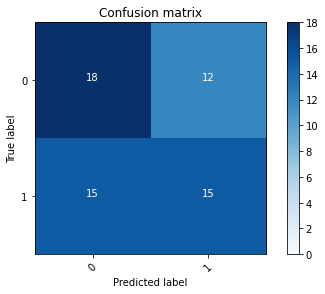

2022-02-17 12:05:34 - [Epoch Train: 14] loss: 0.4576, auc: 0.8790, acc: 0.7449, time: 63.00 s            
2022-02-17 12:05:34 - [Epoch Valid: 14] loss: 0.6879, auc: 0.6500, acc: 0.5500, time: 8.00 s


  5%|█▊                                      | 14/300 [16:23<5:34:59, 70.28s/it]

2022-02-17 12:05:34 - EPOCH: 15
2022-02-17 12:05:36 - Train Step 10/486, train_loss: 0.6068
2022-02-17 12:05:37 - Train Step 20/486, train_loss: 0.3709
2022-02-17 12:05:38 - Train Step 30/486, train_loss: 0.3592
2022-02-17 12:05:40 - Train Step 40/486, train_loss: 0.4255
2022-02-17 12:05:41 - Train Step 50/486, train_loss: 0.4920
2022-02-17 12:05:42 - Train Step 60/486, train_loss: 0.4820
2022-02-17 12:05:43 - Train Step 70/486, train_loss: 0.4607
2022-02-17 12:05:44 - Train Step 80/486, train_loss: 0.4496
2022-02-17 12:05:46 - Train Step 90/486, train_loss: 0.4578
2022-02-17 12:05:47 - Train Step 100/486, train_loss: 0.4451
2022-02-17 12:05:48 - Train Step 110/486, train_loss: 0.4570
2022-02-17 12:05:49 - Train Step 120/486, train_loss: 0.4594
2022-02-17 12:05:51 - Train Step 130/486, train_loss: 0.4749
2022-02-17 12:05:52 - Train Step 140/486, train_loss: 0.4572
2022-02-17 12:05:53 - Train Step 150/486, train_loss: 0.4461
2022-02-17 12:05:54 - Train Step 160/486, train_loss: 0.4499
2

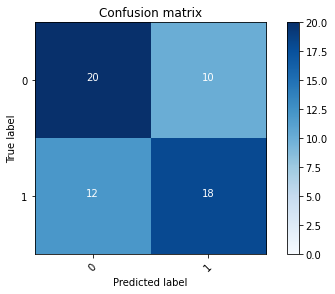

2022-02-17 12:06:43 - [Epoch Train: 15] loss: 0.4296, auc: 0.8910, acc: 0.7716, time: 60.00 s            
2022-02-17 12:06:43 - [Epoch Valid: 15] loss: 0.7367, auc: 0.6556, acc: 0.6333, time: 8.00 s
2022-02-17 12:06:43 - acc improved from 0.6167 to 0.6333. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e15-loss0.737-acc0.633-auc0.656.pth'


  5%|██                                      | 15/300 [17:32<5:31:43, 69.84s/it]

2022-02-17 12:06:43 - EPOCH: 16
2022-02-17 12:06:45 - Train Step 10/486, train_loss: 0.2751
2022-02-17 12:06:46 - Train Step 20/486, train_loss: 0.4037
2022-02-17 12:06:47 - Train Step 30/486, train_loss: 0.3267
2022-02-17 12:06:48 - Train Step 40/486, train_loss: 0.2987
2022-02-17 12:06:50 - Train Step 50/486, train_loss: 0.2974
2022-02-17 12:06:51 - Train Step 60/486, train_loss: 0.3072
2022-02-17 12:06:52 - Train Step 70/486, train_loss: 0.3293
2022-02-17 12:06:54 - Train Step 80/486, train_loss: 0.3388
2022-02-17 12:06:55 - Train Step 90/486, train_loss: 0.3564
2022-02-17 12:06:56 - Train Step 100/486, train_loss: 0.3771
2022-02-17 12:06:57 - Train Step 110/486, train_loss: 0.3702
2022-02-17 12:06:59 - Train Step 120/486, train_loss: 0.3803
2022-02-17 12:07:00 - Train Step 130/486, train_loss: 0.3710
2022-02-17 12:07:01 - Train Step 140/486, train_loss: 0.3656
2022-02-17 12:07:02 - Train Step 150/486, train_loss: 0.3724
2022-02-17 12:07:04 - Train Step 160/486, train_loss: 0.3770
2

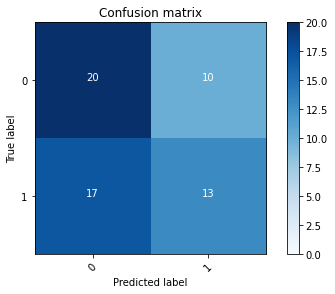

2022-02-17 12:07:54 - [Epoch Train: 16] loss: 0.4092, auc: 0.8980, acc: 0.7984, time: 62.00 s            
2022-02-17 12:07:54 - [Epoch Valid: 16] loss: 0.7229, auc: 0.6367, acc: 0.5500, time: 7.00 s


  5%|██▏                                     | 16/300 [18:43<5:31:40, 70.07s/it]

2022-02-17 12:07:54 - EPOCH: 17
2022-02-17 12:07:55 - Train Step 10/486, train_loss: 0.6669
2022-02-17 12:07:57 - Train Step 20/486, train_loss: 0.5035
2022-02-17 12:07:58 - Train Step 30/486, train_loss: 0.4394
2022-02-17 12:07:59 - Train Step 40/486, train_loss: 0.4044
2022-02-17 12:08:00 - Train Step 50/486, train_loss: 0.3728
2022-02-17 12:08:02 - Train Step 60/486, train_loss: 0.3549
2022-02-17 12:08:03 - Train Step 70/486, train_loss: 0.3660
2022-02-17 12:08:04 - Train Step 80/486, train_loss: 0.3683
2022-02-17 12:08:05 - Train Step 90/486, train_loss: 0.3919
2022-02-17 12:08:07 - Train Step 100/486, train_loss: 0.3871
2022-02-17 12:08:08 - Train Step 110/486, train_loss: 0.3793
2022-02-17 12:08:09 - Train Step 120/486, train_loss: 0.3709
2022-02-17 12:08:11 - Train Step 130/486, train_loss: 0.3766
2022-02-17 12:08:12 - Train Step 140/486, train_loss: 0.3779
2022-02-17 12:08:13 - Train Step 150/486, train_loss: 0.3768
2022-02-17 12:08:14 - Train Step 160/486, train_loss: 0.3766
2

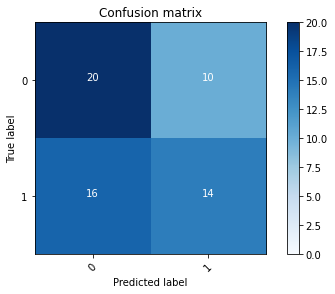

2022-02-17 12:09:04 - [Epoch Train: 17] loss: 0.3849, auc: 0.9181, acc: 0.8025, time: 62.00 s            
2022-02-17 12:09:04 - [Epoch Valid: 17] loss: 0.7959, auc: 0.6256, acc: 0.5667, time: 7.00 s


  6%|██▎                                     | 17/300 [19:52<5:30:21, 70.04s/it]

2022-02-17 12:09:04 - EPOCH: 18
2022-02-17 12:09:05 - Train Step 10/486, train_loss: 0.1408
2022-02-17 12:09:07 - Train Step 20/486, train_loss: 0.1997
2022-02-17 12:09:08 - Train Step 30/486, train_loss: 0.2393
2022-02-17 12:09:09 - Train Step 40/486, train_loss: 0.3495
2022-02-17 12:09:10 - Train Step 50/486, train_loss: 0.3760
2022-02-17 12:09:12 - Train Step 60/486, train_loss: 0.3850
2022-02-17 12:09:13 - Train Step 70/486, train_loss: 0.3546
2022-02-17 12:09:14 - Train Step 80/486, train_loss: 0.3313
2022-02-17 12:09:15 - Train Step 90/486, train_loss: 0.3463
2022-02-17 12:09:17 - Train Step 100/486, train_loss: 0.3333
2022-02-17 12:09:18 - Train Step 110/486, train_loss: 0.3476
2022-02-17 12:09:19 - Train Step 120/486, train_loss: 0.3679
2022-02-17 12:09:20 - Train Step 130/486, train_loss: 0.3806
2022-02-17 12:09:22 - Train Step 140/486, train_loss: 0.3803
2022-02-17 12:09:23 - Train Step 150/486, train_loss: 0.3841
2022-02-17 12:09:24 - Train Step 160/486, train_loss: 0.3852
2

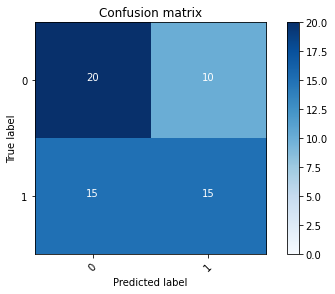

2022-02-17 12:10:14 - [Epoch Train: 18] loss: 0.3641, auc: 0.9278, acc: 0.7984, time: 61.00 s            
2022-02-17 12:10:14 - [Epoch Valid: 18] loss: 0.8185, auc: 0.6278, acc: 0.5833, time: 8.00 s


  6%|██▍                                     | 18/300 [21:02<5:28:50, 69.97s/it]

2022-02-17 12:10:14 - EPOCH: 19
2022-02-17 12:10:15 - Train Step 10/486, train_loss: 0.2378
2022-02-17 12:10:16 - Train Step 20/486, train_loss: 0.3383
2022-02-17 12:10:18 - Train Step 30/486, train_loss: 0.3436
2022-02-17 12:10:19 - Train Step 40/486, train_loss: 0.3120
2022-02-17 12:10:20 - Train Step 50/486, train_loss: 0.3207
2022-02-17 12:10:22 - Train Step 60/486, train_loss: 0.3039
2022-02-17 12:10:23 - Train Step 70/486, train_loss: 0.3233
2022-02-17 12:10:24 - Train Step 80/486, train_loss: 0.3416
2022-02-17 12:10:26 - Train Step 90/486, train_loss: 0.3474
2022-02-17 12:10:27 - Train Step 100/486, train_loss: 0.3417
2022-02-17 12:10:28 - Train Step 110/486, train_loss: 0.3460
2022-02-17 12:10:29 - Train Step 120/486, train_loss: 0.3324
2022-02-17 12:10:31 - Train Step 130/486, train_loss: 0.3236
2022-02-17 12:10:32 - Train Step 140/486, train_loss: 0.3270
2022-02-17 12:10:33 - Train Step 150/486, train_loss: 0.3170
2022-02-17 12:10:34 - Train Step 160/486, train_loss: 0.3197
2

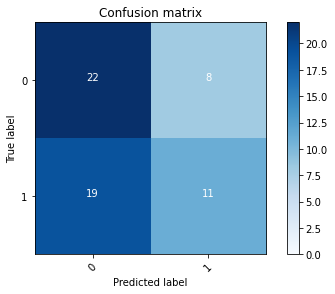

2022-02-17 12:11:24 - [Epoch Train: 19] loss: 0.3219, auc: 0.9402, acc: 0.8580, time: 62.00 s            
2022-02-17 12:11:24 - [Epoch Valid: 19] loss: 0.9460, auc: 0.6222, acc: 0.5500, time: 7.00 s


  6%|██▌                                     | 19/300 [22:13<5:28:40, 70.18s/it]

2022-02-17 12:11:24 - EPOCH: 20
2022-02-17 12:11:26 - Train Step 10/486, train_loss: 0.1465
2022-02-17 12:11:27 - Train Step 20/486, train_loss: 0.2218
2022-02-17 12:11:28 - Train Step 30/486, train_loss: 0.2353
2022-02-17 12:11:30 - Train Step 40/486, train_loss: 0.2326
2022-02-17 12:11:31 - Train Step 50/486, train_loss: 0.2731
2022-02-17 12:11:32 - Train Step 60/486, train_loss: 0.2644
2022-02-17 12:11:33 - Train Step 70/486, train_loss: 0.2520
2022-02-17 12:11:35 - Train Step 80/486, train_loss: 0.3134
2022-02-17 12:11:36 - Train Step 90/486, train_loss: 0.3102
2022-02-17 12:11:37 - Train Step 100/486, train_loss: 0.3399
2022-02-17 12:11:39 - Train Step 110/486, train_loss: 0.3462
2022-02-17 12:11:40 - Train Step 120/486, train_loss: 0.3556
2022-02-17 12:11:41 - Train Step 130/486, train_loss: 0.3484
2022-02-17 12:11:43 - Train Step 140/486, train_loss: 0.3330
2022-02-17 12:11:44 - Train Step 150/486, train_loss: 0.3266
2022-02-17 12:11:45 - Train Step 160/486, train_loss: 0.3191
2

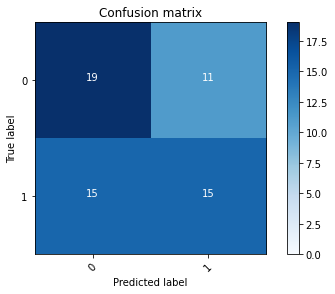

2022-02-17 12:12:37 - [Epoch Train: 20] loss: 0.3040, auc: 0.9505, acc: 0.8539, time: 64.00 s            
2022-02-17 12:12:37 - [Epoch Valid: 20] loss: 0.8833, auc: 0.6222, acc: 0.5667, time: 7.00 s


  7%|██▋                                     | 20/300 [23:26<5:30:56, 70.91s/it]

2022-02-17 12:12:37 - EPOCH: 21
2022-02-17 12:12:38 - Train Step 10/486, train_loss: 0.5189
2022-02-17 12:12:40 - Train Step 20/486, train_loss: 0.4448
2022-02-17 12:12:41 - Train Step 30/486, train_loss: 0.3928
2022-02-17 12:12:42 - Train Step 40/486, train_loss: 0.3451
2022-02-17 12:12:44 - Train Step 50/486, train_loss: 0.3227
2022-02-17 12:12:45 - Train Step 60/486, train_loss: 0.3143
2022-02-17 12:12:46 - Train Step 70/486, train_loss: 0.3273
2022-02-17 12:12:47 - Train Step 80/486, train_loss: 0.3038
2022-02-17 12:12:49 - Train Step 90/486, train_loss: 0.2921
2022-02-17 12:12:50 - Train Step 100/486, train_loss: 0.2969
2022-02-17 12:12:51 - Train Step 110/486, train_loss: 0.3103
2022-02-17 12:12:52 - Train Step 120/486, train_loss: 0.3075
2022-02-17 12:12:54 - Train Step 130/486, train_loss: 0.2987
2022-02-17 12:12:55 - Train Step 140/486, train_loss: 0.3009
2022-02-17 12:12:56 - Train Step 150/486, train_loss: 0.3061
2022-02-17 12:12:58 - Train Step 160/486, train_loss: 0.3017
2

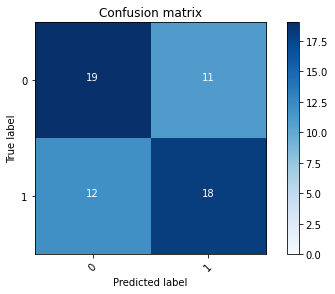

2022-02-17 12:13:48 - [Epoch Train: 21] loss: 0.2689, auc: 0.9663, acc: 0.8765, time: 62.00 s            
2022-02-17 12:13:48 - [Epoch Valid: 21] loss: 0.9228, auc: 0.6356, acc: 0.6167, time: 7.00 s


  7%|██▊                                     | 21/300 [24:36<5:29:21, 70.83s/it]

2022-02-17 12:13:48 - EPOCH: 22
2022-02-17 12:13:49 - Train Step 10/486, train_loss: 0.2402
2022-02-17 12:13:50 - Train Step 20/486, train_loss: 0.4315
2022-02-17 12:13:51 - Train Step 30/486, train_loss: 0.3496
2022-02-17 12:13:53 - Train Step 40/486, train_loss: 0.3104
2022-02-17 12:13:54 - Train Step 50/486, train_loss: 0.2917
2022-02-17 12:13:55 - Train Step 60/486, train_loss: 0.2836
2022-02-17 12:13:57 - Train Step 70/486, train_loss: 0.2759
2022-02-17 12:13:58 - Train Step 80/486, train_loss: 0.2760
2022-02-17 12:13:59 - Train Step 90/486, train_loss: 0.2572
2022-02-17 12:14:00 - Train Step 100/486, train_loss: 0.2738
2022-02-17 12:14:02 - Train Step 110/486, train_loss: 0.2813
2022-02-17 12:14:03 - Train Step 120/486, train_loss: 0.2799
2022-02-17 12:14:04 - Train Step 130/486, train_loss: 0.2768
2022-02-17 12:14:05 - Train Step 140/486, train_loss: 0.2797
2022-02-17 12:14:07 - Train Step 150/486, train_loss: 0.2894
2022-02-17 12:14:08 - Train Step 160/486, train_loss: 0.2896
2

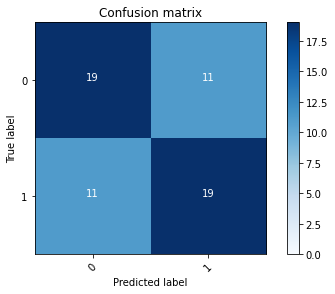

2022-02-17 12:14:59 - [Epoch Train: 22] loss: 0.2699, auc: 0.9598, acc: 0.8683, time: 63.00 s            
2022-02-17 12:14:59 - [Epoch Valid: 22] loss: 0.9123, auc: 0.6333, acc: 0.6333, time: 8.00 s
2022-02-17 12:14:59 - acc improved from 0.6333 to 0.6333. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e22-loss0.912-acc0.633-auc0.633.pth'


  7%|██▉                                     | 22/300 [25:48<5:29:33, 71.13s/it]

2022-02-17 12:14:59 - EPOCH: 23
2022-02-17 12:15:01 - Train Step 10/486, train_loss: 0.4417
2022-02-17 12:15:02 - Train Step 20/486, train_loss: 0.3278
2022-02-17 12:15:03 - Train Step 30/486, train_loss: 0.3004
2022-02-17 12:15:05 - Train Step 40/486, train_loss: 0.2839
2022-02-17 12:15:06 - Train Step 50/486, train_loss: 0.2666
2022-02-17 12:15:07 - Train Step 60/486, train_loss: 0.2454
2022-02-17 12:15:08 - Train Step 70/486, train_loss: 0.2403
2022-02-17 12:15:10 - Train Step 80/486, train_loss: 0.2225
2022-02-17 12:15:11 - Train Step 90/486, train_loss: 0.2276
2022-02-17 12:15:12 - Train Step 100/486, train_loss: 0.2271
2022-02-17 12:15:13 - Train Step 110/486, train_loss: 0.2228
2022-02-17 12:15:15 - Train Step 120/486, train_loss: 0.2304
2022-02-17 12:15:16 - Train Step 130/486, train_loss: 0.2186
2022-02-17 12:15:17 - Train Step 140/486, train_loss: 0.2138
2022-02-17 12:15:19 - Train Step 150/486, train_loss: 0.2309
2022-02-17 12:15:20 - Train Step 160/486, train_loss: 0.2389
2

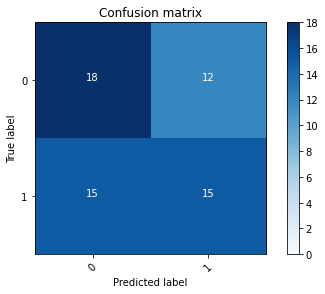

2022-02-17 12:16:09 - [Epoch Train: 23] loss: 0.2346, auc: 0.9738, acc: 0.8992, time: 61.00 s            
2022-02-17 12:16:09 - [Epoch Valid: 23] loss: 1.0642, auc: 0.6133, acc: 0.5500, time: 7.00 s


  8%|███                                     | 23/300 [26:58<5:26:24, 70.70s/it]

2022-02-17 12:16:09 - EPOCH: 24
2022-02-17 12:16:10 - Train Step 10/486, train_loss: 0.3738
2022-02-17 12:16:12 - Train Step 20/486, train_loss: 0.2377
2022-02-17 12:16:13 - Train Step 30/486, train_loss: 0.1766
2022-02-17 12:16:14 - Train Step 40/486, train_loss: 0.2532
2022-02-17 12:16:16 - Train Step 50/486, train_loss: 0.2419
2022-02-17 12:16:17 - Train Step 60/486, train_loss: 0.2272
2022-02-17 12:16:18 - Train Step 70/486, train_loss: 0.2173
2022-02-17 12:16:19 - Train Step 80/486, train_loss: 0.2215
2022-02-17 12:16:21 - Train Step 90/486, train_loss: 0.2064
2022-02-17 12:16:22 - Train Step 100/486, train_loss: 0.2008
2022-02-17 12:16:23 - Train Step 110/486, train_loss: 0.1965
2022-02-17 12:16:24 - Train Step 120/486, train_loss: 0.1938
2022-02-17 12:16:26 - Train Step 130/486, train_loss: 0.1915
2022-02-17 12:16:27 - Train Step 140/486, train_loss: 0.1891
2022-02-17 12:16:28 - Train Step 150/486, train_loss: 0.1969
2022-02-17 12:16:30 - Train Step 160/486, train_loss: 0.2211
2

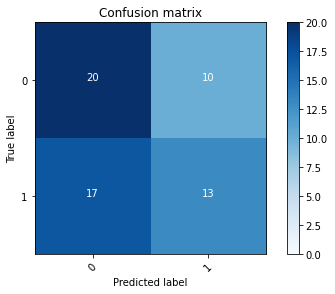

2022-02-17 12:17:19 - [Epoch Train: 24] loss: 0.2231, auc: 0.9739, acc: 0.8971, time: 62.00 s            
2022-02-17 12:17:19 - [Epoch Valid: 24] loss: 1.2191, auc: 0.6311, acc: 0.5500, time: 7.00 s


  8%|███▏                                    | 24/300 [28:08<5:24:33, 70.56s/it]

2022-02-17 12:17:19 - EPOCH: 25
2022-02-17 12:17:21 - Train Step 10/486, train_loss: 0.0611
2022-02-17 12:17:22 - Train Step 20/486, train_loss: 0.1534
2022-02-17 12:17:23 - Train Step 30/486, train_loss: 0.2016
2022-02-17 12:17:25 - Train Step 40/486, train_loss: 0.1876
2022-02-17 12:17:26 - Train Step 50/486, train_loss: 0.1854
2022-02-17 12:17:27 - Train Step 60/486, train_loss: 0.1885
2022-02-17 12:17:28 - Train Step 70/486, train_loss: 0.1815
2022-02-17 12:17:30 - Train Step 80/486, train_loss: 0.1855
2022-02-17 12:17:31 - Train Step 90/486, train_loss: 0.1708
2022-02-17 12:17:32 - Train Step 100/486, train_loss: 0.1814
2022-02-17 12:17:34 - Train Step 110/486, train_loss: 0.1895
2022-02-17 12:17:35 - Train Step 120/486, train_loss: 0.1861
2022-02-17 12:17:36 - Train Step 130/486, train_loss: 0.1847
2022-02-17 12:17:37 - Train Step 140/486, train_loss: 0.1844
2022-02-17 12:17:39 - Train Step 150/486, train_loss: 0.1927
2022-02-17 12:17:40 - Train Step 160/486, train_loss: 0.1890
2

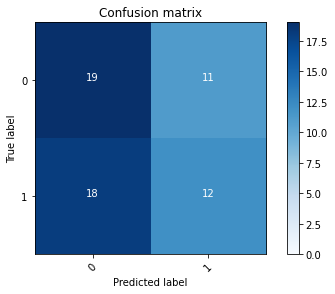

2022-02-17 12:18:29 - [Epoch Train: 25] loss: 0.2005, auc: 0.9780, acc: 0.9012, time: 61.00 s            
2022-02-17 12:18:29 - [Epoch Valid: 25] loss: 1.1691, auc: 0.6267, acc: 0.5167, time: 7.00 s


  8%|███▎                                    | 25/300 [29:18<5:22:02, 70.26s/it]

2022-02-17 12:18:29 - EPOCH: 26
2022-02-17 12:18:30 - Train Step 10/486, train_loss: 0.2277
2022-02-17 12:18:32 - Train Step 20/486, train_loss: 0.1752
2022-02-17 12:18:33 - Train Step 30/486, train_loss: 0.1562
2022-02-17 12:18:34 - Train Step 40/486, train_loss: 0.1425
2022-02-17 12:18:35 - Train Step 50/486, train_loss: 0.1560
2022-02-17 12:18:36 - Train Step 60/486, train_loss: 0.2161
2022-02-17 12:18:38 - Train Step 70/486, train_loss: 0.2256
2022-02-17 12:18:39 - Train Step 80/486, train_loss: 0.2082
2022-02-17 12:18:40 - Train Step 90/486, train_loss: 0.1983
2022-02-17 12:18:42 - Train Step 100/486, train_loss: 0.1890
2022-02-17 12:18:43 - Train Step 110/486, train_loss: 0.1901
2022-02-17 12:18:44 - Train Step 120/486, train_loss: 0.1790
2022-02-17 12:18:45 - Train Step 130/486, train_loss: 0.1846
2022-02-17 12:18:47 - Train Step 140/486, train_loss: 0.1856
2022-02-17 12:18:48 - Train Step 150/486, train_loss: 0.1757
2022-02-17 12:18:49 - Train Step 160/486, train_loss: 0.1740
2

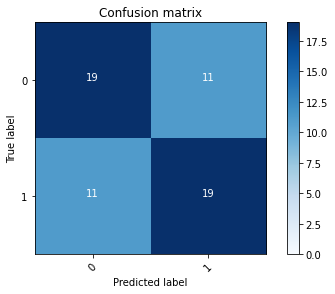

2022-02-17 12:19:39 - [Epoch Train: 26] loss: 0.1708, auc: 0.9845, acc: 0.9218, time: 62.00 s            
2022-02-17 12:19:39 - [Epoch Valid: 26] loss: 1.1700, auc: 0.6200, acc: 0.6333, time: 8.00 s
2022-02-17 12:19:39 - acc improved from 0.6333 to 0.6333. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e26-loss1.170-acc0.633-auc0.620.pth'


  9%|███▍                                    | 26/300 [30:28<5:21:14, 70.35s/it]

2022-02-17 12:19:39 - EPOCH: 27
2022-02-17 12:19:41 - Train Step 10/486, train_loss: 0.1009
2022-02-17 12:19:42 - Train Step 20/486, train_loss: 0.1027
2022-02-17 12:19:43 - Train Step 30/486, train_loss: 0.1227
2022-02-17 12:19:45 - Train Step 40/486, train_loss: 0.1057
2022-02-17 12:19:46 - Train Step 50/486, train_loss: 0.1011
2022-02-17 12:19:47 - Train Step 60/486, train_loss: 0.1017
2022-02-17 12:19:49 - Train Step 70/486, train_loss: 0.1064
2022-02-17 12:19:50 - Train Step 80/486, train_loss: 0.1088
2022-02-17 12:19:51 - Train Step 90/486, train_loss: 0.1029
2022-02-17 12:19:52 - Train Step 100/486, train_loss: 0.1046
2022-02-17 12:19:54 - Train Step 110/486, train_loss: 0.1115
2022-02-17 12:19:55 - Train Step 120/486, train_loss: 0.1098
2022-02-17 12:19:56 - Train Step 130/486, train_loss: 0.1038
2022-02-17 12:19:58 - Train Step 140/486, train_loss: 0.1045
2022-02-17 12:19:59 - Train Step 150/486, train_loss: 0.1061
2022-02-17 12:20:00 - Train Step 160/486, train_loss: 0.1122
2

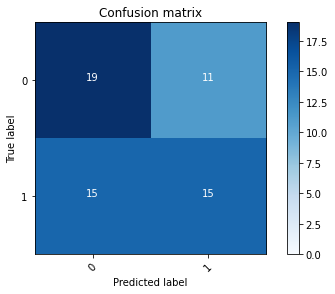

2022-02-17 12:20:51 - [Epoch Train: 27] loss: 0.1483, auc: 0.9890, acc: 0.9321, time: 63.00 s            
2022-02-17 12:20:51 - [Epoch Valid: 27] loss: 1.1924, auc: 0.6289, acc: 0.5667, time: 8.00 s


  9%|███▌                                    | 27/300 [31:40<5:21:46, 70.72s/it]

2022-02-17 12:20:51 - EPOCH: 28
2022-02-17 12:20:52 - Train Step 10/486, train_loss: 0.2329
2022-02-17 12:20:54 - Train Step 20/486, train_loss: 0.1524
2022-02-17 12:20:55 - Train Step 30/486, train_loss: 0.1376
2022-02-17 12:20:56 - Train Step 40/486, train_loss: 0.1199
2022-02-17 12:20:58 - Train Step 50/486, train_loss: 0.1167
2022-02-17 12:20:59 - Train Step 60/486, train_loss: 0.1212
2022-02-17 12:21:00 - Train Step 70/486, train_loss: 0.1550
2022-02-17 12:21:01 - Train Step 80/486, train_loss: 0.1446
2022-02-17 12:21:03 - Train Step 90/486, train_loss: 0.1487
2022-02-17 12:21:04 - Train Step 100/486, train_loss: 0.1508
2022-02-17 12:21:05 - Train Step 110/486, train_loss: 0.1439
2022-02-17 12:21:07 - Train Step 120/486, train_loss: 0.1351
2022-02-17 12:21:08 - Train Step 130/486, train_loss: 0.1435
2022-02-17 12:21:09 - Train Step 140/486, train_loss: 0.1383
2022-02-17 12:21:11 - Train Step 150/486, train_loss: 0.1380
2022-02-17 12:21:12 - Train Step 160/486, train_loss: 0.1332
2

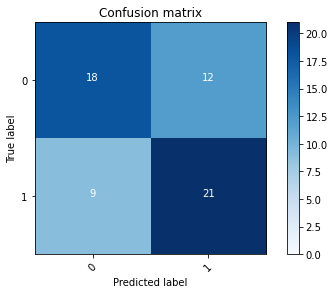

2022-02-17 12:22:04 - [Epoch Train: 28] loss: 0.1323, auc: 0.9921, acc: 0.9444, time: 64.00 s            
2022-02-17 12:22:04 - [Epoch Valid: 28] loss: 1.2608, auc: 0.6244, acc: 0.6500, time: 8.00 s
2022-02-17 12:22:04 - acc improved from 0.6333 to 0.6500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e28-loss1.261-acc0.650-auc0.624.pth'


  9%|███▋                                    | 28/300 [32:52<5:23:24, 71.34s/it]

2022-02-17 12:22:04 - EPOCH: 29
2022-02-17 12:22:05 - Train Step 10/486, train_loss: 0.0655
2022-02-17 12:22:07 - Train Step 20/486, train_loss: 0.0615
2022-02-17 12:22:08 - Train Step 30/486, train_loss: 0.0733
2022-02-17 12:22:09 - Train Step 40/486, train_loss: 0.0864
2022-02-17 12:22:10 - Train Step 50/486, train_loss: 0.0806
2022-02-17 12:22:12 - Train Step 60/486, train_loss: 0.0852
2022-02-17 12:22:13 - Train Step 70/486, train_loss: 0.0781
2022-02-17 12:22:15 - Train Step 80/486, train_loss: 0.1095
2022-02-17 12:22:16 - Train Step 90/486, train_loss: 0.1487
2022-02-17 12:22:17 - Train Step 100/486, train_loss: 0.1379
2022-02-17 12:22:19 - Train Step 110/486, train_loss: 0.1320
2022-02-17 12:22:20 - Train Step 120/486, train_loss: 0.1461
2022-02-17 12:22:21 - Train Step 130/486, train_loss: 0.1412
2022-02-17 12:22:23 - Train Step 140/486, train_loss: 0.1364
2022-02-17 12:22:24 - Train Step 150/486, train_loss: 0.1361
2022-02-17 12:22:25 - Train Step 160/486, train_loss: 0.1328
2

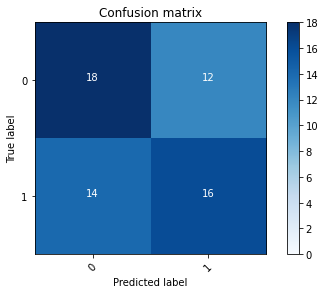

2022-02-17 12:23:15 - [Epoch Train: 29] loss: 0.1219, auc: 0.9933, acc: 0.9444, time: 63.00 s            
2022-02-17 12:23:15 - [Epoch Valid: 29] loss: 1.4413, auc: 0.6167, acc: 0.5667, time: 8.00 s


 10%|███▊                                    | 29/300 [34:04<5:22:00, 71.29s/it]

2022-02-17 12:23:15 - EPOCH: 30
2022-02-17 12:23:16 - Train Step 10/486, train_loss: 0.0292
2022-02-17 12:23:18 - Train Step 20/486, train_loss: 0.0589
2022-02-17 12:23:19 - Train Step 30/486, train_loss: 0.0583
2022-02-17 12:23:20 - Train Step 40/486, train_loss: 0.1032
2022-02-17 12:23:22 - Train Step 50/486, train_loss: 0.0988
2022-02-17 12:23:23 - Train Step 60/486, train_loss: 0.0854
2022-02-17 12:23:24 - Train Step 70/486, train_loss: 0.1029
2022-02-17 12:23:26 - Train Step 80/486, train_loss: 0.1088
2022-02-17 12:23:27 - Train Step 90/486, train_loss: 0.1001
2022-02-17 12:23:28 - Train Step 100/486, train_loss: 0.0988
2022-02-17 12:23:29 - Train Step 110/486, train_loss: 0.1014
2022-02-17 12:23:31 - Train Step 120/486, train_loss: 0.0986
2022-02-17 12:23:32 - Train Step 130/486, train_loss: 0.0949
2022-02-17 12:23:33 - Train Step 140/486, train_loss: 0.0957
2022-02-17 12:23:35 - Train Step 150/486, train_loss: 0.0920
2022-02-17 12:23:36 - Train Step 160/486, train_loss: 0.0966
2

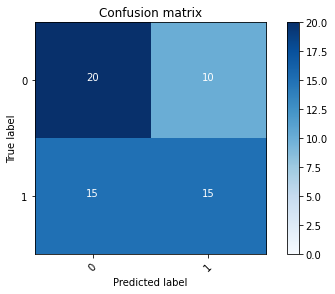

2022-02-17 12:24:27 - [Epoch Train: 30] loss: 0.1002, auc: 0.9944, acc: 0.9588, time: 64.00 s            
2022-02-17 12:24:27 - [Epoch Valid: 30] loss: 1.4435, auc: 0.5967, acc: 0.5833, time: 8.00 s


 10%|████                                    | 30/300 [35:16<5:21:54, 71.54s/it]

2022-02-17 12:24:27 - EPOCH: 31
2022-02-17 12:24:29 - Train Step 10/486, train_loss: 0.0951
2022-02-17 12:24:30 - Train Step 20/486, train_loss: 0.1004
2022-02-17 12:24:31 - Train Step 30/486, train_loss: 0.1102
2022-02-17 12:24:32 - Train Step 40/486, train_loss: 0.1500
2022-02-17 12:24:34 - Train Step 50/486, train_loss: 0.1306
2022-02-17 12:24:35 - Train Step 60/486, train_loss: 0.1210
2022-02-17 12:24:36 - Train Step 70/486, train_loss: 0.1303
2022-02-17 12:24:37 - Train Step 80/486, train_loss: 0.1310
2022-02-17 12:24:39 - Train Step 90/486, train_loss: 0.1241
2022-02-17 12:24:40 - Train Step 100/486, train_loss: 0.1181
2022-02-17 12:24:41 - Train Step 110/486, train_loss: 0.1341
2022-02-17 12:24:42 - Train Step 120/486, train_loss: 0.1300
2022-02-17 12:24:44 - Train Step 130/486, train_loss: 0.1261
2022-02-17 12:24:45 - Train Step 140/486, train_loss: 0.1301
2022-02-17 12:24:46 - Train Step 150/486, train_loss: 0.1359
2022-02-17 12:24:47 - Train Step 160/486, train_loss: 0.1439
2

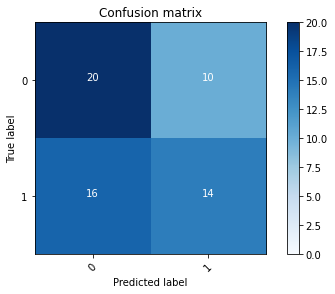

2022-02-17 12:25:37 - [Epoch Train: 31] loss: 0.1146, auc: 0.9936, acc: 0.9465, time: 62.00 s            
2022-02-17 12:25:37 - [Epoch Valid: 31] loss: 1.5093, auc: 0.6378, acc: 0.5667, time: 8.00 s


 10%|████▏                                   | 31/300 [36:26<5:18:58, 71.15s/it]

2022-02-17 12:25:37 - EPOCH: 32
2022-02-17 12:25:39 - Train Step 10/486, train_loss: 0.0495
2022-02-17 12:25:40 - Train Step 20/486, train_loss: 0.0697
2022-02-17 12:25:41 - Train Step 30/486, train_loss: 0.0768
2022-02-17 12:25:43 - Train Step 40/486, train_loss: 0.0647
2022-02-17 12:25:44 - Train Step 50/486, train_loss: 0.0764
2022-02-17 12:25:45 - Train Step 60/486, train_loss: 0.0814
2022-02-17 12:25:46 - Train Step 70/486, train_loss: 0.0819
2022-02-17 12:25:48 - Train Step 80/486, train_loss: 0.0827
2022-02-17 12:25:49 - Train Step 90/486, train_loss: 0.0757
2022-02-17 12:25:50 - Train Step 100/486, train_loss: 0.0843
2022-02-17 12:25:51 - Train Step 110/486, train_loss: 0.0857
2022-02-17 12:25:53 - Train Step 120/486, train_loss: 0.0836
2022-02-17 12:25:54 - Train Step 130/486, train_loss: 0.0819
2022-02-17 12:25:55 - Train Step 140/486, train_loss: 0.0817
2022-02-17 12:25:57 - Train Step 150/486, train_loss: 0.0782
2022-02-17 12:25:58 - Train Step 160/486, train_loss: 0.0753
2

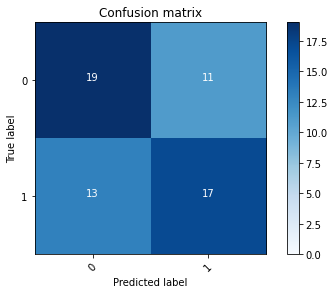

2022-02-17 12:26:48 - [Epoch Train: 32] loss: 0.0803, auc: 0.9970, acc: 0.9630, time: 62.00 s            
2022-02-17 12:26:48 - [Epoch Valid: 32] loss: 1.6966, auc: 0.6189, acc: 0.6000, time: 8.00 s


 11%|████▎                                   | 32/300 [37:36<5:16:33, 70.87s/it]

2022-02-17 12:26:48 - EPOCH: 33
2022-02-17 12:26:49 - Train Step 10/486, train_loss: 0.0299
2022-02-17 12:26:50 - Train Step 20/486, train_loss: 0.0275
2022-02-17 12:26:52 - Train Step 30/486, train_loss: 0.0944
2022-02-17 12:26:53 - Train Step 40/486, train_loss: 0.0805
2022-02-17 12:26:54 - Train Step 50/486, train_loss: 0.0809
2022-02-17 12:26:55 - Train Step 60/486, train_loss: 0.0769
2022-02-17 12:26:57 - Train Step 70/486, train_loss: 0.1008
2022-02-17 12:26:58 - Train Step 80/486, train_loss: 0.0969
2022-02-17 12:26:59 - Train Step 90/486, train_loss: 0.0966
2022-02-17 12:27:00 - Train Step 100/486, train_loss: 0.1121
2022-02-17 12:27:02 - Train Step 110/486, train_loss: 0.1113
2022-02-17 12:27:03 - Train Step 120/486, train_loss: 0.1061
2022-02-17 12:27:04 - Train Step 130/486, train_loss: 0.1002
2022-02-17 12:27:05 - Train Step 140/486, train_loss: 0.0978
2022-02-17 12:27:07 - Train Step 150/486, train_loss: 0.0940
2022-02-17 12:27:08 - Train Step 160/486, train_loss: 0.0888
2

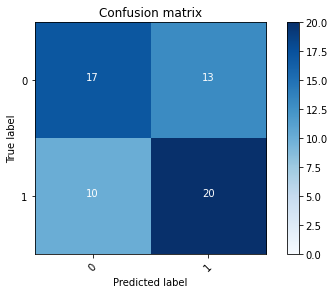

2022-02-17 12:27:59 - [Epoch Train: 33] loss: 0.0922, auc: 0.9952, acc: 0.9650, time: 63.00 s            
2022-02-17 12:27:59 - [Epoch Valid: 33] loss: 1.6772, auc: 0.6122, acc: 0.6167, time: 8.00 s


 11%|████▍                                   | 33/300 [38:48<5:16:04, 71.03s/it]

2022-02-17 12:27:59 - EPOCH: 34
2022-02-17 12:28:00 - Train Step 10/486, train_loss: 0.0700
2022-02-17 12:28:02 - Train Step 20/486, train_loss: 0.0523
2022-02-17 12:28:03 - Train Step 30/486, train_loss: 0.0654
2022-02-17 12:28:04 - Train Step 40/486, train_loss: 0.0842
2022-02-17 12:28:06 - Train Step 50/486, train_loss: 0.0879
2022-02-17 12:28:07 - Train Step 60/486, train_loss: 0.0784
2022-02-17 12:28:08 - Train Step 70/486, train_loss: 0.0741
2022-02-17 12:28:09 - Train Step 80/486, train_loss: 0.0823
2022-02-17 12:28:11 - Train Step 90/486, train_loss: 0.0772
2022-02-17 12:28:12 - Train Step 100/486, train_loss: 0.0746
2022-02-17 12:28:13 - Train Step 110/486, train_loss: 0.0732
2022-02-17 12:28:14 - Train Step 120/486, train_loss: 0.0679
2022-02-17 12:28:16 - Train Step 130/486, train_loss: 0.0649
2022-02-17 12:28:17 - Train Step 140/486, train_loss: 0.0614
2022-02-17 12:28:18 - Train Step 150/486, train_loss: 0.0581
2022-02-17 12:28:20 - Train Step 160/486, train_loss: 0.0580
2

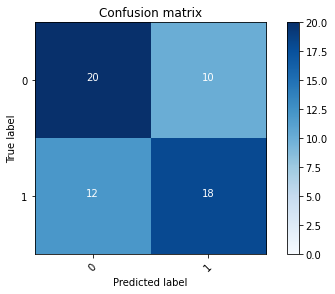

2022-02-17 12:29:11 - [Epoch Train: 34] loss: 0.0794, auc: 0.9974, acc: 0.9650, time: 63.00 s            
2022-02-17 12:29:11 - [Epoch Valid: 34] loss: 1.7777, auc: 0.6189, acc: 0.6333, time: 8.00 s


 11%|████▌                                   | 34/300 [40:00<5:16:14, 71.33s/it]

2022-02-17 12:29:11 - EPOCH: 35
2022-02-17 12:29:12 - Train Step 10/486, train_loss: 0.0253
2022-02-17 12:29:14 - Train Step 20/486, train_loss: 0.0298
2022-02-17 12:29:15 - Train Step 30/486, train_loss: 0.0568
2022-02-17 12:29:16 - Train Step 40/486, train_loss: 0.0483
2022-02-17 12:29:18 - Train Step 50/486, train_loss: 0.0452
2022-02-17 12:29:19 - Train Step 60/486, train_loss: 0.0474
2022-02-17 12:29:20 - Train Step 70/486, train_loss: 0.0450
2022-02-17 12:29:22 - Train Step 80/486, train_loss: 0.0414
2022-02-17 12:29:23 - Train Step 90/486, train_loss: 0.0380
2022-02-17 12:29:24 - Train Step 100/486, train_loss: 0.0351
2022-02-17 12:29:25 - Train Step 110/486, train_loss: 0.0342
2022-02-17 12:29:27 - Train Step 120/486, train_loss: 0.0361
2022-02-17 12:29:28 - Train Step 130/486, train_loss: 0.0347
2022-02-17 12:29:29 - Train Step 140/486, train_loss: 0.0331
2022-02-17 12:29:30 - Train Step 150/486, train_loss: 0.0361
2022-02-17 12:29:32 - Train Step 160/486, train_loss: 0.0378
2

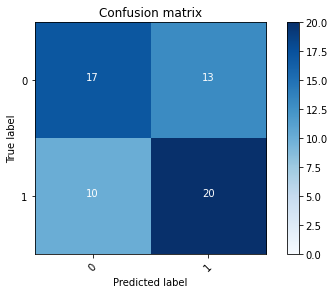

2022-02-17 12:30:21 - [Epoch Train: 35] loss: 0.0562, auc: 0.9976, acc: 0.9815, time: 61.00 s            
2022-02-17 12:30:21 - [Epoch Valid: 35] loss: 1.8882, auc: 0.6022, acc: 0.6167, time: 8.00 s


 12%|████▋                                   | 35/300 [41:10<5:13:18, 70.94s/it]

2022-02-17 12:30:21 - EPOCH: 36
2022-02-17 12:30:22 - Train Step 10/486, train_loss: 0.0056
2022-02-17 12:30:24 - Train Step 20/486, train_loss: 0.0222
2022-02-17 12:30:25 - Train Step 30/486, train_loss: 0.0610
2022-02-17 12:30:26 - Train Step 40/486, train_loss: 0.0508
2022-02-17 12:30:28 - Train Step 50/486, train_loss: 0.0523
2022-02-17 12:30:29 - Train Step 60/486, train_loss: 0.0441
2022-02-17 12:30:30 - Train Step 70/486, train_loss: 0.0412
2022-02-17 12:30:31 - Train Step 80/486, train_loss: 0.0398
2022-02-17 12:30:33 - Train Step 90/486, train_loss: 0.0366
2022-02-17 12:30:34 - Train Step 100/486, train_loss: 0.0342
2022-02-17 12:30:35 - Train Step 110/486, train_loss: 0.0325
2022-02-17 12:30:36 - Train Step 120/486, train_loss: 0.0320
2022-02-17 12:30:38 - Train Step 130/486, train_loss: 0.0373
2022-02-17 12:30:39 - Train Step 140/486, train_loss: 0.0447
2022-02-17 12:30:40 - Train Step 150/486, train_loss: 0.0502
2022-02-17 12:30:42 - Train Step 160/486, train_loss: 0.0476
2

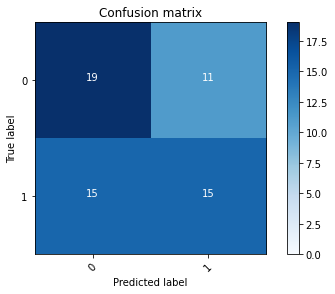

2022-02-17 12:31:31 - [Epoch Train: 36] loss: 0.0696, auc: 0.9984, acc: 0.9712, time: 62.00 s            
2022-02-17 12:31:31 - [Epoch Valid: 36] loss: 2.3001, auc: 0.6056, acc: 0.5667, time: 8.00 s


 12%|████▊                                   | 36/300 [42:20<5:11:19, 70.76s/it]

2022-02-17 12:31:31 - EPOCH: 37
2022-02-17 12:31:33 - Train Step 10/486, train_loss: 0.0163
2022-02-17 12:31:34 - Train Step 20/486, train_loss: 0.0594
2022-02-17 12:31:35 - Train Step 30/486, train_loss: 0.0400
2022-02-17 12:31:37 - Train Step 40/486, train_loss: 0.0402
2022-02-17 12:31:38 - Train Step 50/486, train_loss: 0.0989
2022-02-17 12:31:39 - Train Step 60/486, train_loss: 0.1060
2022-02-17 12:31:41 - Train Step 70/486, train_loss: 0.0924
2022-02-17 12:31:42 - Train Step 80/486, train_loss: 0.0847
2022-02-17 12:31:43 - Train Step 90/486, train_loss: 0.0783
2022-02-17 12:31:45 - Train Step 100/486, train_loss: 0.0825
2022-02-17 12:31:46 - Train Step 110/486, train_loss: 0.0779
2022-02-17 12:31:47 - Train Step 120/486, train_loss: 0.0776
2022-02-17 12:31:49 - Train Step 130/486, train_loss: 0.0798
2022-02-17 12:31:50 - Train Step 140/486, train_loss: 0.0765
2022-02-17 12:31:51 - Train Step 150/486, train_loss: 0.0823
2022-02-17 12:31:52 - Train Step 160/486, train_loss: 0.0826
2

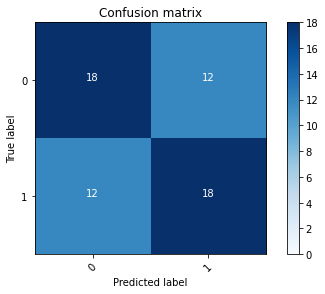

2022-02-17 12:32:44 - [Epoch Train: 37] loss: 0.0677, auc: 0.9979, acc: 0.9650, time: 63.00 s            
2022-02-17 12:32:44 - [Epoch Valid: 37] loss: 2.0881, auc: 0.5989, acc: 0.6000, time: 8.00 s


 12%|████▉                                   | 37/300 [43:32<5:12:01, 71.18s/it]

2022-02-17 12:32:44 - EPOCH: 38
2022-02-17 12:32:45 - Train Step 10/486, train_loss: 0.0121
2022-02-17 12:32:46 - Train Step 20/486, train_loss: 0.0091
2022-02-17 12:32:47 - Train Step 30/486, train_loss: 0.0109
2022-02-17 12:32:49 - Train Step 40/486, train_loss: 0.0095
2022-02-17 12:32:50 - Train Step 50/486, train_loss: 0.0125
2022-02-17 12:32:51 - Train Step 60/486, train_loss: 0.0200
2022-02-17 12:32:52 - Train Step 70/486, train_loss: 0.0194
2022-02-17 12:32:54 - Train Step 80/486, train_loss: 0.0250
2022-02-17 12:32:55 - Train Step 90/486, train_loss: 0.0265
2022-02-17 12:32:56 - Train Step 100/486, train_loss: 0.0250
2022-02-17 12:32:57 - Train Step 110/486, train_loss: 0.0276
2022-02-17 12:32:58 - Train Step 120/486, train_loss: 0.0396
2022-02-17 12:33:00 - Train Step 130/486, train_loss: 0.0407
2022-02-17 12:33:01 - Train Step 140/486, train_loss: 0.0380
2022-02-17 12:33:02 - Train Step 150/486, train_loss: 0.0368
2022-02-17 12:33:04 - Train Step 160/486, train_loss: 0.0437
2

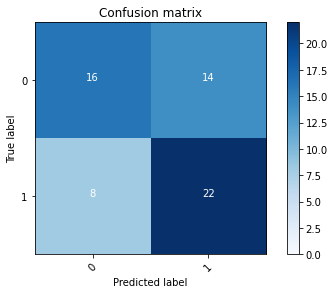

2022-02-17 12:33:53 - [Epoch Train: 38] loss: 0.0739, auc: 0.9972, acc: 0.9650, time: 62.00 s            
2022-02-17 12:33:53 - [Epoch Valid: 38] loss: 1.8197, auc: 0.6011, acc: 0.6333, time: 7.00 s


 13%|█████                                   | 38/300 [44:42<5:09:11, 70.81s/it]

2022-02-17 12:33:53 - EPOCH: 39
2022-02-17 12:33:55 - Train Step 10/486, train_loss: 0.0643
2022-02-17 12:33:56 - Train Step 20/486, train_loss: 0.0574
2022-02-17 12:33:58 - Train Step 30/486, train_loss: 0.0407
2022-02-17 12:33:59 - Train Step 40/486, train_loss: 0.0334
2022-02-17 12:34:00 - Train Step 50/486, train_loss: 0.0272
2022-02-17 12:34:01 - Train Step 60/486, train_loss: 0.0232
2022-02-17 12:34:03 - Train Step 70/486, train_loss: 0.0352
2022-02-17 12:34:04 - Train Step 80/486, train_loss: 0.0420
2022-02-17 12:34:05 - Train Step 90/486, train_loss: 0.0377
2022-02-17 12:34:07 - Train Step 100/486, train_loss: 0.0355
2022-02-17 12:34:08 - Train Step 110/486, train_loss: 0.0396
2022-02-17 12:34:10 - Train Step 120/486, train_loss: 0.0370
2022-02-17 12:34:11 - Train Step 130/486, train_loss: 0.0360
2022-02-17 12:34:12 - Train Step 140/486, train_loss: 0.0351
2022-02-17 12:34:14 - Train Step 150/486, train_loss: 0.0340
2022-02-17 12:34:15 - Train Step 160/486, train_loss: 0.0335
2

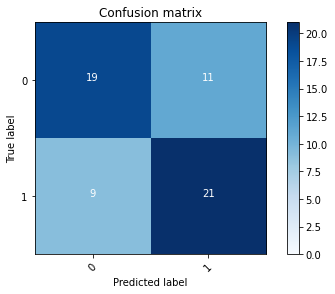

2022-02-17 12:35:06 - [Epoch Train: 39] loss: 0.0409, auc: 0.9997, acc: 0.9856, time: 64.00 s            
2022-02-17 12:35:06 - [Epoch Valid: 39] loss: 2.1463, auc: 0.6244, acc: 0.6667, time: 7.00 s
2022-02-17 12:35:06 - acc improved from 0.6500 to 0.6667. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e39-loss2.146-acc0.667-auc0.624.pth'


 13%|█████▏                                  | 39/300 [45:54<5:09:40, 71.19s/it]

2022-02-17 12:35:06 - EPOCH: 40
2022-02-17 12:35:07 - Train Step 10/486, train_loss: 0.0421
2022-02-17 12:35:08 - Train Step 20/486, train_loss: 0.0364
2022-02-17 12:35:09 - Train Step 30/486, train_loss: 0.0384
2022-02-17 12:35:11 - Train Step 40/486, train_loss: 0.0316
2022-02-17 12:35:12 - Train Step 50/486, train_loss: 0.0270
2022-02-17 12:35:13 - Train Step 60/486, train_loss: 0.0233
2022-02-17 12:35:15 - Train Step 70/486, train_loss: 0.0292
2022-02-17 12:35:16 - Train Step 80/486, train_loss: 0.0311
2022-02-17 12:35:17 - Train Step 90/486, train_loss: 0.0442
2022-02-17 12:35:18 - Train Step 100/486, train_loss: 0.0403
2022-02-17 12:35:20 - Train Step 110/486, train_loss: 0.0369
2022-02-17 12:35:21 - Train Step 120/486, train_loss: 0.0348
2022-02-17 12:35:22 - Train Step 130/486, train_loss: 0.0330
2022-02-17 12:35:23 - Train Step 140/486, train_loss: 0.0326
2022-02-17 12:35:25 - Train Step 150/486, train_loss: 0.0345
2022-02-17 12:35:26 - Train Step 160/486, train_loss: 0.0329
2

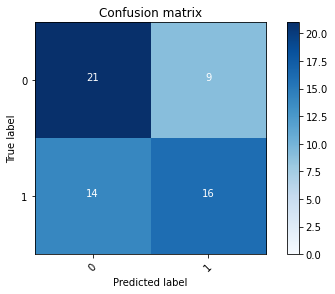

2022-02-17 12:36:16 - [Epoch Train: 40] loss: 0.0397, auc: 0.9997, acc: 0.9815, time: 62.00 s            
2022-02-17 12:36:16 - [Epoch Valid: 40] loss: 2.5325, auc: 0.6222, acc: 0.6167, time: 8.00 s


 13%|█████▎                                  | 40/300 [47:04<5:07:12, 70.89s/it]

2022-02-17 12:36:16 - EPOCH: 41
2022-02-17 12:36:17 - Train Step 10/486, train_loss: 0.0191
2022-02-17 12:36:18 - Train Step 20/486, train_loss: 0.0178
2022-02-17 12:36:20 - Train Step 30/486, train_loss: 0.0205
2022-02-17 12:36:21 - Train Step 40/486, train_loss: 0.0179
2022-02-17 12:36:22 - Train Step 50/486, train_loss: 0.0152
2022-02-17 12:36:23 - Train Step 60/486, train_loss: 0.0433
2022-02-17 12:36:25 - Train Step 70/486, train_loss: 0.0373
2022-02-17 12:36:26 - Train Step 80/486, train_loss: 0.0418
2022-02-17 12:36:27 - Train Step 90/486, train_loss: 0.0388
2022-02-17 12:36:29 - Train Step 100/486, train_loss: 0.0409
2022-02-17 12:36:30 - Train Step 110/486, train_loss: 0.0385
2022-02-17 12:36:31 - Train Step 120/486, train_loss: 0.0395
2022-02-17 12:36:32 - Train Step 130/486, train_loss: 0.0547
2022-02-17 12:36:34 - Train Step 140/486, train_loss: 0.0517
2022-02-17 12:36:35 - Train Step 150/486, train_loss: 0.0519
2022-02-17 12:36:36 - Train Step 160/486, train_loss: 0.0515
2

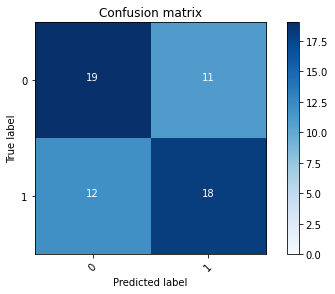

2022-02-17 12:37:26 - [Epoch Train: 41] loss: 0.0456, auc: 0.9993, acc: 0.9815, time: 61.00 s            
2022-02-17 12:37:26 - [Epoch Valid: 41] loss: 1.9707, auc: 0.6267, acc: 0.6167, time: 8.00 s


 14%|█████▍                                  | 41/300 [48:15<5:05:05, 70.68s/it]

2022-02-17 12:37:26 - EPOCH: 42
2022-02-17 12:37:27 - Train Step 10/486, train_loss: 0.0161
2022-02-17 12:37:29 - Train Step 20/486, train_loss: 0.0562
2022-02-17 12:37:30 - Train Step 30/486, train_loss: 0.0500
2022-02-17 12:37:31 - Train Step 40/486, train_loss: 0.0604
2022-02-17 12:37:33 - Train Step 50/486, train_loss: 0.0664
2022-02-17 12:37:34 - Train Step 60/486, train_loss: 0.0671
2022-02-17 12:37:35 - Train Step 70/486, train_loss: 0.0590
2022-02-17 12:37:37 - Train Step 80/486, train_loss: 0.0537
2022-02-17 12:37:38 - Train Step 90/486, train_loss: 0.0507
2022-02-17 12:37:39 - Train Step 100/486, train_loss: 0.0488
2022-02-17 12:37:41 - Train Step 110/486, train_loss: 0.0526
2022-02-17 12:37:42 - Train Step 120/486, train_loss: 0.0490
2022-02-17 12:37:43 - Train Step 130/486, train_loss: 0.0453
2022-02-17 12:37:44 - Train Step 140/486, train_loss: 0.0584
2022-02-17 12:37:46 - Train Step 150/486, train_loss: 0.0579
2022-02-17 12:37:47 - Train Step 160/486, train_loss: 0.0544
2

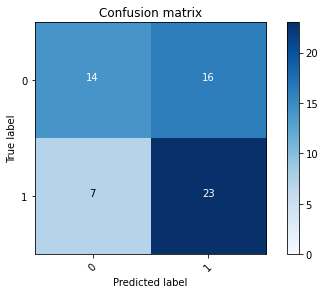

2022-02-17 12:38:37 - [Epoch Train: 42] loss: 0.0538, auc: 0.9989, acc: 0.9774, time: 62.00 s            
2022-02-17 12:38:37 - [Epoch Valid: 42] loss: 2.0142, auc: 0.6244, acc: 0.6167, time: 7.00 s


 14%|█████▌                                  | 42/300 [49:26<5:04:15, 70.76s/it]

2022-02-17 12:38:37 - EPOCH: 43
2022-02-17 12:38:38 - Train Step 10/486, train_loss: 0.0091
2022-02-17 12:38:40 - Train Step 20/486, train_loss: 0.1579
2022-02-17 12:38:41 - Train Step 30/486, train_loss: 0.1124
2022-02-17 12:38:42 - Train Step 40/486, train_loss: 0.1024
2022-02-17 12:38:43 - Train Step 50/486, train_loss: 0.0849
2022-02-17 12:38:45 - Train Step 60/486, train_loss: 0.0770
2022-02-17 12:38:46 - Train Step 70/486, train_loss: 0.0688
2022-02-17 12:38:47 - Train Step 80/486, train_loss: 0.0637
2022-02-17 12:38:49 - Train Step 90/486, train_loss: 0.0608
2022-02-17 12:38:50 - Train Step 100/486, train_loss: 0.0602
2022-02-17 12:38:51 - Train Step 110/486, train_loss: 0.0662
2022-02-17 12:38:52 - Train Step 120/486, train_loss: 0.0636
2022-02-17 12:38:54 - Train Step 130/486, train_loss: 0.0620
2022-02-17 12:38:55 - Train Step 140/486, train_loss: 0.0603
2022-02-17 12:38:56 - Train Step 150/486, train_loss: 0.0599
2022-02-17 12:38:58 - Train Step 160/486, train_loss: 0.0604
2

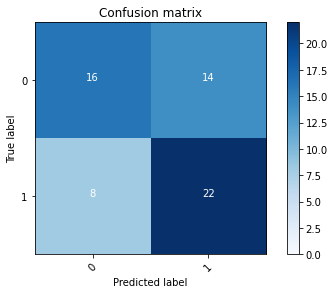

2022-02-17 12:39:47 - [Epoch Train: 43] loss: 0.0384, auc: 0.9994, acc: 0.9856, time: 62.00 s            
2022-02-17 12:39:47 - [Epoch Valid: 43] loss: 2.0451, auc: 0.6067, acc: 0.6333, time: 8.00 s


 14%|█████▋                                  | 43/300 [50:36<5:02:49, 70.70s/it]

2022-02-17 12:39:47 - EPOCH: 44
2022-02-17 12:39:49 - Train Step 10/486, train_loss: 0.0999
2022-02-17 12:39:50 - Train Step 20/486, train_loss: 0.0788
2022-02-17 12:39:51 - Train Step 30/486, train_loss: 0.0628
2022-02-17 12:39:53 - Train Step 40/486, train_loss: 0.0943
2022-02-17 12:39:54 - Train Step 50/486, train_loss: 0.0770
2022-02-17 12:39:55 - Train Step 60/486, train_loss: 0.1038
2022-02-17 12:39:56 - Train Step 70/486, train_loss: 0.0914
2022-02-17 12:39:58 - Train Step 80/486, train_loss: 0.0905
2022-02-17 12:39:59 - Train Step 90/486, train_loss: 0.0841
2022-02-17 12:40:00 - Train Step 100/486, train_loss: 0.0810
2022-02-17 12:40:02 - Train Step 110/486, train_loss: 0.0805
2022-02-17 12:40:03 - Train Step 120/486, train_loss: 0.0759
2022-02-17 12:40:04 - Train Step 130/486, train_loss: 0.0724
2022-02-17 12:40:06 - Train Step 140/486, train_loss: 0.0704
2022-02-17 12:40:07 - Train Step 150/486, train_loss: 0.0681
2022-02-17 12:40:08 - Train Step 160/486, train_loss: 0.0671
2

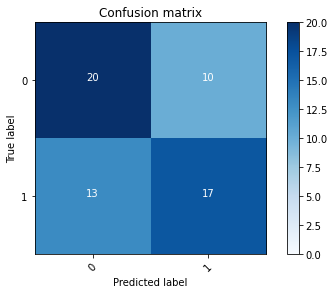

2022-02-17 12:40:59 - [Epoch Train: 44] loss: 0.0564, auc: 0.9984, acc: 0.9733, time: 63.00 s            
2022-02-17 12:40:59 - [Epoch Valid: 44] loss: 2.2273, auc: 0.6300, acc: 0.6167, time: 8.00 s


 15%|█████▊                                  | 44/300 [51:48<5:02:49, 70.98s/it]

2022-02-17 12:40:59 - EPOCH: 45
2022-02-17 12:41:00 - Train Step 10/486, train_loss: 0.0065
2022-02-17 12:41:02 - Train Step 20/486, train_loss: 0.0187
2022-02-17 12:41:03 - Train Step 30/486, train_loss: 0.0180
2022-02-17 12:41:04 - Train Step 40/486, train_loss: 0.0283
2022-02-17 12:41:06 - Train Step 50/486, train_loss: 0.0333
2022-02-17 12:41:07 - Train Step 60/486, train_loss: 0.0352
2022-02-17 12:41:09 - Train Step 70/486, train_loss: 0.0330
2022-02-17 12:41:10 - Train Step 80/486, train_loss: 0.0316
2022-02-17 12:41:11 - Train Step 90/486, train_loss: 0.0291
2022-02-17 12:41:12 - Train Step 100/486, train_loss: 0.0271
2022-02-17 12:41:14 - Train Step 110/486, train_loss: 0.0249
2022-02-17 12:41:15 - Train Step 120/486, train_loss: 0.0232
2022-02-17 12:41:16 - Train Step 130/486, train_loss: 0.0228
2022-02-17 12:41:18 - Train Step 140/486, train_loss: 0.0297
2022-02-17 12:41:19 - Train Step 150/486, train_loss: 0.0279
2022-02-17 12:41:20 - Train Step 160/486, train_loss: 0.0266
2

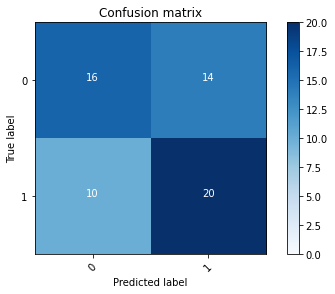

2022-02-17 12:42:10 - [Epoch Train: 45] loss: 0.0245, auc: 0.9998, acc: 0.9877, time: 62.00 s            
2022-02-17 12:42:10 - [Epoch Valid: 45] loss: 2.3613, auc: 0.6267, acc: 0.6000, time: 8.00 s


 15%|██████                                  | 45/300 [52:59<5:01:45, 71.00s/it]

2022-02-17 12:42:10 - EPOCH: 46
2022-02-17 12:42:12 - Train Step 10/486, train_loss: 0.0072
2022-02-17 12:42:13 - Train Step 20/486, train_loss: 0.0057
2022-02-17 12:42:14 - Train Step 30/486, train_loss: 0.0219
2022-02-17 12:42:15 - Train Step 40/486, train_loss: 0.0180
2022-02-17 12:42:17 - Train Step 50/486, train_loss: 0.0155
2022-02-17 12:42:18 - Train Step 60/486, train_loss: 0.0152
2022-02-17 12:42:19 - Train Step 70/486, train_loss: 0.0136
2022-02-17 12:42:21 - Train Step 80/486, train_loss: 0.0124
2022-02-17 12:42:22 - Train Step 90/486, train_loss: 0.0136
2022-02-17 12:42:23 - Train Step 100/486, train_loss: 0.0131
2022-02-17 12:42:24 - Train Step 110/486, train_loss: 0.0155
2022-02-17 12:42:26 - Train Step 120/486, train_loss: 0.0154
2022-02-17 12:42:27 - Train Step 130/486, train_loss: 0.0148
2022-02-17 12:42:28 - Train Step 140/486, train_loss: 0.0141
2022-02-17 12:42:29 - Train Step 150/486, train_loss: 0.0132
2022-02-17 12:42:31 - Train Step 160/486, train_loss: 0.0124
2

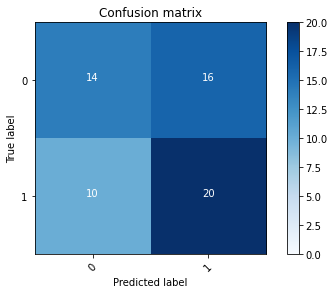

2022-02-17 12:43:20 - [Epoch Train: 46] loss: 0.0297, auc: 0.9997, acc: 0.9877, time: 62.00 s            
2022-02-17 12:43:20 - [Epoch Valid: 46] loss: 2.3169, auc: 0.6067, acc: 0.5667, time: 8.00 s


 15%|██████▏                                 | 46/300 [54:09<4:59:29, 70.75s/it]

2022-02-17 12:43:20 - EPOCH: 47
2022-02-17 12:43:22 - Train Step 10/486, train_loss: 0.0236
2022-02-17 12:43:23 - Train Step 20/486, train_loss: 0.0386
2022-02-17 12:43:24 - Train Step 30/486, train_loss: 0.0595
2022-02-17 12:43:26 - Train Step 40/486, train_loss: 0.0451
2022-02-17 12:43:27 - Train Step 50/486, train_loss: 0.0479
2022-02-17 12:43:28 - Train Step 60/486, train_loss: 0.0480
2022-02-17 12:43:29 - Train Step 70/486, train_loss: 0.0571
2022-02-17 12:43:31 - Train Step 80/486, train_loss: 0.0537
2022-02-17 12:43:32 - Train Step 90/486, train_loss: 0.0608
2022-02-17 12:43:33 - Train Step 100/486, train_loss: 0.0563
2022-02-17 12:43:35 - Train Step 110/486, train_loss: 0.0544
2022-02-17 12:43:36 - Train Step 120/486, train_loss: 0.0505
2022-02-17 12:43:37 - Train Step 130/486, train_loss: 0.0485
2022-02-17 12:43:38 - Train Step 140/486, train_loss: 0.0472
2022-02-17 12:43:40 - Train Step 150/486, train_loss: 0.0453
2022-02-17 12:43:41 - Train Step 160/486, train_loss: 0.0432
2

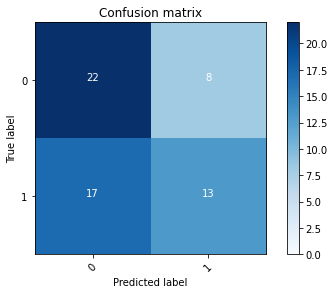

2022-02-17 12:44:31 - [Epoch Train: 47] loss: 0.0330, auc: 0.9997, acc: 0.9856, time: 62.00 s            
2022-02-17 12:44:31 - [Epoch Valid: 47] loss: 2.5653, auc: 0.6400, acc: 0.5833, time: 8.00 s


 16%|██████▎                                 | 47/300 [55:20<4:58:20, 70.75s/it]

2022-02-17 12:44:31 - EPOCH: 48
2022-02-17 12:44:32 - Train Step 10/486, train_loss: 0.0148
2022-02-17 12:44:34 - Train Step 20/486, train_loss: 0.0128
2022-02-17 12:44:35 - Train Step 30/486, train_loss: 0.0208
2022-02-17 12:44:36 - Train Step 40/486, train_loss: 0.0278
2022-02-17 12:44:38 - Train Step 50/486, train_loss: 0.0237
2022-02-17 12:44:39 - Train Step 60/486, train_loss: 0.0211
2022-02-17 12:44:40 - Train Step 70/486, train_loss: 0.0192
2022-02-17 12:44:41 - Train Step 80/486, train_loss: 0.0188
2022-02-17 12:44:43 - Train Step 90/486, train_loss: 0.0173
2022-02-17 12:44:44 - Train Step 100/486, train_loss: 0.0157
2022-02-17 12:44:45 - Train Step 110/486, train_loss: 0.0144
2022-02-17 12:44:47 - Train Step 120/486, train_loss: 0.0143
2022-02-17 12:44:48 - Train Step 130/486, train_loss: 0.0146
2022-02-17 12:44:49 - Train Step 140/486, train_loss: 0.0170
2022-02-17 12:44:50 - Train Step 150/486, train_loss: 0.0160
2022-02-17 12:44:52 - Train Step 160/486, train_loss: 0.0179
2

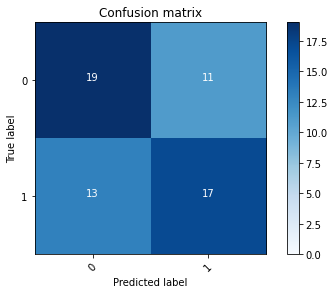

2022-02-17 12:45:42 - [Epoch Train: 48] loss: 0.0163, auc: 1.0000, acc: 0.9979, time: 62.00 s            
2022-02-17 12:45:42 - [Epoch Valid: 48] loss: 2.4233, auc: 0.6422, acc: 0.6000, time: 8.00 s


 16%|██████▍                                 | 48/300 [56:30<4:57:11, 70.76s/it]

2022-02-17 12:45:42 - EPOCH: 49
2022-02-17 12:45:43 - Train Step 10/486, train_loss: 0.0284
2022-02-17 12:45:44 - Train Step 20/486, train_loss: 0.0169
2022-02-17 12:45:46 - Train Step 30/486, train_loss: 0.0440
2022-02-17 12:45:47 - Train Step 40/486, train_loss: 0.0350
2022-02-17 12:45:48 - Train Step 50/486, train_loss: 0.0281
2022-02-17 12:45:50 - Train Step 60/486, train_loss: 0.0248
2022-02-17 12:45:51 - Train Step 70/486, train_loss: 0.0213
2022-02-17 12:45:52 - Train Step 80/486, train_loss: 0.0243
2022-02-17 12:45:53 - Train Step 90/486, train_loss: 0.0329
2022-02-17 12:45:55 - Train Step 100/486, train_loss: 0.0304
2022-02-17 12:45:56 - Train Step 110/486, train_loss: 0.0283
2022-02-17 12:45:57 - Train Step 120/486, train_loss: 0.0280
2022-02-17 12:45:58 - Train Step 130/486, train_loss: 0.0266
2022-02-17 12:46:00 - Train Step 140/486, train_loss: 0.0249
2022-02-17 12:46:01 - Train Step 150/486, train_loss: 0.0241
2022-02-17 12:46:02 - Train Step 160/486, train_loss: 0.0239
2

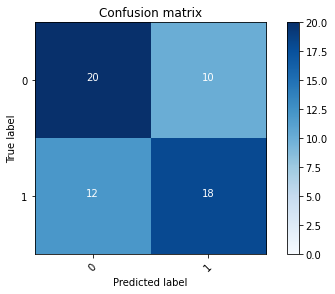

2022-02-17 12:46:52 - [Epoch Train: 49] loss: 0.0391, auc: 0.9997, acc: 0.9877, time: 61.00 s            
2022-02-17 12:46:52 - [Epoch Valid: 49] loss: 2.8187, auc: 0.6300, acc: 0.6333, time: 8.00 s


 16%|██████▌                                 | 49/300 [57:40<4:54:58, 70.51s/it]

2022-02-17 12:46:52 - EPOCH: 50
2022-02-17 12:46:53 - Train Step 10/486, train_loss: 0.0117
2022-02-17 12:46:54 - Train Step 20/486, train_loss: 0.0065
2022-02-17 12:46:56 - Train Step 30/486, train_loss: 0.0110
2022-02-17 12:46:57 - Train Step 40/486, train_loss: 0.0084
2022-02-17 12:46:58 - Train Step 50/486, train_loss: 0.0096
2022-02-17 12:47:00 - Train Step 60/486, train_loss: 0.0091
2022-02-17 12:47:01 - Train Step 70/486, train_loss: 0.0154
2022-02-17 12:47:02 - Train Step 80/486, train_loss: 0.0147
2022-02-17 12:47:03 - Train Step 90/486, train_loss: 0.0356
2022-02-17 12:47:05 - Train Step 100/486, train_loss: 0.0321
2022-02-17 12:47:06 - Train Step 110/486, train_loss: 0.0316
2022-02-17 12:47:07 - Train Step 120/486, train_loss: 0.0541
2022-02-17 12:47:09 - Train Step 130/486, train_loss: 0.0500
2022-02-17 12:47:10 - Train Step 140/486, train_loss: 0.0467
2022-02-17 12:47:11 - Train Step 150/486, train_loss: 0.0438
2022-02-17 12:47:12 - Train Step 160/486, train_loss: 0.0528
2

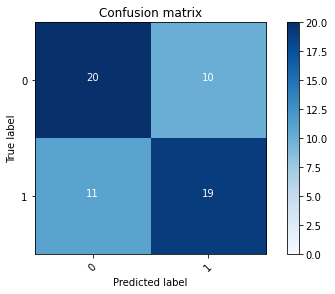

2022-02-17 12:48:03 - [Epoch Train: 50] loss: 0.0525, auc: 0.9986, acc: 0.9815, time: 62.00 s            
2022-02-17 12:48:03 - [Epoch Valid: 50] loss: 2.2974, auc: 0.6544, acc: 0.6500, time: 8.00 s


 17%|██████▋                                 | 50/300 [58:51<4:54:08, 70.60s/it]

2022-02-17 12:48:03 - EPOCH: 51
2022-02-17 12:48:04 - Train Step 10/486, train_loss: 0.0442
2022-02-17 12:48:05 - Train Step 20/486, train_loss: 0.0258
2022-02-17 12:48:06 - Train Step 30/486, train_loss: 0.0196
2022-02-17 12:48:08 - Train Step 40/486, train_loss: 0.0219
2022-02-17 12:48:09 - Train Step 50/486, train_loss: 0.0176
2022-02-17 12:48:10 - Train Step 60/486, train_loss: 0.0153
2022-02-17 12:48:12 - Train Step 70/486, train_loss: 0.0143
2022-02-17 12:48:13 - Train Step 80/486, train_loss: 0.0126
2022-02-17 12:48:14 - Train Step 90/486, train_loss: 0.0122
2022-02-17 12:48:16 - Train Step 100/486, train_loss: 0.0112
2022-02-17 12:48:17 - Train Step 110/486, train_loss: 0.0106
2022-02-17 12:48:18 - Train Step 120/486, train_loss: 0.0113
2022-02-17 12:48:20 - Train Step 130/486, train_loss: 0.0124
2022-02-17 12:48:21 - Train Step 140/486, train_loss: 0.0121
2022-02-17 12:48:22 - Train Step 150/486, train_loss: 0.0142
2022-02-17 12:48:24 - Train Step 160/486, train_loss: 0.0136
2

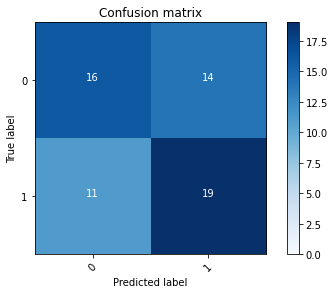

2022-02-17 12:49:14 - [Epoch Train: 51] loss: 0.0160, auc: 1.0000, acc: 0.9938, time: 63.00 s            
2022-02-17 12:49:14 - [Epoch Valid: 51] loss: 2.5031, auc: 0.6211, acc: 0.5833, time: 7.00 s


 17%|██████▍                               | 51/300 [1:00:02<4:53:41, 70.77s/it]

2022-02-17 12:49:14 - EPOCH: 52
2022-02-17 12:49:15 - Train Step 10/486, train_loss: 0.0120
2022-02-17 12:49:16 - Train Step 20/486, train_loss: 0.0857
2022-02-17 12:49:18 - Train Step 30/486, train_loss: 0.0630
2022-02-17 12:49:19 - Train Step 40/486, train_loss: 0.0486
2022-02-17 12:49:20 - Train Step 50/486, train_loss: 0.0654
2022-02-17 12:49:22 - Train Step 60/486, train_loss: 0.0576
2022-02-17 12:49:23 - Train Step 70/486, train_loss: 0.0515
2022-02-17 12:49:24 - Train Step 80/486, train_loss: 0.0515
2022-02-17 12:49:25 - Train Step 90/486, train_loss: 0.0464
2022-02-17 12:49:27 - Train Step 100/486, train_loss: 0.0435
2022-02-17 12:49:28 - Train Step 110/486, train_loss: 0.0399
2022-02-17 12:49:29 - Train Step 120/486, train_loss: 0.0369
2022-02-17 12:49:31 - Train Step 130/486, train_loss: 0.0376
2022-02-17 12:49:32 - Train Step 140/486, train_loss: 0.0367
2022-02-17 12:49:33 - Train Step 150/486, train_loss: 0.0346
2022-02-17 12:49:34 - Train Step 160/486, train_loss: 0.0324
2

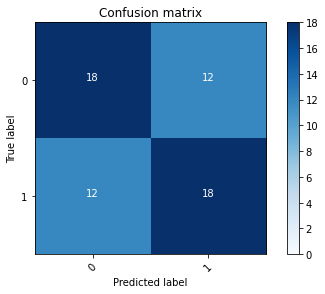

2022-02-17 12:50:24 - [Epoch Train: 52] loss: 0.0322, auc: 0.9997, acc: 0.9897, time: 62.00 s            
2022-02-17 12:50:24 - [Epoch Valid: 52] loss: 2.7823, auc: 0.6411, acc: 0.6000, time: 8.00 s


 17%|██████▌                               | 52/300 [1:01:12<4:51:36, 70.55s/it]

2022-02-17 12:50:24 - EPOCH: 53
2022-02-17 12:50:25 - Train Step 10/486, train_loss: 0.0126
2022-02-17 12:50:27 - Train Step 20/486, train_loss: 0.0093
2022-02-17 12:50:28 - Train Step 30/486, train_loss: 0.0094
2022-02-17 12:50:29 - Train Step 40/486, train_loss: 0.0141
2022-02-17 12:50:31 - Train Step 50/486, train_loss: 0.0114
2022-02-17 12:50:32 - Train Step 60/486, train_loss: 0.0156
2022-02-17 12:50:33 - Train Step 70/486, train_loss: 0.0196
2022-02-17 12:50:35 - Train Step 80/486, train_loss: 0.0178
2022-02-17 12:50:36 - Train Step 90/486, train_loss: 0.0179
2022-02-17 12:50:37 - Train Step 100/486, train_loss: 0.0168
2022-02-17 12:50:38 - Train Step 110/486, train_loss: 0.0171
2022-02-17 12:50:40 - Train Step 120/486, train_loss: 0.0157
2022-02-17 12:50:41 - Train Step 130/486, train_loss: 0.0193
2022-02-17 12:50:42 - Train Step 140/486, train_loss: 0.0250
2022-02-17 12:50:44 - Train Step 150/486, train_loss: 0.0234
2022-02-17 12:50:45 - Train Step 160/486, train_loss: 0.0220
2

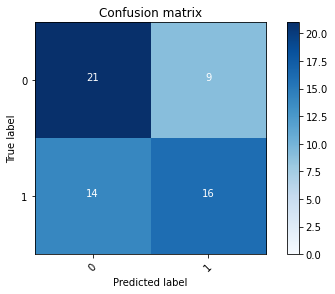

2022-02-17 12:51:35 - [Epoch Train: 53] loss: 0.0284, auc: 0.9995, acc: 0.9918, time: 63.00 s            
2022-02-17 12:51:35 - [Epoch Valid: 53] loss: 2.2346, auc: 0.6833, acc: 0.6167, time: 8.00 s


 18%|██████▋                               | 53/300 [1:02:24<4:51:18, 70.76s/it]

2022-02-17 12:51:35 - EPOCH: 54
2022-02-17 12:51:37 - Train Step 10/486, train_loss: 0.0015
2022-02-17 12:51:38 - Train Step 20/486, train_loss: 0.0091
2022-02-17 12:51:39 - Train Step 30/486, train_loss: 0.0074
2022-02-17 12:51:40 - Train Step 40/486, train_loss: 0.0061
2022-02-17 12:51:42 - Train Step 50/486, train_loss: 0.0052
2022-02-17 12:51:43 - Train Step 60/486, train_loss: 0.0239
2022-02-17 12:51:44 - Train Step 70/486, train_loss: 0.0277
2022-02-17 12:51:46 - Train Step 80/486, train_loss: 0.0296
2022-02-17 12:51:47 - Train Step 90/486, train_loss: 0.0314
2022-02-17 12:51:48 - Train Step 100/486, train_loss: 0.0439
2022-02-17 12:51:50 - Train Step 110/486, train_loss: 0.0418
2022-02-17 12:51:51 - Train Step 120/486, train_loss: 0.0511
2022-02-17 12:51:52 - Train Step 130/486, train_loss: 0.0486
2022-02-17 12:51:53 - Train Step 140/486, train_loss: 0.0469
2022-02-17 12:51:55 - Train Step 150/486, train_loss: 0.0475
2022-02-17 12:51:56 - Train Step 160/486, train_loss: 0.0529
2

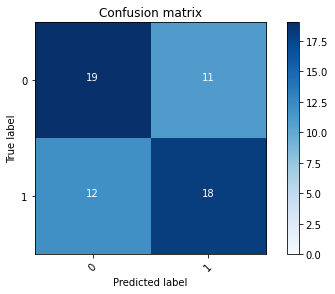

2022-02-17 12:52:47 - [Epoch Train: 54] loss: 0.0367, auc: 0.9995, acc: 0.9835, time: 63.00 s            
2022-02-17 12:52:47 - [Epoch Valid: 54] loss: 2.3008, auc: 0.6467, acc: 0.6167, time: 8.00 s


 18%|██████▊                               | 54/300 [1:03:35<4:51:20, 71.06s/it]

2022-02-17 12:52:47 - EPOCH: 55
2022-02-17 12:52:48 - Train Step 10/486, train_loss: 0.0069
2022-02-17 12:52:50 - Train Step 20/486, train_loss: 0.0053
2022-02-17 12:52:51 - Train Step 30/486, train_loss: 0.0249
2022-02-17 12:52:52 - Train Step 40/486, train_loss: 0.0191
2022-02-17 12:52:53 - Train Step 50/486, train_loss: 0.0235
2022-02-17 12:52:55 - Train Step 60/486, train_loss: 0.0196
2022-02-17 12:52:56 - Train Step 70/486, train_loss: 0.0415
2022-02-17 12:52:57 - Train Step 80/486, train_loss: 0.0371
2022-02-17 12:52:58 - Train Step 90/486, train_loss: 0.0336
2022-02-17 12:53:00 - Train Step 100/486, train_loss: 0.0482
2022-02-17 12:53:01 - Train Step 110/486, train_loss: 0.0453
2022-02-17 12:53:02 - Train Step 120/486, train_loss: 0.0475
2022-02-17 12:53:04 - Train Step 130/486, train_loss: 0.0490
2022-02-17 12:53:05 - Train Step 140/486, train_loss: 0.0461
2022-02-17 12:53:06 - Train Step 150/486, train_loss: 0.0431
2022-02-17 12:53:07 - Train Step 160/486, train_loss: 0.0418
2

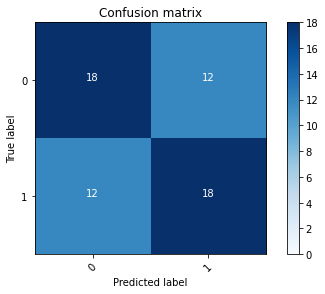

2022-02-17 12:53:58 - [Epoch Train: 55] loss: 0.0344, auc: 0.9993, acc: 0.9835, time: 63.00 s            
2022-02-17 12:53:58 - [Epoch Valid: 55] loss: 2.0806, auc: 0.6444, acc: 0.6000, time: 8.00 s


 18%|██████▉                               | 55/300 [1:04:47<4:50:34, 71.16s/it]

2022-02-17 12:53:58 - EPOCH: 56
2022-02-17 12:54:00 - Train Step 10/486, train_loss: 0.0046
2022-02-17 12:54:01 - Train Step 20/486, train_loss: 0.0114
2022-02-17 12:54:02 - Train Step 30/486, train_loss: 0.0080
2022-02-17 12:54:03 - Train Step 40/486, train_loss: 0.0248
2022-02-17 12:54:05 - Train Step 50/486, train_loss: 0.0207
2022-02-17 12:54:06 - Train Step 60/486, train_loss: 0.0173
2022-02-17 12:54:07 - Train Step 70/486, train_loss: 0.0219
2022-02-17 12:54:09 - Train Step 80/486, train_loss: 0.0342
2022-02-17 12:54:10 - Train Step 90/486, train_loss: 0.0305
2022-02-17 12:54:11 - Train Step 100/486, train_loss: 0.0281
2022-02-17 12:54:12 - Train Step 110/486, train_loss: 0.0262
2022-02-17 12:54:14 - Train Step 120/486, train_loss: 0.0292
2022-02-17 12:54:15 - Train Step 130/486, train_loss: 0.0271
2022-02-17 12:54:16 - Train Step 140/486, train_loss: 0.0252
2022-02-17 12:54:17 - Train Step 150/486, train_loss: 0.0249
2022-02-17 12:54:19 - Train Step 160/486, train_loss: 0.0235
2

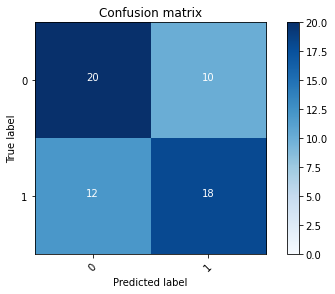

2022-02-17 12:55:10 - [Epoch Train: 56] loss: 0.0186, auc: 1.0000, acc: 0.9918, time: 63.00 s            
2022-02-17 12:55:10 - [Epoch Valid: 56] loss: 2.4799, auc: 0.6689, acc: 0.6333, time: 8.00 s


 19%|███████                               | 56/300 [1:05:58<4:49:35, 71.21s/it]

2022-02-17 12:55:10 - EPOCH: 57
2022-02-17 12:55:11 - Train Step 10/486, train_loss: 0.0407
2022-02-17 12:55:12 - Train Step 20/486, train_loss: 0.0238
2022-02-17 12:55:13 - Train Step 30/486, train_loss: 0.0161
2022-02-17 12:55:15 - Train Step 40/486, train_loss: 0.0122
2022-02-17 12:55:16 - Train Step 50/486, train_loss: 0.0115
2022-02-17 12:55:17 - Train Step 60/486, train_loss: 0.0096
2022-02-17 12:55:18 - Train Step 70/486, train_loss: 0.0091
2022-02-17 12:55:20 - Train Step 80/486, train_loss: 0.0089
2022-02-17 12:55:21 - Train Step 90/486, train_loss: 0.0093
2022-02-17 12:55:22 - Train Step 100/486, train_loss: 0.0104
2022-02-17 12:55:24 - Train Step 110/486, train_loss: 0.0098
2022-02-17 12:55:25 - Train Step 120/486, train_loss: 0.0092
2022-02-17 12:55:26 - Train Step 130/486, train_loss: 0.0091
2022-02-17 12:55:28 - Train Step 140/486, train_loss: 0.0086
2022-02-17 12:55:29 - Train Step 150/486, train_loss: 0.0081
2022-02-17 12:55:30 - Train Step 160/486, train_loss: 0.0076
2

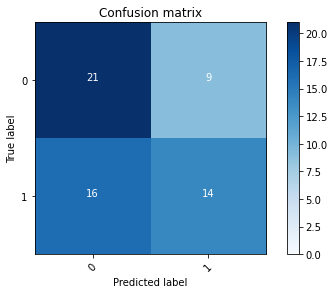

2022-02-17 12:56:20 - [Epoch Train: 57] loss: 0.0135, auc: 0.9999, acc: 0.9979, time: 62.00 s            
2022-02-17 12:56:20 - [Epoch Valid: 57] loss: 2.9396, auc: 0.6389, acc: 0.5833, time: 8.00 s


 19%|███████▏                              | 57/300 [1:07:09<4:47:49, 71.07s/it]

2022-02-17 12:56:20 - EPOCH: 58
2022-02-17 12:56:22 - Train Step 10/486, train_loss: 0.0483
2022-02-17 12:56:23 - Train Step 20/486, train_loss: 0.0278
2022-02-17 12:56:24 - Train Step 30/486, train_loss: 0.0267
2022-02-17 12:56:25 - Train Step 40/486, train_loss: 0.0209
2022-02-17 12:56:26 - Train Step 50/486, train_loss: 0.0183
2022-02-17 12:56:28 - Train Step 60/486, train_loss: 0.0155
2022-02-17 12:56:29 - Train Step 70/486, train_loss: 0.0135
2022-02-17 12:56:30 - Train Step 80/486, train_loss: 0.0120
2022-02-17 12:56:31 - Train Step 90/486, train_loss: 0.0108
2022-02-17 12:56:32 - Train Step 100/486, train_loss: 0.0100
2022-02-17 12:56:34 - Train Step 110/486, train_loss: 0.0097
2022-02-17 12:56:35 - Train Step 120/486, train_loss: 0.0090
2022-02-17 12:56:36 - Train Step 130/486, train_loss: 0.0255
2022-02-17 12:56:37 - Train Step 140/486, train_loss: 0.0238
2022-02-17 12:56:38 - Train Step 150/486, train_loss: 0.0232
2022-02-17 12:56:40 - Train Step 160/486, train_loss: 0.0218
2

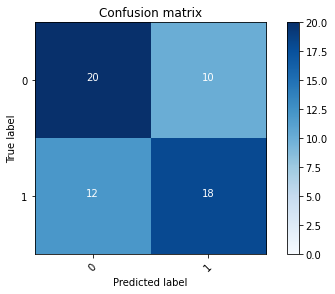

2022-02-17 12:57:26 - [Epoch Train: 58] loss: 0.0200, auc: 0.9999, acc: 0.9918, time: 58.00 s            
2022-02-17 12:57:26 - [Epoch Valid: 58] loss: 2.7814, auc: 0.6589, acc: 0.6333, time: 7.00 s


 19%|███████▎                              | 58/300 [1:08:15<4:40:09, 69.46s/it]

2022-02-17 12:57:26 - EPOCH: 59
2022-02-17 12:57:27 - Train Step 10/486, train_loss: 0.0036
2022-02-17 12:57:28 - Train Step 20/486, train_loss: 0.0020
2022-02-17 12:57:30 - Train Step 30/486, train_loss: 0.0039
2022-02-17 12:57:31 - Train Step 40/486, train_loss: 0.0042
2022-02-17 12:57:32 - Train Step 50/486, train_loss: 0.0057
2022-02-17 12:57:33 - Train Step 60/486, train_loss: 0.0048
2022-02-17 12:57:34 - Train Step 70/486, train_loss: 0.0051
2022-02-17 12:57:36 - Train Step 80/486, train_loss: 0.0100
2022-02-17 12:57:37 - Train Step 90/486, train_loss: 0.0092
2022-02-17 12:57:38 - Train Step 100/486, train_loss: 0.0090
2022-02-17 12:57:39 - Train Step 110/486, train_loss: 0.0096
2022-02-17 12:57:40 - Train Step 120/486, train_loss: 0.0088
2022-02-17 12:57:42 - Train Step 130/486, train_loss: 0.0082
2022-02-17 12:57:43 - Train Step 140/486, train_loss: 0.0080
2022-02-17 12:57:44 - Train Step 150/486, train_loss: 0.0076
2022-02-17 12:57:45 - Train Step 160/486, train_loss: 0.0112
2

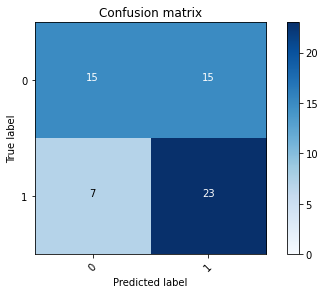

2022-02-17 12:58:33 - [Epoch Train: 59] loss: 0.0514, auc: 0.9983, acc: 0.9794, time: 59.00 s            
2022-02-17 12:58:33 - [Epoch Valid: 59] loss: 1.7898, auc: 0.6922, acc: 0.6333, time: 7.00 s


 20%|███████▍                              | 59/300 [1:09:22<4:36:27, 68.83s/it]

2022-02-17 12:58:33 - EPOCH: 60
2022-02-17 12:58:35 - Train Step 10/486, train_loss: 0.0202
2022-02-17 12:58:36 - Train Step 20/486, train_loss: 0.0463
2022-02-17 12:58:37 - Train Step 30/486, train_loss: 0.0320
2022-02-17 12:58:38 - Train Step 40/486, train_loss: 0.0305
2022-02-17 12:58:39 - Train Step 50/486, train_loss: 0.0258
2022-02-17 12:58:41 - Train Step 60/486, train_loss: 0.0247
2022-02-17 12:58:42 - Train Step 70/486, train_loss: 0.0235
2022-02-17 12:58:43 - Train Step 80/486, train_loss: 0.0268
2022-02-17 12:58:44 - Train Step 90/486, train_loss: 0.0293
2022-02-17 12:58:45 - Train Step 100/486, train_loss: 0.0374
2022-02-17 12:58:47 - Train Step 110/486, train_loss: 0.0343
2022-02-17 12:58:48 - Train Step 120/486, train_loss: 0.0498
2022-02-17 12:58:49 - Train Step 130/486, train_loss: 0.0460
2022-02-17 12:58:50 - Train Step 140/486, train_loss: 0.0463
2022-02-17 12:58:51 - Train Step 150/486, train_loss: 0.0463
2022-02-17 12:58:52 - Train Step 160/486, train_loss: 0.0436
2

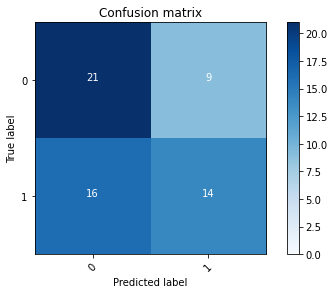

2022-02-17 12:59:39 - [Epoch Train: 60] loss: 0.0307, auc: 0.9995, acc: 0.9856, time: 57.00 s            
2022-02-17 12:59:39 - [Epoch Valid: 60] loss: 3.4198, auc: 0.6322, acc: 0.5833, time: 7.00 s


 20%|███████▌                              | 60/300 [1:10:27<4:31:12, 67.80s/it]

2022-02-17 12:59:39 - EPOCH: 61
2022-02-17 12:59:40 - Train Step 10/486, train_loss: 0.0090
2022-02-17 12:59:41 - Train Step 20/486, train_loss: 0.0061
2022-02-17 12:59:42 - Train Step 30/486, train_loss: 0.0043
2022-02-17 12:59:44 - Train Step 40/486, train_loss: 0.0041
2022-02-17 12:59:45 - Train Step 50/486, train_loss: 0.0044
2022-02-17 12:59:46 - Train Step 60/486, train_loss: 0.0053
2022-02-17 12:59:47 - Train Step 70/486, train_loss: 0.0046
2022-02-17 12:59:49 - Train Step 80/486, train_loss: 0.0046
2022-02-17 12:59:50 - Train Step 90/486, train_loss: 0.0080
2022-02-17 12:59:51 - Train Step 100/486, train_loss: 0.0128
2022-02-17 12:59:52 - Train Step 110/486, train_loss: 0.0139
2022-02-17 12:59:53 - Train Step 120/486, train_loss: 0.0132
2022-02-17 12:59:55 - Train Step 130/486, train_loss: 0.0122
2022-02-17 12:59:56 - Train Step 140/486, train_loss: 0.0114
2022-02-17 12:59:57 - Train Step 150/486, train_loss: 0.0108
2022-02-17 12:59:58 - Train Step 160/486, train_loss: 0.0101
2

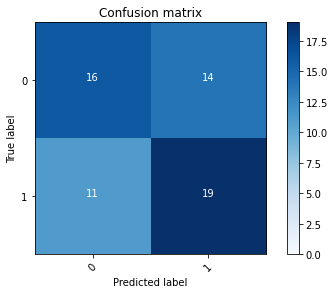

2022-02-17 13:00:47 - [Epoch Train: 61] loss: 0.0138, auc: 1.0000, acc: 0.9959, time: 60.00 s            
2022-02-17 13:00:47 - [Epoch Valid: 61] loss: 2.5899, auc: 0.6389, acc: 0.5833, time: 7.00 s


 20%|███████▋                              | 61/300 [1:11:35<4:30:28, 67.90s/it]

2022-02-17 13:00:47 - EPOCH: 62
2022-02-17 13:00:48 - Train Step 10/486, train_loss: 0.0032
2022-02-17 13:00:49 - Train Step 20/486, train_loss: 0.0153
2022-02-17 13:00:50 - Train Step 30/486, train_loss: 0.0106
2022-02-17 13:00:52 - Train Step 40/486, train_loss: 0.0090
2022-02-17 13:00:53 - Train Step 50/486, train_loss: 0.0075
2022-02-17 13:00:54 - Train Step 60/486, train_loss: 0.0112
2022-02-17 13:00:55 - Train Step 70/486, train_loss: 0.0111
2022-02-17 13:00:56 - Train Step 80/486, train_loss: 0.0101
2022-02-17 13:00:57 - Train Step 90/486, train_loss: 0.0096
2022-02-17 13:00:59 - Train Step 100/486, train_loss: 0.0089
2022-02-17 13:01:00 - Train Step 110/486, train_loss: 0.0160
2022-02-17 13:01:01 - Train Step 120/486, train_loss: 0.0188
2022-02-17 13:01:02 - Train Step 130/486, train_loss: 0.0175
2022-02-17 13:01:04 - Train Step 140/486, train_loss: 0.0172
2022-02-17 13:01:05 - Train Step 150/486, train_loss: 0.0165
2022-02-17 13:01:06 - Train Step 160/486, train_loss: 0.0184
2

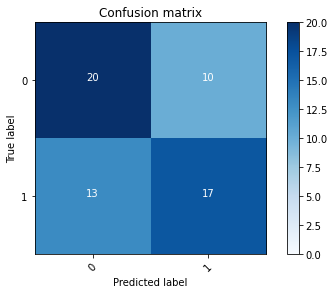

2022-02-17 13:01:52 - [Epoch Train: 62] loss: 0.0274, auc: 0.9995, acc: 0.9938, time: 57.00 s            
2022-02-17 13:01:52 - [Epoch Valid: 62] loss: 2.4102, auc: 0.6456, acc: 0.6167, time: 7.00 s


 21%|███████▊                              | 62/300 [1:12:41<4:25:58, 67.05s/it]

2022-02-17 13:01:52 - EPOCH: 63
2022-02-17 13:01:53 - Train Step 10/486, train_loss: 0.0055
2022-02-17 13:01:54 - Train Step 20/486, train_loss: 0.0063
2022-02-17 13:01:56 - Train Step 30/486, train_loss: 0.0052
2022-02-17 13:01:57 - Train Step 40/486, train_loss: 0.0058
2022-02-17 13:01:58 - Train Step 50/486, train_loss: 0.0066
2022-02-17 13:01:59 - Train Step 60/486, train_loss: 0.0083
2022-02-17 13:02:00 - Train Step 70/486, train_loss: 0.0098
2022-02-17 13:02:02 - Train Step 80/486, train_loss: 0.0087
2022-02-17 13:02:03 - Train Step 90/486, train_loss: 0.0078
2022-02-17 13:02:04 - Train Step 100/486, train_loss: 0.0073
2022-02-17 13:02:05 - Train Step 110/486, train_loss: 0.0067
2022-02-17 13:02:07 - Train Step 120/486, train_loss: 0.0067
2022-02-17 13:02:08 - Train Step 130/486, train_loss: 0.0062
2022-02-17 13:02:09 - Train Step 140/486, train_loss: 0.0063
2022-02-17 13:02:10 - Train Step 150/486, train_loss: 0.0060
2022-02-17 13:02:11 - Train Step 160/486, train_loss: 0.0082
2

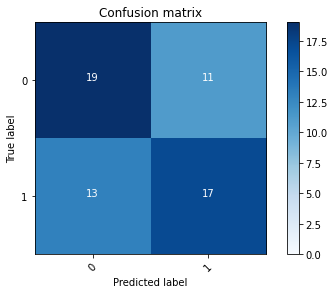

2022-02-17 13:02:58 - [Epoch Train: 63] loss: 0.0548, auc: 0.9983, acc: 0.9774, time: 57.00 s            
2022-02-17 13:02:58 - [Epoch Valid: 63] loss: 2.3333, auc: 0.6722, acc: 0.6000, time: 7.00 s


 21%|███████▉                              | 63/300 [1:13:46<4:23:09, 66.62s/it]

2022-02-17 13:02:58 - EPOCH: 64
2022-02-17 13:02:59 - Train Step 10/486, train_loss: 0.0104
2022-02-17 13:03:00 - Train Step 20/486, train_loss: 0.0107
2022-02-17 13:03:01 - Train Step 30/486, train_loss: 0.0186
2022-02-17 13:03:02 - Train Step 40/486, train_loss: 0.0184
2022-02-17 13:03:03 - Train Step 50/486, train_loss: 0.0261
2022-02-17 13:03:05 - Train Step 60/486, train_loss: 0.0236
2022-02-17 13:03:06 - Train Step 70/486, train_loss: 0.0208
2022-02-17 13:03:07 - Train Step 80/486, train_loss: 0.0185
2022-02-17 13:03:08 - Train Step 90/486, train_loss: 0.0167
2022-02-17 13:03:10 - Train Step 100/486, train_loss: 0.0158
2022-02-17 13:03:11 - Train Step 110/486, train_loss: 0.0151
2022-02-17 13:03:12 - Train Step 120/486, train_loss: 0.0147
2022-02-17 13:03:13 - Train Step 130/486, train_loss: 0.0138
2022-02-17 13:03:14 - Train Step 140/486, train_loss: 0.0147
2022-02-17 13:03:15 - Train Step 150/486, train_loss: 0.0177
2022-02-17 13:03:17 - Train Step 160/486, train_loss: 0.0183
2

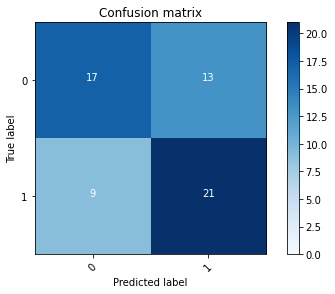

2022-02-17 13:04:03 - [Epoch Train: 64] loss: 0.0183, auc: 1.0000, acc: 0.9938, time: 57.00 s            
2022-02-17 13:04:03 - [Epoch Valid: 64] loss: 2.8299, auc: 0.6333, acc: 0.6333, time: 7.00 s


 21%|████████                              | 64/300 [1:14:52<4:20:54, 66.33s/it]

2022-02-17 13:04:03 - EPOCH: 65
2022-02-17 13:04:05 - Train Step 10/486, train_loss: 0.0040
2022-02-17 13:04:06 - Train Step 20/486, train_loss: 0.0047
2022-02-17 13:04:07 - Train Step 30/486, train_loss: 0.0032
2022-02-17 13:04:08 - Train Step 40/486, train_loss: 0.0028
2022-02-17 13:04:09 - Train Step 50/486, train_loss: 0.0140
2022-02-17 13:04:11 - Train Step 60/486, train_loss: 0.0129
2022-02-17 13:04:12 - Train Step 70/486, train_loss: 0.0118
2022-02-17 13:04:13 - Train Step 80/486, train_loss: 0.0262
2022-02-17 13:04:14 - Train Step 90/486, train_loss: 0.0234
2022-02-17 13:04:15 - Train Step 100/486, train_loss: 0.0253
2022-02-17 13:04:16 - Train Step 110/486, train_loss: 0.0277
2022-02-17 13:04:18 - Train Step 120/486, train_loss: 0.0266
2022-02-17 13:04:19 - Train Step 130/486, train_loss: 0.0247
2022-02-17 13:04:20 - Train Step 140/486, train_loss: 0.0230
2022-02-17 13:04:21 - Train Step 150/486, train_loss: 0.0215
2022-02-17 13:04:22 - Train Step 160/486, train_loss: 0.0205
2

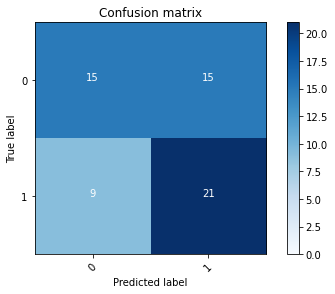

2022-02-17 13:05:08 - [Epoch Train: 65] loss: 0.0189, auc: 0.9998, acc: 0.9938, time: 57.00 s            
2022-02-17 13:05:08 - [Epoch Valid: 65] loss: 2.4010, auc: 0.6456, acc: 0.6000, time: 7.00 s


 22%|████████▏                             | 65/300 [1:15:57<4:18:20, 65.96s/it]

2022-02-17 13:05:08 - EPOCH: 66
2022-02-17 13:05:10 - Train Step 10/486, train_loss: 0.0036
2022-02-17 13:05:11 - Train Step 20/486, train_loss: 0.0024
2022-02-17 13:05:12 - Train Step 30/486, train_loss: 0.0019
2022-02-17 13:05:13 - Train Step 40/486, train_loss: 0.0229
2022-02-17 13:05:14 - Train Step 50/486, train_loss: 0.0186
2022-02-17 13:05:16 - Train Step 60/486, train_loss: 0.0164
2022-02-17 13:05:17 - Train Step 70/486, train_loss: 0.0151
2022-02-17 13:05:18 - Train Step 80/486, train_loss: 0.0136
2022-02-17 13:05:19 - Train Step 90/486, train_loss: 0.0122
2022-02-17 13:05:20 - Train Step 100/486, train_loss: 0.0119
2022-02-17 13:05:22 - Train Step 110/486, train_loss: 0.0141
2022-02-17 13:05:23 - Train Step 120/486, train_loss: 0.0130
2022-02-17 13:05:24 - Train Step 130/486, train_loss: 0.0120
2022-02-17 13:05:25 - Train Step 140/486, train_loss: 0.0112
2022-02-17 13:05:26 - Train Step 150/486, train_loss: 0.0106
2022-02-17 13:05:27 - Train Step 160/486, train_loss: 0.0103
2

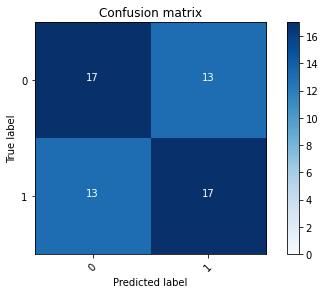

2022-02-17 13:06:14 - [Epoch Train: 66] loss: 0.0069, auc: 1.0000, acc: 0.9979, time: 57.00 s            
2022-02-17 13:06:14 - [Epoch Valid: 66] loss: 2.6389, auc: 0.6278, acc: 0.5667, time: 7.00 s


 22%|████████▎                             | 66/300 [1:17:03<4:16:48, 65.85s/it]

2022-02-17 13:06:14 - EPOCH: 67
2022-02-17 13:06:15 - Train Step 10/486, train_loss: 0.0046
2022-02-17 13:06:16 - Train Step 20/486, train_loss: 0.0052
2022-02-17 13:06:18 - Train Step 30/486, train_loss: 0.0070
2022-02-17 13:06:19 - Train Step 40/486, train_loss: 0.0055
2022-02-17 13:06:20 - Train Step 50/486, train_loss: 0.0064
2022-02-17 13:06:21 - Train Step 60/486, train_loss: 0.0053
2022-02-17 13:06:22 - Train Step 70/486, train_loss: 0.0055
2022-02-17 13:06:23 - Train Step 80/486, train_loss: 0.0071
2022-02-17 13:06:25 - Train Step 90/486, train_loss: 0.0068
2022-02-17 13:06:26 - Train Step 100/486, train_loss: 0.0064
2022-02-17 13:06:27 - Train Step 110/486, train_loss: 0.0152
2022-02-17 13:06:28 - Train Step 120/486, train_loss: 0.0140
2022-02-17 13:06:29 - Train Step 130/486, train_loss: 0.0130
2022-02-17 13:06:31 - Train Step 140/486, train_loss: 0.0124
2022-02-17 13:06:32 - Train Step 150/486, train_loss: 0.0117
2022-02-17 13:06:33 - Train Step 160/486, train_loss: 0.0135
2

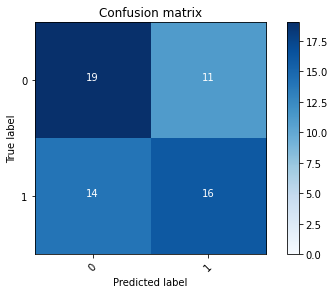

2022-02-17 13:07:19 - [Epoch Train: 67] loss: 0.0107, auc: 1.0000, acc: 0.9959, time: 57.00 s            
2022-02-17 13:07:19 - [Epoch Valid: 67] loss: 3.0100, auc: 0.6300, acc: 0.5833, time: 7.00 s


 22%|████████▍                             | 67/300 [1:18:08<4:14:57, 65.66s/it]

2022-02-17 13:07:19 - EPOCH: 68
2022-02-17 13:07:20 - Train Step 10/486, train_loss: 0.0018
2022-02-17 13:07:22 - Train Step 20/486, train_loss: 0.0023
2022-02-17 13:07:23 - Train Step 30/486, train_loss: 0.0018
2022-02-17 13:07:24 - Train Step 40/486, train_loss: 0.0024
2022-02-17 13:07:25 - Train Step 50/486, train_loss: 0.0084
2022-02-17 13:07:26 - Train Step 60/486, train_loss: 0.0070
2022-02-17 13:07:27 - Train Step 70/486, train_loss: 0.0060
2022-02-17 13:07:29 - Train Step 80/486, train_loss: 0.0054
2022-02-17 13:07:30 - Train Step 90/486, train_loss: 0.0049
2022-02-17 13:07:31 - Train Step 100/486, train_loss: 0.0068
2022-02-17 13:07:32 - Train Step 110/486, train_loss: 0.0062
2022-02-17 13:07:33 - Train Step 120/486, train_loss: 0.0093
2022-02-17 13:07:35 - Train Step 130/486, train_loss: 0.0088
2022-02-17 13:07:36 - Train Step 140/486, train_loss: 0.0082
2022-02-17 13:07:37 - Train Step 150/486, train_loss: 0.0077
2022-02-17 13:07:38 - Train Step 160/486, train_loss: 0.0073
2

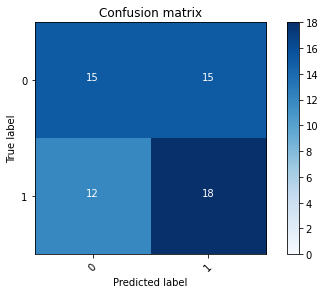

2022-02-17 13:08:25 - [Epoch Train: 68] loss: 0.0098, auc: 1.0000, acc: 1.0000, time: 57.00 s            
2022-02-17 13:08:25 - [Epoch Valid: 68] loss: 2.7753, auc: 0.6200, acc: 0.5500, time: 7.00 s


 23%|████████▌                             | 68/300 [1:19:13<4:13:38, 65.60s/it]

2022-02-17 13:08:25 - EPOCH: 69
2022-02-17 13:08:26 - Train Step 10/486, train_loss: 0.0010
2022-02-17 13:08:27 - Train Step 20/486, train_loss: 0.0226
2022-02-17 13:08:28 - Train Step 30/486, train_loss: 0.0158
2022-02-17 13:08:29 - Train Step 40/486, train_loss: 0.0123
2022-02-17 13:08:31 - Train Step 50/486, train_loss: 0.0104
2022-02-17 13:08:32 - Train Step 60/486, train_loss: 0.0088
2022-02-17 13:08:33 - Train Step 70/486, train_loss: 0.0076
2022-02-17 13:08:34 - Train Step 80/486, train_loss: 0.0119
2022-02-17 13:08:36 - Train Step 90/486, train_loss: 0.0147
2022-02-17 13:08:37 - Train Step 100/486, train_loss: 0.0133
2022-02-17 13:08:38 - Train Step 110/486, train_loss: 0.0125
2022-02-17 13:08:40 - Train Step 120/486, train_loss: 0.0119
2022-02-17 13:08:41 - Train Step 130/486, train_loss: 0.0110
2022-02-17 13:08:43 - Train Step 140/486, train_loss: 0.0109
2022-02-17 13:08:44 - Train Step 150/486, train_loss: 0.0106
2022-02-17 13:08:45 - Train Step 160/486, train_loss: 0.0102
2

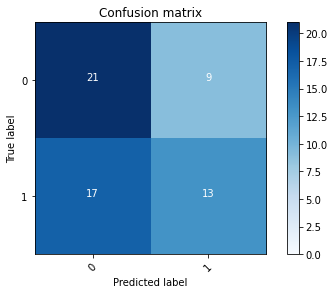

2022-02-17 13:09:36 - [Epoch Train: 69] loss: 0.0254, auc: 0.9996, acc: 0.9918, time: 63.00 s            
2022-02-17 13:09:36 - [Epoch Valid: 69] loss: 3.2972, auc: 0.6033, acc: 0.5667, time: 7.00 s


 23%|████████▋                             | 69/300 [1:20:24<4:18:57, 67.26s/it]

2022-02-17 13:09:36 - EPOCH: 70
2022-02-17 13:09:37 - Train Step 10/486, train_loss: 0.0042
2022-02-17 13:09:38 - Train Step 20/486, train_loss: 0.0218
2022-02-17 13:09:40 - Train Step 30/486, train_loss: 0.0253
2022-02-17 13:09:41 - Train Step 40/486, train_loss: 0.0190
2022-02-17 13:09:42 - Train Step 50/486, train_loss: 0.0153
2022-02-17 13:09:43 - Train Step 60/486, train_loss: 0.0143
2022-02-17 13:09:45 - Train Step 70/486, train_loss: 0.0240
2022-02-17 13:09:46 - Train Step 80/486, train_loss: 0.0233
2022-02-17 13:09:47 - Train Step 90/486, train_loss: 0.0209
2022-02-17 13:09:48 - Train Step 100/486, train_loss: 0.0193
2022-02-17 13:09:50 - Train Step 110/486, train_loss: 0.0218
2022-02-17 13:09:51 - Train Step 120/486, train_loss: 0.0225
2022-02-17 13:09:52 - Train Step 130/486, train_loss: 0.0208
2022-02-17 13:09:53 - Train Step 140/486, train_loss: 0.0194
2022-02-17 13:09:55 - Train Step 150/486, train_loss: 0.0193
2022-02-17 13:09:56 - Train Step 160/486, train_loss: 0.0182
2

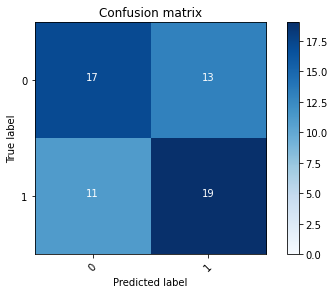

2022-02-17 13:10:45 - [Epoch Train: 70] loss: 0.0151, auc: 0.9999, acc: 0.9959, time: 61.00 s            
2022-02-17 13:10:45 - [Epoch Valid: 70] loss: 2.9210, auc: 0.6267, acc: 0.6000, time: 7.00 s


 23%|████████▊                             | 70/300 [1:21:34<4:20:15, 67.89s/it]

2022-02-17 13:10:45 - EPOCH: 71
2022-02-17 13:10:46 - Train Step 10/486, train_loss: 0.0003
2022-02-17 13:10:48 - Train Step 20/486, train_loss: 0.0002
2022-02-17 13:10:49 - Train Step 30/486, train_loss: 0.0003
2022-02-17 13:10:50 - Train Step 40/486, train_loss: 0.0006
2022-02-17 13:10:51 - Train Step 50/486, train_loss: 0.0009
2022-02-17 13:10:53 - Train Step 60/486, train_loss: 0.0202
2022-02-17 13:10:54 - Train Step 70/486, train_loss: 0.0441
2022-02-17 13:10:55 - Train Step 80/486, train_loss: 0.0389
2022-02-17 13:10:57 - Train Step 90/486, train_loss: 0.0391
2022-02-17 13:10:58 - Train Step 100/486, train_loss: 0.0398
2022-02-17 13:10:59 - Train Step 110/486, train_loss: 0.0362
2022-02-17 13:11:01 - Train Step 120/486, train_loss: 0.0336
2022-02-17 13:11:02 - Train Step 130/486, train_loss: 0.0397
2022-02-17 13:11:03 - Train Step 140/486, train_loss: 0.0369
2022-02-17 13:11:05 - Train Step 150/486, train_loss: 0.0346
2022-02-17 13:11:06 - Train Step 160/486, train_loss: 0.0360
2

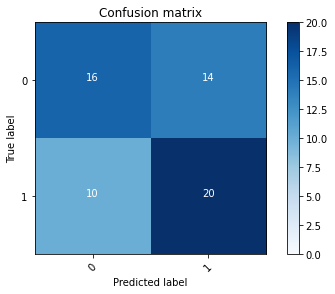

2022-02-17 13:11:55 - [Epoch Train: 71] loss: 0.0165, auc: 0.9998, acc: 0.9918, time: 62.00 s            
2022-02-17 13:11:55 - [Epoch Valid: 71] loss: 3.2635, auc: 0.6339, acc: 0.6000, time: 7.00 s


 24%|████████▉                             | 71/300 [1:22:44<4:21:40, 68.56s/it]

2022-02-17 13:11:55 - EPOCH: 72
2022-02-17 13:11:57 - Train Step 10/486, train_loss: 0.0001
2022-02-17 13:11:58 - Train Step 20/486, train_loss: 0.0002
2022-02-17 13:11:59 - Train Step 30/486, train_loss: 0.0009
2022-02-17 13:12:00 - Train Step 40/486, train_loss: 0.0012
2022-02-17 13:12:02 - Train Step 50/486, train_loss: 0.0099
2022-02-17 13:12:03 - Train Step 60/486, train_loss: 0.0083
2022-02-17 13:12:04 - Train Step 70/486, train_loss: 0.0071
2022-02-17 13:12:05 - Train Step 80/486, train_loss: 0.0063
2022-02-17 13:12:07 - Train Step 90/486, train_loss: 0.0056
2022-02-17 13:12:08 - Train Step 100/486, train_loss: 0.0054
2022-02-17 13:12:09 - Train Step 110/486, train_loss: 0.0060
2022-02-17 13:12:11 - Train Step 120/486, train_loss: 0.0055
2022-02-17 13:12:12 - Train Step 130/486, train_loss: 0.0051
2022-02-17 13:12:13 - Train Step 140/486, train_loss: 0.0048
2022-02-17 13:12:14 - Train Step 150/486, train_loss: 0.0073
2022-02-17 13:12:16 - Train Step 160/486, train_loss: 0.0068
2

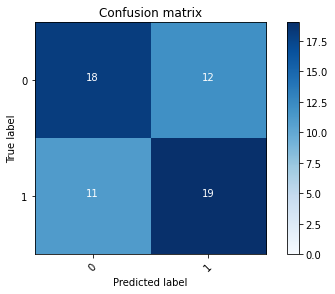

2022-02-17 13:13:04 - [Epoch Train: 72] loss: 0.0216, auc: 0.9997, acc: 0.9918, time: 61.00 s            
2022-02-17 13:13:04 - [Epoch Valid: 72] loss: 3.5061, auc: 0.6433, acc: 0.6167, time: 8.00 s


 24%|█████████                             | 72/300 [1:23:53<4:21:20, 68.77s/it]

2022-02-17 13:13:04 - EPOCH: 73
2022-02-17 13:13:06 - Train Step 10/486, train_loss: 0.0009
2022-02-17 13:13:07 - Train Step 20/486, train_loss: 0.0053
2022-02-17 13:13:08 - Train Step 30/486, train_loss: 0.0242
2022-02-17 13:13:10 - Train Step 40/486, train_loss: 0.0215
2022-02-17 13:13:11 - Train Step 50/486, train_loss: 0.0172
2022-02-17 13:13:12 - Train Step 60/486, train_loss: 0.0146
2022-02-17 13:13:13 - Train Step 70/486, train_loss: 0.0493
2022-02-17 13:13:15 - Train Step 80/486, train_loss: 0.0461
2022-02-17 13:13:16 - Train Step 90/486, train_loss: 0.0725
2022-02-17 13:13:17 - Train Step 100/486, train_loss: 0.0654
2022-02-17 13:13:19 - Train Step 110/486, train_loss: 0.0601
2022-02-17 13:13:20 - Train Step 120/486, train_loss: 0.0557
2022-02-17 13:13:21 - Train Step 130/486, train_loss: 0.0520
2022-02-17 13:13:22 - Train Step 140/486, train_loss: 0.0484
2022-02-17 13:13:24 - Train Step 150/486, train_loss: 0.0453
2022-02-17 13:13:25 - Train Step 160/486, train_loss: 0.0425
2

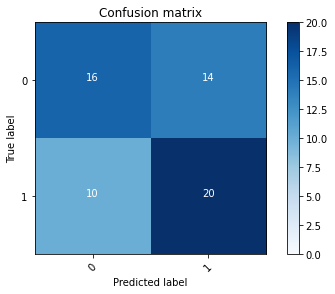

2022-02-17 13:14:14 - [Epoch Train: 73] loss: 0.0274, auc: 0.9995, acc: 0.9959, time: 62.00 s            
2022-02-17 13:14:14 - [Epoch Valid: 73] loss: 3.4670, auc: 0.6189, acc: 0.6000, time: 7.00 s


 24%|█████████▏                            | 73/300 [1:25:03<4:21:32, 69.13s/it]

2022-02-17 13:14:14 - EPOCH: 74
2022-02-17 13:14:16 - Train Step 10/486, train_loss: 0.0064
2022-02-17 13:14:17 - Train Step 20/486, train_loss: 0.0045
2022-02-17 13:14:18 - Train Step 30/486, train_loss: 0.0031
2022-02-17 13:14:20 - Train Step 40/486, train_loss: 0.0036
2022-02-17 13:14:21 - Train Step 50/486, train_loss: 0.0110
2022-02-17 13:14:22 - Train Step 60/486, train_loss: 0.0098
2022-02-17 13:14:23 - Train Step 70/486, train_loss: 0.0104
2022-02-17 13:14:25 - Train Step 80/486, train_loss: 0.0139
2022-02-17 13:14:26 - Train Step 90/486, train_loss: 0.0130
2022-02-17 13:14:27 - Train Step 100/486, train_loss: 0.0133
2022-02-17 13:14:28 - Train Step 110/486, train_loss: 0.0123
2022-02-17 13:14:30 - Train Step 120/486, train_loss: 0.0131
2022-02-17 13:14:31 - Train Step 130/486, train_loss: 0.0121
2022-02-17 13:14:32 - Train Step 140/486, train_loss: 0.0113
2022-02-17 13:14:33 - Train Step 150/486, train_loss: 0.0108
2022-02-17 13:14:35 - Train Step 160/486, train_loss: 0.0111
2

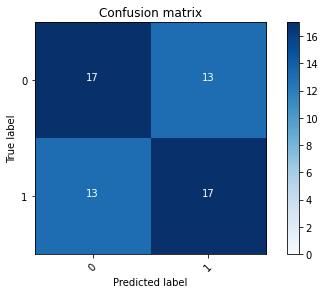

2022-02-17 13:15:24 - [Epoch Train: 74] loss: 0.0151, auc: 0.9999, acc: 0.9938, time: 61.00 s            
2022-02-17 13:15:24 - [Epoch Valid: 74] loss: 3.5848, auc: 0.6378, acc: 0.5667, time: 7.00 s


 25%|█████████▎                            | 74/300 [1:26:12<4:20:34, 69.18s/it]

2022-02-17 13:15:24 - EPOCH: 75
2022-02-17 13:15:25 - Train Step 10/486, train_loss: 0.0003
2022-02-17 13:15:26 - Train Step 20/486, train_loss: 0.0006
2022-02-17 13:15:28 - Train Step 30/486, train_loss: 0.0064
2022-02-17 13:15:29 - Train Step 40/486, train_loss: 0.0418
2022-02-17 13:15:30 - Train Step 50/486, train_loss: 0.0383
2022-02-17 13:15:31 - Train Step 60/486, train_loss: 0.0321
2022-02-17 13:15:33 - Train Step 70/486, train_loss: 0.0282
2022-02-17 13:15:34 - Train Step 80/486, train_loss: 0.0255
2022-02-17 13:15:35 - Train Step 90/486, train_loss: 0.0227
2022-02-17 13:15:36 - Train Step 100/486, train_loss: 0.0208
2022-02-17 13:15:38 - Train Step 110/486, train_loss: 0.0296
2022-02-17 13:15:39 - Train Step 120/486, train_loss: 0.0272
2022-02-17 13:15:40 - Train Step 130/486, train_loss: 0.0251
2022-02-17 13:15:41 - Train Step 140/486, train_loss: 0.0237
2022-02-17 13:15:42 - Train Step 150/486, train_loss: 0.0222
2022-02-17 13:15:44 - Train Step 160/486, train_loss: 0.0208
2

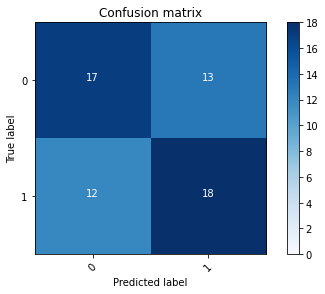

2022-02-17 13:16:32 - [Epoch Train: 75] loss: 0.0128, auc: 0.9999, acc: 0.9959, time: 60.00 s            
2022-02-17 13:16:32 - [Epoch Valid: 75] loss: 3.4580, auc: 0.6456, acc: 0.5833, time: 7.00 s


 25%|█████████▌                            | 75/300 [1:27:21<4:18:47, 69.01s/it]

2022-02-17 13:16:32 - EPOCH: 76
2022-02-17 13:16:34 - Train Step 10/486, train_loss: 0.0001
2022-02-17 13:16:35 - Train Step 20/486, train_loss: 0.0040
2022-02-17 13:16:36 - Train Step 30/486, train_loss: 0.0027
2022-02-17 13:16:37 - Train Step 40/486, train_loss: 0.0028
2022-02-17 13:16:39 - Train Step 50/486, train_loss: 0.0637
2022-02-17 13:16:40 - Train Step 60/486, train_loss: 0.0540
2022-02-17 13:16:41 - Train Step 70/486, train_loss: 0.0467
2022-02-17 13:16:42 - Train Step 80/486, train_loss: 0.0478
2022-02-17 13:16:44 - Train Step 90/486, train_loss: 0.0503
2022-02-17 13:16:45 - Train Step 100/486, train_loss: 0.0454
2022-02-17 13:16:46 - Train Step 110/486, train_loss: 0.0413
2022-02-17 13:16:47 - Train Step 120/486, train_loss: 0.0440
2022-02-17 13:16:49 - Train Step 130/486, train_loss: 0.0408
2022-02-17 13:16:50 - Train Step 140/486, train_loss: 0.0382
2022-02-17 13:16:51 - Train Step 150/486, train_loss: 0.0381
2022-02-17 13:16:52 - Train Step 160/486, train_loss: 0.0367
2

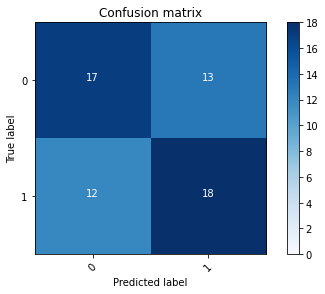

2022-02-17 13:17:42 - [Epoch Train: 76] loss: 0.0387, auc: 0.9988, acc: 0.9815, time: 61.00 s            
2022-02-17 13:17:42 - [Epoch Valid: 76] loss: 2.8432, auc: 0.6478, acc: 0.5833, time: 8.00 s


 25%|█████████▋                            | 76/300 [1:28:31<4:18:38, 69.28s/it]

2022-02-17 13:17:42 - EPOCH: 77
2022-02-17 13:17:44 - Train Step 10/486, train_loss: 0.0061
2022-02-17 13:17:45 - Train Step 20/486, train_loss: 0.0031
2022-02-17 13:17:46 - Train Step 30/486, train_loss: 0.0023
2022-02-17 13:17:47 - Train Step 40/486, train_loss: 0.0020
2022-02-17 13:17:49 - Train Step 50/486, train_loss: 0.0026
2022-02-17 13:17:50 - Train Step 60/486, train_loss: 0.0318
2022-02-17 13:17:51 - Train Step 70/486, train_loss: 0.0489
2022-02-17 13:17:52 - Train Step 80/486, train_loss: 0.0506
2022-02-17 13:17:54 - Train Step 90/486, train_loss: 0.0451
2022-02-17 13:17:55 - Train Step 100/486, train_loss: 0.0406
2022-02-17 13:17:56 - Train Step 110/486, train_loss: 0.0369
2022-02-17 13:17:57 - Train Step 120/486, train_loss: 0.0349
2022-02-17 13:17:59 - Train Step 130/486, train_loss: 0.0323
2022-02-17 13:18:00 - Train Step 140/486, train_loss: 0.0300
2022-02-17 13:18:01 - Train Step 150/486, train_loss: 0.0285
2022-02-17 13:18:02 - Train Step 160/486, train_loss: 0.0274
2

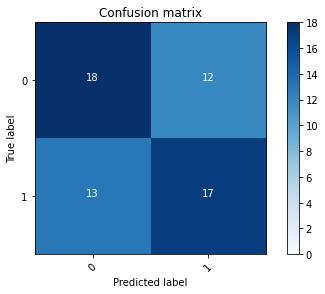

2022-02-17 13:18:53 - [Epoch Train: 77] loss: 0.0222, auc: 0.9997, acc: 0.9897, time: 62.00 s            
2022-02-17 13:18:53 - [Epoch Valid: 77] loss: 3.7188, auc: 0.6478, acc: 0.5833, time: 8.00 s


 26%|█████████▊                            | 77/300 [1:29:42<4:19:20, 69.78s/it]

2022-02-17 13:18:53 - EPOCH: 78
2022-02-17 13:18:55 - Train Step 10/486, train_loss: 0.0016
2022-02-17 13:18:56 - Train Step 20/486, train_loss: 0.0009
2022-02-17 13:18:57 - Train Step 30/486, train_loss: 0.0022
2022-02-17 13:18:58 - Train Step 40/486, train_loss: 0.0029
2022-02-17 13:19:00 - Train Step 50/486, train_loss: 0.0037
2022-02-17 13:19:01 - Train Step 60/486, train_loss: 0.0109
2022-02-17 13:19:02 - Train Step 70/486, train_loss: 0.0100
2022-02-17 13:19:04 - Train Step 80/486, train_loss: 0.0087
2022-02-17 13:19:05 - Train Step 90/486, train_loss: 0.0100
2022-02-17 13:19:06 - Train Step 100/486, train_loss: 0.0092
2022-02-17 13:19:07 - Train Step 110/486, train_loss: 0.0093
2022-02-17 13:19:09 - Train Step 120/486, train_loss: 0.0086
2022-02-17 13:19:10 - Train Step 130/486, train_loss: 0.0104
2022-02-17 13:19:11 - Train Step 140/486, train_loss: 0.0097
2022-02-17 13:19:12 - Train Step 150/486, train_loss: 0.0091
2022-02-17 13:19:14 - Train Step 160/486, train_loss: 0.0087
2

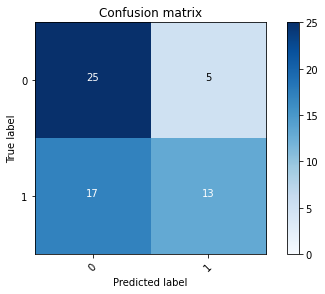

2022-02-17 13:20:03 - [Epoch Train: 78] loss: 0.0126, auc: 0.9999, acc: 0.9959, time: 61.00 s            
2022-02-17 13:20:03 - [Epoch Valid: 78] loss: 3.8088, auc: 0.6067, acc: 0.6333, time: 8.00 s


 26%|█████████▉                            | 78/300 [1:30:52<4:18:26, 69.85s/it]

2022-02-17 13:20:03 - EPOCH: 79
2022-02-17 13:20:05 - Train Step 10/486, train_loss: 0.0114
2022-02-17 13:20:06 - Train Step 20/486, train_loss: 0.0149
2022-02-17 13:20:07 - Train Step 30/486, train_loss: 0.0125
2022-02-17 13:20:08 - Train Step 40/486, train_loss: 0.0107
2022-02-17 13:20:10 - Train Step 50/486, train_loss: 0.0098
2022-02-17 13:20:11 - Train Step 60/486, train_loss: 0.0095
2022-02-17 13:20:12 - Train Step 70/486, train_loss: 0.0089
2022-02-17 13:20:14 - Train Step 80/486, train_loss: 0.0118
2022-02-17 13:20:15 - Train Step 90/486, train_loss: 0.0111
2022-02-17 13:20:16 - Train Step 100/486, train_loss: 0.0108
2022-02-17 13:20:17 - Train Step 110/486, train_loss: 0.0103
2022-02-17 13:20:19 - Train Step 120/486, train_loss: 0.0094
2022-02-17 13:20:20 - Train Step 130/486, train_loss: 0.0091
2022-02-17 13:20:21 - Train Step 140/486, train_loss: 0.0113
2022-02-17 13:20:23 - Train Step 150/486, train_loss: 0.0106
2022-02-17 13:20:24 - Train Step 160/486, train_loss: 0.0138
2

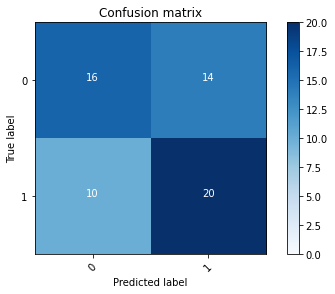

2022-02-17 13:21:13 - [Epoch Train: 79] loss: 0.0157, auc: 1.0000, acc: 0.9979, time: 62.00 s            
2022-02-17 13:21:13 - [Epoch Valid: 79] loss: 3.2621, auc: 0.6433, acc: 0.6000, time: 7.00 s


 26%|██████████                            | 79/300 [1:32:02<4:17:31, 69.92s/it]

2022-02-17 13:21:13 - EPOCH: 80
2022-02-17 13:21:15 - Train Step 10/486, train_loss: 0.0000
2022-02-17 13:21:16 - Train Step 20/486, train_loss: 0.0494
2022-02-17 13:21:17 - Train Step 30/486, train_loss: 0.0330
2022-02-17 13:21:18 - Train Step 40/486, train_loss: 0.0249
2022-02-17 13:21:20 - Train Step 50/486, train_loss: 0.0217
2022-02-17 13:21:21 - Train Step 60/486, train_loss: 0.0182
2022-02-17 13:21:22 - Train Step 70/486, train_loss: 0.0352
2022-02-17 13:21:24 - Train Step 80/486, train_loss: 0.0328
2022-02-17 13:21:25 - Train Step 90/486, train_loss: 0.0680
2022-02-17 13:21:26 - Train Step 100/486, train_loss: 0.0679
2022-02-17 13:21:28 - Train Step 110/486, train_loss: 0.0656
2022-02-17 13:21:29 - Train Step 120/486, train_loss: 0.0607
2022-02-17 13:21:30 - Train Step 130/486, train_loss: 0.0568
2022-02-17 13:21:32 - Train Step 140/486, train_loss: 0.0530
2022-02-17 13:21:33 - Train Step 150/486, train_loss: 0.0495
2022-02-17 13:21:34 - Train Step 160/486, train_loss: 0.0507
2

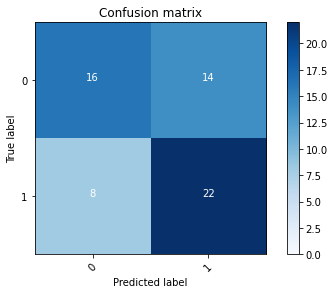

2022-02-17 13:22:24 - [Epoch Train: 80] loss: 0.0263, auc: 0.9997, acc: 0.9897, time: 62.00 s            
2022-02-17 13:22:24 - [Epoch Valid: 80] loss: 2.7161, auc: 0.6744, acc: 0.6333, time: 7.00 s


 27%|██████████▏                           | 80/300 [1:33:12<4:16:52, 70.06s/it]

2022-02-17 13:22:24 - EPOCH: 81
2022-02-17 13:22:25 - Train Step 10/486, train_loss: 0.0035
2022-02-17 13:22:26 - Train Step 20/486, train_loss: 0.0029
2022-02-17 13:22:28 - Train Step 30/486, train_loss: 0.0021
2022-02-17 13:22:29 - Train Step 40/486, train_loss: 0.0113
2022-02-17 13:22:30 - Train Step 50/486, train_loss: 0.0152
2022-02-17 13:22:31 - Train Step 60/486, train_loss: 0.0129
2022-02-17 13:22:33 - Train Step 70/486, train_loss: 0.0120
2022-02-17 13:22:34 - Train Step 80/486, train_loss: 0.0117
2022-02-17 13:22:35 - Train Step 90/486, train_loss: 0.0119
2022-02-17 13:22:37 - Train Step 100/486, train_loss: 0.0107
2022-02-17 13:22:38 - Train Step 110/486, train_loss: 0.0099
2022-02-17 13:22:39 - Train Step 120/486, train_loss: 0.0097
2022-02-17 13:22:40 - Train Step 130/486, train_loss: 0.0090
2022-02-17 13:22:42 - Train Step 140/486, train_loss: 0.0085
2022-02-17 13:22:43 - Train Step 150/486, train_loss: 0.0080
2022-02-17 13:22:44 - Train Step 160/486, train_loss: 0.0076
2

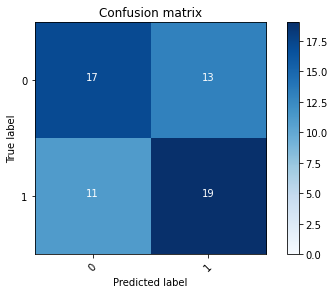

2022-02-17 13:23:36 - [Epoch Train: 81] loss: 0.0189, auc: 0.9997, acc: 0.9918, time: 64.00 s            
2022-02-17 13:23:36 - [Epoch Valid: 81] loss: 3.2894, auc: 0.6744, acc: 0.6000, time: 8.00 s


 27%|██████████▎                           | 81/300 [1:34:25<4:18:10, 70.73s/it]

2022-02-17 13:23:36 - EPOCH: 82
2022-02-17 13:23:37 - Train Step 10/486, train_loss: 0.0014
2022-02-17 13:23:39 - Train Step 20/486, train_loss: 0.0202
2022-02-17 13:23:40 - Train Step 30/486, train_loss: 0.0254
2022-02-17 13:23:41 - Train Step 40/486, train_loss: 0.0197
2022-02-17 13:23:42 - Train Step 50/486, train_loss: 0.0342
2022-02-17 13:23:44 - Train Step 60/486, train_loss: 0.0286
2022-02-17 13:23:45 - Train Step 70/486, train_loss: 0.0935
2022-02-17 13:23:46 - Train Step 80/486, train_loss: 0.0829
2022-02-17 13:23:48 - Train Step 90/486, train_loss: 0.0783
2022-02-17 13:23:49 - Train Step 100/486, train_loss: 0.0705
2022-02-17 13:23:50 - Train Step 110/486, train_loss: 0.0642
2022-02-17 13:23:51 - Train Step 120/486, train_loss: 0.0617
2022-02-17 13:23:53 - Train Step 130/486, train_loss: 0.0579
2022-02-17 13:23:54 - Train Step 140/486, train_loss: 0.0538
2022-02-17 13:23:55 - Train Step 150/486, train_loss: 0.0505
2022-02-17 13:23:56 - Train Step 160/486, train_loss: 0.0477
2

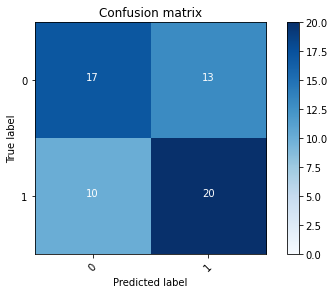

2022-02-17 13:24:45 - [Epoch Train: 82] loss: 0.0185, auc: 0.9993, acc: 0.9979, time: 61.00 s            
2022-02-17 13:24:45 - [Epoch Valid: 82] loss: 3.2375, auc: 0.6467, acc: 0.6167, time: 7.00 s


 27%|██████████▍                           | 82/300 [1:35:34<4:15:37, 70.35s/it]

2022-02-17 13:24:45 - EPOCH: 83
2022-02-17 13:24:47 - Train Step 10/486, train_loss: 0.0093
2022-02-17 13:24:48 - Train Step 20/486, train_loss: 0.0047
2022-02-17 13:24:49 - Train Step 30/486, train_loss: 0.0037
2022-02-17 13:24:50 - Train Step 40/486, train_loss: 0.0043
2022-02-17 13:24:52 - Train Step 50/486, train_loss: 0.0070
2022-02-17 13:24:53 - Train Step 60/486, train_loss: 0.0128
2022-02-17 13:24:54 - Train Step 70/486, train_loss: 0.0114
2022-02-17 13:24:55 - Train Step 80/486, train_loss: 0.0104
2022-02-17 13:24:57 - Train Step 90/486, train_loss: 0.0093
2022-02-17 13:24:58 - Train Step 100/486, train_loss: 0.0085
2022-02-17 13:24:59 - Train Step 110/486, train_loss: 0.0097
2022-02-17 13:25:01 - Train Step 120/486, train_loss: 0.0089
2022-02-17 13:25:02 - Train Step 130/486, train_loss: 0.0097
2022-02-17 13:25:03 - Train Step 140/486, train_loss: 0.0091
2022-02-17 13:25:04 - Train Step 150/486, train_loss: 0.0086
2022-02-17 13:25:06 - Train Step 160/486, train_loss: 0.0107
2

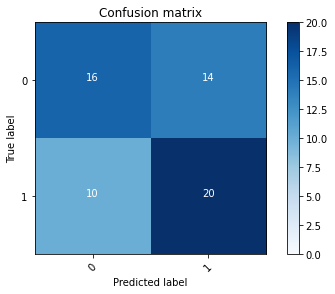

2022-02-17 13:25:56 - [Epoch Train: 83] loss: 0.0331, auc: 0.9993, acc: 0.9897, time: 62.00 s            
2022-02-17 13:25:56 - [Epoch Valid: 83] loss: 2.7603, auc: 0.6144, acc: 0.6000, time: 8.00 s


 28%|██████████▌                           | 83/300 [1:36:45<4:15:09, 70.55s/it]

2022-02-17 13:25:56 - EPOCH: 84
2022-02-17 13:25:58 - Train Step 10/486, train_loss: 0.0001
2022-02-17 13:25:59 - Train Step 20/486, train_loss: 0.0283
2022-02-17 13:26:00 - Train Step 30/486, train_loss: 0.0227
2022-02-17 13:26:02 - Train Step 40/486, train_loss: 0.0181
2022-02-17 13:26:03 - Train Step 50/486, train_loss: 0.0146
2022-02-17 13:26:04 - Train Step 60/486, train_loss: 0.0130
2022-02-17 13:26:05 - Train Step 70/486, train_loss: 0.0117
2022-02-17 13:26:07 - Train Step 80/486, train_loss: 0.0104
2022-02-17 13:26:08 - Train Step 90/486, train_loss: 0.0094
2022-02-17 13:26:09 - Train Step 100/486, train_loss: 0.0090
2022-02-17 13:26:11 - Train Step 110/486, train_loss: 0.0121
2022-02-17 13:26:12 - Train Step 120/486, train_loss: 0.0127
2022-02-17 13:26:13 - Train Step 130/486, train_loss: 0.0133
2022-02-17 13:26:15 - Train Step 140/486, train_loss: 0.0133
2022-02-17 13:26:16 - Train Step 150/486, train_loss: 0.0125
2022-02-17 13:26:17 - Train Step 160/486, train_loss: 0.0118
2

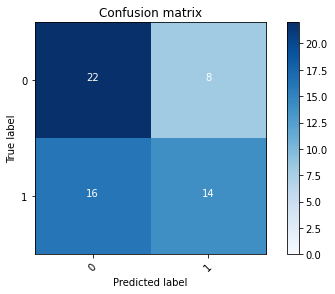

2022-02-17 13:27:10 - [Epoch Train: 84] loss: 0.0205, auc: 0.9997, acc: 0.9877, time: 65.00 s            
2022-02-17 13:27:10 - [Epoch Valid: 84] loss: 3.2271, auc: 0.6189, acc: 0.6000, time: 8.00 s


 28%|██████████▋                           | 84/300 [1:37:59<4:17:19, 71.48s/it]

2022-02-17 13:27:10 - EPOCH: 85
2022-02-17 13:27:12 - Train Step 10/486, train_loss: 0.0688
2022-02-17 13:27:13 - Train Step 20/486, train_loss: 0.0351
2022-02-17 13:27:15 - Train Step 30/486, train_loss: 0.0238
2022-02-17 13:27:16 - Train Step 40/486, train_loss: 0.0180
2022-02-17 13:27:17 - Train Step 50/486, train_loss: 0.0237
2022-02-17 13:27:19 - Train Step 60/486, train_loss: 0.0199
2022-02-17 13:27:20 - Train Step 70/486, train_loss: 0.0179
2022-02-17 13:27:21 - Train Step 80/486, train_loss: 0.0164
2022-02-17 13:27:23 - Train Step 90/486, train_loss: 0.0169
2022-02-17 13:27:24 - Train Step 100/486, train_loss: 0.0154
2022-02-17 13:27:25 - Train Step 110/486, train_loss: 0.0141
2022-02-17 13:27:26 - Train Step 120/486, train_loss: 0.0136
2022-02-17 13:27:28 - Train Step 130/486, train_loss: 0.0128
2022-02-17 13:27:29 - Train Step 140/486, train_loss: 0.0132
2022-02-17 13:27:30 - Train Step 150/486, train_loss: 0.0124
2022-02-17 13:27:32 - Train Step 160/486, train_loss: 0.0118
2

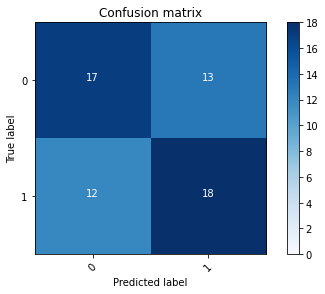

2022-02-17 13:28:22 - [Epoch Train: 85] loss: 0.0086, auc: 1.0000, acc: 0.9979, time: 64.00 s            
2022-02-17 13:28:22 - [Epoch Valid: 85] loss: 3.3580, auc: 0.6456, acc: 0.5833, time: 8.00 s


 28%|██████████▊                           | 85/300 [1:39:11<4:16:59, 71.72s/it]

2022-02-17 13:28:22 - EPOCH: 86
2022-02-17 13:28:24 - Train Step 10/486, train_loss: 0.0038
2022-02-17 13:28:25 - Train Step 20/486, train_loss: 0.0021
2022-02-17 13:28:26 - Train Step 30/486, train_loss: 0.0022
2022-02-17 13:28:28 - Train Step 40/486, train_loss: 0.0017
2022-02-17 13:28:29 - Train Step 50/486, train_loss: 0.0093
2022-02-17 13:28:30 - Train Step 60/486, train_loss: 0.0082
2022-02-17 13:28:32 - Train Step 70/486, train_loss: 0.0092
2022-02-17 13:28:33 - Train Step 80/486, train_loss: 0.0081
2022-02-17 13:28:34 - Train Step 90/486, train_loss: 0.0072
2022-02-17 13:28:36 - Train Step 100/486, train_loss: 0.0065
2022-02-17 13:28:37 - Train Step 110/486, train_loss: 0.0059
2022-02-17 13:28:38 - Train Step 120/486, train_loss: 0.0086
2022-02-17 13:28:40 - Train Step 130/486, train_loss: 0.0134
2022-02-17 13:28:41 - Train Step 140/486, train_loss: 0.0125
2022-02-17 13:28:42 - Train Step 150/486, train_loss: 0.0117
2022-02-17 13:28:43 - Train Step 160/486, train_loss: 0.0113
2

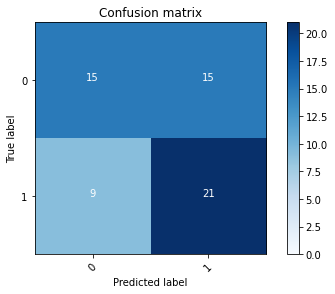

2022-02-17 13:29:34 - [Epoch Train: 86] loss: 0.0058, auc: 1.0000, acc: 1.0000, time: 63.00 s            
2022-02-17 13:29:34 - [Epoch Valid: 86] loss: 3.3060, auc: 0.6489, acc: 0.6000, time: 7.00 s


 29%|██████████▉                           | 86/300 [1:40:22<4:15:34, 71.66s/it]

2022-02-17 13:29:34 - EPOCH: 87
2022-02-17 13:29:35 - Train Step 10/486, train_loss: 0.0038
2022-02-17 13:29:37 - Train Step 20/486, train_loss: 0.0023
2022-02-17 13:29:38 - Train Step 30/486, train_loss: 0.0022
2022-02-17 13:29:39 - Train Step 40/486, train_loss: 0.0113
2022-02-17 13:29:40 - Train Step 50/486, train_loss: 0.0090
2022-02-17 13:29:42 - Train Step 60/486, train_loss: 0.0076
2022-02-17 13:29:43 - Train Step 70/486, train_loss: 0.0065
2022-02-17 13:29:44 - Train Step 80/486, train_loss: 0.0062
2022-02-17 13:29:45 - Train Step 90/486, train_loss: 0.0059
2022-02-17 13:29:47 - Train Step 100/486, train_loss: 0.0078
2022-02-17 13:29:48 - Train Step 110/486, train_loss: 0.0072
2022-02-17 13:29:49 - Train Step 120/486, train_loss: 0.0067
2022-02-17 13:29:50 - Train Step 130/486, train_loss: 0.0088
2022-02-17 13:29:52 - Train Step 140/486, train_loss: 0.0083
2022-02-17 13:29:53 - Train Step 150/486, train_loss: 0.0077
2022-02-17 13:29:54 - Train Step 160/486, train_loss: 0.0073
2

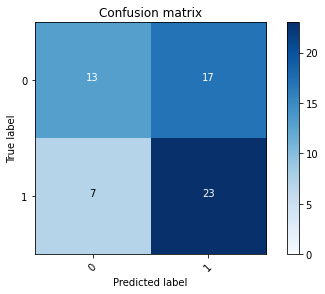

2022-02-17 13:30:44 - [Epoch Train: 87] loss: 0.0055, auc: 1.0000, acc: 0.9979, time: 61.00 s            
2022-02-17 13:30:44 - [Epoch Valid: 87] loss: 3.4280, auc: 0.6511, acc: 0.6000, time: 8.00 s


 29%|███████████                           | 87/300 [1:41:32<4:12:13, 71.05s/it]

2022-02-17 13:30:44 - EPOCH: 88
2022-02-17 13:30:45 - Train Step 10/486, train_loss: 0.0399
2022-02-17 13:30:46 - Train Step 20/486, train_loss: 0.0261
2022-02-17 13:30:47 - Train Step 30/486, train_loss: 0.0196
2022-02-17 13:30:49 - Train Step 40/486, train_loss: 0.0152
2022-02-17 13:30:50 - Train Step 50/486, train_loss: 0.0139
2022-02-17 13:30:51 - Train Step 60/486, train_loss: 0.0116
2022-02-17 13:30:53 - Train Step 70/486, train_loss: 0.0099
2022-02-17 13:30:54 - Train Step 80/486, train_loss: 0.0225
2022-02-17 13:30:55 - Train Step 90/486, train_loss: 0.0200
2022-02-17 13:30:56 - Train Step 100/486, train_loss: 0.0210
2022-02-17 13:30:58 - Train Step 110/486, train_loss: 0.0203
2022-02-17 13:30:59 - Train Step 120/486, train_loss: 0.0187
2022-02-17 13:31:00 - Train Step 130/486, train_loss: 0.0172
2022-02-17 13:31:02 - Train Step 140/486, train_loss: 0.0161
2022-02-17 13:31:03 - Train Step 150/486, train_loss: 0.0153
2022-02-17 13:31:04 - Train Step 160/486, train_loss: 0.0144
2

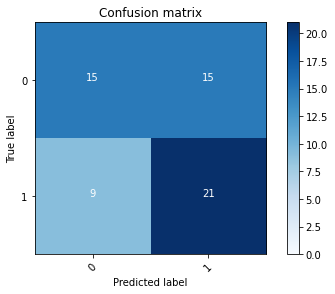

2022-02-17 13:31:53 - [Epoch Train: 88] loss: 0.0092, auc: 1.0000, acc: 0.9979, time: 61.00 s            
2022-02-17 13:31:53 - [Epoch Valid: 88] loss: 3.0911, auc: 0.6539, acc: 0.6000, time: 8.00 s


 29%|███████████▏                          | 88/300 [1:42:42<4:09:41, 70.67s/it]

2022-02-17 13:31:53 - EPOCH: 89
2022-02-17 13:31:55 - Train Step 10/486, train_loss: 0.0032
2022-02-17 13:31:56 - Train Step 20/486, train_loss: 0.0016
2022-02-17 13:31:57 - Train Step 30/486, train_loss: 0.0026
2022-02-17 13:31:58 - Train Step 40/486, train_loss: 0.0020
2022-02-17 13:32:00 - Train Step 50/486, train_loss: 0.0017
2022-02-17 13:32:01 - Train Step 60/486, train_loss: 0.0066
2022-02-17 13:32:02 - Train Step 70/486, train_loss: 0.0057
2022-02-17 13:32:03 - Train Step 80/486, train_loss: 0.0050
2022-02-17 13:32:05 - Train Step 90/486, train_loss: 0.0045
2022-02-17 13:32:06 - Train Step 100/486, train_loss: 0.0042
2022-02-17 13:32:07 - Train Step 110/486, train_loss: 0.0039
2022-02-17 13:32:08 - Train Step 120/486, train_loss: 0.0036
2022-02-17 13:32:10 - Train Step 130/486, train_loss: 0.0035
2022-02-17 13:32:11 - Train Step 140/486, train_loss: 0.0059
2022-02-17 13:32:12 - Train Step 150/486, train_loss: 0.0056
2022-02-17 13:32:13 - Train Step 160/486, train_loss: 0.0052
2

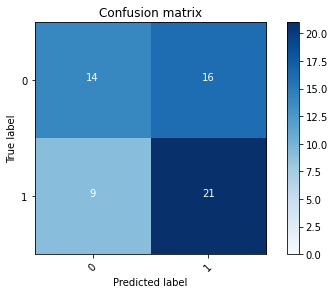

2022-02-17 13:33:03 - [Epoch Train: 89] loss: 0.0069, auc: 0.9999, acc: 0.9979, time: 61.00 s            
2022-02-17 13:33:03 - [Epoch Valid: 89] loss: 3.2417, auc: 0.6411, acc: 0.5833, time: 8.00 s


 30%|███████████▎                          | 89/300 [1:43:52<4:07:49, 70.47s/it]

2022-02-17 13:33:03 - EPOCH: 90
2022-02-17 13:33:05 - Train Step 10/486, train_loss: 0.0036
2022-02-17 13:33:06 - Train Step 20/486, train_loss: 0.0021
2022-02-17 13:33:07 - Train Step 30/486, train_loss: 0.0017
2022-02-17 13:33:08 - Train Step 40/486, train_loss: 0.0013
2022-02-17 13:33:10 - Train Step 50/486, train_loss: 0.0011
2022-02-17 13:33:11 - Train Step 60/486, train_loss: 0.0010
2022-02-17 13:33:12 - Train Step 70/486, train_loss: 0.0009
2022-02-17 13:33:13 - Train Step 80/486, train_loss: 0.0010
2022-02-17 13:33:15 - Train Step 90/486, train_loss: 0.0009
2022-02-17 13:33:16 - Train Step 100/486, train_loss: 0.0009
2022-02-17 13:33:17 - Train Step 110/486, train_loss: 0.0009
2022-02-17 13:33:18 - Train Step 120/486, train_loss: 0.0008
2022-02-17 13:33:20 - Train Step 130/486, train_loss: 0.0009
2022-02-17 13:33:21 - Train Step 140/486, train_loss: 0.0009
2022-02-17 13:33:22 - Train Step 150/486, train_loss: 0.0008
2022-02-17 13:33:23 - Train Step 160/486, train_loss: 0.0008
2

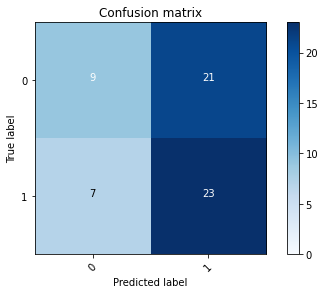

2022-02-17 13:34:13 - [Epoch Train: 90] loss: 0.0425, auc: 0.9992, acc: 0.9835, time: 61.00 s            
2022-02-17 13:34:13 - [Epoch Valid: 90] loss: 3.5150, auc: 0.5900, acc: 0.5333, time: 8.00 s


 30%|███████████▍                          | 90/300 [1:45:01<4:05:34, 70.16s/it]

2022-02-17 13:34:13 - EPOCH: 91
2022-02-17 13:34:14 - Train Step 10/486, train_loss: 0.0111
2022-02-17 13:34:15 - Train Step 20/486, train_loss: 0.0057
2022-02-17 13:34:17 - Train Step 30/486, train_loss: 0.0454
2022-02-17 13:34:18 - Train Step 40/486, train_loss: 0.0349
2022-02-17 13:34:19 - Train Step 50/486, train_loss: 0.0309
2022-02-17 13:34:20 - Train Step 60/486, train_loss: 0.0460
2022-02-17 13:34:22 - Train Step 70/486, train_loss: 0.0492
2022-02-17 13:34:23 - Train Step 80/486, train_loss: 0.0444
2022-02-17 13:34:24 - Train Step 90/486, train_loss: 0.0395
2022-02-17 13:34:25 - Train Step 100/486, train_loss: 0.0382
2022-02-17 13:34:27 - Train Step 110/486, train_loss: 0.0350
2022-02-17 13:34:28 - Train Step 120/486, train_loss: 0.0332
2022-02-17 13:34:29 - Train Step 130/486, train_loss: 0.0357
2022-02-17 13:34:30 - Train Step 140/486, train_loss: 0.0334
2022-02-17 13:34:32 - Train Step 150/486, train_loss: 0.0318
2022-02-17 13:34:33 - Train Step 160/486, train_loss: 0.0321
2

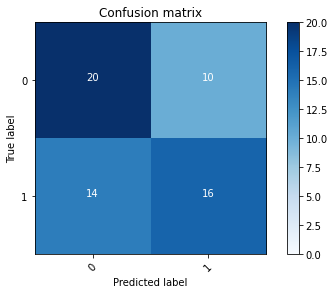

2022-02-17 13:35:22 - [Epoch Train: 91] loss: 0.0191, auc: 0.9999, acc: 0.9959, time: 60.00 s            
2022-02-17 13:35:22 - [Epoch Valid: 91] loss: 3.1200, auc: 0.6400, acc: 0.6000, time: 8.00 s


 30%|███████████▌                          | 91/300 [1:46:10<4:03:10, 69.81s/it]

2022-02-17 13:35:22 - EPOCH: 92
2022-02-17 13:35:23 - Train Step 10/486, train_loss: 0.0129
2022-02-17 13:35:24 - Train Step 20/486, train_loss: 0.0065
2022-02-17 13:35:26 - Train Step 30/486, train_loss: 0.0085
2022-02-17 13:35:27 - Train Step 40/486, train_loss: 0.0084
2022-02-17 13:35:28 - Train Step 50/486, train_loss: 0.0143
2022-02-17 13:35:30 - Train Step 60/486, train_loss: 0.0137
2022-02-17 13:35:31 - Train Step 70/486, train_loss: 0.0118
2022-02-17 13:35:32 - Train Step 80/486, train_loss: 0.0104
2022-02-17 13:35:34 - Train Step 90/486, train_loss: 0.0095
2022-02-17 13:35:35 - Train Step 100/486, train_loss: 0.0107
2022-02-17 13:35:36 - Train Step 110/486, train_loss: 0.0099
2022-02-17 13:35:37 - Train Step 120/486, train_loss: 0.0093
2022-02-17 13:35:39 - Train Step 130/486, train_loss: 0.0115
2022-02-17 13:35:40 - Train Step 140/486, train_loss: 0.0108
2022-02-17 13:35:41 - Train Step 150/486, train_loss: 0.0102
2022-02-17 13:35:42 - Train Step 160/486, train_loss: 0.0096
2

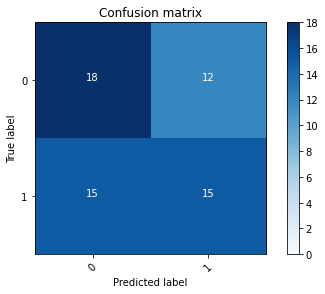

2022-02-17 13:36:33 - [Epoch Train: 92] loss: 0.0069, auc: 1.0000, acc: 1.0000, time: 62.00 s            
2022-02-17 13:36:33 - [Epoch Valid: 92] loss: 3.7795, auc: 0.6122, acc: 0.5500, time: 8.00 s


 31%|███████████▋                          | 92/300 [1:47:21<4:03:09, 70.14s/it]

2022-02-17 13:36:33 - EPOCH: 93
2022-02-17 13:36:34 - Train Step 10/486, train_loss: 0.0125
2022-02-17 13:36:35 - Train Step 20/486, train_loss: 0.0260
2022-02-17 13:36:37 - Train Step 30/486, train_loss: 0.0189
2022-02-17 13:36:38 - Train Step 40/486, train_loss: 0.0156
2022-02-17 13:36:39 - Train Step 50/486, train_loss: 0.0133
2022-02-17 13:36:41 - Train Step 60/486, train_loss: 0.0111
2022-02-17 13:36:42 - Train Step 70/486, train_loss: 0.0097
2022-02-17 13:36:43 - Train Step 80/486, train_loss: 0.0089
2022-02-17 13:36:44 - Train Step 90/486, train_loss: 0.0080
2022-02-17 13:36:46 - Train Step 100/486, train_loss: 0.0073
2022-02-17 13:36:47 - Train Step 110/486, train_loss: 0.0071
2022-02-17 13:36:48 - Train Step 120/486, train_loss: 0.0069
2022-02-17 13:36:50 - Train Step 130/486, train_loss: 0.0064
2022-02-17 13:36:51 - Train Step 140/486, train_loss: 0.0061
2022-02-17 13:36:52 - Train Step 150/486, train_loss: 0.0058
2022-02-17 13:36:54 - Train Step 160/486, train_loss: 0.0054
2

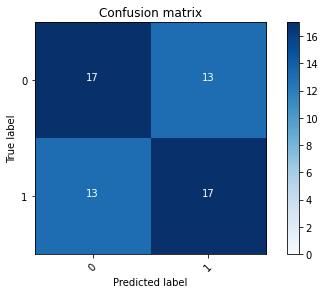

2022-02-17 13:37:45 - [Epoch Train: 93] loss: 0.0077, auc: 0.9999, acc: 0.9979, time: 64.00 s            
2022-02-17 13:37:45 - [Epoch Valid: 93] loss: 3.7442, auc: 0.6222, acc: 0.5667, time: 8.00 s


 31%|███████████▊                          | 93/300 [1:48:34<4:04:33, 70.89s/it]

2022-02-17 13:37:45 - EPOCH: 94
2022-02-17 13:37:47 - Train Step 10/486, train_loss: 0.0004
2022-02-17 13:37:48 - Train Step 20/486, train_loss: 0.0002
2022-02-17 13:37:49 - Train Step 30/486, train_loss: 0.0074
2022-02-17 13:37:51 - Train Step 40/486, train_loss: 0.0067
2022-02-17 13:37:52 - Train Step 50/486, train_loss: 0.0131
2022-02-17 13:37:53 - Train Step 60/486, train_loss: 0.0109
2022-02-17 13:37:54 - Train Step 70/486, train_loss: 0.0102
2022-02-17 13:37:56 - Train Step 80/486, train_loss: 0.0089
2022-02-17 13:37:57 - Train Step 90/486, train_loss: 0.0080
2022-02-17 13:37:58 - Train Step 100/486, train_loss: 0.0073
2022-02-17 13:38:00 - Train Step 110/486, train_loss: 0.0067
2022-02-17 13:38:01 - Train Step 120/486, train_loss: 0.0062
2022-02-17 13:38:02 - Train Step 130/486, train_loss: 0.0058
2022-02-17 13:38:03 - Train Step 140/486, train_loss: 0.0054
2022-02-17 13:38:05 - Train Step 150/486, train_loss: 0.0053
2022-02-17 13:38:06 - Train Step 160/486, train_loss: 0.0050
2

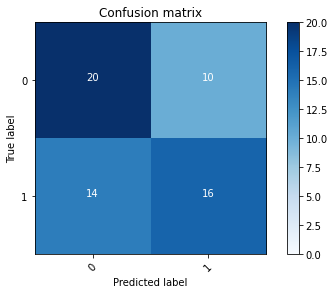

2022-02-17 13:38:57 - [Epoch Train: 94] loss: 0.0172, auc: 0.9998, acc: 0.9897, time: 63.00 s            
2022-02-17 13:38:57 - [Epoch Valid: 94] loss: 3.4119, auc: 0.6394, acc: 0.6000, time: 8.00 s


 31%|███████████▉                          | 94/300 [1:49:45<4:03:45, 71.00s/it]

2022-02-17 13:38:57 - EPOCH: 95
2022-02-17 13:38:58 - Train Step 10/486, train_loss: 0.0032
2022-02-17 13:38:59 - Train Step 20/486, train_loss: 0.1214
2022-02-17 13:39:01 - Train Step 30/486, train_loss: 0.0822
2022-02-17 13:39:02 - Train Step 40/486, train_loss: 0.0625
2022-02-17 13:39:03 - Train Step 50/486, train_loss: 0.0609
2022-02-17 13:39:05 - Train Step 60/486, train_loss: 0.0514
2022-02-17 13:39:06 - Train Step 70/486, train_loss: 0.0514
2022-02-17 13:39:07 - Train Step 80/486, train_loss: 0.0459
2022-02-17 13:39:08 - Train Step 90/486, train_loss: 0.0411
2022-02-17 13:39:10 - Train Step 100/486, train_loss: 0.0376
2022-02-17 13:39:11 - Train Step 110/486, train_loss: 0.0354
2022-02-17 13:39:12 - Train Step 120/486, train_loss: 0.0335
2022-02-17 13:39:13 - Train Step 130/486, train_loss: 0.0310
2022-02-17 13:39:15 - Train Step 140/486, train_loss: 0.0291
2022-02-17 13:39:16 - Train Step 150/486, train_loss: 0.0272
2022-02-17 13:39:17 - Train Step 160/486, train_loss: 0.0256
2

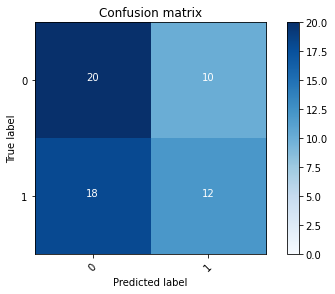

2022-02-17 13:40:08 - [Epoch Train: 95] loss: 0.0244, auc: 0.9997, acc: 0.9918, time: 62.00 s            
2022-02-17 13:40:08 - [Epoch Valid: 95] loss: 3.1293, auc: 0.6278, acc: 0.5333, time: 8.00 s


 32%|████████████                          | 95/300 [1:50:56<4:02:40, 71.03s/it]

2022-02-17 13:40:08 - EPOCH: 96
2022-02-17 13:40:09 - Train Step 10/486, train_loss: 0.0090
2022-02-17 13:40:10 - Train Step 20/486, train_loss: 0.0223
2022-02-17 13:40:12 - Train Step 30/486, train_loss: 0.0151
2022-02-17 13:40:13 - Train Step 40/486, train_loss: 0.0244
2022-02-17 13:40:14 - Train Step 50/486, train_loss: 0.0271
2022-02-17 13:40:16 - Train Step 60/486, train_loss: 0.0260
2022-02-17 13:40:17 - Train Step 70/486, train_loss: 0.0252
2022-02-17 13:40:18 - Train Step 80/486, train_loss: 0.0222
2022-02-17 13:40:19 - Train Step 90/486, train_loss: 0.0205
2022-02-17 13:40:21 - Train Step 100/486, train_loss: 0.0186
2022-02-17 13:40:22 - Train Step 110/486, train_loss: 0.0170
2022-02-17 13:40:23 - Train Step 120/486, train_loss: 0.0162
2022-02-17 13:40:24 - Train Step 130/486, train_loss: 0.0150
2022-02-17 13:40:26 - Train Step 140/486, train_loss: 0.0141
2022-02-17 13:40:27 - Train Step 150/486, train_loss: 0.0170
2022-02-17 13:40:28 - Train Step 160/486, train_loss: 0.0160
2

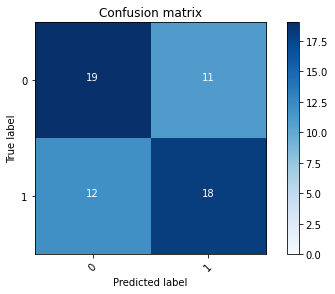

2022-02-17 13:41:19 - [Epoch Train: 96] loss: 0.0145, auc: 0.9999, acc: 0.9959, time: 62.00 s            
2022-02-17 13:41:19 - [Epoch Valid: 96] loss: 3.6230, auc: 0.6444, acc: 0.6167, time: 8.00 s


 32%|████████████▏                         | 96/300 [1:52:08<4:01:48, 71.12s/it]

2022-02-17 13:41:19 - EPOCH: 97
2022-02-17 13:41:20 - Train Step 10/486, train_loss: 0.0084
2022-02-17 13:41:22 - Train Step 20/486, train_loss: 0.0054
2022-02-17 13:41:23 - Train Step 30/486, train_loss: 0.0039
2022-02-17 13:41:24 - Train Step 40/486, train_loss: 0.0033
2022-02-17 13:41:25 - Train Step 50/486, train_loss: 0.0043
2022-02-17 13:41:27 - Train Step 60/486, train_loss: 0.0043
2022-02-17 13:41:28 - Train Step 70/486, train_loss: 0.0037
2022-02-17 13:41:29 - Train Step 80/486, train_loss: 0.0037
2022-02-17 13:41:31 - Train Step 90/486, train_loss: 0.0033
2022-02-17 13:41:32 - Train Step 100/486, train_loss: 0.0030
2022-02-17 13:41:33 - Train Step 110/486, train_loss: 0.0028
2022-02-17 13:41:34 - Train Step 120/486, train_loss: 0.0026
2022-02-17 13:41:36 - Train Step 130/486, train_loss: 0.0052
2022-02-17 13:41:37 - Train Step 140/486, train_loss: 0.0048
2022-02-17 13:41:38 - Train Step 150/486, train_loss: 0.0046
2022-02-17 13:41:40 - Train Step 160/486, train_loss: 0.0043
2

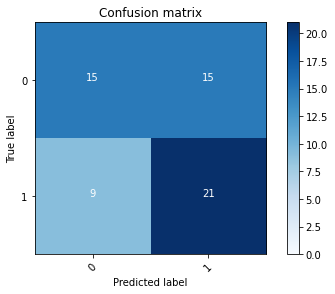

2022-02-17 13:42:31 - [Epoch Train: 97] loss: 0.0067, auc: 1.0000, acc: 0.9979, time: 64.00 s            
2022-02-17 13:42:31 - [Epoch Valid: 97] loss: 3.1469, auc: 0.6544, acc: 0.6000, time: 8.00 s


 32%|████████████▎                         | 97/300 [1:53:20<4:01:36, 71.41s/it]

2022-02-17 13:42:31 - EPOCH: 98
2022-02-17 13:42:32 - Train Step 10/486, train_loss: 0.0062
2022-02-17 13:42:34 - Train Step 20/486, train_loss: 0.0031
2022-02-17 13:42:35 - Train Step 30/486, train_loss: 0.0027
2022-02-17 13:42:36 - Train Step 40/486, train_loss: 0.0025
2022-02-17 13:42:38 - Train Step 50/486, train_loss: 0.0021
2022-02-17 13:42:39 - Train Step 60/486, train_loss: 0.0018
2022-02-17 13:42:40 - Train Step 70/486, train_loss: 0.0025
2022-02-17 13:42:42 - Train Step 80/486, train_loss: 0.0022
2022-02-17 13:42:43 - Train Step 90/486, train_loss: 0.0020
2022-02-17 13:42:44 - Train Step 100/486, train_loss: 0.0023
2022-02-17 13:42:46 - Train Step 110/486, train_loss: 0.0053
2022-02-17 13:42:47 - Train Step 120/486, train_loss: 0.0052
2022-02-17 13:42:49 - Train Step 130/486, train_loss: 0.0050
2022-02-17 13:42:50 - Train Step 140/486, train_loss: 0.0047
2022-02-17 13:42:51 - Train Step 150/486, train_loss: 0.0044
2022-02-17 13:42:52 - Train Step 160/486, train_loss: 0.0042
2

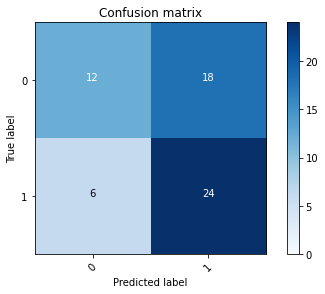

2022-02-17 13:43:45 - [Epoch Train: 98] loss: 0.0085, auc: 1.0000, acc: 0.9979, time: 65.00 s            
2022-02-17 13:43:45 - [Epoch Valid: 98] loss: 3.0844, auc: 0.6400, acc: 0.6000, time: 8.00 s


 33%|████████████▍                         | 98/300 [1:54:33<4:02:37, 72.07s/it]

2022-02-17 13:43:45 - EPOCH: 99
2022-02-17 13:43:46 - Train Step 10/486, train_loss: 0.0022
2022-02-17 13:43:47 - Train Step 20/486, train_loss: 0.0012
2022-02-17 13:43:49 - Train Step 30/486, train_loss: 0.0021
2022-02-17 13:43:50 - Train Step 40/486, train_loss: 0.0018
2022-02-17 13:43:51 - Train Step 50/486, train_loss: 0.0086
2022-02-17 13:43:53 - Train Step 60/486, train_loss: 0.0072
2022-02-17 13:43:54 - Train Step 70/486, train_loss: 0.0063
2022-02-17 13:43:55 - Train Step 80/486, train_loss: 0.0055
2022-02-17 13:43:56 - Train Step 90/486, train_loss: 0.0049
2022-02-17 13:43:58 - Train Step 100/486, train_loss: 0.0044
2022-02-17 13:43:59 - Train Step 110/486, train_loss: 0.0040
2022-02-17 13:44:00 - Train Step 120/486, train_loss: 0.0094
2022-02-17 13:44:02 - Train Step 130/486, train_loss: 0.0087
2022-02-17 13:44:03 - Train Step 140/486, train_loss: 0.0082
2022-02-17 13:44:04 - Train Step 150/486, train_loss: 0.0077
2022-02-17 13:44:05 - Train Step 160/486, train_loss: 0.0077
2

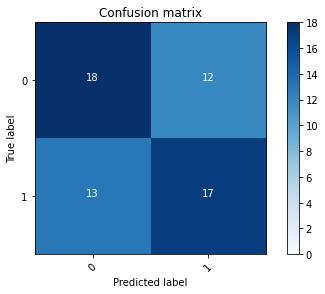

2022-02-17 13:44:56 - [Epoch Train: 99] loss: 0.0108, auc: 1.0000, acc: 0.9959, time: 62.00 s            
2022-02-17 13:44:56 - [Epoch Valid: 99] loss: 3.4987, auc: 0.6156, acc: 0.5833, time: 7.00 s


 33%|████████████▌                         | 99/300 [1:55:44<4:00:18, 71.74s/it]

2022-02-17 13:44:56 - EPOCH: 100
2022-02-17 13:44:57 - Train Step 10/486, train_loss: 0.0008
2022-02-17 13:44:59 - Train Step 20/486, train_loss: 0.0033
2022-02-17 13:45:00 - Train Step 30/486, train_loss: 0.0039
2022-02-17 13:45:02 - Train Step 40/486, train_loss: 0.0032
2022-02-17 13:45:03 - Train Step 50/486, train_loss: 0.0028
2022-02-17 13:45:04 - Train Step 60/486, train_loss: 0.0028
2022-02-17 13:45:06 - Train Step 70/486, train_loss: 0.0024
2022-02-17 13:45:07 - Train Step 80/486, train_loss: 0.0021
2022-02-17 13:45:08 - Train Step 90/486, train_loss: 0.0058
2022-02-17 13:45:10 - Train Step 100/486, train_loss: 0.0077
2022-02-17 13:45:11 - Train Step 110/486, train_loss: 0.0070
2022-02-17 13:45:12 - Train Step 120/486, train_loss: 0.0065
2022-02-17 13:45:14 - Train Step 130/486, train_loss: 0.0088
2022-02-17 13:45:15 - Train Step 140/486, train_loss: 0.0082
2022-02-17 13:45:16 - Train Step 150/486, train_loss: 0.0339
2022-02-17 13:45:18 - Train Step 160/486, train_loss: 0.0318


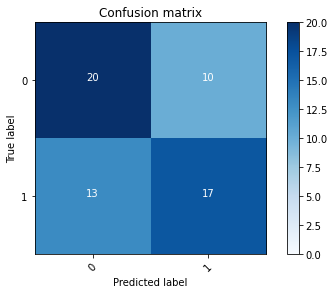

2022-02-17 13:46:08 - [Epoch Train: 100] loss: 0.0304, auc: 0.9990, acc: 0.9897, time: 63.00 s            
2022-02-17 13:46:08 - [Epoch Valid: 100] loss: 2.6048, auc: 0.6267, acc: 0.6167, time: 8.00 s


 33%|████████████▎                        | 100/300 [1:56:56<3:59:28, 71.84s/it]

2022-02-17 13:46:08 - EPOCH: 101
2022-02-17 13:46:09 - Train Step 10/486, train_loss: 0.0127
2022-02-17 13:46:10 - Train Step 20/486, train_loss: 0.0116
2022-02-17 13:46:12 - Train Step 30/486, train_loss: 0.0077
2022-02-17 13:46:13 - Train Step 40/486, train_loss: 0.0061
2022-02-17 13:46:14 - Train Step 50/486, train_loss: 0.0060
2022-02-17 13:46:16 - Train Step 60/486, train_loss: 0.0073
2022-02-17 13:46:17 - Train Step 70/486, train_loss: 0.0068
2022-02-17 13:46:18 - Train Step 80/486, train_loss: 0.0060
2022-02-17 13:46:20 - Train Step 90/486, train_loss: 0.0058
2022-02-17 13:46:21 - Train Step 100/486, train_loss: 0.0054
2022-02-17 13:46:22 - Train Step 110/486, train_loss: 0.0110
2022-02-17 13:46:23 - Train Step 120/486, train_loss: 0.0156
2022-02-17 13:46:25 - Train Step 130/486, train_loss: 0.0148
2022-02-17 13:46:26 - Train Step 140/486, train_loss: 0.0150
2022-02-17 13:46:27 - Train Step 150/486, train_loss: 0.0184
2022-02-17 13:46:29 - Train Step 160/486, train_loss: 0.0219


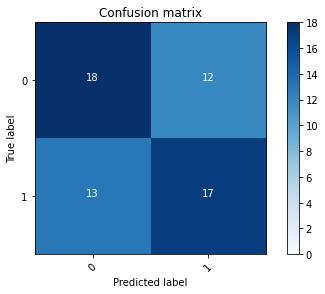

2022-02-17 13:47:18 - [Epoch Train: 101] loss: 0.0260, auc: 0.9996, acc: 0.9835, time: 62.00 s            
2022-02-17 13:47:18 - [Epoch Valid: 101] loss: 3.7920, auc: 0.5878, acc: 0.5833, time: 8.00 s


 34%|████████████▍                        | 101/300 [1:58:07<3:56:58, 71.45s/it]

2022-02-17 13:47:18 - EPOCH: 102
2022-02-17 13:47:20 - Train Step 10/486, train_loss: 0.0010
2022-02-17 13:47:21 - Train Step 20/486, train_loss: 0.0039
2022-02-17 13:47:22 - Train Step 30/486, train_loss: 0.0142
2022-02-17 13:47:24 - Train Step 40/486, train_loss: 0.0161
2022-02-17 13:47:25 - Train Step 50/486, train_loss: 0.0227
2022-02-17 13:47:26 - Train Step 60/486, train_loss: 0.0209
2022-02-17 13:47:28 - Train Step 70/486, train_loss: 0.0233
2022-02-17 13:47:29 - Train Step 80/486, train_loss: 0.0217
2022-02-17 13:47:30 - Train Step 90/486, train_loss: 0.0199
2022-02-17 13:47:31 - Train Step 100/486, train_loss: 0.0216
2022-02-17 13:47:33 - Train Step 110/486, train_loss: 0.0203
2022-02-17 13:47:34 - Train Step 120/486, train_loss: 0.0191
2022-02-17 13:47:35 - Train Step 130/486, train_loss: 0.0177
2022-02-17 13:47:37 - Train Step 140/486, train_loss: 0.0165
2022-02-17 13:47:38 - Train Step 150/486, train_loss: 0.0172
2022-02-17 13:47:39 - Train Step 160/486, train_loss: 0.0193


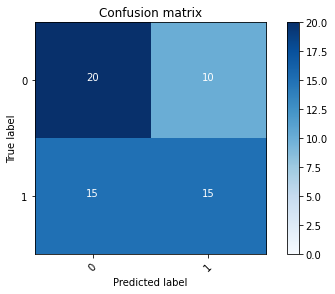

2022-02-17 13:48:31 - [Epoch Train: 102] loss: 0.0106, auc: 1.0000, acc: 0.9979, time: 64.00 s            
2022-02-17 13:48:31 - [Epoch Valid: 102] loss: 3.7544, auc: 0.6044, acc: 0.5833, time: 8.00 s


 34%|████████████▌                        | 102/300 [1:59:20<3:57:00, 71.82s/it]

2022-02-17 13:48:31 - EPOCH: 103
2022-02-17 13:48:32 - Train Step 10/486, train_loss: 0.0002
2022-02-17 13:48:34 - Train Step 20/486, train_loss: 0.0006
2022-02-17 13:48:35 - Train Step 30/486, train_loss: 0.0028
2022-02-17 13:48:36 - Train Step 40/486, train_loss: 0.0055
2022-02-17 13:48:37 - Train Step 50/486, train_loss: 0.0052
2022-02-17 13:48:39 - Train Step 60/486, train_loss: 0.0044
2022-02-17 13:48:40 - Train Step 70/486, train_loss: 0.0038
2022-02-17 13:48:41 - Train Step 80/486, train_loss: 0.0034
2022-02-17 13:48:42 - Train Step 90/486, train_loss: 0.0040
2022-02-17 13:48:44 - Train Step 100/486, train_loss: 0.0036
2022-02-17 13:48:45 - Train Step 110/486, train_loss: 0.0034
2022-02-17 13:48:46 - Train Step 120/486, train_loss: 0.0060
2022-02-17 13:48:48 - Train Step 130/486, train_loss: 0.0056
2022-02-17 13:48:49 - Train Step 140/486, train_loss: 0.0053
2022-02-17 13:48:50 - Train Step 150/486, train_loss: 0.0050
2022-02-17 13:48:51 - Train Step 160/486, train_loss: 0.0050


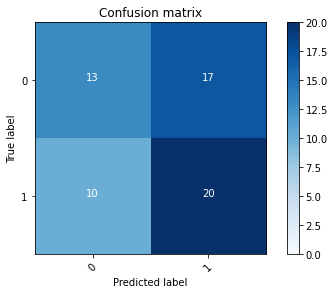

2022-02-17 13:49:42 - [Epoch Train: 103] loss: 0.0177, auc: 1.0000, acc: 0.9959, time: 62.00 s            
2022-02-17 13:49:42 - [Epoch Valid: 103] loss: 3.0004, auc: 0.6144, acc: 0.5500, time: 8.00 s


 34%|████████████▋                        | 103/300 [2:00:31<3:55:00, 71.58s/it]

2022-02-17 13:49:42 - EPOCH: 104
2022-02-17 13:49:43 - Train Step 10/486, train_loss: 0.0030
2022-02-17 13:49:45 - Train Step 20/486, train_loss: 0.0062
2022-02-17 13:49:46 - Train Step 30/486, train_loss: 0.0042
2022-02-17 13:49:47 - Train Step 40/486, train_loss: 0.0032
2022-02-17 13:49:48 - Train Step 50/486, train_loss: 0.0027
2022-02-17 13:49:50 - Train Step 60/486, train_loss: 0.0038
2022-02-17 13:49:51 - Train Step 70/486, train_loss: 0.0033
2022-02-17 13:49:52 - Train Step 80/486, train_loss: 0.0029
2022-02-17 13:49:53 - Train Step 90/486, train_loss: 0.0027
2022-02-17 13:49:55 - Train Step 100/486, train_loss: 0.0033
2022-02-17 13:49:56 - Train Step 110/486, train_loss: 0.0030
2022-02-17 13:49:57 - Train Step 120/486, train_loss: 0.0120
2022-02-17 13:49:58 - Train Step 130/486, train_loss: 0.0111
2022-02-17 13:50:00 - Train Step 140/486, train_loss: 0.0128
2022-02-17 13:50:01 - Train Step 150/486, train_loss: 0.0144
2022-02-17 13:50:02 - Train Step 160/486, train_loss: 0.0140


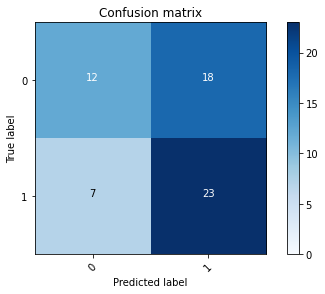

2022-02-17 13:50:52 - [Epoch Train: 104] loss: 0.0131, auc: 0.9999, acc: 0.9918, time: 61.00 s            
2022-02-17 13:50:52 - [Epoch Valid: 104] loss: 3.3572, auc: 0.6244, acc: 0.5833, time: 8.00 s


 35%|████████████▊                        | 104/300 [2:01:40<3:51:59, 71.02s/it]

2022-02-17 13:50:52 - EPOCH: 105
2022-02-17 13:50:53 - Train Step 10/486, train_loss: 0.0002
2022-02-17 13:50:54 - Train Step 20/486, train_loss: 0.0002
2022-02-17 13:50:56 - Train Step 30/486, train_loss: 0.0007
2022-02-17 13:50:57 - Train Step 40/486, train_loss: 0.0006
2022-02-17 13:50:58 - Train Step 50/486, train_loss: 0.0005
2022-02-17 13:50:59 - Train Step 60/486, train_loss: 0.0021
2022-02-17 13:51:01 - Train Step 70/486, train_loss: 0.0018
2022-02-17 13:51:02 - Train Step 80/486, train_loss: 0.0019
2022-02-17 13:51:03 - Train Step 90/486, train_loss: 0.0018
2022-02-17 13:51:05 - Train Step 100/486, train_loss: 0.0016
2022-02-17 13:51:06 - Train Step 110/486, train_loss: 0.0019
2022-02-17 13:51:07 - Train Step 120/486, train_loss: 0.0019
2022-02-17 13:51:09 - Train Step 130/486, train_loss: 0.0019
2022-02-17 13:51:10 - Train Step 140/486, train_loss: 0.0024
2022-02-17 13:51:11 - Train Step 150/486, train_loss: 0.0023
2022-02-17 13:51:13 - Train Step 160/486, train_loss: 0.0022


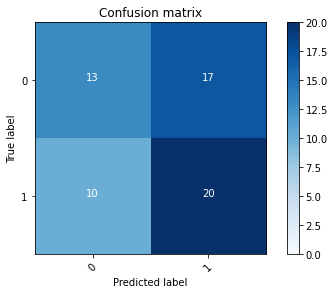

2022-02-17 13:52:04 - [Epoch Train: 105] loss: 0.0057, auc: 1.0000, acc: 1.0000, time: 63.00 s            
2022-02-17 13:52:04 - [Epoch Valid: 105] loss: 3.7648, auc: 0.6156, acc: 0.5500, time: 8.00 s


 35%|████████████▉                        | 105/300 [2:02:53<3:52:20, 71.49s/it]

2022-02-17 13:52:04 - EPOCH: 106
2022-02-17 13:52:06 - Train Step 10/486, train_loss: 0.0123
2022-02-17 13:52:07 - Train Step 20/486, train_loss: 0.0066
2022-02-17 13:52:08 - Train Step 30/486, train_loss: 0.0053
2022-02-17 13:52:10 - Train Step 40/486, train_loss: 0.0040
2022-02-17 13:52:11 - Train Step 50/486, train_loss: 0.0036
2022-02-17 13:52:12 - Train Step 60/486, train_loss: 0.0030
2022-02-17 13:52:13 - Train Step 70/486, train_loss: 0.0078
2022-02-17 13:52:15 - Train Step 80/486, train_loss: 0.0070
2022-02-17 13:52:16 - Train Step 90/486, train_loss: 0.0062
2022-02-17 13:52:17 - Train Step 100/486, train_loss: 0.0056
2022-02-17 13:52:19 - Train Step 110/486, train_loss: 0.0053
2022-02-17 13:52:20 - Train Step 120/486, train_loss: 0.0049
2022-02-17 13:52:21 - Train Step 130/486, train_loss: 0.0045
2022-02-17 13:52:22 - Train Step 140/486, train_loss: 0.0042
2022-02-17 13:52:24 - Train Step 150/486, train_loss: 0.0040
2022-02-17 13:52:25 - Train Step 160/486, train_loss: 0.0038


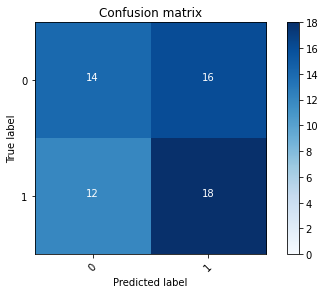

2022-02-17 13:53:16 - [Epoch Train: 106] loss: 0.0056, auc: 1.0000, acc: 0.9979, time: 63.00 s            
2022-02-17 13:53:16 - [Epoch Valid: 106] loss: 3.9616, auc: 0.6011, acc: 0.5333, time: 8.00 s


 35%|█████████████                        | 106/300 [2:04:05<3:51:43, 71.67s/it]

2022-02-17 13:53:16 - EPOCH: 107
2022-02-17 13:53:18 - Train Step 10/486, train_loss: 0.0004
2022-02-17 13:53:19 - Train Step 20/486, train_loss: 0.0171
2022-02-17 13:53:20 - Train Step 30/486, train_loss: 0.0124
2022-02-17 13:53:21 - Train Step 40/486, train_loss: 0.0210
2022-02-17 13:53:23 - Train Step 50/486, train_loss: 0.0174
2022-02-17 13:53:24 - Train Step 60/486, train_loss: 0.0146
2022-02-17 13:53:25 - Train Step 70/486, train_loss: 0.0125
2022-02-17 13:53:27 - Train Step 80/486, train_loss: 0.0110
2022-02-17 13:53:28 - Train Step 90/486, train_loss: 0.0097
2022-02-17 13:53:29 - Train Step 100/486, train_loss: 0.0091
2022-02-17 13:53:31 - Train Step 110/486, train_loss: 0.0084
2022-02-17 13:53:32 - Train Step 120/486, train_loss: 0.0077
2022-02-17 13:53:33 - Train Step 130/486, train_loss: 0.0071
2022-02-17 13:53:34 - Train Step 140/486, train_loss: 0.0066
2022-02-17 13:53:36 - Train Step 150/486, train_loss: 0.0062
2022-02-17 13:53:37 - Train Step 160/486, train_loss: 0.0058


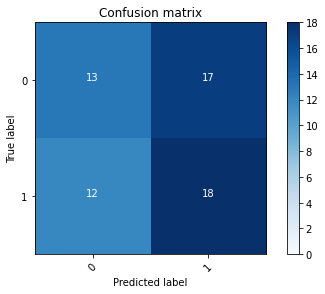

2022-02-17 13:54:28 - [Epoch Train: 107] loss: 0.0074, auc: 1.0000, acc: 0.9979, time: 63.00 s            
2022-02-17 13:54:28 - [Epoch Valid: 107] loss: 3.6443, auc: 0.5989, acc: 0.5167, time: 8.00 s


 36%|█████████████▏                       | 107/300 [2:05:16<3:50:13, 71.57s/it]

2022-02-17 13:54:28 - EPOCH: 108
2022-02-17 13:54:29 - Train Step 10/486, train_loss: 0.0013
2022-02-17 13:54:30 - Train Step 20/486, train_loss: 0.0102
2022-02-17 13:54:32 - Train Step 30/486, train_loss: 0.0069
2022-02-17 13:54:33 - Train Step 40/486, train_loss: 0.0052
2022-02-17 13:54:34 - Train Step 50/486, train_loss: 0.0046
2022-02-17 13:54:36 - Train Step 60/486, train_loss: 0.0040
2022-02-17 13:54:37 - Train Step 70/486, train_loss: 0.0035
2022-02-17 13:54:38 - Train Step 80/486, train_loss: 0.0032
2022-02-17 13:54:39 - Train Step 90/486, train_loss: 0.0029
2022-02-17 13:54:41 - Train Step 100/486, train_loss: 0.0026
2022-02-17 13:54:42 - Train Step 110/486, train_loss: 0.0024
2022-02-17 13:54:43 - Train Step 120/486, train_loss: 0.0023
2022-02-17 13:54:45 - Train Step 130/486, train_loss: 0.0205
2022-02-17 13:54:46 - Train Step 140/486, train_loss: 0.0215
2022-02-17 13:54:47 - Train Step 150/486, train_loss: 0.0201
2022-02-17 13:54:49 - Train Step 160/486, train_loss: 0.0190


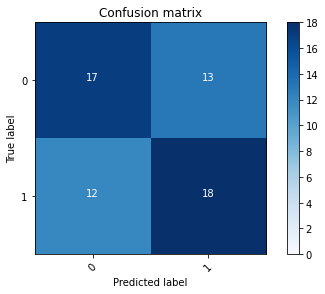

2022-02-17 13:55:38 - [Epoch Train: 108] loss: 0.0159, auc: 0.9998, acc: 0.9959, time: 62.00 s            
2022-02-17 13:55:38 - [Epoch Valid: 108] loss: 3.8268, auc: 0.6256, acc: 0.5833, time: 8.00 s


 36%|█████████████▎                       | 108/300 [2:06:27<3:47:58, 71.24s/it]

2022-02-17 13:55:38 - EPOCH: 109
2022-02-17 13:55:40 - Train Step 10/486, train_loss: 0.0012
2022-02-17 13:55:41 - Train Step 20/486, train_loss: 0.0007
2022-02-17 13:55:42 - Train Step 30/486, train_loss: 0.0012
2022-02-17 13:55:44 - Train Step 40/486, train_loss: 0.0069
2022-02-17 13:55:45 - Train Step 50/486, train_loss: 0.0060
2022-02-17 13:55:46 - Train Step 60/486, train_loss: 0.0061
2022-02-17 13:55:48 - Train Step 70/486, train_loss: 0.0119
2022-02-17 13:55:49 - Train Step 80/486, train_loss: 0.0146
2022-02-17 13:55:50 - Train Step 90/486, train_loss: 0.0167
2022-02-17 13:55:51 - Train Step 100/486, train_loss: 0.0154
2022-02-17 13:55:53 - Train Step 110/486, train_loss: 0.0141
2022-02-17 13:55:54 - Train Step 120/486, train_loss: 0.0206
2022-02-17 13:55:55 - Train Step 130/486, train_loss: 0.0197
2022-02-17 13:55:57 - Train Step 140/486, train_loss: 0.0192
2022-02-17 13:55:58 - Train Step 150/486, train_loss: 0.0191
2022-02-17 13:55:59 - Train Step 160/486, train_loss: 0.0281


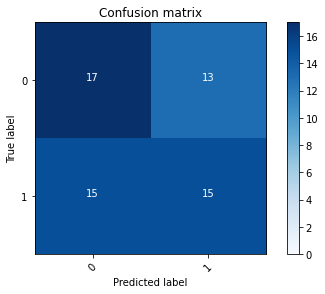

2022-02-17 13:56:49 - [Epoch Train: 109] loss: 0.0210, auc: 0.9997, acc: 0.9959, time: 62.00 s            
2022-02-17 13:56:49 - [Epoch Valid: 109] loss: 3.7116, auc: 0.6178, acc: 0.5333, time: 8.00 s


 36%|█████████████▍                       | 109/300 [2:07:37<3:45:57, 70.98s/it]

2022-02-17 13:56:49 - EPOCH: 110
2022-02-17 13:56:50 - Train Step 10/486, train_loss: 0.0071
2022-02-17 13:56:51 - Train Step 20/486, train_loss: 0.0036
2022-02-17 13:56:53 - Train Step 30/486, train_loss: 0.0029
2022-02-17 13:56:54 - Train Step 40/486, train_loss: 0.0025
2022-02-17 13:56:55 - Train Step 50/486, train_loss: 0.0020
2022-02-17 13:56:57 - Train Step 60/486, train_loss: 0.0019
2022-02-17 13:56:58 - Train Step 70/486, train_loss: 0.0066
2022-02-17 13:56:59 - Train Step 80/486, train_loss: 0.0058
2022-02-17 13:57:01 - Train Step 90/486, train_loss: 0.0052
2022-02-17 13:57:02 - Train Step 100/486, train_loss: 0.0048
2022-02-17 13:57:03 - Train Step 110/486, train_loss: 0.0045
2022-02-17 13:57:04 - Train Step 120/486, train_loss: 0.0042
2022-02-17 13:57:06 - Train Step 130/486, train_loss: 0.0041
2022-02-17 13:57:07 - Train Step 140/486, train_loss: 0.0040
2022-02-17 13:57:08 - Train Step 150/486, train_loss: 0.0049
2022-02-17 13:57:09 - Train Step 160/486, train_loss: 0.0046


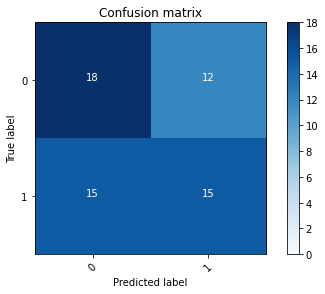

2022-02-17 13:58:00 - [Epoch Train: 110] loss: 0.0075, auc: 1.0000, acc: 0.9979, time: 63.00 s            
2022-02-17 13:58:00 - [Epoch Valid: 110] loss: 3.8715, auc: 0.6211, acc: 0.5500, time: 8.00 s


 37%|█████████████▌                       | 110/300 [2:08:49<3:45:25, 71.19s/it]

2022-02-17 13:58:00 - EPOCH: 111
2022-02-17 13:58:02 - Train Step 10/486, train_loss: 0.0000
2022-02-17 13:58:03 - Train Step 20/486, train_loss: 0.0004
2022-02-17 13:58:04 - Train Step 30/486, train_loss: 0.0005
2022-02-17 13:58:05 - Train Step 40/486, train_loss: 0.0005
2022-02-17 13:58:07 - Train Step 50/486, train_loss: 0.0006
2022-02-17 13:58:08 - Train Step 60/486, train_loss: 0.0008
2022-02-17 13:58:09 - Train Step 70/486, train_loss: 0.0007
2022-02-17 13:58:11 - Train Step 80/486, train_loss: 0.0059
2022-02-17 13:58:12 - Train Step 90/486, train_loss: 0.0053
2022-02-17 13:58:13 - Train Step 100/486, train_loss: 0.0048
2022-02-17 13:58:15 - Train Step 110/486, train_loss: 0.0047
2022-02-17 13:58:16 - Train Step 120/486, train_loss: 0.0045
2022-02-17 13:58:17 - Train Step 130/486, train_loss: 0.0042
2022-02-17 13:58:19 - Train Step 140/486, train_loss: 0.0039
2022-02-17 13:58:20 - Train Step 150/486, train_loss: 0.0037
2022-02-17 13:58:21 - Train Step 160/486, train_loss: 0.0036


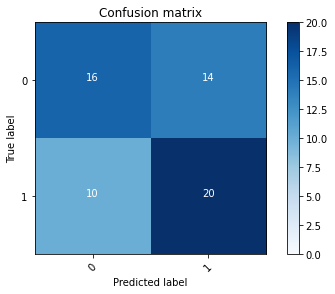

2022-02-17 13:59:12 - [Epoch Train: 111] loss: 0.0044, auc: 1.0000, acc: 1.0000, time: 63.00 s            
2022-02-17 13:59:12 - [Epoch Valid: 111] loss: 3.8689, auc: 0.6228, acc: 0.6000, time: 8.00 s


 37%|█████████████▋                       | 111/300 [2:10:00<3:44:38, 71.32s/it]

2022-02-17 13:59:12 - EPOCH: 112
2022-02-17 13:59:13 - Train Step 10/486, train_loss: 0.0002
2022-02-17 13:59:14 - Train Step 20/486, train_loss: 0.0017
2022-02-17 13:59:16 - Train Step 30/486, train_loss: 0.0011
2022-02-17 13:59:17 - Train Step 40/486, train_loss: 0.0012
2022-02-17 13:59:18 - Train Step 50/486, train_loss: 0.0011
2022-02-17 13:59:20 - Train Step 60/486, train_loss: 0.0010
2022-02-17 13:59:21 - Train Step 70/486, train_loss: 0.0009
2022-02-17 13:59:22 - Train Step 80/486, train_loss: 0.0019
2022-02-17 13:59:23 - Train Step 90/486, train_loss: 0.0028
2022-02-17 13:59:25 - Train Step 100/486, train_loss: 0.0025
2022-02-17 13:59:26 - Train Step 110/486, train_loss: 0.0025
2022-02-17 13:59:27 - Train Step 120/486, train_loss: 0.0051
2022-02-17 13:59:28 - Train Step 130/486, train_loss: 0.0047
2022-02-17 13:59:30 - Train Step 140/486, train_loss: 0.0045
2022-02-17 13:59:31 - Train Step 150/486, train_loss: 0.0043
2022-02-17 13:59:32 - Train Step 160/486, train_loss: 0.0040


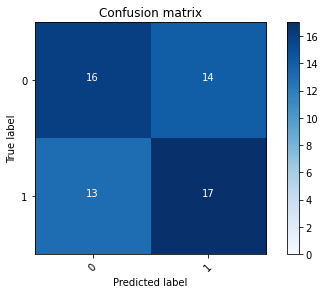

2022-02-17 14:00:22 - [Epoch Train: 112] loss: 0.0406, auc: 0.9993, acc: 0.9856, time: 62.00 s            
2022-02-17 14:00:22 - [Epoch Valid: 112] loss: 3.3177, auc: 0.5800, acc: 0.5500, time: 8.00 s


 37%|█████████████▊                       | 112/300 [2:11:11<3:42:47, 71.11s/it]

2022-02-17 14:00:22 - EPOCH: 113
2022-02-17 14:00:24 - Train Step 10/486, train_loss: 0.0318
2022-02-17 14:00:25 - Train Step 20/486, train_loss: 0.0200
2022-02-17 14:00:26 - Train Step 30/486, train_loss: 0.0134
2022-02-17 14:00:28 - Train Step 40/486, train_loss: 0.0101
2022-02-17 14:00:29 - Train Step 50/486, train_loss: 0.0080
2022-02-17 14:00:30 - Train Step 60/486, train_loss: 0.0070
2022-02-17 14:00:31 - Train Step 70/486, train_loss: 0.0145
2022-02-17 14:00:33 - Train Step 80/486, train_loss: 0.0131
2022-02-17 14:00:34 - Train Step 90/486, train_loss: 0.0123
2022-02-17 14:00:35 - Train Step 100/486, train_loss: 0.0147
2022-02-17 14:00:37 - Train Step 110/486, train_loss: 0.0133
2022-02-17 14:00:38 - Train Step 120/486, train_loss: 0.0127
2022-02-17 14:00:39 - Train Step 130/486, train_loss: 0.0117
2022-02-17 14:00:41 - Train Step 140/486, train_loss: 0.0110
2022-02-17 14:00:42 - Train Step 150/486, train_loss: 0.0103
2022-02-17 14:00:43 - Train Step 160/486, train_loss: 0.0103


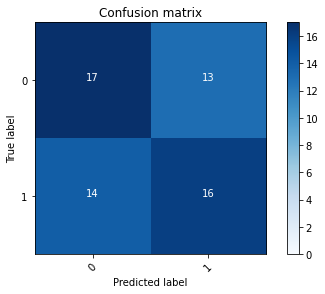

2022-02-17 14:01:34 - [Epoch Train: 113] loss: 0.0084, auc: 1.0000, acc: 0.9979, time: 63.00 s            
2022-02-17 14:01:34 - [Epoch Valid: 113] loss: 3.8484, auc: 0.6156, acc: 0.5500, time: 7.00 s


 38%|█████████████▉                       | 113/300 [2:12:22<3:41:46, 71.16s/it]

2022-02-17 14:01:34 - EPOCH: 114
2022-02-17 14:01:35 - Train Step 10/486, train_loss: 0.0000
2022-02-17 14:01:36 - Train Step 20/486, train_loss: 0.0040
2022-02-17 14:01:38 - Train Step 30/486, train_loss: 0.0039
2022-02-17 14:01:39 - Train Step 40/486, train_loss: 0.0030
2022-02-17 14:01:40 - Train Step 50/486, train_loss: 0.0024
2022-02-17 14:01:42 - Train Step 60/486, train_loss: 0.0026
2022-02-17 14:01:43 - Train Step 70/486, train_loss: 0.0026
2022-02-17 14:01:44 - Train Step 80/486, train_loss: 0.0024
2022-02-17 14:01:45 - Train Step 90/486, train_loss: 0.0022
2022-02-17 14:01:47 - Train Step 100/486, train_loss: 0.0020
2022-02-17 14:01:48 - Train Step 110/486, train_loss: 0.0018
2022-02-17 14:01:49 - Train Step 120/486, train_loss: 0.0019
2022-02-17 14:01:51 - Train Step 130/486, train_loss: 0.0042
2022-02-17 14:01:52 - Train Step 140/486, train_loss: 0.0042
2022-02-17 14:01:54 - Train Step 150/486, train_loss: 0.0040
2022-02-17 14:01:55 - Train Step 160/486, train_loss: 0.0041


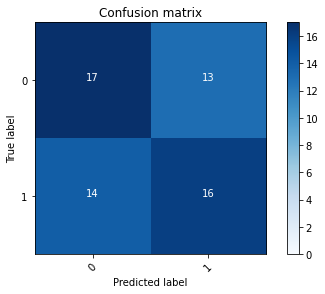

2022-02-17 14:02:45 - [Epoch Train: 114] loss: 0.0086, auc: 1.0000, acc: 0.9979, time: 63.00 s            
2022-02-17 14:02:45 - [Epoch Valid: 114] loss: 4.1209, auc: 0.6067, acc: 0.5500, time: 7.00 s


 38%|██████████████                       | 114/300 [2:13:33<3:40:23, 71.09s/it]

2022-02-17 14:02:45 - EPOCH: 115
2022-02-17 14:02:46 - Train Step 10/486, train_loss: 0.0002
2022-02-17 14:02:47 - Train Step 20/486, train_loss: 0.0001
2022-02-17 14:02:49 - Train Step 30/486, train_loss: 0.0001
2022-02-17 14:02:50 - Train Step 40/486, train_loss: 0.0001
2022-02-17 14:02:51 - Train Step 50/486, train_loss: 0.0001
2022-02-17 14:02:53 - Train Step 60/486, train_loss: 0.0003
2022-02-17 14:02:54 - Train Step 70/486, train_loss: 0.0005
2022-02-17 14:02:55 - Train Step 80/486, train_loss: 0.0012
2022-02-17 14:02:56 - Train Step 90/486, train_loss: 0.0011
2022-02-17 14:02:58 - Train Step 100/486, train_loss: 0.0010
2022-02-17 14:02:59 - Train Step 110/486, train_loss: 0.0011
2022-02-17 14:03:00 - Train Step 120/486, train_loss: 0.0118
2022-02-17 14:03:01 - Train Step 130/486, train_loss: 0.0290
2022-02-17 14:03:03 - Train Step 140/486, train_loss: 0.0359
2022-02-17 14:03:04 - Train Step 150/486, train_loss: 0.0340
2022-02-17 14:03:05 - Train Step 160/486, train_loss: 0.0321


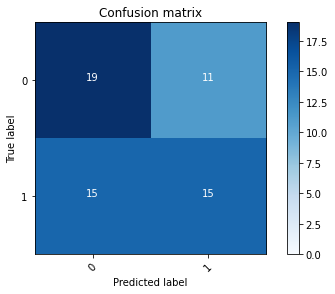

2022-02-17 14:03:55 - [Epoch Train: 115] loss: 0.0340, auc: 0.9994, acc: 0.9856, time: 62.00 s            
2022-02-17 14:03:55 - [Epoch Valid: 115] loss: 4.7179, auc: 0.5956, acc: 0.5667, time: 7.00 s


 38%|██████████████▏                      | 115/300 [2:14:43<3:38:15, 70.79s/it]

2022-02-17 14:03:55 - EPOCH: 116
2022-02-17 14:03:56 - Train Step 10/486, train_loss: 0.0004
2022-02-17 14:03:57 - Train Step 20/486, train_loss: 0.0163
2022-02-17 14:03:59 - Train Step 30/486, train_loss: 0.0117
2022-02-17 14:04:00 - Train Step 40/486, train_loss: 0.0094
2022-02-17 14:04:01 - Train Step 50/486, train_loss: 0.0097
2022-02-17 14:04:03 - Train Step 60/486, train_loss: 0.0097
2022-02-17 14:04:04 - Train Step 70/486, train_loss: 0.0104
2022-02-17 14:04:05 - Train Step 80/486, train_loss: 0.0095
2022-02-17 14:04:06 - Train Step 90/486, train_loss: 0.0085
2022-02-17 14:04:08 - Train Step 100/486, train_loss: 0.0098
2022-02-17 14:04:09 - Train Step 110/486, train_loss: 0.0090
2022-02-17 14:04:10 - Train Step 120/486, train_loss: 0.0082
2022-02-17 14:04:11 - Train Step 130/486, train_loss: 0.0076
2022-02-17 14:04:13 - Train Step 140/486, train_loss: 0.0177
2022-02-17 14:04:14 - Train Step 150/486, train_loss: 0.0165
2022-02-17 14:04:15 - Train Step 160/486, train_loss: 0.0155


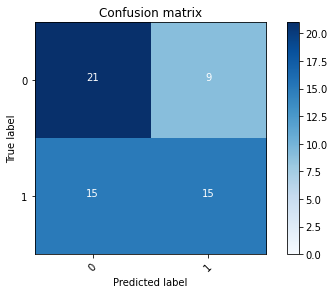

2022-02-17 14:05:05 - [Epoch Train: 116] loss: 0.0135, auc: 0.9999, acc: 0.9979, time: 61.00 s            
2022-02-17 14:05:05 - [Epoch Valid: 116] loss: 4.8237, auc: 0.6044, acc: 0.6000, time: 8.00 s


 39%|██████████████▎                      | 116/300 [2:15:53<3:36:17, 70.53s/it]

2022-02-17 14:05:05 - EPOCH: 117
2022-02-17 14:05:06 - Train Step 10/486, train_loss: 0.0000
2022-02-17 14:05:07 - Train Step 20/486, train_loss: 0.0160
2022-02-17 14:05:09 - Train Step 30/486, train_loss: 0.0126
2022-02-17 14:05:10 - Train Step 40/486, train_loss: 0.0096
2022-02-17 14:05:11 - Train Step 50/486, train_loss: 0.0140
2022-02-17 14:05:12 - Train Step 60/486, train_loss: 0.0126
2022-02-17 14:05:14 - Train Step 70/486, train_loss: 0.0110
2022-02-17 14:05:15 - Train Step 80/486, train_loss: 0.0098
2022-02-17 14:05:16 - Train Step 90/486, train_loss: 0.0090
2022-02-17 14:05:17 - Train Step 100/486, train_loss: 0.0081
2022-02-17 14:05:19 - Train Step 110/486, train_loss: 0.0105
2022-02-17 14:05:20 - Train Step 120/486, train_loss: 0.0096
2022-02-17 14:05:21 - Train Step 130/486, train_loss: 0.0090
2022-02-17 14:05:22 - Train Step 140/486, train_loss: 0.0083
2022-02-17 14:05:23 - Train Step 150/486, train_loss: 0.0079
2022-02-17 14:05:25 - Train Step 160/486, train_loss: 0.0080


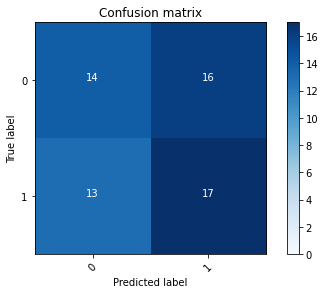

2022-02-17 14:06:13 - [Epoch Train: 117] loss: 0.0065, auc: 1.0000, acc: 0.9979, time: 60.00 s            
2022-02-17 14:06:13 - [Epoch Valid: 117] loss: 3.9629, auc: 0.5967, acc: 0.5167, time: 8.00 s


 39%|██████████████▍                      | 117/300 [2:17:02<3:33:29, 70.00s/it]

2022-02-17 14:06:13 - EPOCH: 118
2022-02-17 14:06:15 - Train Step 10/486, train_loss: 0.0005
2022-02-17 14:06:16 - Train Step 20/486, train_loss: 0.0014
2022-02-17 14:06:17 - Train Step 30/486, train_loss: 0.0021
2022-02-17 14:06:19 - Train Step 40/486, train_loss: 0.0018
2022-02-17 14:06:20 - Train Step 50/486, train_loss: 0.0016
2022-02-17 14:06:21 - Train Step 60/486, train_loss: 0.0013
2022-02-17 14:06:23 - Train Step 70/486, train_loss: 0.0011
2022-02-17 14:06:24 - Train Step 80/486, train_loss: 0.0010
2022-02-17 14:06:25 - Train Step 90/486, train_loss: 0.0009
2022-02-17 14:06:27 - Train Step 100/486, train_loss: 0.0010
2022-02-17 14:06:28 - Train Step 110/486, train_loss: 0.0011
2022-02-17 14:06:29 - Train Step 120/486, train_loss: 0.0037
2022-02-17 14:06:31 - Train Step 130/486, train_loss: 0.0035
2022-02-17 14:06:32 - Train Step 140/486, train_loss: 0.0033
2022-02-17 14:06:33 - Train Step 150/486, train_loss: 0.0032
2022-02-17 14:06:35 - Train Step 160/486, train_loss: 0.0030


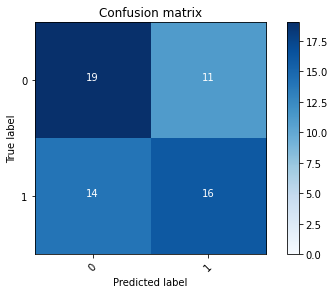

2022-02-17 14:07:25 - [Epoch Train: 118] loss: 0.0022, auc: 1.0000, acc: 1.0000, time: 63.00 s            
2022-02-17 14:07:25 - [Epoch Valid: 118] loss: 3.9558, auc: 0.6011, acc: 0.5833, time: 8.00 s


 39%|██████████████▌                      | 118/300 [2:18:14<3:33:49, 70.49s/it]

2022-02-17 14:07:25 - EPOCH: 119
2022-02-17 14:07:26 - Train Step 10/486, train_loss: 0.0011
2022-02-17 14:07:28 - Train Step 20/486, train_loss: 0.0009
2022-02-17 14:07:29 - Train Step 30/486, train_loss: 0.0007
2022-02-17 14:07:30 - Train Step 40/486, train_loss: 0.0008
2022-02-17 14:07:32 - Train Step 50/486, train_loss: 0.0007
2022-02-17 14:07:33 - Train Step 60/486, train_loss: 0.0006
2022-02-17 14:07:34 - Train Step 70/486, train_loss: 0.0005
2022-02-17 14:07:36 - Train Step 80/486, train_loss: 0.0008
2022-02-17 14:07:37 - Train Step 90/486, train_loss: 0.0010
2022-02-17 14:07:38 - Train Step 100/486, train_loss: 0.0009
2022-02-17 14:07:39 - Train Step 110/486, train_loss: 0.0008
2022-02-17 14:07:41 - Train Step 120/486, train_loss: 0.0038
2022-02-17 14:07:42 - Train Step 130/486, train_loss: 0.0037
2022-02-17 14:07:43 - Train Step 140/486, train_loss: 0.0034
2022-02-17 14:07:45 - Train Step 150/486, train_loss: 0.0032
2022-02-17 14:07:46 - Train Step 160/486, train_loss: 0.0033


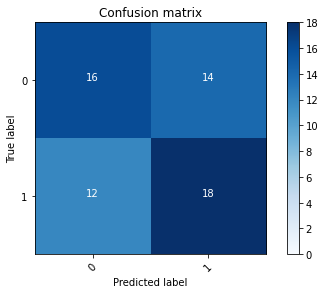

2022-02-17 14:08:36 - [Epoch Train: 119] loss: 0.0037, auc: 1.0000, acc: 1.0000, time: 62.00 s            
2022-02-17 14:08:36 - [Epoch Valid: 119] loss: 4.2994, auc: 0.6044, acc: 0.5667, time: 7.00 s


 40%|██████████████▋                      | 119/300 [2:19:25<3:33:01, 70.62s/it]

2022-02-17 14:08:36 - EPOCH: 120
2022-02-17 14:08:37 - Train Step 10/486, train_loss: 0.0004
2022-02-17 14:08:39 - Train Step 20/486, train_loss: 0.0025
2022-02-17 14:08:40 - Train Step 30/486, train_loss: 0.0034
2022-02-17 14:08:41 - Train Step 40/486, train_loss: 0.0030
2022-02-17 14:08:43 - Train Step 50/486, train_loss: 0.0025
2022-02-17 14:08:44 - Train Step 60/486, train_loss: 0.0021
2022-02-17 14:08:45 - Train Step 70/486, train_loss: 0.0018
2022-02-17 14:08:47 - Train Step 80/486, train_loss: 0.0016
2022-02-17 14:08:48 - Train Step 90/486, train_loss: 0.0014
2022-02-17 14:08:49 - Train Step 100/486, train_loss: 0.0017
2022-02-17 14:08:50 - Train Step 110/486, train_loss: 0.0016
2022-02-17 14:08:51 - Train Step 120/486, train_loss: 0.0015
2022-02-17 14:08:53 - Train Step 130/486, train_loss: 0.0014
2022-02-17 14:08:54 - Train Step 140/486, train_loss: 0.0016
2022-02-17 14:08:55 - Train Step 150/486, train_loss: 0.0017
2022-02-17 14:08:57 - Train Step 160/486, train_loss: 0.0016


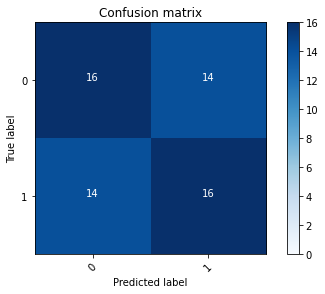

2022-02-17 14:09:47 - [Epoch Train: 120] loss: 0.0062, auc: 1.0000, acc: 0.9959, time: 62.00 s            
2022-02-17 14:09:47 - [Epoch Valid: 120] loss: 4.2777, auc: 0.5906, acc: 0.5333, time: 8.00 s


 40%|██████████████▊                      | 120/300 [2:20:35<3:31:49, 70.61s/it]

2022-02-17 14:09:47 - EPOCH: 121
2022-02-17 14:09:48 - Train Step 10/486, train_loss: 0.0001
2022-02-17 14:09:49 - Train Step 20/486, train_loss: 0.0001
2022-02-17 14:09:51 - Train Step 30/486, train_loss: 0.0001
2022-02-17 14:09:52 - Train Step 40/486, train_loss: 0.0002
2022-02-17 14:09:53 - Train Step 50/486, train_loss: 0.0001
2022-02-17 14:09:55 - Train Step 60/486, train_loss: 0.0001
2022-02-17 14:09:56 - Train Step 70/486, train_loss: 0.0050
2022-02-17 14:09:57 - Train Step 80/486, train_loss: 0.0044
2022-02-17 14:09:58 - Train Step 90/486, train_loss: 0.0089
2022-02-17 14:10:00 - Train Step 100/486, train_loss: 0.0080
2022-02-17 14:10:01 - Train Step 110/486, train_loss: 0.0073
2022-02-17 14:10:02 - Train Step 120/486, train_loss: 0.0069
2022-02-17 14:10:04 - Train Step 130/486, train_loss: 0.0063
2022-02-17 14:10:05 - Train Step 140/486, train_loss: 0.0081
2022-02-17 14:10:06 - Train Step 150/486, train_loss: 0.0076
2022-02-17 14:10:07 - Train Step 160/486, train_loss: 0.0073


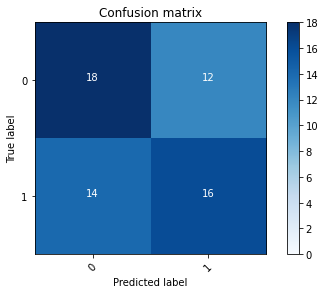

2022-02-17 14:10:57 - [Epoch Train: 121] loss: 0.0058, auc: 1.0000, acc: 1.0000, time: 62.00 s            
2022-02-17 14:10:57 - [Epoch Valid: 121] loss: 3.6695, auc: 0.6167, acc: 0.5667, time: 8.00 s


 40%|██████████████▉                      | 121/300 [2:21:46<3:30:46, 70.65s/it]

2022-02-17 14:10:57 - EPOCH: 122
2022-02-17 14:10:59 - Train Step 10/486, train_loss: 0.0000
2022-02-17 14:11:00 - Train Step 20/486, train_loss: 0.0013
2022-02-17 14:11:01 - Train Step 30/486, train_loss: 0.0178
2022-02-17 14:11:03 - Train Step 40/486, train_loss: 0.0136
2022-02-17 14:11:04 - Train Step 50/486, train_loss: 0.0109
2022-02-17 14:11:05 - Train Step 60/486, train_loss: 0.0257
2022-02-17 14:11:07 - Train Step 70/486, train_loss: 0.0265
2022-02-17 14:11:08 - Train Step 80/486, train_loss: 0.0232
2022-02-17 14:11:09 - Train Step 90/486, train_loss: 0.0208
2022-02-17 14:11:11 - Train Step 100/486, train_loss: 0.0188
2022-02-17 14:11:12 - Train Step 110/486, train_loss: 0.1103
2022-02-17 14:11:13 - Train Step 120/486, train_loss: 0.1023
2022-02-17 14:11:14 - Train Step 130/486, train_loss: 0.0947
2022-02-17 14:11:16 - Train Step 140/486, train_loss: 0.0887
2022-02-17 14:11:17 - Train Step 150/486, train_loss: 0.0830
2022-02-17 14:11:18 - Train Step 160/486, train_loss: 0.0787


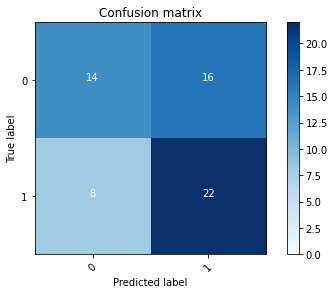

2022-02-17 14:12:08 - [Epoch Train: 122] loss: 0.0894, auc: 0.9952, acc: 0.9753, time: 62.00 s            
2022-02-17 14:12:08 - [Epoch Valid: 122] loss: 3.6037, auc: 0.5967, acc: 0.6000, time: 8.00 s


 41%|███████████████                      | 122/300 [2:22:57<3:29:46, 70.71s/it]

2022-02-17 14:12:08 - EPOCH: 123
2022-02-17 14:12:10 - Train Step 10/486, train_loss: 0.0523
2022-02-17 14:12:11 - Train Step 20/486, train_loss: 0.0374
2022-02-17 14:12:12 - Train Step 30/486, train_loss: 0.0249
2022-02-17 14:12:13 - Train Step 40/486, train_loss: 0.0206
2022-02-17 14:12:15 - Train Step 50/486, train_loss: 0.0170
2022-02-17 14:12:16 - Train Step 60/486, train_loss: 0.0151
2022-02-17 14:12:17 - Train Step 70/486, train_loss: 0.0178
2022-02-17 14:12:18 - Train Step 80/486, train_loss: 0.0156
2022-02-17 14:12:20 - Train Step 90/486, train_loss: 0.0139
2022-02-17 14:12:21 - Train Step 100/486, train_loss: 0.0137
2022-02-17 14:12:22 - Train Step 110/486, train_loss: 0.0130
2022-02-17 14:12:24 - Train Step 120/486, train_loss: 0.0120
2022-02-17 14:12:25 - Train Step 130/486, train_loss: 0.0111
2022-02-17 14:12:26 - Train Step 140/486, train_loss: 0.0103
2022-02-17 14:12:27 - Train Step 150/486, train_loss: 0.0096
2022-02-17 14:12:29 - Train Step 160/486, train_loss: 0.0090


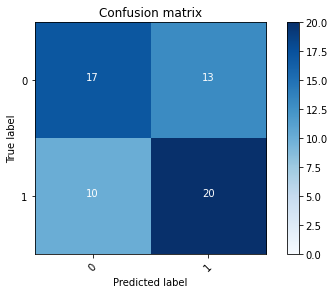

2022-02-17 14:13:18 - [Epoch Train: 123] loss: 0.0102, auc: 0.9999, acc: 0.9959, time: 61.00 s            
2022-02-17 14:13:18 - [Epoch Valid: 123] loss: 3.5504, auc: 0.6244, acc: 0.6167, time: 8.00 s


 41%|███████████████▏                     | 123/300 [2:24:07<3:28:06, 70.54s/it]

2022-02-17 14:13:18 - EPOCH: 124
2022-02-17 14:13:20 - Train Step 10/486, train_loss: 0.0004
2022-02-17 14:13:21 - Train Step 20/486, train_loss: 0.0005
2022-02-17 14:13:22 - Train Step 30/486, train_loss: 0.0015
2022-02-17 14:13:24 - Train Step 40/486, train_loss: 0.0039
2022-02-17 14:13:25 - Train Step 50/486, train_loss: 0.0032
2022-02-17 14:13:26 - Train Step 60/486, train_loss: 0.0048
2022-02-17 14:13:28 - Train Step 70/486, train_loss: 0.0041
2022-02-17 14:13:29 - Train Step 80/486, train_loss: 0.0036
2022-02-17 14:13:31 - Train Step 90/486, train_loss: 0.0033
2022-02-17 14:13:32 - Train Step 100/486, train_loss: 0.0032
2022-02-17 14:13:33 - Train Step 110/486, train_loss: 0.0029
2022-02-17 14:13:35 - Train Step 120/486, train_loss: 0.0027
2022-02-17 14:13:36 - Train Step 130/486, train_loss: 0.0025
2022-02-17 14:13:37 - Train Step 140/486, train_loss: 0.0023
2022-02-17 14:13:39 - Train Step 150/486, train_loss: 0.0022
2022-02-17 14:13:40 - Train Step 160/486, train_loss: 0.0021


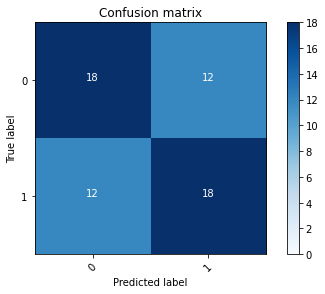

2022-02-17 14:14:26 - [Epoch Train: 124] loss: 0.0080, auc: 1.0000, acc: 0.9979, time: 60.00 s            
2022-02-17 14:14:26 - [Epoch Valid: 124] loss: 3.8739, auc: 0.6211, acc: 0.6000, time: 7.00 s


 41%|███████████████▎                     | 124/300 [2:25:15<3:24:47, 69.82s/it]

2022-02-17 14:14:26 - EPOCH: 125
2022-02-17 14:14:28 - Train Step 10/486, train_loss: 0.0000
2022-02-17 14:14:29 - Train Step 20/486, train_loss: 0.0001
2022-02-17 14:14:30 - Train Step 30/486, train_loss: 0.0102
2022-02-17 14:14:31 - Train Step 40/486, train_loss: 0.0106
2022-02-17 14:14:33 - Train Step 50/486, train_loss: 0.0089
2022-02-17 14:14:34 - Train Step 60/486, train_loss: 0.0075
2022-02-17 14:14:35 - Train Step 70/486, train_loss: 0.0069
2022-02-17 14:14:36 - Train Step 80/486, train_loss: 0.0064
2022-02-17 14:14:37 - Train Step 90/486, train_loss: 0.0057
2022-02-17 14:14:39 - Train Step 100/486, train_loss: 0.0053
2022-02-17 14:14:40 - Train Step 110/486, train_loss: 0.0049
2022-02-17 14:14:41 - Train Step 120/486, train_loss: 0.0049
2022-02-17 14:14:42 - Train Step 130/486, train_loss: 0.0045
2022-02-17 14:14:44 - Train Step 140/486, train_loss: 0.0051
2022-02-17 14:14:45 - Train Step 150/486, train_loss: 0.0082
2022-02-17 14:14:46 - Train Step 160/486, train_loss: 0.0077


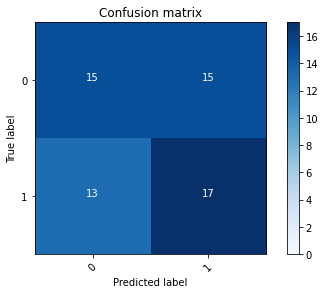

2022-02-17 14:15:33 - [Epoch Train: 125] loss: 0.0080, auc: 1.0000, acc: 0.9979, time: 59.00 s            
2022-02-17 14:15:33 - [Epoch Valid: 125] loss: 3.2322, auc: 0.6133, acc: 0.5333, time: 7.00 s


 42%|███████████████▍                     | 125/300 [2:26:22<3:20:51, 68.87s/it]

2022-02-17 14:15:33 - EPOCH: 126
2022-02-17 14:15:34 - Train Step 10/486, train_loss: 0.0029
2022-02-17 14:15:36 - Train Step 20/486, train_loss: 0.0015
2022-02-17 14:15:37 - Train Step 30/486, train_loss: 0.0111
2022-02-17 14:15:38 - Train Step 40/486, train_loss: 0.0162
2022-02-17 14:15:39 - Train Step 50/486, train_loss: 0.0221
2022-02-17 14:15:40 - Train Step 60/486, train_loss: 0.0201
2022-02-17 14:15:42 - Train Step 70/486, train_loss: 0.0216
2022-02-17 14:15:43 - Train Step 80/486, train_loss: 0.0189
2022-02-17 14:15:44 - Train Step 90/486, train_loss: 0.0170
2022-02-17 14:15:45 - Train Step 100/486, train_loss: 0.0154
2022-02-17 14:15:46 - Train Step 110/486, train_loss: 0.0141
2022-02-17 14:15:48 - Train Step 120/486, train_loss: 0.0133
2022-02-17 14:15:49 - Train Step 130/486, train_loss: 0.0124
2022-02-17 14:15:50 - Train Step 140/486, train_loss: 0.0116
2022-02-17 14:15:51 - Train Step 150/486, train_loss: 0.0220
2022-02-17 14:15:52 - Train Step 160/486, train_loss: 0.0210


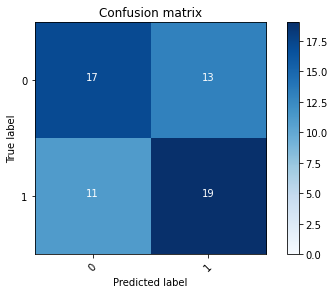

2022-02-17 14:16:39 - [Epoch Train: 126] loss: 0.0139, auc: 0.9998, acc: 0.9938, time: 58.00 s            
2022-02-17 14:16:39 - [Epoch Valid: 126] loss: 3.6224, auc: 0.6156, acc: 0.6000, time: 7.00 s


 42%|███████████████▌                     | 126/300 [2:27:27<3:16:54, 67.90s/it]

2022-02-17 14:16:39 - EPOCH: 127
2022-02-17 14:16:40 - Train Step 10/486, train_loss: 0.0076
2022-02-17 14:16:41 - Train Step 20/486, train_loss: 0.0369
2022-02-17 14:16:42 - Train Step 30/486, train_loss: 0.0246
2022-02-17 14:16:44 - Train Step 40/486, train_loss: 0.0198
2022-02-17 14:16:45 - Train Step 50/486, train_loss: 0.0159
2022-02-17 14:16:46 - Train Step 60/486, train_loss: 0.0270
2022-02-17 14:16:47 - Train Step 70/486, train_loss: 0.0245
2022-02-17 14:16:48 - Train Step 80/486, train_loss: 0.0218
2022-02-17 14:16:50 - Train Step 90/486, train_loss: 0.0195
2022-02-17 14:16:51 - Train Step 100/486, train_loss: 0.0178
2022-02-17 14:16:52 - Train Step 110/486, train_loss: 0.0162
2022-02-17 14:16:53 - Train Step 120/486, train_loss: 0.0156
2022-02-17 14:16:54 - Train Step 130/486, train_loss: 0.0145
2022-02-17 14:16:56 - Train Step 140/486, train_loss: 0.0135
2022-02-17 14:16:57 - Train Step 150/486, train_loss: 0.0126
2022-02-17 14:16:58 - Train Step 160/486, train_loss: 0.0118


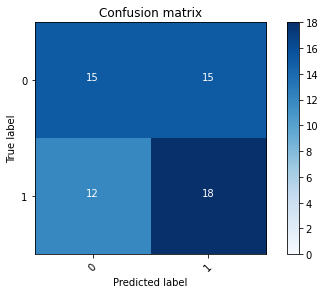

2022-02-17 14:17:45 - [Epoch Train: 127] loss: 0.0128, auc: 1.0000, acc: 0.9938, time: 58.00 s            
2022-02-17 14:17:45 - [Epoch Valid: 127] loss: 3.9229, auc: 0.6022, acc: 0.5500, time: 7.00 s


 42%|███████████████▋                     | 127/300 [2:28:33<3:14:01, 67.29s/it]

2022-02-17 14:17:45 - EPOCH: 128
2022-02-17 14:17:46 - Train Step 10/486, train_loss: 0.0322
2022-02-17 14:17:47 - Train Step 20/486, train_loss: 0.0164
2022-02-17 14:17:48 - Train Step 30/486, train_loss: 0.0282
2022-02-17 14:17:49 - Train Step 40/486, train_loss: 0.0212
2022-02-17 14:17:51 - Train Step 50/486, train_loss: 0.0170
2022-02-17 14:17:52 - Train Step 60/486, train_loss: 0.0142
2022-02-17 14:17:53 - Train Step 70/486, train_loss: 0.0138
2022-02-17 14:17:54 - Train Step 80/486, train_loss: 0.0127
2022-02-17 14:17:56 - Train Step 90/486, train_loss: 0.0120
2022-02-17 14:17:57 - Train Step 100/486, train_loss: 0.0109
2022-02-17 14:17:58 - Train Step 110/486, train_loss: 0.0099
2022-02-17 14:17:59 - Train Step 120/486, train_loss: 0.0092
2022-02-17 14:18:01 - Train Step 130/486, train_loss: 0.0086
2022-02-17 14:18:02 - Train Step 140/486, train_loss: 0.0103
2022-02-17 14:18:03 - Train Step 150/486, train_loss: 0.0096
2022-02-17 14:18:04 - Train Step 160/486, train_loss: 0.0091


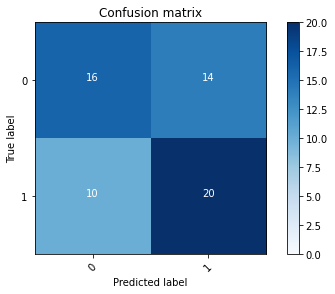

2022-02-17 14:18:52 - [Epoch Train: 128] loss: 0.0267, auc: 0.9990, acc: 0.9959, time: 60.00 s            
2022-02-17 14:18:52 - [Epoch Valid: 128] loss: 4.3197, auc: 0.6222, acc: 0.6000, time: 7.00 s


 43%|███████████████▊                     | 128/300 [2:29:41<3:13:26, 67.48s/it]

2022-02-17 14:18:52 - EPOCH: 129
2022-02-17 14:18:54 - Train Step 10/486, train_loss: 0.0042
2022-02-17 14:18:55 - Train Step 20/486, train_loss: 0.0021
2022-02-17 14:18:56 - Train Step 30/486, train_loss: 0.0015
2022-02-17 14:18:57 - Train Step 40/486, train_loss: 0.0086
2022-02-17 14:18:59 - Train Step 50/486, train_loss: 0.0077
2022-02-17 14:19:00 - Train Step 60/486, train_loss: 0.0065
2022-02-17 14:19:01 - Train Step 70/486, train_loss: 0.0057
2022-02-17 14:19:02 - Train Step 80/486, train_loss: 0.0076
2022-02-17 14:19:04 - Train Step 90/486, train_loss: 0.0068
2022-02-17 14:19:05 - Train Step 100/486, train_loss: 0.0061
2022-02-17 14:19:06 - Train Step 110/486, train_loss: 0.0059
2022-02-17 14:19:07 - Train Step 120/486, train_loss: 0.0055
2022-02-17 14:19:08 - Train Step 130/486, train_loss: 0.0056
2022-02-17 14:19:10 - Train Step 140/486, train_loss: 0.0054
2022-02-17 14:19:11 - Train Step 150/486, train_loss: 0.0051
2022-02-17 14:19:12 - Train Step 160/486, train_loss: 0.0048


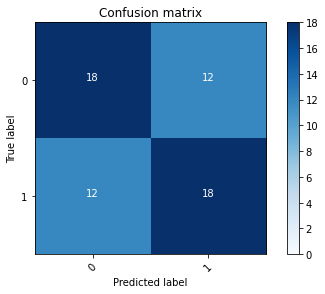

2022-02-17 14:19:58 - [Epoch Train: 129] loss: 0.0082, auc: 0.9999, acc: 0.9979, time: 58.00 s            
2022-02-17 14:19:58 - [Epoch Valid: 129] loss: 4.4050, auc: 0.6294, acc: 0.6000, time: 7.00 s


 43%|███████████████▉                     | 129/300 [2:30:47<3:10:58, 67.01s/it]

2022-02-17 14:19:58 - EPOCH: 130
2022-02-17 14:20:00 - Train Step 10/486, train_loss: 0.0001
2022-02-17 14:20:01 - Train Step 20/486, train_loss: 0.0002
2022-02-17 14:20:02 - Train Step 30/486, train_loss: 0.0006
2022-02-17 14:20:03 - Train Step 40/486, train_loss: 0.0008
2022-02-17 14:20:04 - Train Step 50/486, train_loss: 0.0006
2022-02-17 14:20:06 - Train Step 60/486, train_loss: 0.0005
2022-02-17 14:20:07 - Train Step 70/486, train_loss: 0.0020
2022-02-17 14:20:08 - Train Step 80/486, train_loss: 0.0018
2022-02-17 14:20:09 - Train Step 90/486, train_loss: 0.0017
2022-02-17 14:20:10 - Train Step 100/486, train_loss: 0.0015
2022-02-17 14:20:12 - Train Step 110/486, train_loss: 0.0041
2022-02-17 14:20:13 - Train Step 120/486, train_loss: 0.0037
2022-02-17 14:20:14 - Train Step 130/486, train_loss: 0.0035
2022-02-17 14:20:15 - Train Step 140/486, train_loss: 0.0033
2022-02-17 14:20:16 - Train Step 150/486, train_loss: 0.0031
2022-02-17 14:20:17 - Train Step 160/486, train_loss: 0.0029


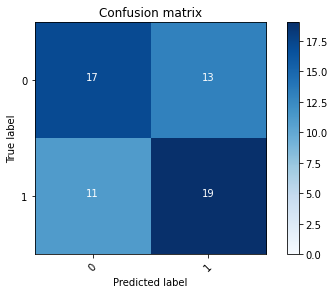

2022-02-17 14:21:03 - [Epoch Train: 130] loss: 0.0242, auc: 0.9993, acc: 0.9897, time: 57.00 s            
2022-02-17 14:21:03 - [Epoch Valid: 130] loss: 3.9927, auc: 0.6411, acc: 0.6000, time: 7.00 s


 43%|████████████████                     | 130/300 [2:31:52<3:07:54, 66.32s/it]

2022-02-17 14:21:03 - EPOCH: 131
2022-02-17 14:21:04 - Train Step 10/486, train_loss: 0.0035
2022-02-17 14:21:06 - Train Step 20/486, train_loss: 0.0230
2022-02-17 14:21:07 - Train Step 30/486, train_loss: 0.0158
2022-02-17 14:21:08 - Train Step 40/486, train_loss: 0.0119
2022-02-17 14:21:09 - Train Step 50/486, train_loss: 0.0096
2022-02-17 14:21:10 - Train Step 60/486, train_loss: 0.0080
2022-02-17 14:21:12 - Train Step 70/486, train_loss: 0.0071
2022-02-17 14:21:13 - Train Step 80/486, train_loss: 0.0393
2022-02-17 14:21:14 - Train Step 90/486, train_loss: 0.0353
2022-02-17 14:21:15 - Train Step 100/486, train_loss: 0.0319
2022-02-17 14:21:16 - Train Step 110/486, train_loss: 0.0356
2022-02-17 14:21:18 - Train Step 120/486, train_loss: 0.0328
2022-02-17 14:21:19 - Train Step 130/486, train_loss: 0.0412
2022-02-17 14:21:20 - Train Step 140/486, train_loss: 0.0404
2022-02-17 14:21:21 - Train Step 150/486, train_loss: 0.0381
2022-02-17 14:21:22 - Train Step 160/486, train_loss: 0.0357


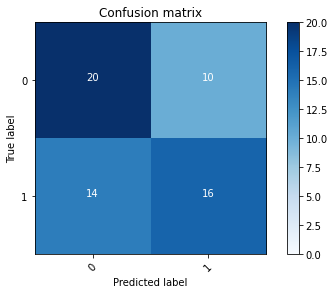

2022-02-17 14:22:10 - [Epoch Train: 131] loss: 0.0184, auc: 0.9999, acc: 0.9959, time: 59.00 s            
2022-02-17 14:22:10 - [Epoch Valid: 131] loss: 3.8021, auc: 0.6489, acc: 0.6000, time: 7.00 s


 44%|████████████████▏                    | 131/300 [2:32:58<3:07:04, 66.42s/it]

2022-02-17 14:22:10 - EPOCH: 132
2022-02-17 14:22:11 - Train Step 10/486, train_loss: 0.0000
2022-02-17 14:22:12 - Train Step 20/486, train_loss: 0.0005
2022-02-17 14:22:13 - Train Step 30/486, train_loss: 0.0004
2022-02-17 14:22:15 - Train Step 40/486, train_loss: 0.0003
2022-02-17 14:22:16 - Train Step 50/486, train_loss: 0.0190
2022-02-17 14:22:17 - Train Step 60/486, train_loss: 0.0162
2022-02-17 14:22:18 - Train Step 70/486, train_loss: 0.0139
2022-02-17 14:22:20 - Train Step 80/486, train_loss: 0.0122
2022-02-17 14:22:21 - Train Step 90/486, train_loss: 0.0108
2022-02-17 14:22:22 - Train Step 100/486, train_loss: 0.0099
2022-02-17 14:22:23 - Train Step 110/486, train_loss: 0.0090
2022-02-17 14:22:24 - Train Step 120/486, train_loss: 0.0100
2022-02-17 14:22:26 - Train Step 130/486, train_loss: 0.0094
2022-02-17 14:22:27 - Train Step 140/486, train_loss: 0.0088
2022-02-17 14:22:28 - Train Step 150/486, train_loss: 0.0102
2022-02-17 14:22:29 - Train Step 160/486, train_loss: 0.0096


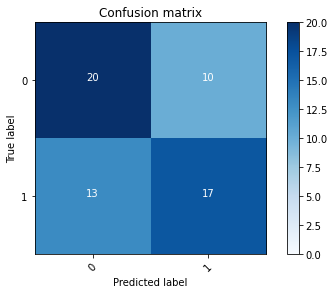

2022-02-17 14:23:15 - [Epoch Train: 132] loss: 0.0080, auc: 1.0000, acc: 0.9979, time: 58.00 s            
2022-02-17 14:23:15 - [Epoch Valid: 132] loss: 4.2802, auc: 0.6439, acc: 0.6167, time: 7.00 s


 44%|████████████████▎                    | 132/300 [2:34:04<3:05:19, 66.19s/it]

2022-02-17 14:23:15 - EPOCH: 133
2022-02-17 14:23:17 - Train Step 10/486, train_loss: 0.0041
2022-02-17 14:23:18 - Train Step 20/486, train_loss: 0.0021
2022-02-17 14:23:19 - Train Step 30/486, train_loss: 0.0017
2022-02-17 14:23:20 - Train Step 40/486, train_loss: 0.0092
2022-02-17 14:23:22 - Train Step 50/486, train_loss: 0.0078
2022-02-17 14:23:23 - Train Step 60/486, train_loss: 0.0065
2022-02-17 14:23:24 - Train Step 70/486, train_loss: 0.0056
2022-02-17 14:23:25 - Train Step 80/486, train_loss: 0.0051
2022-02-17 14:23:26 - Train Step 90/486, train_loss: 0.0045
2022-02-17 14:23:28 - Train Step 100/486, train_loss: 0.0041
2022-02-17 14:23:29 - Train Step 110/486, train_loss: 0.0040
2022-02-17 14:23:30 - Train Step 120/486, train_loss: 0.0036
2022-02-17 14:23:31 - Train Step 130/486, train_loss: 0.0033
2022-02-17 14:23:32 - Train Step 140/486, train_loss: 0.0033
2022-02-17 14:23:34 - Train Step 150/486, train_loss: 0.0031
2022-02-17 14:23:35 - Train Step 160/486, train_loss: 0.0032


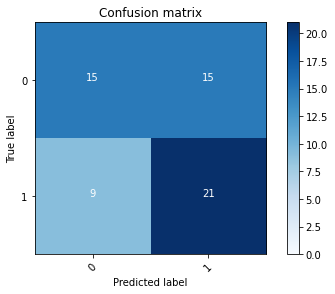

2022-02-17 14:24:22 - [Epoch Train: 133] loss: 0.0047, auc: 1.0000, acc: 1.0000, time: 58.00 s            
2022-02-17 14:24:22 - [Epoch Valid: 133] loss: 3.6494, auc: 0.6483, acc: 0.6000, time: 7.00 s


 44%|████████████████▍                    | 133/300 [2:35:10<3:04:25, 66.26s/it]

2022-02-17 14:24:22 - EPOCH: 134
2022-02-17 14:24:23 - Train Step 10/486, train_loss: 0.0023
2022-02-17 14:24:24 - Train Step 20/486, train_loss: 0.0012
2022-02-17 14:24:25 - Train Step 30/486, train_loss: 0.0012
2022-02-17 14:24:27 - Train Step 40/486, train_loss: 0.0009
2022-02-17 14:24:28 - Train Step 50/486, train_loss: 0.0009
2022-02-17 14:24:29 - Train Step 60/486, train_loss: 0.0024
2022-02-17 14:24:30 - Train Step 70/486, train_loss: 0.0021
2022-02-17 14:24:31 - Train Step 80/486, train_loss: 0.0084
2022-02-17 14:24:33 - Train Step 90/486, train_loss: 0.0075
2022-02-17 14:24:34 - Train Step 100/486, train_loss: 0.0079
2022-02-17 14:24:35 - Train Step 110/486, train_loss: 0.0079
2022-02-17 14:24:36 - Train Step 120/486, train_loss: 0.0074
2022-02-17 14:24:37 - Train Step 130/486, train_loss: 0.0091
2022-02-17 14:24:38 - Train Step 140/486, train_loss: 0.0085
2022-02-17 14:24:40 - Train Step 150/486, train_loss: 0.0079
2022-02-17 14:24:41 - Train Step 160/486, train_loss: 0.0074


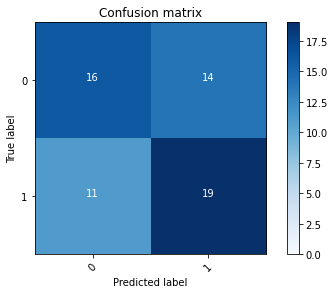

2022-02-17 14:25:27 - [Epoch Train: 134] loss: 0.0054, auc: 1.0000, acc: 1.0000, time: 57.00 s            
2022-02-17 14:25:27 - [Epoch Valid: 134] loss: 3.6555, auc: 0.6611, acc: 0.5833, time: 7.00 s


 45%|████████████████▌                    | 134/300 [2:36:15<3:02:03, 65.80s/it]

2022-02-17 14:25:27 - EPOCH: 135
2022-02-17 14:25:28 - Train Step 10/486, train_loss: 0.0000
2022-02-17 14:25:29 - Train Step 20/486, train_loss: 0.0002
2022-02-17 14:25:30 - Train Step 30/486, train_loss: 0.0006
2022-02-17 14:25:31 - Train Step 40/486, train_loss: 0.0073
2022-02-17 14:25:33 - Train Step 50/486, train_loss: 0.0062
2022-02-17 14:25:34 - Train Step 60/486, train_loss: 0.0052
2022-02-17 14:25:35 - Train Step 70/486, train_loss: 0.0237
2022-02-17 14:25:36 - Train Step 80/486, train_loss: 0.0208
2022-02-17 14:25:38 - Train Step 90/486, train_loss: 0.0185
2022-02-17 14:25:39 - Train Step 100/486, train_loss: 0.0166
2022-02-17 14:25:40 - Train Step 110/486, train_loss: 0.0151
2022-02-17 14:25:41 - Train Step 120/486, train_loss: 0.0139
2022-02-17 14:25:43 - Train Step 130/486, train_loss: 0.0128
2022-02-17 14:25:44 - Train Step 140/486, train_loss: 0.0125
2022-02-17 14:25:45 - Train Step 150/486, train_loss: 0.0117
2022-02-17 14:25:46 - Train Step 160/486, train_loss: 0.0128


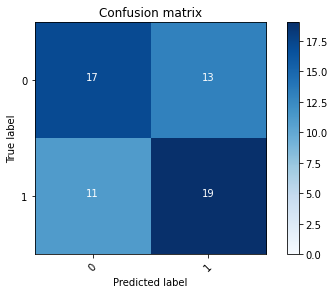

2022-02-17 14:26:34 - [Epoch Train: 135] loss: 0.0086, auc: 1.0000, acc: 0.9959, time: 59.00 s            
2022-02-17 14:26:34 - [Epoch Valid: 135] loss: 3.7831, auc: 0.6411, acc: 0.6000, time: 7.00 s


 45%|████████████████▋                    | 135/300 [2:37:22<3:02:10, 66.25s/it]

2022-02-17 14:26:34 - EPOCH: 136
2022-02-17 14:26:35 - Train Step 10/486, train_loss: 0.0000
2022-02-17 14:26:36 - Train Step 20/486, train_loss: 0.0000
2022-02-17 14:26:38 - Train Step 30/486, train_loss: 0.0000
2022-02-17 14:26:39 - Train Step 40/486, train_loss: 0.0002
2022-02-17 14:26:40 - Train Step 50/486, train_loss: 0.0002
2022-02-17 14:26:41 - Train Step 60/486, train_loss: 0.0002
2022-02-17 14:26:42 - Train Step 70/486, train_loss: 0.0003
2022-02-17 14:26:44 - Train Step 80/486, train_loss: 0.0005
2022-02-17 14:26:45 - Train Step 90/486, train_loss: 0.0004
2022-02-17 14:26:46 - Train Step 100/486, train_loss: 0.0021
2022-02-17 14:26:47 - Train Step 110/486, train_loss: 0.0019
2022-02-17 14:26:48 - Train Step 120/486, train_loss: 0.0018
2022-02-17 14:26:50 - Train Step 130/486, train_loss: 0.0018
2022-02-17 14:26:51 - Train Step 140/486, train_loss: 0.0017
2022-02-17 14:26:52 - Train Step 150/486, train_loss: 0.0016
2022-02-17 14:26:53 - Train Step 160/486, train_loss: 0.0016


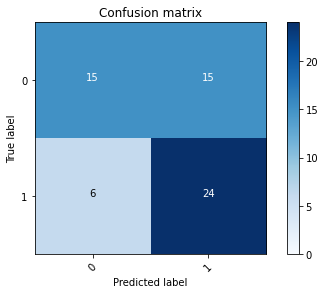

2022-02-17 14:27:41 - [Epoch Train: 136] loss: 0.0263, auc: 0.9997, acc: 0.9918, time: 59.00 s            
2022-02-17 14:27:41 - [Epoch Valid: 136] loss: 3.2951, auc: 0.6289, acc: 0.6500, time: 7.00 s


 45%|████████████████▊                    | 136/300 [2:38:29<3:01:31, 66.41s/it]

2022-02-17 14:27:41 - EPOCH: 137
2022-02-17 14:27:42 - Train Step 10/486, train_loss: 0.3522
2022-02-17 14:27:43 - Train Step 20/486, train_loss: 0.1769
2022-02-17 14:27:44 - Train Step 30/486, train_loss: 0.1239
2022-02-17 14:27:46 - Train Step 40/486, train_loss: 0.0992
2022-02-17 14:27:47 - Train Step 50/486, train_loss: 0.0800
2022-02-17 14:27:48 - Train Step 60/486, train_loss: 0.0667
2022-02-17 14:27:49 - Train Step 70/486, train_loss: 0.0574
2022-02-17 14:27:50 - Train Step 80/486, train_loss: 0.0507
2022-02-17 14:27:52 - Train Step 90/486, train_loss: 0.0456
2022-02-17 14:27:53 - Train Step 100/486, train_loss: 0.0411
2022-02-17 14:27:54 - Train Step 110/486, train_loss: 0.0378
2022-02-17 14:27:55 - Train Step 120/486, train_loss: 0.0386
2022-02-17 14:27:56 - Train Step 130/486, train_loss: 0.0357
2022-02-17 14:27:58 - Train Step 140/486, train_loss: 0.0349
2022-02-17 14:27:59 - Train Step 150/486, train_loss: 0.0329
2022-02-17 14:28:00 - Train Step 160/486, train_loss: 0.0311


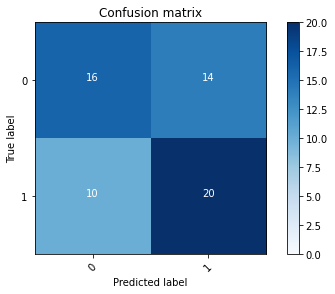

2022-02-17 14:28:47 - [Epoch Train: 137] loss: 0.0183, auc: 0.9997, acc: 0.9959, time: 58.00 s            
2022-02-17 14:28:47 - [Epoch Valid: 137] loss: 2.7272, auc: 0.6489, acc: 0.6000, time: 7.00 s


 46%|████████████████▉                    | 137/300 [2:39:36<3:00:22, 66.39s/it]

2022-02-17 14:28:47 - EPOCH: 138
2022-02-17 14:28:48 - Train Step 10/486, train_loss: 0.0003
2022-02-17 14:28:50 - Train Step 20/486, train_loss: 0.1298
2022-02-17 14:28:51 - Train Step 30/486, train_loss: 0.0869
2022-02-17 14:28:52 - Train Step 40/486, train_loss: 0.0661
2022-02-17 14:28:53 - Train Step 50/486, train_loss: 0.0529
2022-02-17 14:28:54 - Train Step 60/486, train_loss: 0.0441
2022-02-17 14:28:56 - Train Step 70/486, train_loss: 0.0379
2022-02-17 14:28:57 - Train Step 80/486, train_loss: 0.0332
2022-02-17 14:28:58 - Train Step 90/486, train_loss: 0.0451
2022-02-17 14:28:59 - Train Step 100/486, train_loss: 0.0425
2022-02-17 14:29:01 - Train Step 110/486, train_loss: 0.0386
2022-02-17 14:29:02 - Train Step 120/486, train_loss: 0.0363
2022-02-17 14:29:03 - Train Step 130/486, train_loss: 0.0352
2022-02-17 14:29:04 - Train Step 140/486, train_loss: 0.0327
2022-02-17 14:29:05 - Train Step 150/486, train_loss: 0.0306
2022-02-17 14:29:07 - Train Step 160/486, train_loss: 0.0290


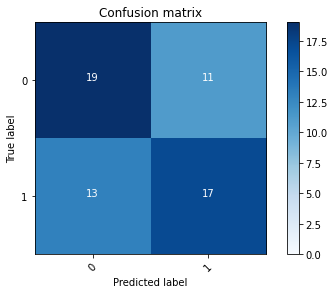

2022-02-17 14:29:54 - [Epoch Train: 138] loss: 0.0125, auc: 0.9999, acc: 0.9938, time: 59.00 s            
2022-02-17 14:29:54 - [Epoch Valid: 138] loss: 4.1635, auc: 0.6494, acc: 0.6000, time: 7.00 s


 46%|█████████████████                    | 138/300 [2:40:43<2:59:58, 66.66s/it]

2022-02-17 14:29:54 - EPOCH: 139
2022-02-17 14:29:56 - Train Step 10/486, train_loss: 0.0044
2022-02-17 14:29:57 - Train Step 20/486, train_loss: 0.0076
2022-02-17 14:29:58 - Train Step 30/486, train_loss: 0.0051
2022-02-17 14:29:59 - Train Step 40/486, train_loss: 0.0041
2022-02-17 14:30:01 - Train Step 50/486, train_loss: 0.0033
2022-02-17 14:30:02 - Train Step 60/486, train_loss: 0.0028
2022-02-17 14:30:03 - Train Step 70/486, train_loss: 0.0064
2022-02-17 14:30:04 - Train Step 80/486, train_loss: 0.0056
2022-02-17 14:30:05 - Train Step 90/486, train_loss: 0.0050
2022-02-17 14:30:06 - Train Step 100/486, train_loss: 0.0045
2022-02-17 14:30:08 - Train Step 110/486, train_loss: 0.0041
2022-02-17 14:30:09 - Train Step 120/486, train_loss: 0.0038
2022-02-17 14:30:10 - Train Step 130/486, train_loss: 0.0035
2022-02-17 14:30:11 - Train Step 140/486, train_loss: 0.0033
2022-02-17 14:30:12 - Train Step 150/486, train_loss: 0.0030
2022-02-17 14:30:14 - Train Step 160/486, train_loss: 0.0029


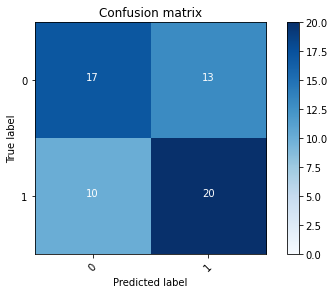

2022-02-17 14:31:01 - [Epoch Train: 139] loss: 0.0124, auc: 0.9999, acc: 0.9938, time: 58.00 s            
2022-02-17 14:31:01 - [Epoch Valid: 139] loss: 3.1521, auc: 0.6644, acc: 0.6167, time: 7.00 s


 46%|█████████████████▏                   | 139/300 [2:41:49<2:58:45, 66.62s/it]

2022-02-17 14:31:01 - EPOCH: 140
2022-02-17 14:31:02 - Train Step 10/486, train_loss: 0.0014
2022-02-17 14:31:03 - Train Step 20/486, train_loss: 0.0014
2022-02-17 14:31:05 - Train Step 30/486, train_loss: 0.0010
2022-02-17 14:31:06 - Train Step 40/486, train_loss: 0.0008
2022-02-17 14:31:07 - Train Step 50/486, train_loss: 0.0010
2022-02-17 14:31:08 - Train Step 60/486, train_loss: 0.0008
2022-02-17 14:31:09 - Train Step 70/486, train_loss: 0.0009
2022-02-17 14:31:11 - Train Step 80/486, train_loss: 0.0008
2022-02-17 14:31:12 - Train Step 90/486, train_loss: 0.0007
2022-02-17 14:31:13 - Train Step 100/486, train_loss: 0.0039
2022-02-17 14:31:14 - Train Step 110/486, train_loss: 0.0049
2022-02-17 14:31:16 - Train Step 120/486, train_loss: 0.0045
2022-02-17 14:31:17 - Train Step 130/486, train_loss: 0.0043
2022-02-17 14:31:18 - Train Step 140/486, train_loss: 0.0061
2022-02-17 14:31:19 - Train Step 150/486, train_loss: 0.0057
2022-02-17 14:31:20 - Train Step 160/486, train_loss: 0.0055


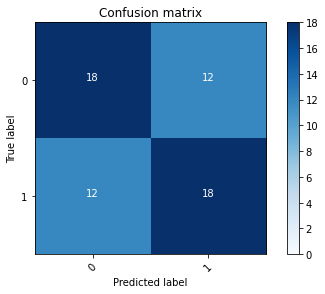

2022-02-17 14:32:08 - [Epoch Train: 140] loss: 0.0125, auc: 1.0000, acc: 0.9938, time: 59.00 s            
2022-02-17 14:32:08 - [Epoch Valid: 140] loss: 3.8309, auc: 0.6322, acc: 0.6000, time: 7.00 s


 47%|█████████████████▎                   | 140/300 [2:42:57<2:58:00, 66.76s/it]

2022-02-17 14:32:08 - EPOCH: 141
2022-02-17 14:32:09 - Train Step 10/486, train_loss: 0.0022
2022-02-17 14:32:10 - Train Step 20/486, train_loss: 0.0013
2022-02-17 14:32:12 - Train Step 30/486, train_loss: 0.0015
2022-02-17 14:32:13 - Train Step 40/486, train_loss: 0.0087
2022-02-17 14:32:14 - Train Step 50/486, train_loss: 0.0104
2022-02-17 14:32:15 - Train Step 60/486, train_loss: 0.0087
2022-02-17 14:32:16 - Train Step 70/486, train_loss: 0.0075
2022-02-17 14:32:18 - Train Step 80/486, train_loss: 0.0135
2022-02-17 14:32:19 - Train Step 90/486, train_loss: 0.0120
2022-02-17 14:32:20 - Train Step 100/486, train_loss: 0.0109
2022-02-17 14:32:21 - Train Step 110/486, train_loss: 0.0100
2022-02-17 14:32:22 - Train Step 120/486, train_loss: 0.0091
2022-02-17 14:32:24 - Train Step 130/486, train_loss: 0.0084
2022-02-17 14:32:25 - Train Step 140/486, train_loss: 0.0079
2022-02-17 14:32:26 - Train Step 150/486, train_loss: 0.0075
2022-02-17 14:32:27 - Train Step 160/486, train_loss: 0.0070


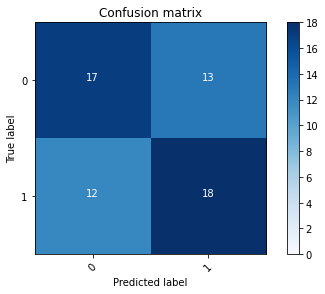

2022-02-17 14:33:14 - [Epoch Train: 141] loss: 0.0106, auc: 0.9999, acc: 0.9938, time: 58.00 s            
2022-02-17 14:33:14 - [Epoch Valid: 141] loss: 4.3271, auc: 0.6394, acc: 0.5833, time: 7.00 s


 47%|█████████████████▍                   | 141/300 [2:44:02<2:56:03, 66.44s/it]

2022-02-17 14:33:14 - EPOCH: 142
2022-02-17 14:33:15 - Train Step 10/486, train_loss: 0.0000
2022-02-17 14:33:16 - Train Step 20/486, train_loss: 0.0022
2022-02-17 14:33:17 - Train Step 30/486, train_loss: 0.0018
2022-02-17 14:33:18 - Train Step 40/486, train_loss: 0.0014
2022-02-17 14:33:20 - Train Step 50/486, train_loss: 0.0011
2022-02-17 14:33:21 - Train Step 60/486, train_loss: 0.0010
2022-02-17 14:33:22 - Train Step 70/486, train_loss: 0.0013
2022-02-17 14:33:23 - Train Step 80/486, train_loss: 0.0050
2022-02-17 14:33:24 - Train Step 90/486, train_loss: 0.0046
2022-02-17 14:33:26 - Train Step 100/486, train_loss: 0.0041
2022-02-17 14:33:27 - Train Step 110/486, train_loss: 0.0038
2022-02-17 14:33:28 - Train Step 120/486, train_loss: 0.0035
2022-02-17 14:33:29 - Train Step 130/486, train_loss: 0.0039
2022-02-17 14:33:30 - Train Step 140/486, train_loss: 0.0036
2022-02-17 14:33:32 - Train Step 150/486, train_loss: 0.0051
2022-02-17 14:33:33 - Train Step 160/486, train_loss: 0.0049


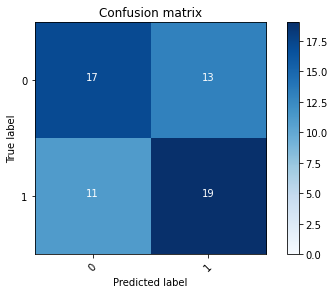

2022-02-17 14:34:19 - [Epoch Train: 142] loss: 0.0120, auc: 1.0000, acc: 0.9938, time: 58.00 s            
2022-02-17 14:34:19 - [Epoch Valid: 142] loss: 4.6715, auc: 0.6500, acc: 0.6000, time: 7.00 s


 47%|█████████████████▌                   | 142/300 [2:45:08<2:54:25, 66.24s/it]

2022-02-17 14:34:19 - EPOCH: 143
2022-02-17 14:34:21 - Train Step 10/486, train_loss: 0.0001
2022-02-17 14:34:22 - Train Step 20/486, train_loss: 0.0001
2022-02-17 14:34:23 - Train Step 30/486, train_loss: 0.0000
2022-02-17 14:34:24 - Train Step 40/486, train_loss: 0.0000
2022-02-17 14:34:25 - Train Step 50/486, train_loss: 0.0001
2022-02-17 14:34:27 - Train Step 60/486, train_loss: 0.0001
2022-02-17 14:34:28 - Train Step 70/486, train_loss: 0.0039
2022-02-17 14:34:29 - Train Step 80/486, train_loss: 0.0040
2022-02-17 14:34:30 - Train Step 90/486, train_loss: 0.0036
2022-02-17 14:34:31 - Train Step 100/486, train_loss: 0.0039
2022-02-17 14:34:33 - Train Step 110/486, train_loss: 0.0039
2022-02-17 14:34:34 - Train Step 120/486, train_loss: 0.0190
2022-02-17 14:34:35 - Train Step 130/486, train_loss: 0.0176
2022-02-17 14:34:36 - Train Step 140/486, train_loss: 0.0188
2022-02-17 14:34:37 - Train Step 150/486, train_loss: 0.0415
2022-02-17 14:34:39 - Train Step 160/486, train_loss: 0.0474


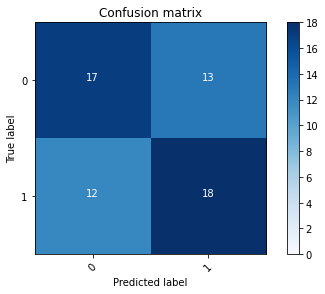

2022-02-17 14:35:26 - [Epoch Train: 143] loss: 0.0255, auc: 0.9995, acc: 0.9897, time: 58.00 s            
2022-02-17 14:35:26 - [Epoch Valid: 143] loss: 3.6578, auc: 0.6267, acc: 0.5833, time: 7.00 s


 48%|█████████████████▋                   | 143/300 [2:46:14<2:53:32, 66.32s/it]

2022-02-17 14:35:26 - EPOCH: 144
2022-02-17 14:35:27 - Train Step 10/486, train_loss: 0.0043
2022-02-17 14:35:28 - Train Step 20/486, train_loss: 0.0023
2022-02-17 14:35:30 - Train Step 30/486, train_loss: 0.0017
2022-02-17 14:35:31 - Train Step 40/486, train_loss: 0.0026
2022-02-17 14:35:32 - Train Step 50/486, train_loss: 0.0035
2022-02-17 14:35:33 - Train Step 60/486, train_loss: 0.0353
2022-02-17 14:35:35 - Train Step 70/486, train_loss: 0.0342
2022-02-17 14:35:36 - Train Step 80/486, train_loss: 0.0325
2022-02-17 14:35:37 - Train Step 90/486, train_loss: 0.0290
2022-02-17 14:35:38 - Train Step 100/486, train_loss: 0.0261
2022-02-17 14:35:40 - Train Step 110/486, train_loss: 0.0375
2022-02-17 14:35:41 - Train Step 120/486, train_loss: 0.0345
2022-02-17 14:35:42 - Train Step 130/486, train_loss: 0.0318
2022-02-17 14:35:44 - Train Step 140/486, train_loss: 0.0296
2022-02-17 14:35:45 - Train Step 150/486, train_loss: 0.0277
2022-02-17 14:35:46 - Train Step 160/486, train_loss: 0.0260


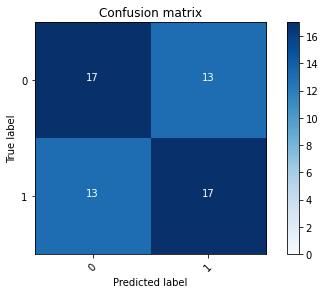

2022-02-17 14:36:35 - [Epoch Train: 144] loss: 0.0138, auc: 0.9999, acc: 0.9959, time: 61.00 s            
2022-02-17 14:36:35 - [Epoch Valid: 144] loss: 3.8344, auc: 0.6311, acc: 0.5667, time: 7.00 s


 48%|█████████████████▊                   | 144/300 [2:47:24<2:54:40, 67.18s/it]

2022-02-17 14:36:35 - EPOCH: 145
2022-02-17 14:36:36 - Train Step 10/486, train_loss: 0.0000
2022-02-17 14:36:38 - Train Step 20/486, train_loss: 0.0000
2022-02-17 14:36:39 - Train Step 30/486, train_loss: 0.0010
2022-02-17 14:36:40 - Train Step 40/486, train_loss: 0.0023
2022-02-17 14:36:41 - Train Step 50/486, train_loss: 0.0023
2022-02-17 14:36:42 - Train Step 60/486, train_loss: 0.0021
2022-02-17 14:36:44 - Train Step 70/486, train_loss: 0.0018
2022-02-17 14:36:45 - Train Step 80/486, train_loss: 0.0017
2022-02-17 14:36:46 - Train Step 90/486, train_loss: 0.0018
2022-02-17 14:36:47 - Train Step 100/486, train_loss: 0.0018
2022-02-17 14:36:48 - Train Step 110/486, train_loss: 0.0032
2022-02-17 14:36:50 - Train Step 120/486, train_loss: 0.0029
2022-02-17 14:36:51 - Train Step 130/486, train_loss: 0.0027
2022-02-17 14:36:52 - Train Step 140/486, train_loss: 0.0025
2022-02-17 14:36:53 - Train Step 150/486, train_loss: 0.0024
2022-02-17 14:36:54 - Train Step 160/486, train_loss: 0.0040


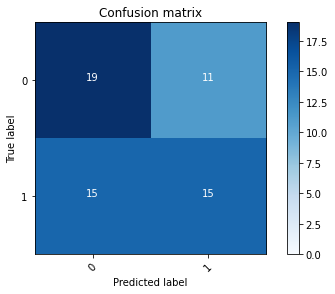

2022-02-17 14:37:41 - [Epoch Train: 145] loss: 0.0048, auc: 1.0000, acc: 1.0000, time: 57.00 s            
2022-02-17 14:37:41 - [Epoch Valid: 145] loss: 4.3607, auc: 0.6289, acc: 0.5667, time: 7.00 s


 48%|█████████████████▉                   | 145/300 [2:48:29<2:52:23, 66.73s/it]

2022-02-17 14:37:41 - EPOCH: 146
2022-02-17 14:37:42 - Train Step 10/486, train_loss: 0.0001
2022-02-17 14:37:43 - Train Step 20/486, train_loss: 0.0003
2022-02-17 14:37:44 - Train Step 30/486, train_loss: 0.0010
2022-02-17 14:37:46 - Train Step 40/486, train_loss: 0.0007
2022-02-17 14:37:47 - Train Step 50/486, train_loss: 0.0010
2022-02-17 14:37:48 - Train Step 60/486, train_loss: 0.0009
2022-02-17 14:37:49 - Train Step 70/486, train_loss: 0.0016
2022-02-17 14:37:50 - Train Step 80/486, train_loss: 0.0014
2022-02-17 14:37:52 - Train Step 90/486, train_loss: 0.0012
2022-02-17 14:37:53 - Train Step 100/486, train_loss: 0.0011
2022-02-17 14:37:54 - Train Step 110/486, train_loss: 0.0010
2022-02-17 14:37:55 - Train Step 120/486, train_loss: 0.0010
2022-02-17 14:37:56 - Train Step 130/486, train_loss: 0.0009
2022-02-17 14:37:57 - Train Step 140/486, train_loss: 0.0010
2022-02-17 14:37:59 - Train Step 150/486, train_loss: 0.0010
2022-02-17 14:38:00 - Train Step 160/486, train_loss: 0.0016


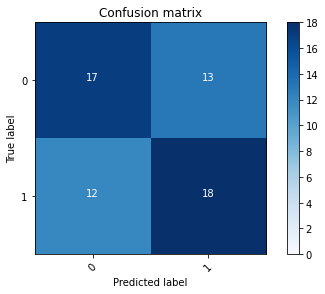

2022-02-17 14:38:47 - [Epoch Train: 146] loss: 0.0042, auc: 1.0000, acc: 1.0000, time: 58.00 s            
2022-02-17 14:38:47 - [Epoch Valid: 146] loss: 3.6015, auc: 0.6256, acc: 0.5833, time: 7.00 s


 49%|██████████████████                   | 146/300 [2:49:35<2:50:45, 66.53s/it]

2022-02-17 14:38:47 - EPOCH: 147
2022-02-17 14:38:48 - Train Step 10/486, train_loss: 0.0013
2022-02-17 14:38:49 - Train Step 20/486, train_loss: 0.0007
2022-02-17 14:38:51 - Train Step 30/486, train_loss: 0.0005
2022-02-17 14:38:52 - Train Step 40/486, train_loss: 0.0004
2022-02-17 14:38:53 - Train Step 50/486, train_loss: 0.0005
2022-02-17 14:38:54 - Train Step 60/486, train_loss: 0.0006
2022-02-17 14:38:55 - Train Step 70/486, train_loss: 0.0005
2022-02-17 14:38:57 - Train Step 80/486, train_loss: 0.0005
2022-02-17 14:38:58 - Train Step 90/486, train_loss: 0.0007
2022-02-17 14:38:59 - Train Step 100/486, train_loss: 0.0007
2022-02-17 14:39:00 - Train Step 110/486, train_loss: 0.0007
2022-02-17 14:39:02 - Train Step 120/486, train_loss: 0.0007
2022-02-17 14:39:03 - Train Step 130/486, train_loss: 0.0007
2022-02-17 14:39:04 - Train Step 140/486, train_loss: 0.0007
2022-02-17 14:39:05 - Train Step 150/486, train_loss: 0.0006
2022-02-17 14:39:06 - Train Step 160/486, train_loss: 0.0006


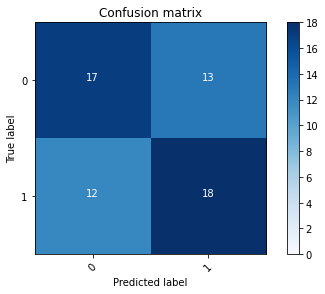

2022-02-17 14:39:53 - [Epoch Train: 147] loss: 0.0050, auc: 1.0000, acc: 1.0000, time: 58.00 s            
2022-02-17 14:39:53 - [Epoch Valid: 147] loss: 4.1187, auc: 0.6133, acc: 0.5833, time: 7.00 s


 49%|██████████████████▏                  | 147/300 [2:50:42<2:49:23, 66.43s/it]

2022-02-17 14:39:53 - EPOCH: 148
2022-02-17 14:39:54 - Train Step 10/486, train_loss: 0.0002
2022-02-17 14:39:56 - Train Step 20/486, train_loss: 0.0720
2022-02-17 14:39:57 - Train Step 30/486, train_loss: 0.0485
2022-02-17 14:39:58 - Train Step 40/486, train_loss: 0.0366
2022-02-17 14:39:59 - Train Step 50/486, train_loss: 0.0294
2022-02-17 14:40:00 - Train Step 60/486, train_loss: 0.0245
2022-02-17 14:40:02 - Train Step 70/486, train_loss: 0.0212
2022-02-17 14:40:03 - Train Step 80/486, train_loss: 0.0187
2022-02-17 14:40:04 - Train Step 90/486, train_loss: 0.0166
2022-02-17 14:40:05 - Train Step 100/486, train_loss: 0.0150
2022-02-17 14:40:06 - Train Step 110/486, train_loss: 0.0137
2022-02-17 14:40:08 - Train Step 120/486, train_loss: 0.0147
2022-02-17 14:40:09 - Train Step 130/486, train_loss: 0.0136
2022-02-17 14:40:10 - Train Step 140/486, train_loss: 0.0127
2022-02-17 14:40:11 - Train Step 150/486, train_loss: 0.0118
2022-02-17 14:40:12 - Train Step 160/486, train_loss: 0.0111


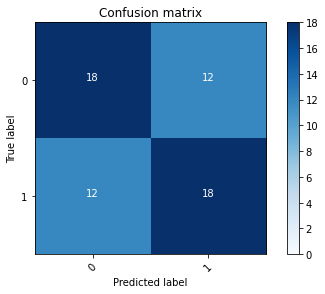

2022-02-17 14:40:58 - [Epoch Train: 148] loss: 0.0165, auc: 0.9999, acc: 0.9959, time: 57.00 s            
2022-02-17 14:40:58 - [Epoch Valid: 148] loss: 3.2599, auc: 0.6300, acc: 0.6000, time: 7.00 s


 49%|██████████████████▎                  | 148/300 [2:51:47<2:47:29, 66.11s/it]

2022-02-17 14:40:58 - EPOCH: 149
2022-02-17 14:41:00 - Train Step 10/486, train_loss: 0.1240
2022-02-17 14:41:01 - Train Step 20/486, train_loss: 0.0650
2022-02-17 14:41:02 - Train Step 30/486, train_loss: 0.0438
2022-02-17 14:41:03 - Train Step 40/486, train_loss: 0.0341
2022-02-17 14:41:04 - Train Step 50/486, train_loss: 0.0283
2022-02-17 14:41:06 - Train Step 60/486, train_loss: 0.0270
2022-02-17 14:41:07 - Train Step 70/486, train_loss: 0.0232
2022-02-17 14:41:08 - Train Step 80/486, train_loss: 0.0203
2022-02-17 14:41:09 - Train Step 90/486, train_loss: 0.0182
2022-02-17 14:41:11 - Train Step 100/486, train_loss: 0.0164
2022-02-17 14:41:12 - Train Step 110/486, train_loss: 0.0149
2022-02-17 14:41:13 - Train Step 120/486, train_loss: 0.0137
2022-02-17 14:41:14 - Train Step 130/486, train_loss: 0.0127
2022-02-17 14:41:16 - Train Step 140/486, train_loss: 0.0119
2022-02-17 14:41:17 - Train Step 150/486, train_loss: 0.0112
2022-02-17 14:41:18 - Train Step 160/486, train_loss: 0.0108


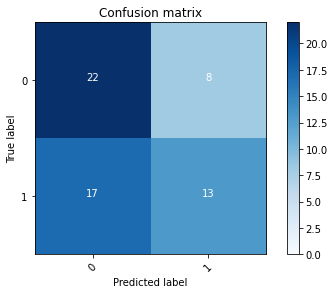

2022-02-17 14:42:05 - [Epoch Train: 149] loss: 0.0288, auc: 0.9990, acc: 0.9938, time: 59.00 s            
2022-02-17 14:42:05 - [Epoch Valid: 149] loss: 3.7598, auc: 0.6378, acc: 0.5833, time: 7.00 s


 50%|██████████████████▍                  | 149/300 [2:52:54<2:46:58, 66.35s/it]

2022-02-17 14:42:05 - EPOCH: 150
2022-02-17 14:42:07 - Train Step 10/486, train_loss: 0.0041
2022-02-17 14:42:08 - Train Step 20/486, train_loss: 0.0058
2022-02-17 14:42:09 - Train Step 30/486, train_loss: 0.0372
2022-02-17 14:42:10 - Train Step 40/486, train_loss: 0.0297
2022-02-17 14:42:11 - Train Step 50/486, train_loss: 0.0541
2022-02-17 14:42:13 - Train Step 60/486, train_loss: 0.0455
2022-02-17 14:42:14 - Train Step 70/486, train_loss: 0.0423
2022-02-17 14:42:15 - Train Step 80/486, train_loss: 0.0407
2022-02-17 14:42:16 - Train Step 90/486, train_loss: 0.0376
2022-02-17 14:42:18 - Train Step 100/486, train_loss: 0.0342
2022-02-17 14:42:19 - Train Step 110/486, train_loss: 0.0313
2022-02-17 14:42:20 - Train Step 120/486, train_loss: 0.0312
2022-02-17 14:42:21 - Train Step 130/486, train_loss: 0.0288
2022-02-17 14:42:22 - Train Step 140/486, train_loss: 0.0268
2022-02-17 14:42:23 - Train Step 150/486, train_loss: 0.0261
2022-02-17 14:42:25 - Train Step 160/486, train_loss: 0.0245


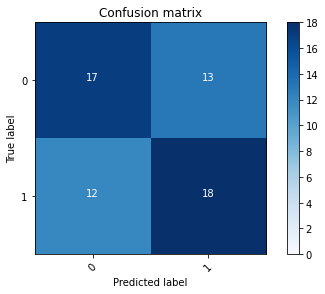

2022-02-17 14:43:11 - [Epoch Train: 150] loss: 0.0196, auc: 0.9999, acc: 0.9938, time: 58.00 s            
2022-02-17 14:43:11 - [Epoch Valid: 150] loss: 3.5178, auc: 0.6211, acc: 0.5833, time: 7.00 s


 50%|██████████████████▌                  | 150/300 [2:54:00<2:45:27, 66.18s/it]

2022-02-17 14:43:11 - EPOCH: 151
2022-02-17 14:43:12 - Train Step 10/486, train_loss: 0.0267
2022-02-17 14:43:14 - Train Step 20/486, train_loss: 0.0144
2022-02-17 14:43:15 - Train Step 30/486, train_loss: 0.0114
2022-02-17 14:43:16 - Train Step 40/486, train_loss: 0.0086
2022-02-17 14:43:17 - Train Step 50/486, train_loss: 0.0073
2022-02-17 14:43:18 - Train Step 60/486, train_loss: 0.0105
2022-02-17 14:43:19 - Train Step 70/486, train_loss: 0.0128
2022-02-17 14:43:21 - Train Step 80/486, train_loss: 0.0112
2022-02-17 14:43:22 - Train Step 90/486, train_loss: 0.0103
2022-02-17 14:43:23 - Train Step 100/486, train_loss: 0.0120
2022-02-17 14:43:24 - Train Step 110/486, train_loss: 0.0110
2022-02-17 14:43:26 - Train Step 120/486, train_loss: 0.0123
2022-02-17 14:43:27 - Train Step 130/486, train_loss: 0.0114
2022-02-17 14:43:28 - Train Step 140/486, train_loss: 0.0110
2022-02-17 14:43:29 - Train Step 150/486, train_loss: 0.0103
2022-02-17 14:43:30 - Train Step 160/486, train_loss: 0.0096


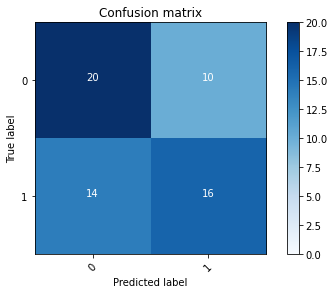

2022-02-17 14:44:18 - [Epoch Train: 151] loss: 0.0074, auc: 1.0000, acc: 0.9979, time: 59.00 s            
2022-02-17 14:44:18 - [Epoch Valid: 151] loss: 4.8175, auc: 0.6194, acc: 0.6000, time: 7.00 s


 50%|██████████████████▌                  | 151/300 [2:55:07<2:44:59, 66.44s/it]

2022-02-17 14:44:18 - EPOCH: 152
2022-02-17 14:44:19 - Train Step 10/486, train_loss: 0.0000
2022-02-17 14:44:21 - Train Step 20/486, train_loss: 0.0002
2022-02-17 14:44:22 - Train Step 30/486, train_loss: 0.0019
2022-02-17 14:44:23 - Train Step 40/486, train_loss: 0.0021
2022-02-17 14:44:24 - Train Step 50/486, train_loss: 0.0017
2022-02-17 14:44:26 - Train Step 60/486, train_loss: 0.0015
2022-02-17 14:44:27 - Train Step 70/486, train_loss: 0.0013
2022-02-17 14:44:28 - Train Step 80/486, train_loss: 0.0217
2022-02-17 14:44:29 - Train Step 90/486, train_loss: 0.0223
2022-02-17 14:44:30 - Train Step 100/486, train_loss: 0.0201
2022-02-17 14:44:32 - Train Step 110/486, train_loss: 0.0196
2022-02-17 14:44:33 - Train Step 120/486, train_loss: 0.0192
2022-02-17 14:44:34 - Train Step 130/486, train_loss: 0.0238
2022-02-17 14:44:35 - Train Step 140/486, train_loss: 0.0225
2022-02-17 14:44:36 - Train Step 150/486, train_loss: 0.0210
2022-02-17 14:44:38 - Train Step 160/486, train_loss: 0.0203


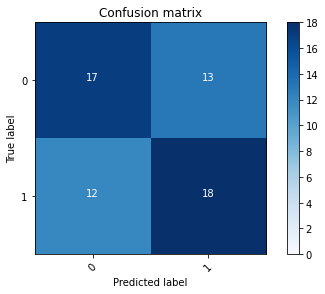

2022-02-17 14:45:24 - [Epoch Train: 152] loss: 0.0111, auc: 1.0000, acc: 0.9959, time: 58.00 s            
2022-02-17 14:45:24 - [Epoch Valid: 152] loss: 4.5865, auc: 0.6133, acc: 0.5833, time: 7.00 s


 51%|██████████████████▋                  | 152/300 [2:56:13<2:43:31, 66.29s/it]

2022-02-17 14:45:24 - EPOCH: 153
2022-02-17 14:45:25 - Train Step 10/486, train_loss: 0.1077
2022-02-17 14:45:27 - Train Step 20/486, train_loss: 0.0539
2022-02-17 14:45:28 - Train Step 30/486, train_loss: 0.0370
2022-02-17 14:45:29 - Train Step 40/486, train_loss: 0.0377
2022-02-17 14:45:30 - Train Step 50/486, train_loss: 0.0303
2022-02-17 14:45:31 - Train Step 60/486, train_loss: 0.0257
2022-02-17 14:45:33 - Train Step 70/486, train_loss: 0.0221
2022-02-17 14:45:34 - Train Step 80/486, train_loss: 0.0193
2022-02-17 14:45:35 - Train Step 90/486, train_loss: 0.0194
2022-02-17 14:45:36 - Train Step 100/486, train_loss: 0.0178
2022-02-17 14:45:37 - Train Step 110/486, train_loss: 0.0162
2022-02-17 14:45:38 - Train Step 120/486, train_loss: 0.0149
2022-02-17 14:45:40 - Train Step 130/486, train_loss: 0.0138
2022-02-17 14:45:41 - Train Step 140/486, train_loss: 0.0128
2022-02-17 14:45:42 - Train Step 150/486, train_loss: 0.0120
2022-02-17 14:45:43 - Train Step 160/486, train_loss: 0.0113


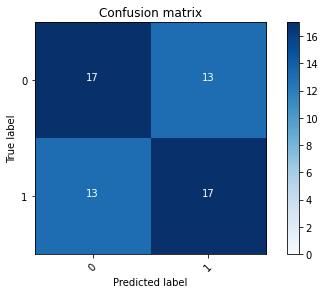

2022-02-17 14:46:30 - [Epoch Train: 153] loss: 0.0118, auc: 0.9999, acc: 0.9959, time: 58.00 s            
2022-02-17 14:46:30 - [Epoch Valid: 153] loss: 4.1162, auc: 0.6472, acc: 0.5667, time: 7.00 s


 51%|██████████████████▊                  | 153/300 [2:57:19<2:42:16, 66.23s/it]

2022-02-17 14:46:30 - EPOCH: 154
2022-02-17 14:46:31 - Train Step 10/486, train_loss: 0.0032
2022-02-17 14:46:33 - Train Step 20/486, train_loss: 0.0017
2022-02-17 14:46:34 - Train Step 30/486, train_loss: 0.0012
2022-02-17 14:46:35 - Train Step 40/486, train_loss: 0.0009
2022-02-17 14:46:36 - Train Step 50/486, train_loss: 0.0057
2022-02-17 14:46:38 - Train Step 60/486, train_loss: 0.0048
2022-02-17 14:46:39 - Train Step 70/486, train_loss: 0.0041
2022-02-17 14:46:40 - Train Step 80/486, train_loss: 0.0177
2022-02-17 14:46:41 - Train Step 90/486, train_loss: 0.0163
2022-02-17 14:46:42 - Train Step 100/486, train_loss: 0.0200
2022-02-17 14:46:43 - Train Step 110/486, train_loss: 0.0204
2022-02-17 14:46:45 - Train Step 120/486, train_loss: 0.0187
2022-02-17 14:46:46 - Train Step 130/486, train_loss: 0.0181
2022-02-17 14:46:47 - Train Step 140/486, train_loss: 0.0187
2022-02-17 14:46:48 - Train Step 150/486, train_loss: 0.0176
2022-02-17 14:46:49 - Train Step 160/486, train_loss: 0.0166


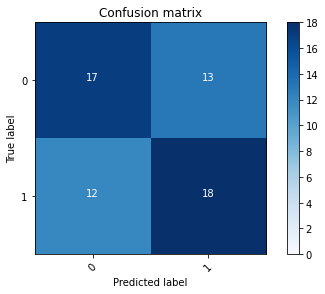

2022-02-17 14:47:36 - [Epoch Train: 154] loss: 0.0098, auc: 1.0000, acc: 0.9979, time: 58.00 s            
2022-02-17 14:47:36 - [Epoch Valid: 154] loss: 4.2269, auc: 0.6461, acc: 0.5833, time: 7.00 s


 51%|██████████████████▉                  | 154/300 [2:58:24<2:40:43, 66.05s/it]

2022-02-17 14:47:36 - EPOCH: 155
2022-02-17 14:47:37 - Train Step 10/486, train_loss: 0.0156
2022-02-17 14:47:38 - Train Step 20/486, train_loss: 0.0084
2022-02-17 14:47:39 - Train Step 30/486, train_loss: 0.0057
2022-02-17 14:47:41 - Train Step 40/486, train_loss: 0.0043
2022-02-17 14:47:42 - Train Step 50/486, train_loss: 0.0035
2022-02-17 14:47:43 - Train Step 60/486, train_loss: 0.0029
2022-02-17 14:47:44 - Train Step 70/486, train_loss: 0.0027
2022-02-17 14:47:46 - Train Step 80/486, train_loss: 0.0024
2022-02-17 14:47:47 - Train Step 90/486, train_loss: 0.0021
2022-02-17 14:47:48 - Train Step 100/486, train_loss: 0.0021
2022-02-17 14:47:49 - Train Step 110/486, train_loss: 0.0021
2022-02-17 14:47:50 - Train Step 120/486, train_loss: 0.0019
2022-02-17 14:47:52 - Train Step 130/486, train_loss: 0.0018
2022-02-17 14:47:53 - Train Step 140/486, train_loss: 0.0019
2022-02-17 14:47:54 - Train Step 150/486, train_loss: 0.0019
2022-02-17 14:47:55 - Train Step 160/486, train_loss: 0.0072


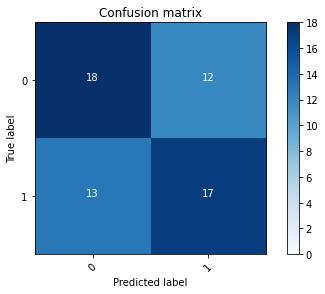

2022-02-17 14:48:41 - [Epoch Train: 155] loss: 0.0073, auc: 1.0000, acc: 0.9959, time: 58.00 s            
2022-02-17 14:48:41 - [Epoch Valid: 155] loss: 3.7890, auc: 0.6378, acc: 0.5833, time: 7.00 s


 52%|███████████████████                  | 155/300 [2:59:30<2:39:15, 65.90s/it]

2022-02-17 14:48:41 - EPOCH: 156
2022-02-17 14:48:43 - Train Step 10/486, train_loss: 0.0002
2022-02-17 14:48:44 - Train Step 20/486, train_loss: 0.0001
2022-02-17 14:48:45 - Train Step 30/486, train_loss: 0.0002
2022-02-17 14:48:46 - Train Step 40/486, train_loss: 0.0054
2022-02-17 14:48:47 - Train Step 50/486, train_loss: 0.0047
2022-02-17 14:48:49 - Train Step 60/486, train_loss: 0.0039
2022-02-17 14:48:50 - Train Step 70/486, train_loss: 0.0034
2022-02-17 14:48:51 - Train Step 80/486, train_loss: 0.0030
2022-02-17 14:48:52 - Train Step 90/486, train_loss: 0.0026
2022-02-17 14:48:53 - Train Step 100/486, train_loss: 0.0024
2022-02-17 14:48:55 - Train Step 110/486, train_loss: 0.0022
2022-02-17 14:48:56 - Train Step 120/486, train_loss: 0.0020
2022-02-17 14:48:57 - Train Step 130/486, train_loss: 0.0019
2022-02-17 14:48:58 - Train Step 140/486, train_loss: 0.0017
2022-02-17 14:48:59 - Train Step 150/486, train_loss: 0.0019
2022-02-17 14:49:01 - Train Step 160/486, train_loss: 0.0018


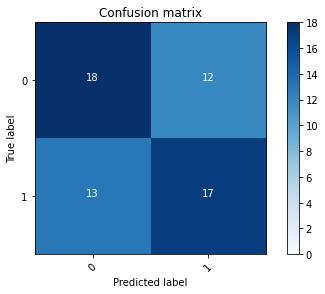

2022-02-17 14:49:47 - [Epoch Train: 156] loss: 0.0021, auc: 1.0000, acc: 1.0000, time: 58.00 s            
2022-02-17 14:49:47 - [Epoch Valid: 156] loss: 4.0704, auc: 0.6411, acc: 0.5833, time: 7.00 s


 52%|███████████████████▏                 | 156/300 [3:00:36<2:37:59, 65.83s/it]

2022-02-17 14:49:47 - EPOCH: 157
2022-02-17 14:49:48 - Train Step 10/486, train_loss: 0.0257
2022-02-17 14:49:49 - Train Step 20/486, train_loss: 0.0136
2022-02-17 14:49:51 - Train Step 30/486, train_loss: 0.0099
2022-02-17 14:49:52 - Train Step 40/486, train_loss: 0.0078
2022-02-17 14:49:53 - Train Step 50/486, train_loss: 0.0062
2022-02-17 14:49:54 - Train Step 60/486, train_loss: 0.0052
2022-02-17 14:49:55 - Train Step 70/486, train_loss: 0.0045
2022-02-17 14:49:56 - Train Step 80/486, train_loss: 0.0063
2022-02-17 14:49:58 - Train Step 90/486, train_loss: 0.0056
2022-02-17 14:49:59 - Train Step 100/486, train_loss: 0.0051
2022-02-17 14:50:00 - Train Step 110/486, train_loss: 0.0047
2022-02-17 14:50:01 - Train Step 120/486, train_loss: 0.0043
2022-02-17 14:50:02 - Train Step 130/486, train_loss: 0.0040
2022-02-17 14:50:04 - Train Step 140/486, train_loss: 0.0038
2022-02-17 14:50:05 - Train Step 150/486, train_loss: 0.0052
2022-02-17 14:50:06 - Train Step 160/486, train_loss: 0.0049


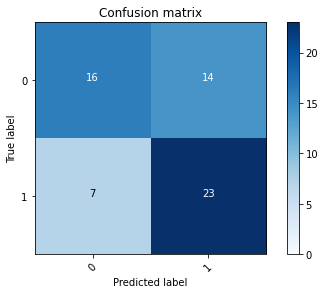

2022-02-17 14:50:57 - [Epoch Train: 157] loss: 0.0156, auc: 0.9999, acc: 0.9959, time: 61.00 s            
2022-02-17 14:50:57 - [Epoch Valid: 157] loss: 4.4620, auc: 0.6367, acc: 0.6500, time: 8.00 s


 52%|███████████████████▎                 | 157/300 [3:01:46<2:40:01, 67.14s/it]

2022-02-17 14:50:57 - EPOCH: 158
2022-02-17 14:50:59 - Train Step 10/486, train_loss: 0.0629
2022-02-17 14:51:00 - Train Step 20/486, train_loss: 0.0904
2022-02-17 14:51:01 - Train Step 30/486, train_loss: 0.0648
2022-02-17 14:51:03 - Train Step 40/486, train_loss: 0.0684
2022-02-17 14:51:04 - Train Step 50/486, train_loss: 0.0584
2022-02-17 14:51:05 - Train Step 60/486, train_loss: 0.0487
2022-02-17 14:51:07 - Train Step 70/486, train_loss: 0.0418
2022-02-17 14:51:08 - Train Step 80/486, train_loss: 0.0367
2022-02-17 14:51:09 - Train Step 90/486, train_loss: 0.0528
2022-02-17 14:51:11 - Train Step 100/486, train_loss: 0.0543
2022-02-17 14:51:12 - Train Step 110/486, train_loss: 0.0524
2022-02-17 14:51:13 - Train Step 120/486, train_loss: 0.0482
2022-02-17 14:51:14 - Train Step 130/486, train_loss: 0.0445
2022-02-17 14:51:16 - Train Step 140/486, train_loss: 0.0431
2022-02-17 14:51:17 - Train Step 150/486, train_loss: 0.0505
2022-02-17 14:51:18 - Train Step 160/486, train_loss: 0.0474


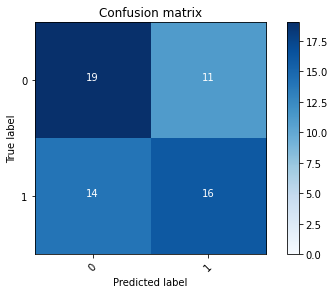

2022-02-17 14:52:11 - [Epoch Train: 158] loss: 0.0346, auc: 0.9992, acc: 0.9835, time: 65.00 s            
2022-02-17 14:52:11 - [Epoch Valid: 158] loss: 3.6567, auc: 0.6411, acc: 0.5833, time: 8.00 s


 53%|███████████████████▍                 | 158/300 [3:02:59<2:43:24, 69.05s/it]

2022-02-17 14:52:11 - EPOCH: 159
2022-02-17 14:52:12 - Train Step 10/486, train_loss: 0.0773
2022-02-17 14:52:13 - Train Step 20/486, train_loss: 0.0387
2022-02-17 14:52:15 - Train Step 30/486, train_loss: 0.0260
2022-02-17 14:52:16 - Train Step 40/486, train_loss: 0.0570
2022-02-17 14:52:17 - Train Step 50/486, train_loss: 0.0459
2022-02-17 14:52:19 - Train Step 60/486, train_loss: 0.0388
2022-02-17 14:52:20 - Train Step 70/486, train_loss: 0.0406
2022-02-17 14:52:21 - Train Step 80/486, train_loss: 0.0358
2022-02-17 14:52:22 - Train Step 90/486, train_loss: 0.0320
2022-02-17 14:52:24 - Train Step 100/486, train_loss: 0.0289
2022-02-17 14:52:25 - Train Step 110/486, train_loss: 0.0264
2022-02-17 14:52:26 - Train Step 120/486, train_loss: 0.0245
2022-02-17 14:52:27 - Train Step 130/486, train_loss: 0.0230
2022-02-17 14:52:29 - Train Step 140/486, train_loss: 0.0216
2022-02-17 14:52:30 - Train Step 150/486, train_loss: 0.0202
2022-02-17 14:52:31 - Train Step 160/486, train_loss: 0.0190


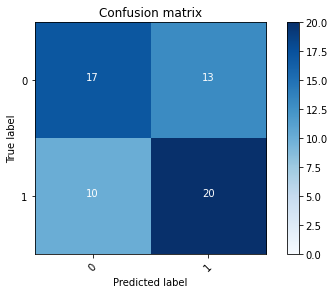

2022-02-17 14:53:21 - [Epoch Train: 159] loss: 0.0206, auc: 0.9998, acc: 0.9938, time: 62.00 s            
2022-02-17 14:53:21 - [Epoch Valid: 159] loss: 4.2816, auc: 0.6428, acc: 0.6167, time: 8.00 s


 53%|███████████████████▌                 | 159/300 [3:04:10<2:43:19, 69.50s/it]

2022-02-17 14:53:21 - EPOCH: 160
2022-02-17 14:53:23 - Train Step 10/486, train_loss: 0.0005
2022-02-17 14:53:24 - Train Step 20/486, train_loss: 0.0006
2022-02-17 14:53:25 - Train Step 30/486, train_loss: 0.0014
2022-02-17 14:53:27 - Train Step 40/486, train_loss: 0.0011
2022-02-17 14:53:28 - Train Step 50/486, train_loss: 0.0060
2022-02-17 14:53:29 - Train Step 60/486, train_loss: 0.0053
2022-02-17 14:53:30 - Train Step 70/486, train_loss: 0.0081
2022-02-17 14:53:32 - Train Step 80/486, train_loss: 0.0071
2022-02-17 14:53:33 - Train Step 90/486, train_loss: 0.0064
2022-02-17 14:53:34 - Train Step 100/486, train_loss: 0.0058
2022-02-17 14:53:36 - Train Step 110/486, train_loss: 0.0075
2022-02-17 14:53:37 - Train Step 120/486, train_loss: 0.0069
2022-02-17 14:53:38 - Train Step 130/486, train_loss: 0.0076
2022-02-17 14:53:40 - Train Step 140/486, train_loss: 0.0070
2022-02-17 14:53:41 - Train Step 150/486, train_loss: 0.0067
2022-02-17 14:53:42 - Train Step 160/486, train_loss: 0.0064


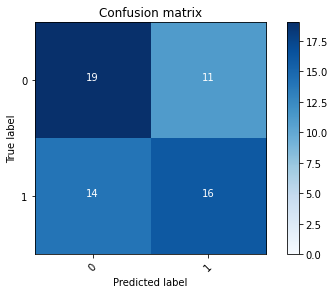

2022-02-17 14:54:34 - [Epoch Train: 160] loss: 0.0044, auc: 1.0000, acc: 1.0000, time: 64.00 s            
2022-02-17 14:54:34 - [Epoch Valid: 160] loss: 4.2240, auc: 0.6389, acc: 0.5833, time: 7.00 s


 53%|███████████████████▋                 | 160/300 [3:05:22<2:44:19, 70.43s/it]

2022-02-17 14:54:34 - EPOCH: 161
2022-02-17 14:54:35 - Train Step 10/486, train_loss: 0.0002
2022-02-17 14:54:37 - Train Step 20/486, train_loss: 0.0001
2022-02-17 14:54:38 - Train Step 30/486, train_loss: 0.0001
2022-02-17 14:54:39 - Train Step 40/486, train_loss: 0.0002
2022-02-17 14:54:40 - Train Step 50/486, train_loss: 0.0003
2022-02-17 14:54:42 - Train Step 60/486, train_loss: 0.0002
2022-02-17 14:54:43 - Train Step 70/486, train_loss: 0.0002
2022-02-17 14:54:44 - Train Step 80/486, train_loss: 0.0002
2022-02-17 14:54:45 - Train Step 90/486, train_loss: 0.0032
2022-02-17 14:54:47 - Train Step 100/486, train_loss: 0.0030
2022-02-17 14:54:48 - Train Step 110/486, train_loss: 0.0053
2022-02-17 14:54:49 - Train Step 120/486, train_loss: 0.0070
2022-02-17 14:54:51 - Train Step 130/486, train_loss: 0.0065
2022-02-17 14:54:52 - Train Step 140/486, train_loss: 0.0061
2022-02-17 14:54:53 - Train Step 150/486, train_loss: 0.0057
2022-02-17 14:54:55 - Train Step 160/486, train_loss: 0.0054


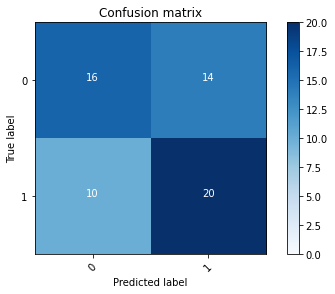

2022-02-17 14:55:45 - [Epoch Train: 161] loss: 0.0093, auc: 0.9999, acc: 0.9959, time: 62.00 s            
2022-02-17 14:55:45 - [Epoch Valid: 161] loss: 4.0203, auc: 0.6561, acc: 0.6000, time: 8.00 s


 54%|███████████████████▊                 | 161/300 [3:06:34<2:43:35, 70.62s/it]

2022-02-17 14:55:45 - EPOCH: 162
2022-02-17 14:55:46 - Train Step 10/486, train_loss: 0.0095
2022-02-17 14:55:48 - Train Step 20/486, train_loss: 0.0048
2022-02-17 14:55:49 - Train Step 30/486, train_loss: 0.0032
2022-02-17 14:55:50 - Train Step 40/486, train_loss: 0.0027
2022-02-17 14:55:52 - Train Step 50/486, train_loss: 0.0022
2022-02-17 14:55:53 - Train Step 60/486, train_loss: 0.0020
2022-02-17 14:55:54 - Train Step 70/486, train_loss: 0.0029
2022-02-17 14:55:55 - Train Step 80/486, train_loss: 0.0025
2022-02-17 14:55:57 - Train Step 90/486, train_loss: 0.0024
2022-02-17 14:55:58 - Train Step 100/486, train_loss: 0.0021
2022-02-17 14:55:59 - Train Step 110/486, train_loss: 0.0020
2022-02-17 14:56:01 - Train Step 120/486, train_loss: 0.0018
2022-02-17 14:56:02 - Train Step 130/486, train_loss: 0.0019
2022-02-17 14:56:03 - Train Step 140/486, train_loss: 0.0018
2022-02-17 14:56:04 - Train Step 150/486, train_loss: 0.0017
2022-02-17 14:56:06 - Train Step 160/486, train_loss: 0.0016


 54%|███████████████████▊                 | 161/300 [3:07:37<2:41:58, 69.92s/it]


FloatingPointError: underflow encountered in true_divide

In [15]:
#modelfile = train_mri_type(model, device, lr=0.0001, epochs=300, pat=300, 
#                           train_loader=train_loader, valid_loader=val_loader, is_multistep=is_multistep, size=size)
#chosen_iteration = 0

#sub_idx = None
pd.set_option("display.max_rows", None, "display.max_columns", None)
if info["is_10_fold"]:
    #sub_idx = chosen_iteration
    for i in tqdm(range(10)):
        dataloader = dataloaders[i]

        train_loader = dataloader[0]
        val_loader = dataloader[1]
        test_loader = dataloader[2]
        model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])
        modelfile = train_mri_type(model, device, info, epochs=100, pat=100, 
                           train_loader=train_loader, valid_loader=val_loader, sub_idx=i)
        print(modelfile)
        test_pred = predict(model, device, modelfile, test_loader, size)
else:
    dataloader = dataloaders[0]
    train_loader = dataloader[0]
    val_loader = dataloader[1]
    test_loader = dataloader[2]
    model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])
    modelfile = train_mri_type(model, device, info, epochs=300, pat=300, 
                           train_loader=train_loader, valid_loader=val_loader)
    print(modelfile)
    test_pred = predict(model, device, modelfile, test_loader, size)

../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Jan27_20-54-07/RSNAClassifierSingleFake3D-DW-SO-KLF-e62-loss0.364-acc0.877-auc0.949.pth
2022-01-27 22:44:52 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Jan27_20-54-07/RSNAClassifierSingleFake3D-DW-SO-KLF-e62-loss0.364-acc0.877-auc0.949.pth 570
Dataset: Labeled Test Set
                   BraTS21ID  MGMT_real_value  MGMT_value
39     Brats18_2013_17_1_KLF                1           1
47     Brats18_2013_18_1_KLF                1           1
2      Brats18_2013_22_1_KLF                1           1
37   Brats18_CBICA_ALU_1_KLF                1           1
43   Brats18_CBICA_AOP_1_KLF                1           1
15   Brats18_CBICA_AQO_1_KLF                1           1
40   Brats18_CBICA_ATD_1_KLF                1           1
51   Brats18_CBICA_AWH_1_KLF                1           1
10   Brats18_CBICA_AXN_1_KLF                1           1
22   Brats18_CBICA_AXO_1_KLF                1

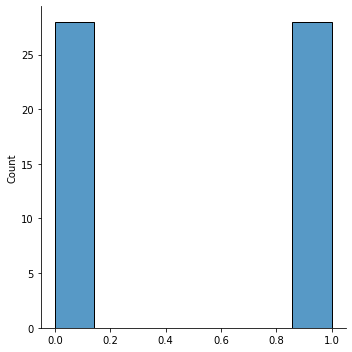

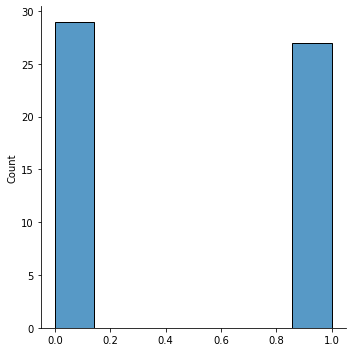

In [16]:
if info["is_10_fold"]:
    test_pred = pd.DataFrame({"BraTS21ID": [], "MGMT_real_value": [], "MGMT_value": []}) 
    model_mainfolder = "RSNAClassifierSingleFake3D-DW-SO-KLF-10F_Jan26_19-40-57"
    modelfolders = [
        f"{model_mainfolder}/RSNAClassifierSingleFake3D-DW-SO-KLF-10F(0)_Jan26_19-40-57",
        f"{model_mainfolder}/RSNAClassifierSingleFake3D-DW-SO-KLF-10F(1)_Jan26_20-49-47",
        f"{model_mainfolder}/RSNAClassifierSingleFake3D-DW-SO-KLF-10F(2)_Jan26_21-54-40",
        f"{model_mainfolder}/RSNAClassifierSingleFake3D-DW-SO-KLF-10F(3)_Jan26_22-59-32",
        f"{model_mainfolder}/RSNAClassifierSingleFake3D-DW-SO-KLF-10F(4)_Jan27_00-05-26",
        f"{model_mainfolder}/RSNAClassifierSingleFake3D-DW-SO-KLF-10F(5)_Jan27_01-11-39",
        f"{model_mainfolder}/RSNAClassifierSingleFake3D-DW-SO-KLF-10F(6)_Jan27_02-20-21",
        f"{model_mainfolder}/RSNAClassifierSingleFake3D-DW-SO-KLF-10F(7)_Jan27_03-28-13",
        f"{model_mainfolder}/RSNAClassifierSingleFake3D-DW-SO-KLF-10F(8)_Jan27_04-34-22",
        f"{model_mainfolder}/RSNAClassifierSingleFake3D-DW-SO-KLF-10F(9)_Jan27_05-40-25"
    ]

    for i in tqdm(range(10)):
        dataloader = dataloaders[i]

        train_loader = dataloader[0]
        val_loader = dataloader[1]
        test_loader = dataloader[2]
        model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])
        model_common_path = "../RSNA-BTC-Datasets/out_models/"
        model_folder = model_common_path + modelfolders[i] #folders_list[2]
        model_basefile, model_info = get_best_model(model_folder)
        modelfile = model_folder + "/" + model_basefile
        test_pred = pd.concat([test_pred, predict(model, device, modelfile, test_loader, size)], ignore_index=True)
    #val_pred = predict(model, device, modelfile, val_loader, size)
    test_pred = test_pred.sort_values(by="BraTS21ID")#.reset_index(drop=True)
    print("Total:")
    print(test_pred)
    
    acc = [1 if yy == out else 0 for (yy,out) in zip(test_pred["MGMT_real_value"],test_pred["MGMT_value"])].count(1)/len(test_pred["MGMT_value"])
    total_0_count = test_pred["MGMT_real_value"].value_counts()[0]
    total_1_count = test_pred["MGMT_real_value"].value_counts()[1]
    total_1_pred_count = test_pred["MGMT_value"].value_counts()[1]
    true_0 = [1 if yy == out and yy == 0 else 0 for (yy,out) in zip(test_pred["MGMT_real_value"],test_pred["MGMT_value"])].count(1)
    true_1 = [1 if yy == out and yy == 1 else 0 for (yy,out) in zip(test_pred["MGMT_real_value"],test_pred["MGMT_value"])].count(1)
    spec = true_0/total_0_count
    sens = true_1/total_1_count
    prec = true_1/total_1_pred_count
    print("Prediction Results:")
    print(f"Prediction Accuracy: {acc:.4f}")
    print(f"Prediction Specificity: {spec:.4f}")
    print(f"Prediction Sensitivity: {sens:.4f}")
    print(f"Prediction Precision: {prec:.4f}")
    test_pred.to_csv(f"{model_mainfolder}/inference_results_10F.csv", index=False)
else:
    #modelfolder = "RSNAClassifierSingle3D-DW-SO_Jan27_10-46-07"
    #modelfolder = "RSNAClassifierSingle3D-DW-SO-KLF_Jan27_19-25-03"
    modelfolder = "RSNAClassifierSingleFake3D-DW-SO-KLF_Jan27_20-54-07"
    dataloader = dataloaders[0]
    train_loader = dataloader[0]
    val_loader = dataloader[1]
    test_loader = dataloader[2]
    model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])
    model_common_path = "../RSNA-BTC-Datasets/out_models/"
    model_folder = model_common_path + modelfolder #folders_list[2]
    model_basefile, model_info = get_best_model(model_folder)
    modelfile = model_folder + "/" + model_basefile
    print(modelfile)
    test_pred = predict(model, device, modelfile, test_loader, size)

In [1]:
#modelfile = "../RSNA-BTC-Datasets/out_models/TunAIResNet_Dec28_22-14-42/TunAIResNet-e2-loss0.738-acc0.500-auc0.590.pth"
#modelfile = "../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW_Dec26_23-41-34/RSNAClassifierSingle3D-DW-e214-loss1.132-acc0.656-auc0.732.pth"
#modelfile = "../RSNA-BTC-Datasets/out_models/TunAIResNet-SO_Dec29_17-18-33/TunAIResNet-SO-e19-loss0.749-acc0.574-auc0.637.pth"
#modelfile = "../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Dec29_23-01-24/RSNAClassifierSingle3D-DW-SO-e288-loss4.272-acc0.500-auc0.521.pth"
#modelfile = "../RSNA-BTC-Datasets/out_models/BinaryEfficientNet3D_Dec26_18-48-05/BinaryEfficientNet3D-e61-loss0.669-acc0.648-auc0.687.pth"
#modelfile = "../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW_Dec27_13-14-39/RSNAClassifierSingle3D-DW-e24-loss0.672-acc0.625-auc0.689.pth"
folders_list = [
    "BinaryEfficientNet3D_Dec26_18-48-05",
    "RSNAClassifierSingle3D-DW_Dec26_23-41-34",
    "RSNAClassifierSingle3D-DW_Dec27_13-14-39",
    "RSNAClassifierFake3D-DW_Dec28_02-04-29",
    "RSNAClassifierSingle3D_Dec28_12-24-37",
    "VoxCNN_Dec28_16-34-14",
    "TunAIResNet-SO_Dec29_17-18-33",
    "RSNAClassifierSingle3D-DW-SO_Dec29_23-01-24",
    "RSNAClassifierSingle3D-DW-SO_Dec30_11-29-20",
    "RSNAClassifier3D-DW-SO_Dec30_17-28-11",
    "RSNAClassifier3D-DW-SO_Dec31_11-26-33",
    "RSNAClassifierSingle3D-DW-SO_Dec31_20-29-23",
    "RSNAClassifierSingle3D-DW-SO-KLF_Jan04_03-10-56",
    "TunAIResNet-SO-KLF_Jan04_11-41-16",
    "RSNAClassifierSingle3D-DW-KLF_Jan05_13-12-24",
    "RSNAClassifierSingle3D-DW-SO-KLF_Jan05_17-34-06",
    "RSNAClassifier3D-DW-SO_Jan05_21-40-24",
    "BinaryEfficientNet3D-SO_Jan06_10-48-16",
    "RSNAClassifierSingle3D-DW-SO-KLF_Jan06_18-44-02",
    "RSNAClassifierSingleFake3D-DW-SO-KLF_Jan06_23-32-23",
    "VoxCNN-KLF_Jan07_10-11-33",
    "RSNAClassifierSingleFake3D-DW-KLF_Jan12_02-21-47",
    "RSNAClassifierSingle3D-DW-KLF_Jan12_10-09-22",
    "RSNAClassifierSingleFake3D-DW-SO-KLF_Jan12_21-26-48",
    "RSNAClassifierSingle3D-DW-SO_Jan27_10-15-50",
    "RSNAClassifierSingle3D-DW-SO_Jan27_10-46-07",
    "RSNAClassifierSingle3D-DW-SO-KLF_Jan27_19-25-03",
    "RSNAClassifierSingleFake3D-DW-SO-KLF_Jan27_20-54-07",
    "RSNAClassifierSingleVoting2D-DW-SO-KLF_Feb04_14-01-18",
    "RSNAClassifierSingleVoting2D-DW-SO-KLF_Feb08_20-47-35",
    "RSNAClassifierSingleVoting2D-DW-SO-KLF_Feb08_21-59-11",
    "RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb08_23-24-39",
    "RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb13_08-42-12",
    "RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Feb17_11-49-11"
]

# TO REMOVE
folders_list = [
    "RSNAClassifierSingle3D-DW-SO_Jan27_10-15-50",
    "RSNAClassifierSingle3D-DW-SO-KLF_Jan27_19-25-03",
    "RSNAClassifierSingleFake3D-DW-SO-KLF_Jan27_20-54-07",
    "RSNAClassifierSingle3D-DW-SO_Jan27_10-46-07"
    
]


../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Jan27_10-15-50/RSNAClassifierSingle3D-DW-SO-e5-loss0.026-acc0.982-auc1.000.pth
{'ext': 'mat', 'mri_types': ['FLAIR'], 'dims': 3, 'batch_size': 2, 'is_depth_wise': 'True', 'is_transformed': 'True', 'output_size': 1, 'is_multistep': 'True', 'is_adam': 'True', 'lr': 0.0005, 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.1, 'is_internal_dataset': 'False', 'net': 'RSNAClassifierSingle3D'}
2022-02-21 10:57:38 - Using CUDA...
2022-02-21 10:57:38 - External Test 1 dataset size: 285
2022-02-21 10:57:38 - External Test 0 dataset size: 231
Length of concatenated dataset: 516
Length of concatenated dataset: 516
RSNAClassifierSingle3D(
  (part1): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): Conv3d(1, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running

  0%|                                                    | 0/10 [00:00<?, ?it/s]

2022-02-21 10:57:38 - EPOCH: 1
2022-02-21 10:57:46 - Train Step 10/207, train_loss: 0.6391
2022-02-21 10:57:52 - Train Step 20/207, train_loss: 0.5329
2022-02-21 10:57:59 - Train Step 30/207, train_loss: 0.4360
2022-02-21 10:58:05 - Train Step 40/207, train_loss: 0.3673
2022-02-21 10:58:12 - Train Step 50/207, train_loss: 0.3064
2022-02-21 10:58:18 - Train Step 60/207, train_loss: 0.2809
2022-02-21 10:58:24 - Train Step 70/207, train_loss: 0.2590
2022-02-21 10:58:31 - Train Step 80/207, train_loss: 0.2341
2022-02-21 10:58:36 - Train Step 90/207, train_loss: 0.2190
2022-02-21 10:58:43 - Train Step 100/207, train_loss: 0.1975
2022-02-21 10:58:50 - Train Step 110/207, train_loss: 0.1824
2022-02-21 10:58:56 - Train Step 120/207, train_loss: 0.1696
2022-02-21 10:59:02 - Train Step 130/207, train_loss: 0.1642
2022-02-21 10:59:07 - Train Step 140/207, train_loss: 0.1531
2022-02-21 10:59:13 - Train Step 150/207, train_loss: 0.1450
2022-02-21 10:59:19 - Train Step 160/207, train_loss: 0.1511
20

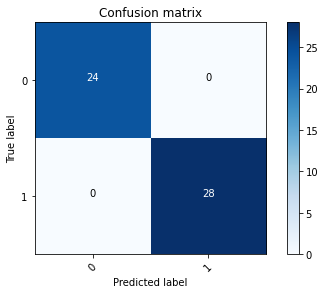

2022-02-21 11:00:07 - [Epoch Train: 1] loss: 0.1205, auc: 0.9936, acc: 0.9492, time: 130.00 s            
2022-02-21 11:00:07 - [Epoch Valid: 1] loss: 0.0042, auc: 1.0000, acc: 1.0000, time: 18.00 s
2022-02-21 11:00:07 - acc improved from 0.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_10-57-38/RSNAClassifierSingle3D-DW-SO-e1-loss0.004-acc1.000-auc1.000.pth'


 10%|████▎                                      | 1/10 [02:29<22:21, 149.03s/it]

2022-02-21 11:00:07 - EPOCH: 2
2022-02-21 11:00:15 - Train Step 10/207, train_loss: 0.0008
2022-02-21 11:00:21 - Train Step 20/207, train_loss: 0.0031
2022-02-21 11:00:27 - Train Step 30/207, train_loss: 0.0025
2022-02-21 11:00:34 - Train Step 40/207, train_loss: 0.0024
2022-02-21 11:00:39 - Train Step 50/207, train_loss: 0.0021
2022-02-21 11:00:47 - Train Step 60/207, train_loss: 0.0019
2022-02-21 11:00:53 - Train Step 70/207, train_loss: 0.0019
2022-02-21 11:01:00 - Train Step 80/207, train_loss: 0.0022
2022-02-21 11:01:06 - Train Step 90/207, train_loss: 0.0024
2022-02-21 11:01:12 - Train Step 100/207, train_loss: 0.0023
2022-02-21 11:01:19 - Train Step 110/207, train_loss: 0.0021
2022-02-21 11:01:25 - Train Step 120/207, train_loss: 0.0020
2022-02-21 11:01:32 - Train Step 130/207, train_loss: 0.0019
2022-02-21 11:01:39 - Train Step 140/207, train_loss: 0.0018
2022-02-21 11:01:45 - Train Step 150/207, train_loss: 0.0018
2022-02-21 11:01:52 - Train Step 160/207, train_loss: 0.0017
20

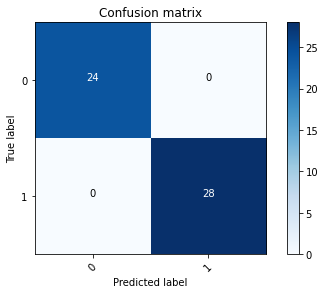

2022-02-21 11:02:42 - [Epoch Train: 2] loss: 0.0016, auc: 1.0000, acc: 1.0000, time: 136.00 s            
2022-02-21 11:02:42 - [Epoch Valid: 2] loss: 0.0022, auc: 1.0000, acc: 1.0000, time: 18.00 s
2022-02-21 11:02:42 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_10-57-38/RSNAClassifierSingle3D-DW-SO-e2-loss0.002-acc1.000-auc1.000.pth'


 20%|████████▌                                  | 2/10 [05:03<20:19, 152.45s/it]

2022-02-21 11:02:42 - EPOCH: 3
2022-02-21 11:02:49 - Train Step 10/207, train_loss: 0.0002
2022-02-21 11:02:55 - Train Step 20/207, train_loss: 0.0002
2022-02-21 11:03:01 - Train Step 30/207, train_loss: 0.0003
2022-02-21 11:03:07 - Train Step 40/207, train_loss: 0.0003
2022-02-21 11:03:14 - Train Step 50/207, train_loss: 0.0006
2022-02-21 11:03:20 - Train Step 60/207, train_loss: 0.0005
2022-02-21 11:03:26 - Train Step 70/207, train_loss: 0.0005
2022-02-21 11:03:32 - Train Step 80/207, train_loss: 0.0007
2022-02-21 11:03:38 - Train Step 90/207, train_loss: 0.0007
2022-02-21 11:03:45 - Train Step 100/207, train_loss: 0.0008
2022-02-21 11:03:51 - Train Step 110/207, train_loss: 0.0008
2022-02-21 11:03:57 - Train Step 120/207, train_loss: 0.0007
2022-02-21 11:04:04 - Train Step 130/207, train_loss: 0.0007
2022-02-21 11:04:10 - Train Step 140/207, train_loss: 0.0007
2022-02-21 11:04:16 - Train Step 150/207, train_loss: 0.0007
2022-02-21 11:04:23 - Train Step 160/207, train_loss: 0.0006
20

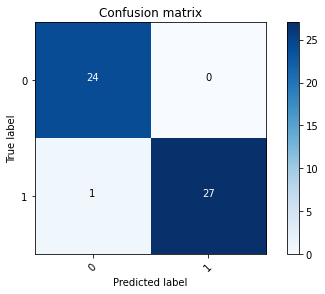

2022-02-21 11:05:10 - [Epoch Train: 3] loss: 0.0009, auc: 1.0000, acc: 1.0000, time: 130.00 s            
2022-02-21 11:05:10 - [Epoch Valid: 3] loss: 0.0127, auc: 1.0000, acc: 0.9808, time: 17.00 s


 30%|████████████▉                              | 3/10 [07:32<17:34, 150.61s/it]

2022-02-21 11:05:10 - EPOCH: 4
2022-02-21 11:05:17 - Train Step 10/207, train_loss: 0.0001
2022-02-21 11:05:23 - Train Step 20/207, train_loss: 0.0013
2022-02-21 11:05:30 - Train Step 30/207, train_loss: 0.0014
2022-02-21 11:05:36 - Train Step 40/207, train_loss: 0.0011
2022-02-21 11:05:43 - Train Step 50/207, train_loss: 0.0010
2022-02-21 11:05:50 - Train Step 60/207, train_loss: 0.0008
2022-02-21 11:05:56 - Train Step 70/207, train_loss: 0.0007
2022-02-21 11:06:03 - Train Step 80/207, train_loss: 0.0007
2022-02-21 11:06:10 - Train Step 90/207, train_loss: 0.0007
2022-02-21 11:06:16 - Train Step 100/207, train_loss: 0.0006
2022-02-21 11:06:23 - Train Step 110/207, train_loss: 0.0006
2022-02-21 11:06:29 - Train Step 120/207, train_loss: 0.0006
2022-02-21 11:06:35 - Train Step 130/207, train_loss: 0.0006
2022-02-21 11:06:42 - Train Step 140/207, train_loss: 0.0006
2022-02-21 11:06:49 - Train Step 150/207, train_loss: 0.0005
2022-02-21 11:06:55 - Train Step 160/207, train_loss: 0.0005
20

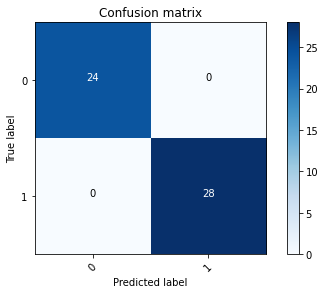

2022-02-21 11:07:47 - [Epoch Train: 4] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 137.00 s            
2022-02-21 11:07:47 - [Epoch Valid: 4] loss: 0.0014, auc: 1.0000, acc: 1.0000, time: 19.00 s
2022-02-21 11:07:47 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_10-57-38/RSNAClassifierSingle3D-DW-SO-e4-loss0.001-acc1.000-auc1.000.pth'


 40%|█████████████████▏                         | 4/10 [10:09<15:18, 153.12s/it]

2022-02-21 11:07:47 - EPOCH: 5
2022-02-21 11:07:54 - Train Step 10/207, train_loss: 0.0005
2022-02-21 11:08:00 - Train Step 20/207, train_loss: 0.0003
2022-02-21 11:08:06 - Train Step 30/207, train_loss: 0.0002
2022-02-21 11:08:13 - Train Step 40/207, train_loss: 0.0002
2022-02-21 11:08:18 - Train Step 50/207, train_loss: 0.0002
2022-02-21 11:08:24 - Train Step 60/207, train_loss: 0.0002
2022-02-21 11:08:30 - Train Step 70/207, train_loss: 0.0002
2022-02-21 11:08:35 - Train Step 80/207, train_loss: 0.0002
2022-02-21 11:08:41 - Train Step 90/207, train_loss: 0.0002
2022-02-21 11:08:46 - Train Step 100/207, train_loss: 0.0002
2022-02-21 11:08:52 - Train Step 110/207, train_loss: 0.0002
2022-02-21 11:08:57 - Train Step 120/207, train_loss: 0.0002
2022-02-21 11:09:03 - Train Step 130/207, train_loss: 0.0002
2022-02-21 11:09:09 - Train Step 140/207, train_loss: 0.0002
2022-02-21 11:09:15 - Train Step 150/207, train_loss: 0.0002
2022-02-21 11:09:21 - Train Step 160/207, train_loss: 0.0002
20

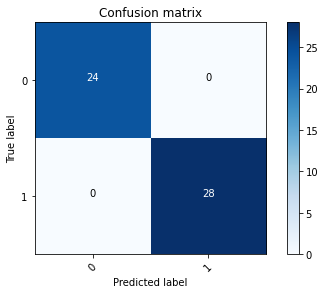

2022-02-21 11:10:07 - [Epoch Train: 5] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 120.00 s            
2022-02-21 11:10:07 - [Epoch Valid: 5] loss: 0.0012, auc: 1.0000, acc: 1.0000, time: 18.00 s
2022-02-21 11:10:07 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_10-57-38/RSNAClassifierSingle3D-DW-SO-e5-loss0.001-acc1.000-auc1.000.pth'


 50%|█████████████████████▌                     | 5/10 [12:29<12:21, 148.32s/it]

2022-02-21 11:10:07 - EPOCH: 6
2022-02-21 11:10:14 - Train Step 10/207, train_loss: 0.0001
2022-02-21 11:10:21 - Train Step 20/207, train_loss: 0.0001
2022-02-21 11:10:27 - Train Step 30/207, train_loss: 0.0001
2022-02-21 11:10:33 - Train Step 40/207, train_loss: 0.0001
2022-02-21 11:10:39 - Train Step 50/207, train_loss: 0.0001
2022-02-21 11:10:44 - Train Step 60/207, train_loss: 0.0001
2022-02-21 11:10:50 - Train Step 70/207, train_loss: 0.0001
2022-02-21 11:10:56 - Train Step 80/207, train_loss: 0.0002
2022-02-21 11:11:02 - Train Step 90/207, train_loss: 0.0002
2022-02-21 11:11:08 - Train Step 100/207, train_loss: 0.0002
2022-02-21 11:11:13 - Train Step 110/207, train_loss: 0.0001
2022-02-21 11:11:19 - Train Step 120/207, train_loss: 0.0001
2022-02-21 11:11:25 - Train Step 130/207, train_loss: 0.0001
2022-02-21 11:11:31 - Train Step 140/207, train_loss: 0.0001
2022-02-21 11:11:37 - Train Step 150/207, train_loss: 0.0001
2022-02-21 11:11:43 - Train Step 160/207, train_loss: 0.0001
20

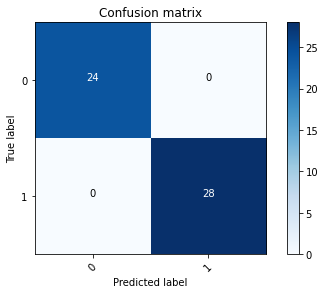

2022-02-21 11:12:28 - [Epoch Train: 6] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 123.00 s            
2022-02-21 11:12:28 - [Epoch Valid: 6] loss: 0.0015, auc: 1.0000, acc: 1.0000, time: 17.00 s
2022-02-21 11:12:28 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_10-57-38/RSNAClassifierSingle3D-DW-SO-e6-loss0.002-acc1.000-auc1.000.pth'


 60%|█████████████████████████▊                 | 6/10 [14:50<09:43, 145.93s/it]

2022-02-21 11:12:28 - EPOCH: 7
2022-02-21 11:12:35 - Train Step 10/207, train_loss: 0.0001
2022-02-21 11:12:41 - Train Step 20/207, train_loss: 0.0001
2022-02-21 11:12:47 - Train Step 30/207, train_loss: 0.0002
2022-02-21 11:12:53 - Train Step 40/207, train_loss: 0.0002
2022-02-21 11:12:59 - Train Step 50/207, train_loss: 0.0001
2022-02-21 11:13:04 - Train Step 60/207, train_loss: 0.0001
2022-02-21 11:13:10 - Train Step 70/207, train_loss: 0.0001
2022-02-21 11:13:16 - Train Step 80/207, train_loss: 0.0001
2022-02-21 11:13:21 - Train Step 90/207, train_loss: 0.0001
2022-02-21 11:13:26 - Train Step 100/207, train_loss: 0.0001
2022-02-21 11:13:31 - Train Step 110/207, train_loss: 0.0001
2022-02-21 11:13:36 - Train Step 120/207, train_loss: 0.0001
2022-02-21 11:13:41 - Train Step 130/207, train_loss: 0.0001
2022-02-21 11:13:46 - Train Step 140/207, train_loss: 0.0001
2022-02-21 11:13:51 - Train Step 150/207, train_loss: 0.0001
2022-02-21 11:13:56 - Train Step 160/207, train_loss: 0.0001
20

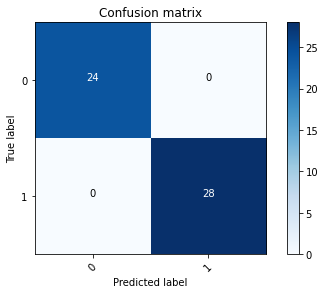

2022-02-21 11:14:37 - [Epoch Train: 7] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 111.00 s            
2022-02-21 11:14:37 - [Epoch Valid: 7] loss: 0.0012, auc: 1.0000, acc: 1.0000, time: 17.00 s
2022-02-21 11:14:37 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_10-57-38/RSNAClassifierSingle3D-DW-SO-e7-loss0.001-acc1.000-auc1.000.pth'


 70%|██████████████████████████████             | 7/10 [16:59<07:01, 140.50s/it]

2022-02-21 11:14:37 - EPOCH: 8
2022-02-21 11:14:44 - Train Step 10/207, train_loss: 0.0000
2022-02-21 11:14:50 - Train Step 20/207, train_loss: 0.0001
2022-02-21 11:14:55 - Train Step 30/207, train_loss: 0.0000
2022-02-21 11:15:01 - Train Step 40/207, train_loss: 0.0001
2022-02-21 11:15:06 - Train Step 50/207, train_loss: 0.0001
2022-02-21 11:15:12 - Train Step 60/207, train_loss: 0.0001
2022-02-21 11:15:18 - Train Step 70/207, train_loss: 0.0001
2022-02-21 11:15:24 - Train Step 80/207, train_loss: 0.0001
2022-02-21 11:15:29 - Train Step 90/207, train_loss: 0.0001
2022-02-21 11:15:35 - Train Step 100/207, train_loss: 0.0001
2022-02-21 11:15:40 - Train Step 110/207, train_loss: 0.0001
2022-02-21 11:15:46 - Train Step 120/207, train_loss: 0.0001
2022-02-21 11:15:52 - Train Step 130/207, train_loss: 0.0001
2022-02-21 11:15:57 - Train Step 140/207, train_loss: 0.0001
2022-02-21 11:16:03 - Train Step 150/207, train_loss: 0.0001
2022-02-21 11:16:09 - Train Step 160/207, train_loss: 0.0001
20

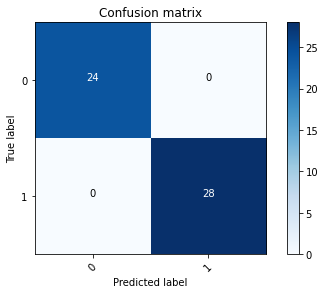

2022-02-21 11:16:52 - [Epoch Train: 8] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 118.00 s            
2022-02-21 11:16:52 - [Epoch Valid: 8] loss: 0.0011, auc: 1.0000, acc: 1.0000, time: 16.00 s
2022-02-21 11:16:52 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_10-57-38/RSNAClassifierSingle3D-DW-SO-e8-loss0.001-acc1.000-auc1.000.pth'


 80%|██████████████████████████████████▍        | 8/10 [19:14<04:37, 138.64s/it]

2022-02-21 11:16:52 - EPOCH: 9
2022-02-21 11:16:59 - Train Step 10/207, train_loss: 0.0000
2022-02-21 11:17:04 - Train Step 20/207, train_loss: 0.0000
2022-02-21 11:17:10 - Train Step 30/207, train_loss: 0.0000
2022-02-21 11:17:15 - Train Step 40/207, train_loss: 0.0001
2022-02-21 11:17:21 - Train Step 50/207, train_loss: 0.0001
2022-02-21 11:17:26 - Train Step 60/207, train_loss: 0.0001
2022-02-21 11:17:31 - Train Step 70/207, train_loss: 0.0001
2022-02-21 11:17:37 - Train Step 80/207, train_loss: 0.0001
2022-02-21 11:17:42 - Train Step 90/207, train_loss: 0.0001
2022-02-21 11:17:47 - Train Step 100/207, train_loss: 0.0001
2022-02-21 11:17:52 - Train Step 110/207, train_loss: 0.0001
2022-02-21 11:17:57 - Train Step 120/207, train_loss: 0.0001
2022-02-21 11:18:02 - Train Step 130/207, train_loss: 0.0001
2022-02-21 11:18:08 - Train Step 140/207, train_loss: 0.0001
2022-02-21 11:18:13 - Train Step 150/207, train_loss: 0.0001
2022-02-21 11:18:19 - Train Step 160/207, train_loss: 0.0001
20

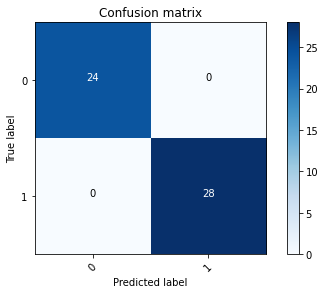

2022-02-21 11:19:02 - [Epoch Train: 9] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 113.00 s            
2022-02-21 11:19:02 - [Epoch Valid: 9] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 16.00 s
2022-02-21 11:19:02 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_10-57-38/RSNAClassifierSingle3D-DW-SO-e9-loss0.001-acc1.000-auc1.000.pth'


 90%|██████████████████████████████████████▋    | 9/10 [21:24<02:16, 136.00s/it]

2022-02-21 11:19:02 - EPOCH: 10
2022-02-21 11:19:09 - Train Step 10/207, train_loss: 0.0000
2022-02-21 11:19:14 - Train Step 20/207, train_loss: 0.0000
2022-02-21 11:19:20 - Train Step 30/207, train_loss: 0.0000
2022-02-21 11:19:26 - Train Step 40/207, train_loss: 0.0000
2022-02-21 11:19:32 - Train Step 50/207, train_loss: 0.0000
2022-02-21 11:19:38 - Train Step 60/207, train_loss: 0.0000
2022-02-21 11:19:43 - Train Step 70/207, train_loss: 0.0000
2022-02-21 11:19:49 - Train Step 80/207, train_loss: 0.0000
2022-02-21 11:19:54 - Train Step 90/207, train_loss: 0.0000
2022-02-21 11:20:00 - Train Step 100/207, train_loss: 0.0000
2022-02-21 11:20:06 - Train Step 110/207, train_loss: 0.0000
2022-02-21 11:20:11 - Train Step 120/207, train_loss: 0.0000
2022-02-21 11:20:17 - Train Step 130/207, train_loss: 0.0000
2022-02-21 11:20:22 - Train Step 140/207, train_loss: 0.0000
2022-02-21 11:20:28 - Train Step 150/207, train_loss: 0.0000
2022-02-21 11:20:34 - Train Step 160/207, train_loss: 0.0001
2

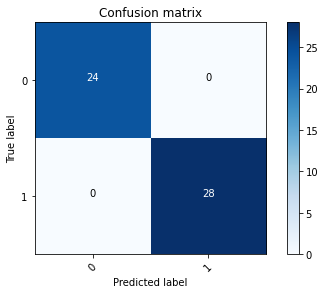

2022-02-21 11:21:19 - [Epoch Train: 10] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 118.00 s            
2022-02-21 11:21:19 - [Epoch Valid: 10] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 17.00 s
2022-02-21 11:21:19 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_10-57-38/RSNAClassifierSingle3D-DW-SO-e10-loss0.001-acc1.000-auc1.000.pth'


100%|██████████████████████████████████████████| 10/10 [23:40<00:00, 142.09s/it]

2022-02-21 11:21:19 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_10-57-38/RSNAClassifierSingle3D-DW-SO-e10-loss0.001-acc1.000-auc1.000.pth 516


Dataset: Labeled Test Set
               BraTS21ID  MGMT_real_value  MGMT_value
20     Brats18_2013_24_1                1           1
50   Brats18_CBICA_AAL_1                1           1
38   Brats18_CBICA_ABO_1                1           1
21   Brats18_CBICA_ALX_1                1           1
5    Brats18_CBICA_ANG_1                1           1
0    Brats18_CBICA_ANP_1                1           1
9    Brats18_CBICA_AOH_1                1           1
49   Brats18_CBICA_AOO_1                1           1
4    Brats18_CBICA_ASG_1                1           1
8    Brats18_CBICA_ASW_1                1           1
3    Brats18_CBICA_AXM_1                1           1
48   Brats18_CBICA_BFB_1                1           1
26   Brats18_CBICA_BFP_1                1           1
33  Brats18_TCIA01_186_1                1           1
6   Brats18_TCIA01_335_1                1           1
36  Brats18_TCIA02_198_1                1           1
16  Brats18_TCIA02_608_1                1           1
14

  0%|                                                    | 0/10 [00:00<?, ?it/s]

2022-02-21 11:21:36 - EPOCH: 1
2022-02-21 11:21:41 - Train Step 10/207, train_loss: 0.6459
2022-02-21 11:21:45 - Train Step 20/207, train_loss: 0.5513
2022-02-21 11:21:50 - Train Step 30/207, train_loss: 0.4623
2022-02-21 11:21:54 - Train Step 40/207, train_loss: 0.4057
2022-02-21 11:21:59 - Train Step 50/207, train_loss: 0.3638
2022-02-21 11:22:03 - Train Step 60/207, train_loss: 0.3237
2022-02-21 11:22:07 - Train Step 70/207, train_loss: 0.2872
2022-02-21 11:22:11 - Train Step 80/207, train_loss: 0.2545
2022-02-21 11:22:15 - Train Step 90/207, train_loss: 0.2313
2022-02-21 11:22:20 - Train Step 100/207, train_loss: 0.2147
2022-02-21 11:22:24 - Train Step 110/207, train_loss: 0.1989
2022-02-21 11:22:28 - Train Step 120/207, train_loss: 0.1837
2022-02-21 11:22:33 - Train Step 130/207, train_loss: 0.1708
2022-02-21 11:22:37 - Train Step 140/207, train_loss: 0.1636
2022-02-21 11:22:41 - Train Step 150/207, train_loss: 0.1545
2022-02-21 11:22:46 - Train Step 160/207, train_loss: 0.1473
20

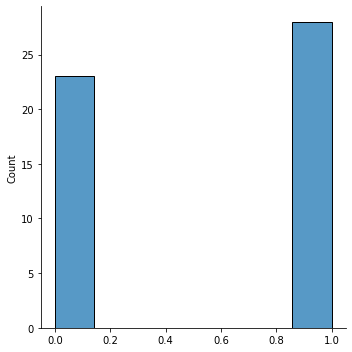

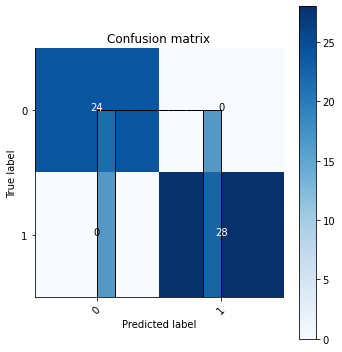

2022-02-21 11:23:20 - [Epoch Train: 1] loss: 0.1224, auc: 0.9946, acc: 0.9370, time: 90.00 s            
2022-02-21 11:23:20 - [Epoch Valid: 1] loss: 0.0079, auc: 1.0000, acc: 1.0000, time: 13.00 s
2022-02-21 11:23:20 - acc improved from 0.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Feb21_11-21-36/RSNAClassifierSingle3D-DW-SO-KLF-e1-loss0.008-acc1.000-auc1.000.pth'


 10%|████▎                                      | 1/10 [01:44<15:38, 104.32s/it]

2022-02-21 11:23:20 - EPOCH: 2
2022-02-21 11:23:25 - Train Step 10/207, train_loss: 0.0268
2022-02-21 11:23:30 - Train Step 20/207, train_loss: 0.0311
2022-02-21 11:23:35 - Train Step 30/207, train_loss: 0.0211
2022-02-21 11:23:40 - Train Step 40/207, train_loss: 0.0166
2022-02-21 11:23:45 - Train Step 50/207, train_loss: 0.0149
2022-02-21 11:23:49 - Train Step 60/207, train_loss: 0.0126
2022-02-21 11:23:54 - Train Step 70/207, train_loss: 0.0112
2022-02-21 11:23:58 - Train Step 80/207, train_loss: 0.0104
2022-02-21 11:24:03 - Train Step 90/207, train_loss: 0.0099
2022-02-21 11:24:08 - Train Step 100/207, train_loss: 0.0096
2022-02-21 11:24:12 - Train Step 110/207, train_loss: 0.0089
2022-02-21 11:24:17 - Train Step 120/207, train_loss: 0.0082
2022-02-21 11:24:22 - Train Step 130/207, train_loss: 0.0087
2022-02-21 11:24:27 - Train Step 140/207, train_loss: 0.0083
2022-02-21 11:24:31 - Train Step 150/207, train_loss: 0.0077
2022-02-21 11:24:36 - Train Step 160/207, train_loss: 0.0074
20

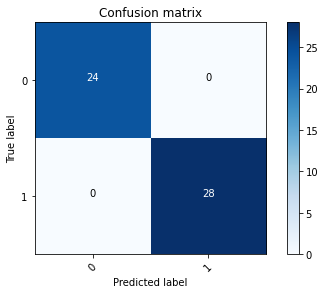

2022-02-21 11:25:11 - [Epoch Train: 2] loss: 0.0070, auc: 1.0000, acc: 1.0000, time: 97.00 s            
2022-02-21 11:25:11 - [Epoch Valid: 2] loss: 0.0054, auc: 1.0000, acc: 1.0000, time: 12.00 s
2022-02-21 11:25:11 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Feb21_11-21-36/RSNAClassifierSingle3D-DW-SO-KLF-e2-loss0.005-acc1.000-auc1.000.pth'


 20%|████████▌                                  | 2/10 [03:35<14:24, 108.08s/it]

2022-02-21 11:25:11 - EPOCH: 3
2022-02-21 11:25:16 - Train Step 10/207, train_loss: 0.0004
2022-02-21 11:25:20 - Train Step 20/207, train_loss: 0.0005
2022-02-21 11:25:25 - Train Step 30/207, train_loss: 0.0004
2022-02-21 11:25:29 - Train Step 40/207, train_loss: 0.0005
2022-02-21 11:25:34 - Train Step 50/207, train_loss: 0.0013
2022-02-21 11:25:38 - Train Step 60/207, train_loss: 0.0014
2022-02-21 11:25:43 - Train Step 70/207, train_loss: 0.0015
2022-02-21 11:25:47 - Train Step 80/207, train_loss: 0.0014
2022-02-21 11:25:52 - Train Step 90/207, train_loss: 0.0013
2022-02-21 11:25:56 - Train Step 100/207, train_loss: 0.0026
2022-02-21 11:26:01 - Train Step 110/207, train_loss: 0.0024
2022-02-21 11:26:05 - Train Step 120/207, train_loss: 0.0022
2022-02-21 11:26:10 - Train Step 130/207, train_loss: 0.0021
2022-02-21 11:26:14 - Train Step 140/207, train_loss: 0.0020
2022-02-21 11:26:19 - Train Step 150/207, train_loss: 0.0019
2022-02-21 11:26:23 - Train Step 160/207, train_loss: 0.0018
20

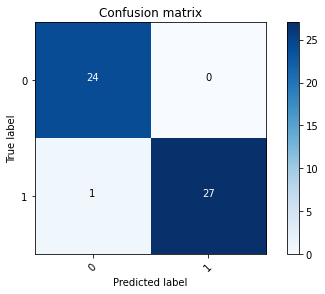

2022-02-21 11:26:57 - [Epoch Train: 3] loss: 0.0031, auc: 1.0000, acc: 1.0000, time: 93.00 s            
2022-02-21 11:26:57 - [Epoch Valid: 3] loss: 0.0117, auc: 1.0000, acc: 0.9808, time: 13.00 s


 30%|████████████▉                              | 3/10 [05:21<12:32, 107.48s/it]

2022-02-21 11:26:57 - EPOCH: 4
2022-02-21 11:27:03 - Train Step 10/207, train_loss: 0.0010
2022-02-21 11:27:07 - Train Step 20/207, train_loss: 0.0176
2022-02-21 11:27:12 - Train Step 30/207, train_loss: 0.0118
2022-02-21 11:27:16 - Train Step 40/207, train_loss: 0.0089
2022-02-21 11:27:21 - Train Step 50/207, train_loss: 0.0071
2022-02-21 11:27:25 - Train Step 60/207, train_loss: 0.0061
2022-02-21 11:27:30 - Train Step 70/207, train_loss: 0.0053
2022-02-21 11:27:34 - Train Step 80/207, train_loss: 0.0047
2022-02-21 11:27:39 - Train Step 90/207, train_loss: 0.0042
2022-02-21 11:27:44 - Train Step 100/207, train_loss: 0.0038
2022-02-21 11:27:48 - Train Step 110/207, train_loss: 0.0035
2022-02-21 11:27:53 - Train Step 120/207, train_loss: 0.0032
2022-02-21 11:27:58 - Train Step 130/207, train_loss: 0.0030
2022-02-21 11:28:02 - Train Step 140/207, train_loss: 0.0028
2022-02-21 11:28:06 - Train Step 150/207, train_loss: 0.0026
2022-02-21 11:28:10 - Train Step 160/207, train_loss: 0.0025
20

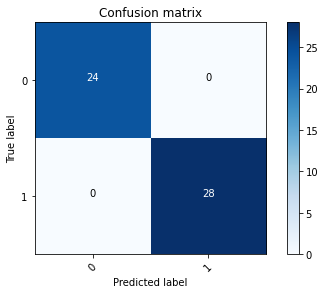

2022-02-21 11:28:44 - [Epoch Train: 4] loss: 0.0020, auc: 1.0000, acc: 0.9976, time: 93.00 s            
2022-02-21 11:28:44 - [Epoch Valid: 4] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 12.00 s
2022-02-21 11:28:44 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Feb21_11-21-36/RSNAClassifierSingle3D-DW-SO-KLF-e4-loss0.001-acc1.000-auc1.000.pth'


 40%|█████████████████▏                         | 4/10 [07:08<10:42, 107.07s/it]

2022-02-21 11:28:44 - EPOCH: 5
2022-02-21 11:28:49 - Train Step 10/207, train_loss: 0.0002
2022-02-21 11:28:54 - Train Step 20/207, train_loss: 0.0003
2022-02-21 11:28:58 - Train Step 30/207, train_loss: 0.0002
2022-02-21 11:29:03 - Train Step 40/207, train_loss: 0.0003
2022-02-21 11:29:07 - Train Step 50/207, train_loss: 0.0003
2022-02-21 11:29:11 - Train Step 60/207, train_loss: 0.0003
2022-02-21 11:29:15 - Train Step 70/207, train_loss: 0.0004
2022-02-21 11:29:20 - Train Step 80/207, train_loss: 0.0004
2022-02-21 11:29:24 - Train Step 90/207, train_loss: 0.0003
2022-02-21 11:29:28 - Train Step 100/207, train_loss: 0.0003
2022-02-21 11:29:32 - Train Step 110/207, train_loss: 0.0004
2022-02-21 11:29:36 - Train Step 120/207, train_loss: 0.0003
2022-02-21 11:29:41 - Train Step 130/207, train_loss: 0.0003
2022-02-21 11:29:45 - Train Step 140/207, train_loss: 0.0004
2022-02-21 11:29:50 - Train Step 150/207, train_loss: 0.0003
2022-02-21 11:29:54 - Train Step 160/207, train_loss: 0.0004
20

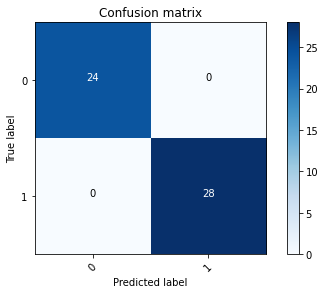

2022-02-21 11:30:28 - [Epoch Train: 5] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 90.00 s            
2022-02-21 11:30:28 - [Epoch Valid: 5] loss: 0.0012, auc: 1.0000, acc: 1.0000, time: 12.00 s
2022-02-21 11:30:28 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Feb21_11-21-36/RSNAClassifierSingle3D-DW-SO-KLF-e5-loss0.001-acc1.000-auc1.000.pth'


 50%|█████████████████████▌                     | 5/10 [08:51<08:49, 105.86s/it]

2022-02-21 11:30:28 - EPOCH: 6
2022-02-21 11:30:33 - Train Step 10/207, train_loss: 0.0000
2022-02-21 11:30:37 - Train Step 20/207, train_loss: 0.0001
2022-02-21 11:30:41 - Train Step 30/207, train_loss: 0.0001
2022-02-21 11:30:45 - Train Step 40/207, train_loss: 0.0001
2022-02-21 11:30:49 - Train Step 50/207, train_loss: 0.0001
2022-02-21 11:30:53 - Train Step 60/207, train_loss: 0.0001
2022-02-21 11:30:58 - Train Step 70/207, train_loss: 0.0001
2022-02-21 11:31:02 - Train Step 80/207, train_loss: 0.0001
2022-02-21 11:31:06 - Train Step 90/207, train_loss: 0.0002
2022-02-21 11:31:10 - Train Step 100/207, train_loss: 0.0002
2022-02-21 11:31:15 - Train Step 110/207, train_loss: 0.0002
2022-02-21 11:31:19 - Train Step 120/207, train_loss: 0.0002
2022-02-21 11:31:23 - Train Step 130/207, train_loss: 0.0002
2022-02-21 11:31:27 - Train Step 140/207, train_loss: 0.0002
2022-02-21 11:31:31 - Train Step 150/207, train_loss: 0.0002
2022-02-21 11:31:36 - Train Step 160/207, train_loss: 0.0002
20

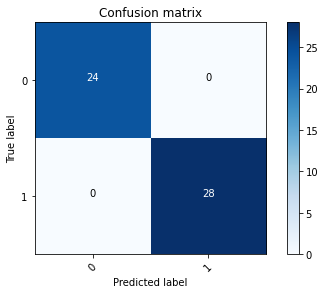

2022-02-21 11:32:09 - [Epoch Train: 6] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 88.00 s            
2022-02-21 11:32:09 - [Epoch Valid: 6] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 12.00 s
2022-02-21 11:32:09 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Feb21_11-21-36/RSNAClassifierSingle3D-DW-SO-KLF-e6-loss0.001-acc1.000-auc1.000.pth'


 60%|█████████████████████████▊                 | 6/10 [10:33<06:57, 104.26s/it]

2022-02-21 11:32:09 - EPOCH: 7
2022-02-21 11:32:14 - Train Step 10/207, train_loss: 0.0002
2022-02-21 11:32:18 - Train Step 20/207, train_loss: 0.0001
2022-02-21 11:32:23 - Train Step 30/207, train_loss: 0.0001
2022-02-21 11:32:27 - Train Step 40/207, train_loss: 0.0001
2022-02-21 11:32:31 - Train Step 50/207, train_loss: 0.0001
2022-02-21 11:32:35 - Train Step 60/207, train_loss: 0.0001
2022-02-21 11:32:40 - Train Step 70/207, train_loss: 0.0002
2022-02-21 11:32:44 - Train Step 80/207, train_loss: 0.0002
2022-02-21 11:32:49 - Train Step 90/207, train_loss: 0.0002
2022-02-21 11:32:53 - Train Step 100/207, train_loss: 0.0002
2022-02-21 11:32:58 - Train Step 110/207, train_loss: 0.0002
2022-02-21 11:33:02 - Train Step 120/207, train_loss: 0.0002
2022-02-21 11:33:07 - Train Step 130/207, train_loss: 0.0002
2022-02-21 11:33:11 - Train Step 140/207, train_loss: 0.0002
2022-02-21 11:33:16 - Train Step 150/207, train_loss: 0.0002
2022-02-21 11:33:21 - Train Step 160/207, train_loss: 0.0001
20

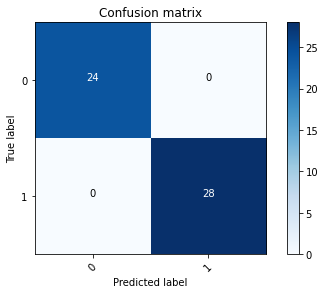

2022-02-21 11:33:55 - [Epoch Train: 7] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 92.00 s            
2022-02-21 11:33:55 - [Epoch Valid: 7] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 12.00 s
2022-02-21 11:33:55 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Feb21_11-21-36/RSNAClassifierSingle3D-DW-SO-KLF-e7-loss0.001-acc1.000-auc1.000.pth'


 70%|██████████████████████████████             | 7/10 [12:19<05:14, 104.81s/it]

2022-02-21 11:33:55 - EPOCH: 8
2022-02-21 11:34:00 - Train Step 10/207, train_loss: 0.0000
2022-02-21 11:34:04 - Train Step 20/207, train_loss: 0.0000
2022-02-21 11:34:09 - Train Step 30/207, train_loss: 0.0000
2022-02-21 11:34:13 - Train Step 40/207, train_loss: 0.0003
2022-02-21 11:34:18 - Train Step 50/207, train_loss: 0.0002
2022-02-21 11:34:22 - Train Step 60/207, train_loss: 0.0002
2022-02-21 11:34:26 - Train Step 70/207, train_loss: 0.0002
2022-02-21 11:34:30 - Train Step 80/207, train_loss: 0.0001
2022-02-21 11:34:35 - Train Step 90/207, train_loss: 0.0001
2022-02-21 11:34:39 - Train Step 100/207, train_loss: 0.0001
2022-02-21 11:34:43 - Train Step 110/207, train_loss: 0.0002
2022-02-21 11:34:48 - Train Step 120/207, train_loss: 0.0001
2022-02-21 11:34:52 - Train Step 130/207, train_loss: 0.0001
2022-02-21 11:34:56 - Train Step 140/207, train_loss: 0.0001
2022-02-21 11:35:00 - Train Step 150/207, train_loss: 0.0001
2022-02-21 11:35:04 - Train Step 160/207, train_loss: 0.0001
20

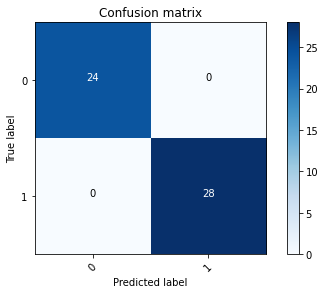

2022-02-21 11:35:38 - [Epoch Train: 8] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 89.00 s            
2022-02-21 11:35:38 - [Epoch Valid: 8] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 13.00 s
2022-02-21 11:35:38 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Feb21_11-21-36/RSNAClassifierSingle3D-DW-SO-KLF-e8-loss0.000-acc1.000-auc1.000.pth'


 80%|██████████████████████████████████▍        | 8/10 [14:02<03:28, 104.27s/it]

2022-02-21 11:35:38 - EPOCH: 9
2022-02-21 11:35:43 - Train Step 10/207, train_loss: 0.0000
2022-02-21 11:35:47 - Train Step 20/207, train_loss: 0.0000
2022-02-21 11:35:52 - Train Step 30/207, train_loss: 0.0000
2022-02-21 11:35:56 - Train Step 40/207, train_loss: 0.0000
2022-02-21 11:36:00 - Train Step 50/207, train_loss: 0.0000
2022-02-21 11:36:04 - Train Step 60/207, train_loss: 0.0000
2022-02-21 11:36:09 - Train Step 70/207, train_loss: 0.0000
2022-02-21 11:36:13 - Train Step 80/207, train_loss: 0.0000
2022-02-21 11:36:18 - Train Step 90/207, train_loss: 0.0000
2022-02-21 11:36:22 - Train Step 100/207, train_loss: 0.0000
2022-02-21 11:36:26 - Train Step 110/207, train_loss: 0.0000
2022-02-21 11:36:30 - Train Step 120/207, train_loss: 0.0000
2022-02-21 11:36:34 - Train Step 130/207, train_loss: 0.0001
2022-02-21 11:36:38 - Train Step 140/207, train_loss: 0.0001
2022-02-21 11:36:42 - Train Step 150/207, train_loss: 0.0001
2022-02-21 11:36:47 - Train Step 160/207, train_loss: 0.0001
20

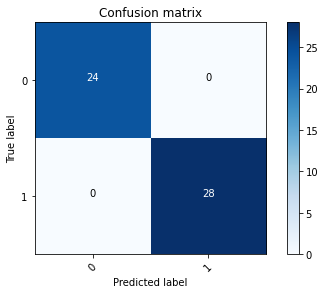

2022-02-21 11:37:20 - [Epoch Train: 9] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 88.00 s            
2022-02-21 11:37:20 - [Epoch Valid: 9] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 13.00 s
2022-02-21 11:37:20 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Feb21_11-21-36/RSNAClassifierSingle3D-DW-SO-KLF-e9-loss0.001-acc1.000-auc1.000.pth'


 90%|██████████████████████████████████████▋    | 9/10 [15:44<01:43, 103.62s/it]

2022-02-21 11:37:20 - EPOCH: 10
2022-02-21 11:37:25 - Train Step 10/207, train_loss: 0.0000
2022-02-21 11:37:30 - Train Step 20/207, train_loss: 0.0000
2022-02-21 11:37:35 - Train Step 30/207, train_loss: 0.0000
2022-02-21 11:37:40 - Train Step 40/207, train_loss: 0.0000
2022-02-21 11:37:44 - Train Step 50/207, train_loss: 0.0000
2022-02-21 11:37:49 - Train Step 60/207, train_loss: 0.0000
2022-02-21 11:37:53 - Train Step 70/207, train_loss: 0.0000
2022-02-21 11:37:58 - Train Step 80/207, train_loss: 0.0000
2022-02-21 11:38:03 - Train Step 90/207, train_loss: 0.0001
2022-02-21 11:38:07 - Train Step 100/207, train_loss: 0.0001
2022-02-21 11:38:12 - Train Step 110/207, train_loss: 0.0000
2022-02-21 11:38:17 - Train Step 120/207, train_loss: 0.0000
2022-02-21 11:38:22 - Train Step 130/207, train_loss: 0.0000
2022-02-21 11:38:27 - Train Step 140/207, train_loss: 0.0000
2022-02-21 11:38:31 - Train Step 150/207, train_loss: 0.0000
2022-02-21 11:38:36 - Train Step 160/207, train_loss: 0.0001
2

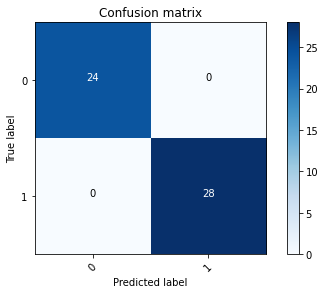

2022-02-21 11:39:11 - [Epoch Train: 10] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 97.00 s            
2022-02-21 11:39:11 - [Epoch Valid: 10] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 12.00 s
2022-02-21 11:39:11 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Feb21_11-21-36/RSNAClassifierSingle3D-DW-SO-KLF-e10-loss0.000-acc1.000-auc1.000.pth'


100%|██████████████████████████████████████████| 10/10 [17:35<00:00, 105.52s/it]

2022-02-21 11:39:11 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Feb21_11-21-36/RSNAClassifierSingle3D-DW-SO-KLF-e10-loss0.000-acc1.000-auc1.000.pth 516


Dataset: Labeled Test Set
               BraTS21ID  MGMT_real_value  MGMT_value
20     Brats18_2013_24_1                1           1
50   Brats18_CBICA_AAL_1                1           1
38   Brats18_CBICA_ABO_1                1           1
21   Brats18_CBICA_ALX_1                1           1
5    Brats18_CBICA_ANG_1                1           1
0    Brats18_CBICA_ANP_1                1           1
9    Brats18_CBICA_AOH_1                1           1
49   Brats18_CBICA_AOO_1                1           1
4    Brats18_CBICA_ASG_1                1           1
8    Brats18_CBICA_ASW_1                1           1
3    Brats18_CBICA_AXM_1                1           1
48   Brats18_CBICA_BFB_1                1           1
26   Brats18_CBICA_BFP_1                1           1
33  Brats18_TCIA01_186_1                1           1
6   Brats18_TCIA01_335_1                1           1
36  Brats18_TCIA02_198_1                1           1
16  Brats18_TCIA02_608_1                1           1
14

  0%|                                                    | 0/10 [00:00<?, ?it/s]

2022-02-21 11:39:24 - EPOCH: 1
2022-02-21 11:40:08 - Train Step 10/26, train_loss: 0.7017
2022-02-21 11:40:49 - Train Step 20/26, train_loss: 0.6988
Adjusting learning rate of group 0 to 1.0000e-04.
First 64 results:
                   BraTS21ID  MGMT_real_value  MGMT_value
4      Brats18_2013_10_1_KLF                1           0
3       Brats18_2013_6_1_KLF                1           0
14   Brats18_CBICA_ABY_1_KLF                1           0
27   Brats18_CBICA_ANI_1_KLF                1           0
38   Brats18_CBICA_ASE_1_KLF                1           0
23   Brats18_CBICA_ASH_1_KLF                1           0
21   Brats18_CBICA_AUN_1_KLF                1           0
1    Brats18_CBICA_AWI_1_KLF                1           0
32   Brats18_CBICA_AXW_1_KLF                1           0
30   Brats18_CBICA_AYI_1_KLF                1           0
20   Brats18_CBICA_BHB_1_KLF                1           0
42  Brats18_TCIA01_401_1_KLF                1           0
37  Brats18_TCIA01_411_1_KLF 

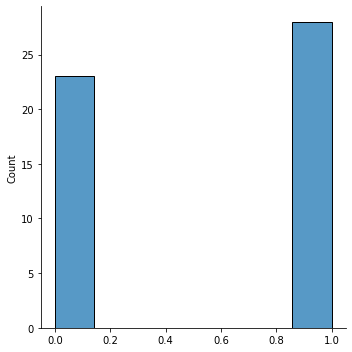

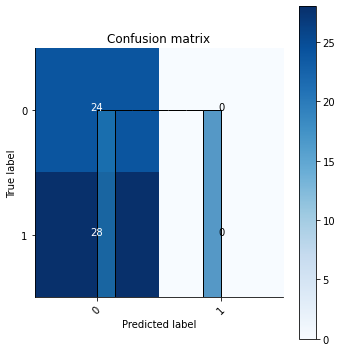

2022-02-21 11:41:28 - [Epoch Train: 1] loss: 0.7067, auc: 0.5195, acc: 0.4455, time: 104.00 s            
2022-02-21 11:41:28 - [Epoch Valid: 1] loss: 0.7034, auc: 0.4524, acc: 0.4615, time: 18.00 s
2022-02-21 11:41:28 - acc improved from 0.0000 to 0.4615. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Feb21_11-39-24/RSNAClassifierSingleFake3D-DW-SO-KLF-e1-loss0.703-acc0.462-auc0.452.pth'


 10%|████▎                                      | 1/10 [02:03<18:29, 123.33s/it]

2022-02-21 11:41:28 - EPOCH: 2
2022-02-21 11:42:04 - Train Step 10/26, train_loss: 0.6915
2022-02-21 11:42:37 - Train Step 20/26, train_loss: 0.6953
Adjusting learning rate of group 0 to 1.0000e-04.
First 64 results:
                   BraTS21ID  MGMT_real_value  MGMT_value
12     Brats18_2013_10_1_KLF                1           0
49      Brats18_2013_6_1_KLF                1           0
10   Brats18_CBICA_ABY_1_KLF                1           0
28   Brats18_CBICA_ANI_1_KLF                1           0
2    Brats18_CBICA_ASE_1_KLF                1           0
20   Brats18_CBICA_ASH_1_KLF                1           0
0    Brats18_CBICA_AUN_1_KLF                1           0
9    Brats18_CBICA_AWI_1_KLF                1           0
31   Brats18_CBICA_AXW_1_KLF                1           0
1    Brats18_CBICA_AYI_1_KLF                1           0
15   Brats18_CBICA_BHB_1_KLF                1           0
48  Brats18_TCIA01_401_1_KLF                1           0
6   Brats18_TCIA01_411_1_KLF 

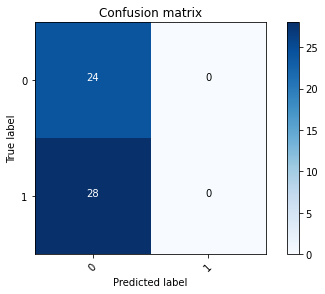

2022-02-21 11:43:15 - [Epoch Train: 2] loss: 0.6946, auc: 0.7343, acc: 0.4455, time: 89.00 s            
2022-02-21 11:43:15 - [Epoch Valid: 2] loss: 0.7019, auc: 0.6414, acc: 0.4615, time: 17.00 s
2022-02-21 11:43:15 - acc improved from 0.4615 to 0.4615. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Feb21_11-39-24/RSNAClassifierSingleFake3D-DW-SO-KLF-e2-loss0.702-acc0.462-auc0.641.pth'


 20%|████████▌                                  | 2/10 [03:50<15:09, 113.70s/it]

2022-02-21 11:43:15 - EPOCH: 3
2022-02-21 11:43:50 - Train Step 10/26, train_loss: 0.6854
2022-02-21 11:44:24 - Train Step 20/26, train_loss: 0.6849
Adjusting learning rate of group 0 to 1.0000e-04.
First 64 results:
                   BraTS21ID  MGMT_real_value  MGMT_value
7      Brats18_2013_10_1_KLF                1           0
24      Brats18_2013_6_1_KLF                1           0
22   Brats18_CBICA_ABY_1_KLF                1           0
48   Brats18_CBICA_ANI_1_KLF                1           0
27   Brats18_CBICA_ASE_1_KLF                1           0
40   Brats18_CBICA_ASH_1_KLF                1           0
16   Brats18_CBICA_AUN_1_KLF                1           0
47   Brats18_CBICA_AWI_1_KLF                1           0
12   Brats18_CBICA_AXW_1_KLF                1           0
30   Brats18_CBICA_AYI_1_KLF                1           0
8    Brats18_CBICA_BHB_1_KLF                1           0
36  Brats18_TCIA01_401_1_KLF                1           0
5   Brats18_TCIA01_411_1_KLF 

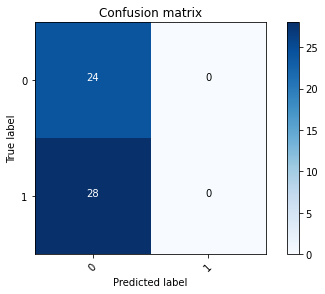

2022-02-21 11:45:02 - [Epoch Train: 3] loss: 0.6846, auc: 0.8688, acc: 0.4455, time: 89.00 s            
2022-02-21 11:45:02 - [Epoch Valid: 3] loss: 0.6940, auc: 0.7589, acc: 0.4615, time: 18.00 s
2022-02-21 11:45:02 - acc improved from 0.4615 to 0.4615. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Feb21_11-39-24/RSNAClassifierSingleFake3D-DW-SO-KLF-e3-loss0.694-acc0.462-auc0.759.pth'


 30%|████████████▉                              | 3/10 [05:37<12:56, 110.96s/it]

2022-02-21 11:45:02 - EPOCH: 4
2022-02-21 11:45:36 - Train Step 10/26, train_loss: 0.6800
2022-02-21 11:46:07 - Train Step 20/26, train_loss: 0.6764
Adjusting learning rate of group 0 to 1.0000e-04.
First 64 results:
                   BraTS21ID  MGMT_real_value  MGMT_value
32     Brats18_2013_10_1_KLF                1           0
21      Brats18_2013_6_1_KLF                1           0
38   Brats18_CBICA_ABY_1_KLF                1           0
23   Brats18_CBICA_ANI_1_KLF                1           0
27   Brats18_CBICA_ASE_1_KLF                1           0
42   Brats18_CBICA_ASH_1_KLF                1           0
10   Brats18_CBICA_AUN_1_KLF                1           0
3    Brats18_CBICA_AWI_1_KLF                1           0
5    Brats18_CBICA_AXW_1_KLF                1           0
28   Brats18_CBICA_AYI_1_KLF                1           0
41   Brats18_CBICA_BHB_1_KLF                1           0
50  Brats18_TCIA01_401_1_KLF                1           0
29  Brats18_TCIA01_411_1_KLF 

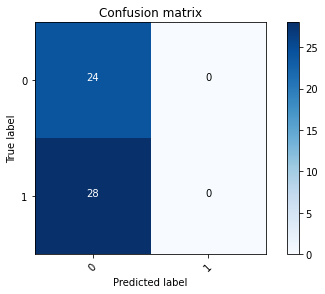

2022-02-21 11:46:44 - [Epoch Train: 4] loss: 0.6762, auc: 0.9263, acc: 0.4455, time: 83.00 s            
2022-02-21 11:46:44 - [Epoch Valid: 4] loss: 0.6852, auc: 0.8542, acc: 0.4615, time: 17.00 s
2022-02-21 11:46:44 - acc improved from 0.4615 to 0.4615. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Feb21_11-39-24/RSNAClassifierSingleFake3D-DW-SO-KLF-e4-loss0.685-acc0.462-auc0.854.pth'


 40%|█████████████████▏                         | 4/10 [07:19<10:43, 107.21s/it]

2022-02-21 11:46:44 - EPOCH: 5
2022-02-21 11:47:18 - Train Step 10/26, train_loss: 0.6717
2022-02-21 11:47:50 - Train Step 20/26, train_loss: 0.6677
Adjusting learning rate of group 0 to 1.0000e-04.
First 64 results:
                   BraTS21ID  MGMT_real_value  MGMT_value
49     Brats18_2013_10_1_KLF                1           0
17      Brats18_2013_6_1_KLF                1           0
1    Brats18_CBICA_ABY_1_KLF                1           0
10   Brats18_CBICA_ANI_1_KLF                1           0
29   Brats18_CBICA_ASE_1_KLF                1           0
33   Brats18_CBICA_ASH_1_KLF                1           0
24   Brats18_CBICA_AUN_1_KLF                1           0
12   Brats18_CBICA_AWI_1_KLF                1           0
40   Brats18_CBICA_AXW_1_KLF                1           0
36   Brats18_CBICA_AYI_1_KLF                1           0
44   Brats18_CBICA_BHB_1_KLF                1           0
26  Brats18_TCIA01_401_1_KLF                1           0
22  Brats18_TCIA01_411_1_KLF 

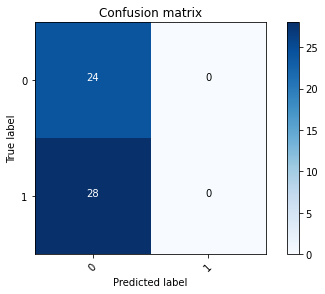

2022-02-21 11:48:26 - [Epoch Train: 5] loss: 0.6670, auc: 0.9622, acc: 0.4455, time: 84.00 s            
2022-02-21 11:48:26 - [Epoch Valid: 5] loss: 0.6786, auc: 0.8988, acc: 0.4615, time: 17.00 s
2022-02-21 11:48:26 - acc improved from 0.4615 to 0.4615. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Feb21_11-39-24/RSNAClassifierSingleFake3D-DW-SO-KLF-e5-loss0.679-acc0.462-auc0.899.pth'


 50%|█████████████████████▌                     | 5/10 [09:01<08:46, 105.34s/it]

2022-02-21 11:48:26 - EPOCH: 6
2022-02-21 11:49:01 - Train Step 10/26, train_loss: 0.6619
2022-02-21 11:49:33 - Train Step 20/26, train_loss: 0.6562
Adjusting learning rate of group 0 to 1.0000e-04.
First 64 results:
                   BraTS21ID  MGMT_real_value  MGMT_value
24     Brats18_2013_10_1_KLF                1           0
43      Brats18_2013_6_1_KLF                1           0
0    Brats18_CBICA_ABY_1_KLF                1           0
28   Brats18_CBICA_ANI_1_KLF                1           0
42   Brats18_CBICA_ASE_1_KLF                1           0
23   Brats18_CBICA_ASH_1_KLF                1           0
38   Brats18_CBICA_AUN_1_KLF                1           0
27   Brats18_CBICA_AWI_1_KLF                1           0
35   Brats18_CBICA_AXW_1_KLF                1           0
10   Brats18_CBICA_AYI_1_KLF                1           0
1    Brats18_CBICA_BHB_1_KLF                1           0
13  Brats18_TCIA01_401_1_KLF                1           0
21  Brats18_TCIA01_411_1_KLF 

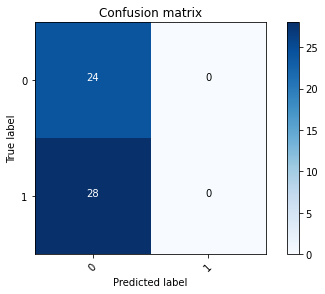

2022-02-21 11:50:09 - [Epoch Train: 6] loss: 0.6582, auc: 0.9799, acc: 0.4455, time: 84.00 s            
2022-02-21 11:50:09 - [Epoch Valid: 6] loss: 0.6719, auc: 0.9226, acc: 0.4615, time: 17.00 s
2022-02-21 11:50:09 - acc improved from 0.4615 to 0.4615. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Feb21_11-39-24/RSNAClassifierSingleFake3D-DW-SO-KLF-e6-loss0.672-acc0.462-auc0.923.pth'


 60%|█████████████████████████▊                 | 6/10 [10:44<06:58, 104.58s/it]

2022-02-21 11:50:09 - EPOCH: 7
2022-02-21 11:50:43 - Train Step 10/26, train_loss: 0.6583
2022-02-21 11:51:15 - Train Step 20/26, train_loss: 0.6458
Adjusting learning rate of group 0 to 1.0000e-04.
First 64 results:
                   BraTS21ID  MGMT_real_value  MGMT_value
10     Brats18_2013_10_1_KLF                1           0
13      Brats18_2013_6_1_KLF                1           0
8    Brats18_CBICA_ABY_1_KLF                1           0
27   Brats18_CBICA_ANI_1_KLF                1           0
44   Brats18_CBICA_ASE_1_KLF                1           0
34   Brats18_CBICA_ASH_1_KLF                1           0
14   Brats18_CBICA_AUN_1_KLF                1           0
33   Brats18_CBICA_AWI_1_KLF                1           0
41   Brats18_CBICA_AXW_1_KLF                1           0
20   Brats18_CBICA_AYI_1_KLF                1           0
12   Brats18_CBICA_BHB_1_KLF                1           0
3   Brats18_TCIA01_401_1_KLF                1           0
24  Brats18_TCIA01_411_1_KLF 

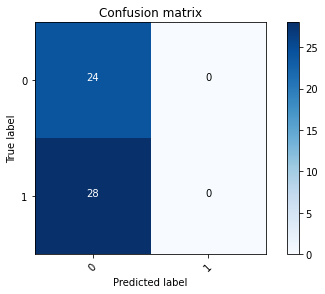

2022-02-21 11:51:49 - [Epoch Train: 7] loss: 0.6468, auc: 0.9898, acc: 0.4455, time: 84.00 s            
2022-02-21 11:51:49 - [Epoch Valid: 7] loss: 0.6648, auc: 0.9435, acc: 0.4615, time: 15.00 s
2022-02-21 11:51:49 - acc improved from 0.4615 to 0.4615. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Feb21_11-39-24/RSNAClassifierSingleFake3D-DW-SO-KLF-e7-loss0.665-acc0.462-auc0.943.pth'


 70%|██████████████████████████████             | 7/10 [12:24<05:09, 103.14s/it]

2022-02-21 11:51:49 - EPOCH: 8
2022-02-21 11:52:24 - Train Step 10/26, train_loss: 0.6415
2022-02-21 11:52:56 - Train Step 20/26, train_loss: 0.6394
Adjusting learning rate of group 0 to 1.0000e-04.
First 64 results:
                   BraTS21ID  MGMT_real_value  MGMT_value
48     Brats18_2013_10_1_KLF                1           0
18      Brats18_2013_6_1_KLF                1           0
2    Brats18_CBICA_ABY_1_KLF                1           0
10   Brats18_CBICA_ANI_1_KLF                1           0
46   Brats18_CBICA_ASE_1_KLF                1           0
34   Brats18_CBICA_ASH_1_KLF                1           0
35   Brats18_CBICA_AUN_1_KLF                1           0
1    Brats18_CBICA_AWI_1_KLF                1           0
16   Brats18_CBICA_AXW_1_KLF                1           0
0    Brats18_CBICA_AYI_1_KLF                1           0
41   Brats18_CBICA_BHB_1_KLF                1           0
27  Brats18_TCIA01_401_1_KLF                1           0
42  Brats18_TCIA01_411_1_KLF 

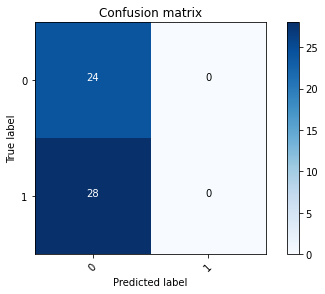

2022-02-21 11:53:32 - [Epoch Train: 8] loss: 0.6341, auc: 0.9971, acc: 0.4455, time: 85.00 s            
2022-02-21 11:53:32 - [Epoch Valid: 8] loss: 0.6571, auc: 0.9464, acc: 0.4615, time: 17.00 s
2022-02-21 11:53:32 - acc improved from 0.4615 to 0.4615. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Feb21_11-39-24/RSNAClassifierSingleFake3D-DW-SO-KLF-e8-loss0.657-acc0.462-auc0.946.pth'


 80%|██████████████████████████████████▍        | 8/10 [14:07<03:26, 103.16s/it]

2022-02-21 11:53:32 - EPOCH: 9
2022-02-21 11:54:08 - Train Step 10/26, train_loss: 0.6198
2022-02-21 11:54:39 - Train Step 20/26, train_loss: 0.6188
Adjusting learning rate of group 0 to 1.0000e-04.
First 64 results:
                   BraTS21ID  MGMT_real_value  MGMT_value
17     Brats18_2013_10_1_KLF                1           0
12      Brats18_2013_6_1_KLF                1           0
33   Brats18_CBICA_ABY_1_KLF                1           0
23   Brats18_CBICA_ANI_1_KLF                1           0
27   Brats18_CBICA_ASE_1_KLF                1           0
37   Brats18_CBICA_ASH_1_KLF                1           0
50   Brats18_CBICA_AUN_1_KLF                1           0
51   Brats18_CBICA_AWI_1_KLF                1           0
29   Brats18_CBICA_AXW_1_KLF                1           0
41   Brats18_CBICA_AYI_1_KLF                1           0
7    Brats18_CBICA_BHB_1_KLF                1           0
45  Brats18_TCIA01_401_1_KLF                1           0
38  Brats18_TCIA01_411_1_KLF 

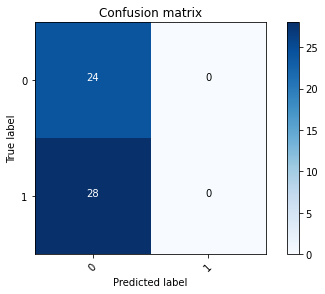

2022-02-21 11:55:14 - [Epoch Train: 9] loss: 0.6198, auc: 0.9981, acc: 0.4455, time: 86.00 s            
2022-02-21 11:55:14 - [Epoch Valid: 9] loss: 0.6462, auc: 0.9554, acc: 0.4615, time: 14.00 s
2022-02-21 11:55:14 - acc improved from 0.4615 to 0.4615. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Feb21_11-39-24/RSNAClassifierSingleFake3D-DW-SO-KLF-e9-loss0.646-acc0.462-auc0.955.pth'


 90%|██████████████████████████████████████▋    | 9/10 [15:49<01:42, 102.63s/it]

2022-02-21 11:55:14 - EPOCH: 10
2022-02-21 11:55:49 - Train Step 10/26, train_loss: 0.6046
2022-02-21 11:56:20 - Train Step 20/26, train_loss: 0.6037
Adjusting learning rate of group 0 to 5.0000e-05.
First 64 results:
                   BraTS21ID  MGMT_real_value  MGMT_value
48     Brats18_2013_10_1_KLF                1           0
41      Brats18_2013_6_1_KLF                1           0
15   Brats18_CBICA_ABY_1_KLF                1           0
44   Brats18_CBICA_ANI_1_KLF                1           0
13   Brats18_CBICA_ASE_1_KLF                1           0
38   Brats18_CBICA_ASH_1_KLF                1           0
43   Brats18_CBICA_AUN_1_KLF                1           0
17   Brats18_CBICA_AWI_1_KLF                1           0
5    Brats18_CBICA_AXW_1_KLF                1           0
25   Brats18_CBICA_AYI_1_KLF                1           0
21   Brats18_CBICA_BHB_1_KLF                1           0
28  Brats18_TCIA01_401_1_KLF                1           0
35  Brats18_TCIA01_411_1_KLF

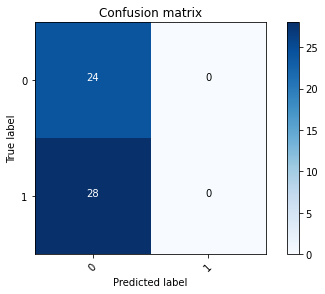

2022-02-21 11:56:57 - [Epoch Train: 10] loss: 0.6037, auc: 0.9999, acc: 0.4455, time: 85.00 s            
2022-02-21 11:56:57 - [Epoch Valid: 10] loss: 0.6362, auc: 0.9598, acc: 0.4615, time: 17.00 s
2022-02-21 11:56:57 - acc improved from 0.4615 to 0.4615. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Feb21_11-39-24/RSNAClassifierSingleFake3D-DW-SO-KLF-e10-loss0.636-acc0.462-auc0.960.pth'


100%|██████████████████████████████████████████| 10/10 [17:32<00:00, 105.25s/it]

2022-02-21 11:56:57 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingleFake3D-DW-SO-KLF_Feb21_11-39-24/RSNAClassifierSingleFake3D-DW-SO-KLF-e10-loss0.636-acc0.462-auc0.960.pth 516


Dataset: Labeled Test Set
               BraTS21ID  MGMT_real_value  MGMT_value
20     Brats18_2013_24_1                1           0
50   Brats18_CBICA_AAL_1                1           0
38   Brats18_CBICA_ABO_1                1           0
21   Brats18_CBICA_ALX_1                1           0
5    Brats18_CBICA_ANG_1                1           0
0    Brats18_CBICA_ANP_1                1           0
9    Brats18_CBICA_AOH_1                1           0
49   Brats18_CBICA_AOO_1                1           0
4    Brats18_CBICA_ASG_1                1           0
8    Brats18_CBICA_ASW_1                1           0
3    Brats18_CBICA_AXM_1                1           0
48   Brats18_CBICA_BFB_1                1           0
26   Brats18_CBICA_BFP_1                1           0
33  Brats18_TCIA01_186_1                1           0
6   Brats18_TCIA01_335_1                1           0
36  Brats18_TCIA02_198_1                1           0
16  Brats18_TCIA02_608_1                1           0
14

  0%|                                                    | 0/10 [00:00<?, ?it/s]

2022-02-21 11:57:14 - EPOCH: 1
2022-02-21 11:57:21 - Train Step 10/207, train_loss: 0.6606
2022-02-21 11:57:26 - Train Step 20/207, train_loss: 0.5703
2022-02-21 11:57:33 - Train Step 30/207, train_loss: 0.4684
2022-02-21 11:57:39 - Train Step 40/207, train_loss: 0.3920
2022-02-21 11:57:45 - Train Step 50/207, train_loss: 0.3304
2022-02-21 11:57:51 - Train Step 60/207, train_loss: 0.2987
2022-02-21 11:57:57 - Train Step 70/207, train_loss: 0.2730
2022-02-21 11:58:03 - Train Step 80/207, train_loss: 0.2483
2022-02-21 11:58:09 - Train Step 90/207, train_loss: 0.2246
2022-02-21 11:58:15 - Train Step 100/207, train_loss: 0.2029
2022-02-21 11:58:21 - Train Step 110/207, train_loss: 0.1854
2022-02-21 11:58:28 - Train Step 120/207, train_loss: 0.1707
2022-02-21 11:58:34 - Train Step 130/207, train_loss: 0.1580
2022-02-21 11:58:40 - Train Step 140/207, train_loss: 0.1472
2022-02-21 11:58:46 - Train Step 150/207, train_loss: 0.1378
2022-02-21 11:58:52 - Train Step 160/207, train_loss: 0.1295
20

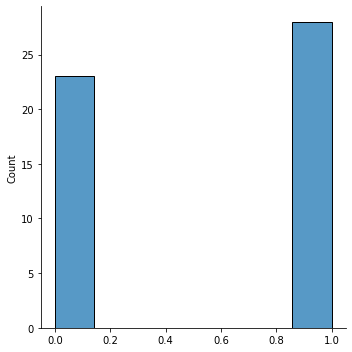

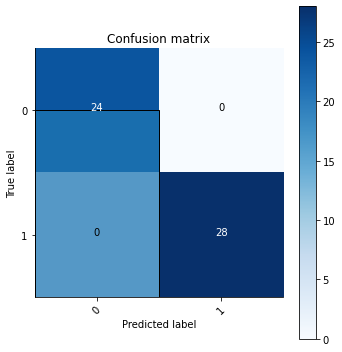

2022-02-21 11:59:39 - [Epoch Train: 1] loss: 0.1032, auc: 0.9961, acc: 0.9492, time: 127.00 s            
2022-02-21 11:59:39 - [Epoch Valid: 1] loss: 0.0022, auc: 1.0000, acc: 1.0000, time: 17.00 s
2022-02-21 11:59:39 - acc improved from 0.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_11-57-14/RSNAClassifierSingle3D-DW-SO-e1-loss0.002-acc1.000-auc1.000.pth'


 10%|████▎                                      | 1/10 [02:25<21:47, 145.30s/it]

2022-02-21 11:59:39 - EPOCH: 2
2022-02-21 11:59:46 - Train Step 10/207, train_loss: 0.0012
2022-02-21 11:59:51 - Train Step 20/207, train_loss: 0.0014
2022-02-21 11:59:57 - Train Step 30/207, train_loss: 0.0014
2022-02-21 12:00:03 - Train Step 40/207, train_loss: 0.0013
2022-02-21 12:00:08 - Train Step 50/207, train_loss: 0.0012
2022-02-21 12:00:14 - Train Step 60/207, train_loss: 0.0012
2022-02-21 12:00:19 - Train Step 70/207, train_loss: 0.0011
2022-02-21 12:00:24 - Train Step 80/207, train_loss: 0.0014
2022-02-21 12:00:30 - Train Step 90/207, train_loss: 0.0013
2022-02-21 12:00:36 - Train Step 100/207, train_loss: 0.0013
2022-02-21 12:00:42 - Train Step 110/207, train_loss: 0.0012
2022-02-21 12:00:47 - Train Step 120/207, train_loss: 0.0012
2022-02-21 12:00:53 - Train Step 130/207, train_loss: 0.0012
2022-02-21 12:00:58 - Train Step 140/207, train_loss: 0.0011
2022-02-21 12:01:03 - Train Step 150/207, train_loss: 0.0011
2022-02-21 12:01:09 - Train Step 160/207, train_loss: 0.0010
20

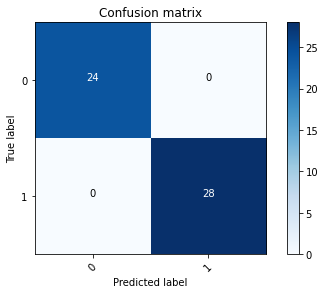

2022-02-21 12:01:50 - [Epoch Train: 2] loss: 0.0010, auc: 1.0000, acc: 1.0000, time: 114.00 s            
2022-02-21 12:01:50 - [Epoch Valid: 2] loss: 0.0012, auc: 1.0000, acc: 1.0000, time: 16.00 s
2022-02-21 12:01:50 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_11-57-14/RSNAClassifierSingle3D-DW-SO-e2-loss0.001-acc1.000-auc1.000.pth'


 20%|████████▌                                  | 2/10 [04:36<18:14, 136.79s/it]

2022-02-21 12:01:50 - EPOCH: 3
2022-02-21 12:01:57 - Train Step 10/207, train_loss: 0.0002
2022-02-21 12:02:02 - Train Step 20/207, train_loss: 0.0002
2022-02-21 12:02:08 - Train Step 30/207, train_loss: 0.0003
2022-02-21 12:02:13 - Train Step 40/207, train_loss: 0.0004
2022-02-21 12:02:19 - Train Step 50/207, train_loss: 0.0004
2022-02-21 12:02:25 - Train Step 60/207, train_loss: 0.0005
2022-02-21 12:02:32 - Train Step 70/207, train_loss: 0.0005
2022-02-21 12:02:38 - Train Step 80/207, train_loss: 0.0006
2022-02-21 12:02:44 - Train Step 90/207, train_loss: 0.0006
2022-02-21 12:02:50 - Train Step 100/207, train_loss: 0.0006
2022-02-21 12:02:56 - Train Step 110/207, train_loss: 0.0005
2022-02-21 12:03:02 - Train Step 120/207, train_loss: 0.0005
2022-02-21 12:03:08 - Train Step 130/207, train_loss: 0.0005
2022-02-21 12:03:14 - Train Step 140/207, train_loss: 0.0004
2022-02-21 12:03:20 - Train Step 150/207, train_loss: 0.0004
2022-02-21 12:03:26 - Train Step 160/207, train_loss: 0.0004
20

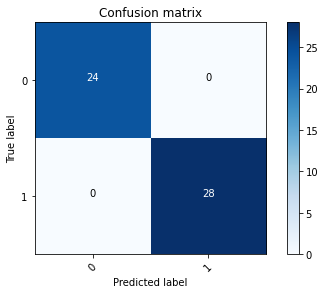

2022-02-21 12:04:12 - [Epoch Train: 3] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 124.00 s            
2022-02-21 12:04:12 - [Epoch Valid: 3] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 16.00 s
2022-02-21 12:04:12 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_11-57-14/RSNAClassifierSingle3D-DW-SO-e3-loss0.000-acc1.000-auc1.000.pth'


 30%|████████████▉                              | 3/10 [06:57<16:12, 138.91s/it]

2022-02-21 12:04:12 - EPOCH: 4
2022-02-21 12:04:18 - Train Step 10/207, train_loss: 0.0001
2022-02-21 12:04:24 - Train Step 20/207, train_loss: 0.0003
2022-02-21 12:04:29 - Train Step 30/207, train_loss: 0.0003
2022-02-21 12:04:34 - Train Step 40/207, train_loss: 0.0003
2022-02-21 12:04:40 - Train Step 50/207, train_loss: 0.0004
2022-02-21 12:04:45 - Train Step 60/207, train_loss: 0.0003
2022-02-21 12:04:51 - Train Step 70/207, train_loss: 0.0003
2022-02-21 12:04:57 - Train Step 80/207, train_loss: 0.0003
2022-02-21 12:05:02 - Train Step 90/207, train_loss: 0.0003
2022-02-21 12:05:07 - Train Step 100/207, train_loss: 0.0003
2022-02-21 12:05:13 - Train Step 110/207, train_loss: 0.0003
2022-02-21 12:05:18 - Train Step 120/207, train_loss: 0.0003
2022-02-21 12:05:23 - Train Step 130/207, train_loss: 0.0003
2022-02-21 12:05:28 - Train Step 140/207, train_loss: 0.0003
2022-02-21 12:05:33 - Train Step 150/207, train_loss: 0.0003
2022-02-21 12:05:38 - Train Step 160/207, train_loss: 0.0003
20

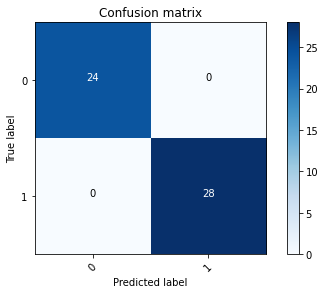

2022-02-21 12:06:20 - [Epoch Train: 4] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 111.00 s            
2022-02-21 12:06:20 - [Epoch Valid: 4] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 16.00 s
2022-02-21 12:06:20 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_11-57-14/RSNAClassifierSingle3D-DW-SO-e4-loss0.000-acc1.000-auc1.000.pth'


 40%|█████████████████▏                         | 4/10 [09:05<13:28, 134.72s/it]

2022-02-21 12:06:20 - EPOCH: 5
2022-02-21 12:06:27 - Train Step 10/207, train_loss: 0.0002
2022-02-21 12:06:32 - Train Step 20/207, train_loss: 0.0001
2022-02-21 12:06:38 - Train Step 30/207, train_loss: 0.0001
2022-02-21 12:06:43 - Train Step 40/207, train_loss: 0.0001
2022-02-21 12:06:48 - Train Step 50/207, train_loss: 0.0001
2022-02-21 12:06:53 - Train Step 60/207, train_loss: 0.0001
2022-02-21 12:06:59 - Train Step 70/207, train_loss: 0.0001
2022-02-21 12:07:05 - Train Step 80/207, train_loss: 0.0001
2022-02-21 12:07:10 - Train Step 90/207, train_loss: 0.0001
2022-02-21 12:07:16 - Train Step 100/207, train_loss: 0.0001
2022-02-21 12:07:22 - Train Step 110/207, train_loss: 0.0001
2022-02-21 12:07:28 - Train Step 120/207, train_loss: 0.0001
2022-02-21 12:07:35 - Train Step 130/207, train_loss: 0.0001
2022-02-21 12:07:41 - Train Step 140/207, train_loss: 0.0001
2022-02-21 12:07:47 - Train Step 150/207, train_loss: 0.0001
2022-02-21 12:07:53 - Train Step 160/207, train_loss: 0.0001
20

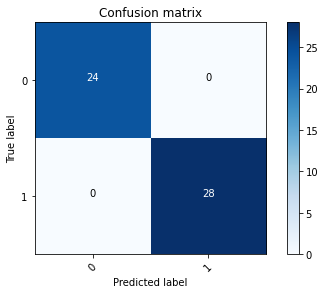

2022-02-21 12:08:40 - [Epoch Train: 5] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 122.00 s            
2022-02-21 12:08:40 - [Epoch Valid: 5] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 17.00 s
2022-02-21 12:08:40 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_11-57-14/RSNAClassifierSingle3D-DW-SO-e5-loss0.000-acc1.000-auc1.000.pth'


 50%|█████████████████████▌                     | 5/10 [11:25<11:23, 136.62s/it]

2022-02-21 12:08:40 - EPOCH: 6
2022-02-21 12:08:46 - Train Step 10/207, train_loss: 0.0000
2022-02-21 12:08:52 - Train Step 20/207, train_loss: 0.0000
2022-02-21 12:08:57 - Train Step 30/207, train_loss: 0.0000
2022-02-21 12:09:02 - Train Step 40/207, train_loss: 0.0000
2022-02-21 12:09:08 - Train Step 50/207, train_loss: 0.0000
2022-02-21 12:09:13 - Train Step 60/207, train_loss: 0.0000
2022-02-21 12:09:18 - Train Step 70/207, train_loss: 0.0000
2022-02-21 12:09:24 - Train Step 80/207, train_loss: 0.0011
2022-02-21 12:09:29 - Train Step 90/207, train_loss: 0.0013
2022-02-21 12:09:34 - Train Step 100/207, train_loss: 0.0012
2022-02-21 12:09:39 - Train Step 110/207, train_loss: 0.0011
2022-02-21 12:09:44 - Train Step 120/207, train_loss: 0.0010
2022-02-21 12:09:50 - Train Step 130/207, train_loss: 0.0010
2022-02-21 12:09:55 - Train Step 140/207, train_loss: 0.0009
2022-02-21 12:10:01 - Train Step 150/207, train_loss: 0.0009
2022-02-21 12:10:06 - Train Step 160/207, train_loss: 0.0008
20

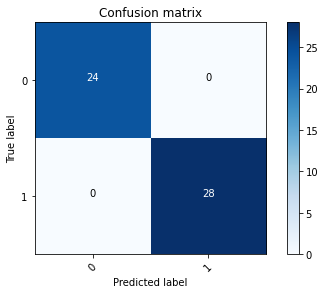

2022-02-21 12:10:48 - [Epoch Train: 6] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 112.00 s            
2022-02-21 12:10:48 - [Epoch Valid: 6] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 15.00 s
2022-02-21 12:10:48 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_11-57-14/RSNAClassifierSingle3D-DW-SO-e6-loss0.000-acc1.000-auc1.000.pth'


 60%|█████████████████████████▊                 | 6/10 [13:34<08:55, 133.83s/it]

2022-02-21 12:10:48 - EPOCH: 7
2022-02-21 12:10:55 - Train Step 10/207, train_loss: 0.0000
2022-02-21 12:11:01 - Train Step 20/207, train_loss: 0.0000
2022-02-21 12:11:08 - Train Step 30/207, train_loss: 0.0000
2022-02-21 12:11:14 - Train Step 40/207, train_loss: 0.0001
2022-02-21 12:11:20 - Train Step 50/207, train_loss: 0.0001
2022-02-21 12:11:27 - Train Step 60/207, train_loss: 0.0001
2022-02-21 12:11:33 - Train Step 70/207, train_loss: 0.0001
2022-02-21 12:11:39 - Train Step 80/207, train_loss: 0.0002
2022-02-21 12:11:45 - Train Step 90/207, train_loss: 0.0001
2022-02-21 12:11:51 - Train Step 100/207, train_loss: 0.0001
2022-02-21 12:11:58 - Train Step 110/207, train_loss: 0.0001
2022-02-21 12:12:04 - Train Step 120/207, train_loss: 0.0001
2022-02-21 12:12:10 - Train Step 130/207, train_loss: 0.0001
2022-02-21 12:12:16 - Train Step 140/207, train_loss: 0.0001
2022-02-21 12:12:22 - Train Step 150/207, train_loss: 0.0001
2022-02-21 12:12:28 - Train Step 160/207, train_loss: 0.0001
20

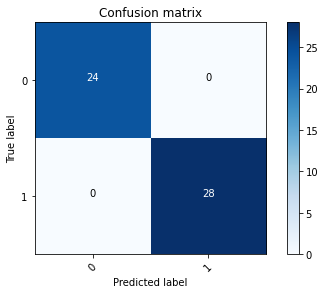

2022-02-21 12:13:14 - [Epoch Train: 7] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 128.00 s            
2022-02-21 12:13:14 - [Epoch Valid: 7] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 16.00 s
2022-02-21 12:13:14 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_11-57-14/RSNAClassifierSingle3D-DW-SO-e7-loss0.000-acc1.000-auc1.000.pth'


 70%|██████████████████████████████             | 7/10 [15:59<06:52, 137.65s/it]

2022-02-21 12:13:14 - EPOCH: 8
2022-02-21 12:13:20 - Train Step 10/207, train_loss: 0.0000
2022-02-21 12:13:27 - Train Step 20/207, train_loss: 0.0000
2022-02-21 12:13:33 - Train Step 30/207, train_loss: 0.0000
2022-02-21 12:13:38 - Train Step 40/207, train_loss: 0.0000
2022-02-21 12:13:45 - Train Step 50/207, train_loss: 0.0000
2022-02-21 12:13:51 - Train Step 60/207, train_loss: 0.0000
2022-02-21 12:13:57 - Train Step 70/207, train_loss: 0.0000
2022-02-21 12:14:03 - Train Step 80/207, train_loss: 0.0000
2022-02-21 12:14:09 - Train Step 90/207, train_loss: 0.0000
2022-02-21 12:14:15 - Train Step 100/207, train_loss: 0.0000
2022-02-21 12:14:21 - Train Step 110/207, train_loss: 0.0000
2022-02-21 12:14:27 - Train Step 120/207, train_loss: 0.0000
2022-02-21 12:14:33 - Train Step 130/207, train_loss: 0.0000
2022-02-21 12:14:40 - Train Step 140/207, train_loss: 0.0000
2022-02-21 12:14:46 - Train Step 150/207, train_loss: 0.0000
2022-02-21 12:14:52 - Train Step 160/207, train_loss: 0.0000
20

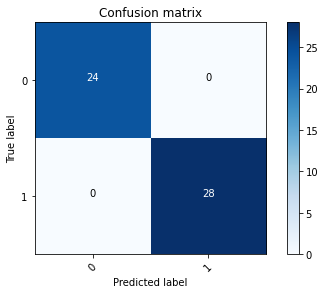

2022-02-21 12:15:38 - [Epoch Train: 8] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 127.00 s            
2022-02-21 12:15:38 - [Epoch Valid: 8] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 16.00 s
2022-02-21 12:15:38 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_11-57-14/RSNAClassifierSingle3D-DW-SO-e8-loss0.000-acc1.000-auc1.000.pth'


 80%|██████████████████████████████████▍        | 8/10 [18:23<04:39, 139.70s/it]

2022-02-21 12:15:38 - EPOCH: 9
2022-02-21 12:15:45 - Train Step 10/207, train_loss: 0.0000
2022-02-21 12:15:50 - Train Step 20/207, train_loss: 0.0000
2022-02-21 12:15:56 - Train Step 30/207, train_loss: 0.0000
2022-02-21 12:16:02 - Train Step 40/207, train_loss: 0.0000
2022-02-21 12:16:08 - Train Step 50/207, train_loss: 0.0000
2022-02-21 12:16:14 - Train Step 60/207, train_loss: 0.0000
2022-02-21 12:16:20 - Train Step 70/207, train_loss: 0.0000
2022-02-21 12:16:26 - Train Step 80/207, train_loss: 0.0000
2022-02-21 12:16:32 - Train Step 90/207, train_loss: 0.0000
2022-02-21 12:16:38 - Train Step 100/207, train_loss: 0.0000
2022-02-21 12:16:45 - Train Step 110/207, train_loss: 0.0000
2022-02-21 12:16:50 - Train Step 120/207, train_loss: 0.0000
2022-02-21 12:16:57 - Train Step 130/207, train_loss: 0.0000
2022-02-21 12:17:03 - Train Step 140/207, train_loss: 0.0000
2022-02-21 12:17:09 - Train Step 150/207, train_loss: 0.0000
2022-02-21 12:17:15 - Train Step 160/207, train_loss: 0.0000
20

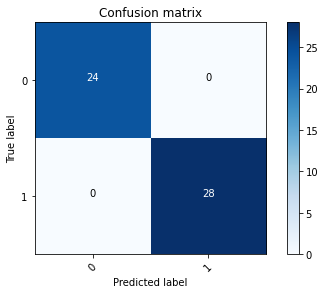

2022-02-21 12:18:00 - [Epoch Train: 9] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 126.00 s            
2022-02-21 12:18:00 - [Epoch Valid: 9] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 15.00 s
2022-02-21 12:18:00 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_11-57-14/RSNAClassifierSingle3D-DW-SO-e9-loss0.000-acc1.000-auc1.000.pth'


 90%|██████████████████████████████████████▋    | 9/10 [20:46<02:20, 140.46s/it]

2022-02-21 12:18:00 - EPOCH: 10
2022-02-21 12:18:06 - Train Step 10/207, train_loss: 0.0000
2022-02-21 12:18:12 - Train Step 20/207, train_loss: 0.0000
2022-02-21 12:18:18 - Train Step 30/207, train_loss: 0.0000
2022-02-21 12:18:25 - Train Step 40/207, train_loss: 0.0000
2022-02-21 12:18:31 - Train Step 50/207, train_loss: 0.0000
2022-02-21 12:18:37 - Train Step 60/207, train_loss: 0.0000
2022-02-21 12:18:44 - Train Step 70/207, train_loss: 0.0000
2022-02-21 12:18:50 - Train Step 80/207, train_loss: 0.0000
2022-02-21 12:18:56 - Train Step 90/207, train_loss: 0.0000
2022-02-21 12:19:03 - Train Step 100/207, train_loss: 0.0000
2022-02-21 12:19:09 - Train Step 110/207, train_loss: 0.0000
2022-02-21 12:19:15 - Train Step 120/207, train_loss: 0.0000
2022-02-21 12:19:21 - Train Step 130/207, train_loss: 0.0000
2022-02-21 12:19:27 - Train Step 140/207, train_loss: 0.0000
2022-02-21 12:19:34 - Train Step 150/207, train_loss: 0.0000
2022-02-21 12:19:40 - Train Step 160/207, train_loss: 0.0000
2

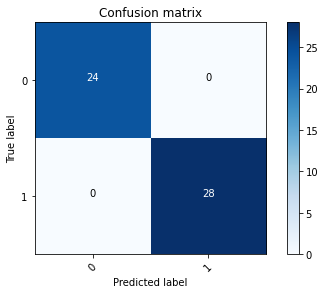

2022-02-21 12:20:26 - [Epoch Train: 10] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 129.00 s            
2022-02-21 12:20:26 - [Epoch Valid: 10] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 16.00 s
2022-02-21 12:20:26 - acc improved from 1.0000 to 1.0000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_11-57-14/RSNAClassifierSingle3D-DW-SO-e10-loss0.000-acc1.000-auc1.000.pth'


100%|██████████████████████████████████████████| 10/10 [23:12<00:00, 139.22s/it]

2022-02-21 12:20:26 - Predict: ../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO_Feb21_11-57-14/RSNAClassifierSingle3D-DW-SO-e10-loss0.000-acc1.000-auc1.000.pth 516


Dataset: Labeled Test Set
               BraTS21ID  MGMT_real_value  MGMT_value
20     Brats18_2013_24_1                1           1
50   Brats18_CBICA_AAL_1                1           1
38   Brats18_CBICA_ABO_1                1           1
21   Brats18_CBICA_ALX_1                1           1
5    Brats18_CBICA_ANG_1                1           1
0    Brats18_CBICA_ANP_1                1           1
9    Brats18_CBICA_AOH_1                1           1
49   Brats18_CBICA_AOO_1                1           1
4    Brats18_CBICA_ASG_1                1           1
8    Brats18_CBICA_ASW_1                1           1
3    Brats18_CBICA_AXM_1                1           1
48   Brats18_CBICA_BFB_1                1           1
26   Brats18_CBICA_BFP_1                1           1
33  Brats18_TCIA01_186_1                1           1
6   Brats18_TCIA01_335_1                1           1
36  Brats18_TCIA02_198_1                1           1
16  Brats18_TCIA02_608_1                1           1
14

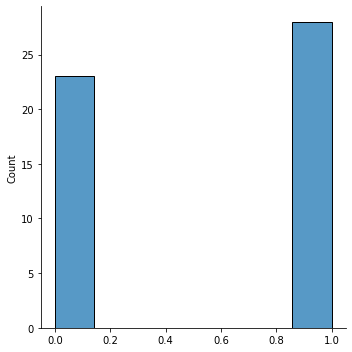

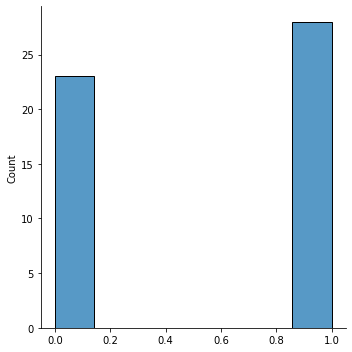

In [9]:
use_external_dataset = True
for folder in folders_list:
    model_common_path = "../RSNA-BTC-Datasets/out_models/"
    model_folder = model_common_path + folder #folders_list[2]
    sel_slices=None
    if use_external_dataset:
        outputname = "other_set"
    else:
        outputname = "rsna_test_set"
        
    model_basefile, model_info = get_best_model(model_folder)
    modelfile = model_folder + "/" + model_basefile
    print(modelfile)
    print(model_info)
    ext_test_1_dir_path = "../RSNA-BTC-Datasets/brats18_"+model_info["ext"]
    ext_test_0_dir_path = "../RSNA-BTC-Datasets/OpenNeuroDS000221_ss_"+model_info["ext"]
    pd.set_option("display.max_rows", None, "display.max_columns", None)

    model = get_model_from_path(modelfile)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info("Using CUDA...")

    if use_external_dataset:
        if "T1wCE" not in model_info["mri_types"] and "T2w" not in model_info["mri_types"]:
            #hl_labelfile = "ext_test_set.csv"
            ext_test_dataset_1 = Dataset(ext_test_1_dir_path, model_info["mri_types"], list_classes=["1"], transform=None, ext=model_info["ext"], dims=model_info["dims"], sel_slices=sel_slices)
            logging.info("External Test 1 dataset size: {}".format(len(ext_test_dataset_1)))
            ext_test_dataset_0 = Dataset(ext_test_0_dir_path, model_info["mri_types"], list_classes=["0"], transform=None, ext=model_info["ext"], dims=model_info["dims"], sel_slices=sel_slices)
            logging.info("External Test 0 dataset size: {}".format(len(ext_test_dataset_0)))

            ext_test_dataset_merged = Dataset().concat_datasets(ext_test_dataset_0, ext_test_dataset_1, balance=False)
            ext_test_dataset_merged_no_tr = Dataset().concat_datasets(ext_test_dataset_0, ext_test_dataset_1, balance=False, import_transform=False)
            splits = get_splits(ext_test_dataset_0, ext_test_dataset_1, model_info["val_total_ratio"], model_info["is_10_fold"])

            dataloaders = get_all_split_loaders(ext_test_dataset_merged, ext_test_dataset_merged_no_tr, splits, model_info["batch_size"])
            dataloader = dataloaders[0]
            train_loader = dataloader[0]
            val_loader = dataloader[1]
            test_loader = dataloader[2]

            size = len(model_info["mri_types"]) - 1 if model_info["mri_types"][0] == "KLF" and len(model_info["mri_types"]) > 1 else len(model_info["mri_types"])
            
            #model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])
            modelfile = train_mri_type(model, device, model_info, epochs=10, pat=10, 
                           train_loader=train_loader, valid_loader=val_loader)

            submission = predict(model, device, modelfile, test_loader, size, is_target_included=True, outputname=outputname)
        else:
            print(f"Cannot infer on this set with {folder} since MRI sequences like T1wCE or T2w are not available")
    print("--------------------")

In [6]:
use_external_dataset = False
test_set_len = 0

for folder in folders_list:
    model_common_path = "../RSNA-BTC-Datasets/out_models/"
    model_folder = model_common_path + folder #folders_list[2]
    if use_external_dataset:
        outputname = "other_set"
    else:
        outputname = "rsna_test_set"
    if not os.path.exists(f"{model_folder}/inference_info_{outputname}.txt"):
        model_basefile, model_info = get_best_model(model_folder)
        modelfile = model_folder + "/" + model_basefile
        print(modelfile)
        print(model_info)
        pd.set_option("display.max_rows", None, "display.max_columns", None)

        model = get_model_from_path(modelfile)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logging.info("Using CUDA...")

        if use_external_dataset:
            if "T1wCE" not in model_info["mri_types"] and "T2w" not in model_info["mri_types"]:
                if ("is_internal_dataset" in model_info and model_info["is_internal_dataset"] == "True") or not "is_internal_dataset" in model_info:
                    # Train and Val: Competition Train Set - Test: External Dataset
                    hl_labelfile = "ext_test_set.csv"
                    ext_test_dataset_1 = Dataset(ext_test_1_dir_path, model_info["mri_types"], list_classes=["1"], transform=None, ext=model_info["ext"], dims=model_info["dims"], sel_slices=sel_slices)
                    logging.info("External Test 1 dataset size: {}".format(len(ext_test_dataset_1)))
                    ext_test_dataset_0 = Dataset(ext_test_0_dir_path, model_info["mri_types"], list_classes=["0"], transform=None, ext=model_info["ext"], dims=model_info["dims"], sel_slices=sel_slices)
                    logging.info("External Test 0 dataset size: {}".format(len(ext_test_dataset_0)))
                else:
                    # Train and Val: External Dataset - Test: Competition Train Set
                    hl_labelfile = "train_labels.csv"
                    ext_test_dataset_1 = Dataset(dir_path, model_info["mri_types"], list_classes=["1"], transform=None, ext=model_info["ext"], dims=model_info["dims"], sel_slices=sel_slices)
                    logging.info("Internal Test 1 dataset size: {}".format(len(ext_test_dataset_1)))
                    ext_test_dataset_0 = Dataset(dir_path, model_info["mri_types"], list_classes=["0"], transform=None, ext=model_info["ext"], dims=model_info["dims"], sel_slices=sel_slices)
                    logging.info("Internal Test 0 dataset size: {}".format(len(ext_test_dataset_0)))

                ext_test_dataset_merged = Dataset().concat_datasets(ext_test_dataset_0, ext_test_dataset_1, balance=False)
                ext_test_dataset_0_size = len(ext_test_dataset_0)
                ext_test_dataset_1_size = len(ext_test_dataset_1)
                ext_test_dataset_0_indices = list(range(ext_test_dataset_0_size))
                ext_test_dataset_1_indices = list(range(ext_test_dataset_0_size, ext_test_dataset_1_size+ext_test_dataset_0_size))

                np.random.shuffle(ext_test_dataset_0_indices)
                np.random.shuffle(ext_test_dataset_1_indices)
                #print("Test 0 Idx:")
                #print(ext_test_dataset_0_indices)
                #print("Test 1 Idx:")
                #print(ext_test_dataset_1_indices)

                ext_test_dataset_indices = ext_test_dataset_0_indices + ext_test_dataset_1_indices
                test_set_len = len(ext_test_dataset_indices)
                g_cpu = torch.Generator()
                ext_test_sampler = SubsetRandomSampler(ext_test_dataset_indices, g_cpu)

                ext_test_loader = DataLoader(dataset=ext_test_dataset_merged, batch_size=model_info["batch_size"], sampler=ext_test_sampler, num_workers=2, worker_init_fn=np.random.seed(0))

                size = len(model_info["mri_types"]) - 1 if model_info["mri_types"][0] == "KLF" and len(model_info["mri_types"]) > 1 else len(model_info["mri_types"])

                submission = predict(model, device, modelfile, ext_test_loader, size, is_target_included=False, labelfile=hl_labelfile, outputname=outputname)
                convert_to_onnx(model, device, modelfile, ext_test_loader, size, is_target_included=False)
            else:
                print(f"Cannot infer on this set with {folder} since MRI sequences like T1wCE or T2w are not available")
        else:
            # Train and Val: Competition Train Set or External Dataset - Test: Competition Test Set
            hl_labelfile = "hl_test_set.csv"
            test_dataset = Dataset(test_dir_path, model_info["mri_types"], list_classes=["unknown"], transform=None, ext=model_info["ext"], dims=model_info["dims"], sel_slices=sel_slices)

            logging.info("Test dataset size: {}".format(len(test_dataset)))

            #test_dataset = Dataset().concat_datasets(test_dataset)
            test_dataset_size = len(test_dataset)
            test_dataset_indices = list(range(test_dataset_size))
            #print(dataset_0_indices)
            #print(dataset_1_indices)
            np.random.shuffle(test_dataset_indices)
            #print("Internal Test Idx:")
            #print(test_dataset_indices)

            #np.random.shuffle(train_idx)
            #np.random.shuffle(val_idx)
            #train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
            test_set_len = len(test_dataset_indices)
            g_cpu = torch.Generator()
            #print(g_cpu.initial_seed())
            #g_cpu.manual_seed(12)
            #print(g_cpu.initial_seed())
            test_sampler = SubsetRandomSampler(test_dataset_indices, g_cpu)

            int_test_loader = DataLoader(dataset=test_dataset, batch_size=model_info["batch_size"], sampler=test_sampler, num_workers=2, worker_init_fn=np.random.seed(0))

            size = len(model_info["mri_types"]) - 1 if model_info["mri_types"][0] == "KLF" and len(model_info["mri_types"]) > 1 else len(model_info["mri_types"])

            submission = predict(model, device, modelfile, int_test_loader, size, is_target_included=False, labelfile=hl_labelfile, outputname=outputname)
            convert_to_onnx(model, device, modelfile, int_test_loader, size, is_target_included=False)
        print("--------------------")
    else:
        print(f"Inference text file already exists for model {folder}")

Inference text file already exists for model BinaryEfficientNet3D_Dec26_18-48-05
Inference text file already exists for model RSNAClassifierSingle3D-DW_Dec26_23-41-34
Inference text file already exists for model RSNAClassifierSingle3D-DW_Dec27_13-14-39
Inference text file already exists for model RSNAClassifierFake3D-DW_Dec28_02-04-29
Inference text file already exists for model RSNAClassifierSingle3D_Dec28_12-24-37
Inference text file already exists for model VoxCNN_Dec28_16-34-14
Inference text file already exists for model TunAIResNet-SO_Dec29_17-18-33
Inference text file already exists for model RSNAClassifierSingle3D-DW-SO_Dec29_23-01-24
Inference text file already exists for model RSNAClassifierSingle3D-DW-SO_Dec30_11-29-20
Inference text file already exists for model RSNAClassifier3D-DW-SO_Dec30_17-28-11
Inference text file already exists for model RSNAClassifier3D-DW-SO_Dec31_11-26-33
Inference text file already exists for model RSNAClassifierSingle3D-DW-SO_Dec31_20-29-23
Infer

In [7]:
def add_info_to_dict(foldername, filename, model_info):
    with open(f"{foldername}/{filename}", 'r') as f:
        #file.write(json.dumps(info))
        lines = f.readlines()
        for line in lines:
            line = line.replace("\n", "")
            if line != "{" and line != "}":
                parts = line.split(": ")
                if parts[1][0] == "[":
                    parts[1] = parts[1].replace("[", "").replace("]", "").replace('"', "").replace("'", "")
                    parts[1] = parts[1].split(", ")
                elif parts[1].isnumeric():
                    parts[1] = int(parts[1])
                elif is_float(parts[1]):
                    parts[1] = float(parts[1])
                elif parts[1] == "true":
                    parts[1] = True
                elif parts[1] == "false":
                    parts[1] = False
                elif "e-" in parts[1] or "e+" in parts[1]:
                    if parts[1][0] == "e":
                        parts[1] = "1"+parts[1]
                    parts[1] = float(parts[1])
                model_info[parts[0]] = parts[1]
                
    return model_info

use_ext_dat_arr = [True, False]
for use_ext_dat in use_ext_dat_arr:
    if use_ext_dat:
        print("\nExternal Test Set:")
    else:
        print("\nCompetition Test Set:")
    df = pd.DataFrame()
    for folder in folders_list:
        model_common_path = "../RSNA-BTC-Datasets/out_models/"
        full_folder = model_common_path + folder
        if use_ext_dat:
            name = "other_set"
        else:
            name = "rsna_test_set"
        if os.path.exists(f"{full_folder}/inference_info_{name}.txt"):
            model_info = {}
            model_info = add_info_to_dict(full_folder, "training_info.txt", model_info)
            model_info = add_info_to_dict(full_folder, f"inference_info_{name}.txt", model_info)
            if len(df) == 0:
                df = pd.DataFrame(columns=model_info.keys())

            # Specificity = True negative preds over real negatives (TN/(TN+FP))
            # Sensitivity = True positive preds over real positives = Recall (TP/(TP+FN))
            # Precision = True positive preds over positive preds (TP/(TP+FP))
            # F1-score = 2*P*R/(P+R)
            # Balanced Accuracy = Average of specificity and sensitivity (Spec + Sens)/2
            if model_info["test_prec"]+model_info["test_sens"] == 0:
                model_info["test_F1_score"] = 0
            else:
                model_info["test_F1_score"] = 2*model_info["test_prec"]*model_info["test_sens"]/(model_info["test_prec"]+model_info["test_sens"])
            model_info["test_BA"] = (model_info["test_spec"]+model_info["test_sens"])/2
            date = folder.split("_")[-2:]
            date = f"{date[0]}_{date[1]}"
            model_info["date"] = date
            df = df.append(model_info, ignore_index=True)

    #df = df.sort_values(by="test_F_score", ascending=False).reset_index(drop=True)
    df = df.sort_values(by="test_BA", ascending=False).reset_index(drop=True)
    df["is_10_fold"] = df["is_10_fold"].fillna(False)
    df["is_internal_dataset"] = df["is_internal_dataset"].fillna(True)
    df = df.drop(columns=["ext","momentum"])
    print(df)
    if use_ext_dat:
        df.to_csv(f"inference_results_other_set.csv", index=False)
    else:
        df.to_csv(f"inference_results_rsna_test_set.csv", index=False)


External Test Set:
   mri_types dims batch_size is_depth_wise is_transformed output_size  \
0    [FLAIR]    3          2          True           True           1   
1      [KLF]    3          8          True          False           1   
2      [KLF]    2         16          True          False           1   
3    [FLAIR]    3          8          True           True           1   
4      [KLF]    3          4         False          False           2   
5      [KLF]    3          2          True          False           1   
6      [KLF]    2         16          True          False           1   
7      [KLF]    2         16          True          False           1   
8    [FLAIR]    3          8          True           True           2   
9      [KLF]    2          2          True          False           1   
10     [KLF]    3          8          True          False           1   
11     [KLF]    2         16          True           True           2   
12   [FLAIR]    3          8   


Competition Test Set:
       mri_types dims batch_size is_depth_wise is_transformed output_size  \
0          [KLF]    2          8          True          False           1   
1          [KLF]    2          2          True          False           1   
2          [KLF]    2         16          True          False           1   
3          [KLF]    3          2          True          False           1   
4          [KLF]    2          4          True          False           1   
5        [FLAIR]    3          2          True           True           1   
6          [KLF]    2         16          True          False           1   
7          [KLF]    3          8          True          False           1   
8   [FLAIR, T2w]    3          8          True          False           1   
9          [KLF]    2         16          True           True           2   
10       [FLAIR]    3          4         False           True           2   
11         [KLF]    3          2         False       

In [ ]:
#submission = predict(model, device, modelfile, test_loader, size, is_target_included=False, labelfile=hl_labelfile)

In [ ]:
#submission["MGMT_value"].astype("float").to_csv(os.path.basename(modelfile)[:-4]+"_submission.csv")
#sns.displot(submission["MGMT_value"])